# Imports

In [1]:
#!pip install catboost

In [11]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
import catboost as cb

import matplotlib.pyplot as plt
import seaborn as sns
import math

# Read diamonds

In [12]:
diamonds_train_sorted = pd.read_csv('../data/diamonds_train_sorted.csv')
diamonds_train_sorted.head()

price  carat  cut  color  clarity  depth  table     x     y     z
0    326   0.21    4      1        2   59.8   61.0  3.89  3.84  2.31
1    326   0.23    0      1        1   61.5   55.0  3.95  3.98  2.43
2    327   0.23    1      1        4   56.9   65.0  4.05  4.07  2.31
3    334   0.29    4      5        3   62.4   58.0  4.20  4.23  2.63
4    335   0.31    1      6        1   63.3   58.0  4.34  4.35  2.75

# Feature engineering

In [13]:
#diamonds_train_sorted['table_xy'] = (diamonds_train_sorted['table'].mean()*(diamonds_train_sorted['x']*diamonds_train_sorted['y']).mean()-diamonds_train_sorted['table']*(diamonds_train_sorted['x']*diamonds_train_sorted['y']))
#diamonds_train_sorted['depth_z'] = (diamonds_train_sorted['depth'].mean()*diamonds_train_sorted['z'].mean()-diamonds_train_sorted['depth']*diamonds_train_sorted['z'])
#diamonds_train_sorted['volume'] = diamonds_train_sorted['x']*diamonds_train_sorted['y']*diamonds_train_sorted['z']
#diamonds_train_sorted['super_feature'] = diamonds_train_sorted['carat'] / diamonds_train_sorted['table'] * diamonds_train_sorted['depth']
#diamonds_train_sorted['super_feature'] = (2*diamonds_train_sorted['z'])/(diamonds_train_sorted['x']+diamonds_train_sorted['y'])
#diamonds_train_sorted['dtc'] = diamonds_train_sorted['depth'] / diamonds_train_sorted['table'] * diamonds_train_sorted['carat']
diamonds_train_sorted['ratio_length_width'] = diamonds_train_sorted['x']/diamonds_train_sorted['y']
diamonds_train_sorted.head()

price  carat  cut  color  clarity  depth  table     x     y     z  \
0    326   0.21    4      1        2   59.8   61.0  3.89  3.84  2.31   
1    326   0.23    0      1        1   61.5   55.0  3.95  3.98  2.43   
2    327   0.23    1      1        4   56.9   65.0  4.05  4.07  2.31   
3    334   0.29    4      5        3   62.4   58.0  4.20  4.23  2.63   
4    335   0.31    1      6        1   63.3   58.0  4.34  4.35  2.75   

   ratio_length_width  
0            1.013021  
1            0.992462  
2            0.995086  
3            0.992908  
4            0.997701

In [14]:
carat_log= []
for i in diamonds_train_sorted['carat']:
    carat_log.append(math.log(i))
diamonds_train_sorted['carat_log'] = carat_log
diamonds_train_sorted.head()

price  carat  cut  color  clarity  depth  table     x     y     z  \
0    326   0.21    4      1        2   59.8   61.0  3.89  3.84  2.31   
1    326   0.23    0      1        1   61.5   55.0  3.95  3.98  2.43   
2    327   0.23    1      1        4   56.9   65.0  4.05  4.07  2.31   
3    334   0.29    4      5        3   62.4   58.0  4.20  4.23  2.63   
4    335   0.31    1      6        1   63.3   58.0  4.34  4.35  2.75   

   ratio_length_width  carat_log  
0            1.013021  -1.560648  
1            0.992462  -1.469676  
2            0.995086  -1.469676  
3            0.992908  -1.237874  
4            0.997701  -1.171183

# Create diamond shape

In [15]:
shape = []
for i in diamonds_train_sorted['table'].index:
    if 54<diamonds_train_sorted['table'][i]<57 and 61<diamonds_train_sorted['depth'][i]<62.5:
        shape.append('Round')
    elif 52<diamonds_train_sorted['table'][i]<60 and 60<diamonds_train_sorted['depth'][i]<68:
        shape.append('Oval')
    elif 63<diamonds_train_sorted['table'][i]<69 and 69<diamonds_train_sorted['depth'][i]<76:
        shape.append('Princess')
    elif 58<diamonds_train_sorted['table'][i]<63 and 58<diamonds_train_sorted['depth'][i]<66:
        shape.append('Cushion')
    else:
        shape.append('others')

In [16]:
diamonds_train_sorted['shape'] = shape
diamonds_train_sorted.head()

price  carat  cut  color  clarity  depth  table     x     y     z  \
0    326   0.21    4      1        2   59.8   61.0  3.89  3.84  2.31   
1    326   0.23    0      1        1   61.5   55.0  3.95  3.98  2.43   
2    327   0.23    1      1        4   56.9   65.0  4.05  4.07  2.31   
3    334   0.29    4      5        3   62.4   58.0  4.20  4.23  2.63   
4    335   0.31    1      6        1   63.3   58.0  4.34  4.35  2.75   

   ratio_length_width  carat_log    shape  
0            1.013021  -1.560648  Cushion  
1            0.992462  -1.469676    Round  
2            0.995086  -1.469676   others  
3            0.992908  -1.237874     Oval  
4            0.997701  -1.171183     Oval

# Shape label encoding 

In [17]:
diamonds_train_sorted['shape']=diamonds_train_sorted['shape'].map({'Round':4, 'Oval': 1, 
                                                'Princess': 3, 'Cushion':2, 'others':0})
diamonds_train_sorted.head()

price  carat  cut  color  clarity  depth  table     x     y     z  \
0    326   0.21    4      1        2   59.8   61.0  3.89  3.84  2.31   
1    326   0.23    0      1        1   61.5   55.0  3.95  3.98  2.43   
2    327   0.23    1      1        4   56.9   65.0  4.05  4.07  2.31   
3    334   0.29    4      5        3   62.4   58.0  4.20  4.23  2.63   
4    335   0.31    1      6        1   63.3   58.0  4.34  4.35  2.75   

   ratio_length_width  carat_log  shape  
0            1.013021  -1.560648      2  
1            0.992462  -1.469676      4  
2            0.995086  -1.469676      0  
3            0.992908  -1.237874      1  
4            0.997701  -1.171183      1

# Correlation

<Axes: >

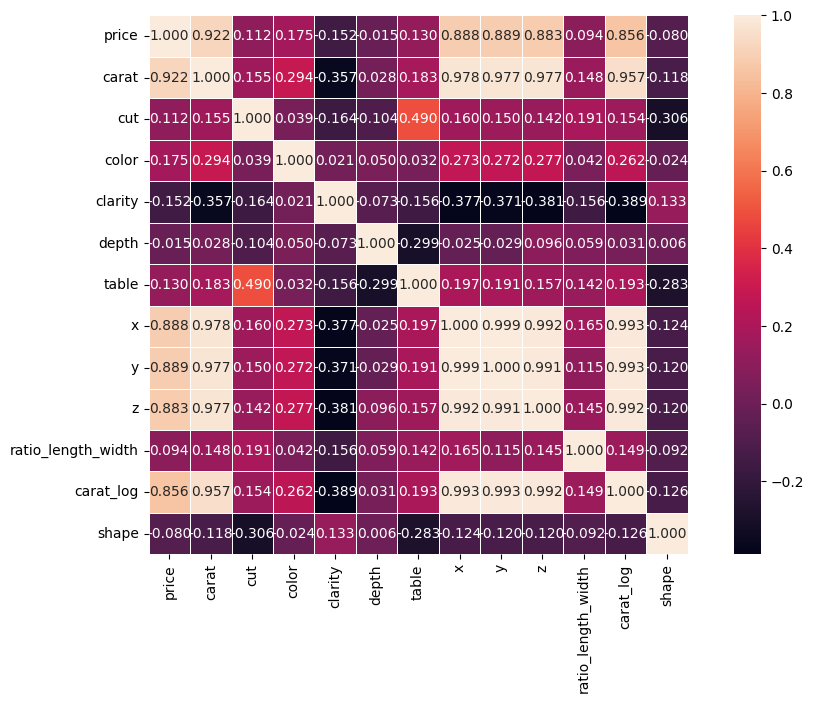

In [18]:
plt.subplots(figsize = (12, 7))
corr = diamonds_train_sorted.corr()
sns.heatmap(data = corr, annot = True, fmt = ".3f", cbar = True, linewidth = .5, 
            annot_kws = {'fontsize':10, 'fontweight':'regular'}, square = True)

# Model train split

In [19]:
X = diamonds_train_sorted[['cut',
                           'color', 
                           'clarity', 
                           'ratio_length_width',
                           'shape',
                          'carat_log']]

y = diamonds_train_sorted['price']

In [20]:
# Train + test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")
print(f"X_train: {type(X_train)}, X_test: {type(X_test)}, y_train: {type(y_train)}, y_test: {type(y_test)}")

X_train: (32344, 6), X_test: (8087, 6), y_train: (32344,), y_test: (8087,)
X_train: <class 'pandas.core.frame.DataFrame'>, X_test: <class 'pandas.core.frame.DataFrame'>, y_train: <class 'pandas.core.series.Series'>, y_test: <class 'pandas.core.series.Series'>


# Scaling robust

In [21]:
# Scaling robust
scaler_r = RobustScaler()
scaling_X_train_r = scaler_r.fit_transform(X_train)
scaling_X_test_r = scaler_r.fit_transform(X_test)
scaled_X_train_r = pd.DataFrame(scaling_X_train_r)
scaled_X_train_r

0         1    2         3    4         5
0     -0.50 -1.000000 -1.0  0.783325  0.0  0.000000
1     -0.50 -0.333333  0.0  0.861568  0.0  0.263016
2     -0.50 -0.333333 -1.0 -0.181962  3.0  0.058157
3     -0.50  0.666667  0.0  1.033691  3.0  0.482501
4     -0.50  0.666667 -0.5  0.051578  0.0  0.000000
...     ...       ...  ...       ...  ...       ...
32339 -0.50  0.333333  0.0 -0.137658  3.0 -0.559829
32340  0.25 -1.000000  0.5 -0.283724  0.0 -0.559829
32341 -0.50 -0.333333  0.0  1.152442  0.0  0.797625
32342 -0.25  0.333333  1.0 -0.386191  0.0 -1.036512
32343 -0.50 -1.000000  0.5 -0.125367  0.0 -0.439402

[32344 rows x 6 columns]

In [22]:
scaled_X_test_r = pd.DataFrame(scaling_X_test_r)
scaled_X_test_r

0         1    2         3    4         5
0     0.25 -0.333333 -1.0 -0.425931  1.0  0.444091
1    -0.25  0.333333 -1.0 -0.640721  0.0  1.109115
2     0.50 -0.333333 -1.0  1.089094  0.0  0.263016
3    -0.50 -0.333333  1.5 -0.285423  3.0 -0.559829
4    -0.50  0.000000  1.0  0.878646  0.0  0.825168
...    ...       ...  ...       ...  ...       ...
8082  0.25  0.000000  0.0 -0.435581  1.0  0.014845
8083  0.25 -0.666667 -0.5 -0.992426 -1.0 -0.559829
8084  0.50  0.666667  0.5 -0.398938  0.0  0.606815
8085 -0.50  0.000000  0.5 -0.020570  0.0  0.414329
8086 -0.25 -0.666667 -0.5  0.074728  0.0  0.286018

[8087 rows x 6 columns]

# Scaling standard

In [12]:
"""
scaler = StandardScaler()
scaling_X_train = scaler.fit_transform(X_train)
scaling_X_test = scaler.fit_transform(X_test)
scaled_X_train = pd.DataFrame(scaling_X_train)
scaled_X_train
"""

0         1         2         3         4         5
0     -1.079199 -1.525028 -1.247176 -0.196510 -0.200938  0.738975
1     -1.079199 -0.348679 -0.034476  0.183474  0.300467  0.848708
2     -1.079199 -0.348679 -1.247176 -0.113495 -0.071865 -0.614824
3     -1.079199  1.415846 -0.034476  0.696844  0.742740  1.090109
4     -1.079199  1.415846 -0.640826 -0.221025 -0.214096 -0.287288
...         ...       ...       ...       ...       ...       ...
32339 -1.079199  0.827671 -0.034476 -0.807036 -0.782526 -0.552688
32340  0.681014 -1.525028  0.571875 -0.812558 -0.826445 -0.757544
32341 -1.079199 -0.348679 -0.034476  1.460694  1.439847  1.256654
32342 -0.492461  0.827671  1.178225 -1.138519 -1.126592 -0.901252
32343 -1.079199 -1.525028  0.571875 -0.710340 -0.672706 -0.535450

[32344 rows x 6 columns]

In [13]:
"""
scaled_X_test = pd.DataFrame(scaling_X_test)
scaled_X_test
"""

0         1         2         3         4         5
0     0.678990 -0.365174 -1.231160  0.661880  0.408863 -0.900736
1    -0.491298  0.806947 -1.231160  2.557378  2.699019 -1.182893
2     1.264135 -0.365174 -1.231160  0.248668  0.125457  1.089467
3    -1.076443 -0.365174  1.811003 -0.822884 -0.778526 -0.716158
4    -1.076443  0.220887  1.202570  1.530715  1.660239  0.813013
...        ...       ...       ...       ...       ...       ...
8082  0.678990  0.220887 -0.014295 -0.205129 -0.283454 -0.913413
8083  0.678990 -0.951234 -0.622727 -0.810418 -0.854177 -1.644907
8084  1.264135  1.393008  0.594138  0.988914  0.847058 -0.865277
8085 -1.076443  0.220887  0.594138  0.523298  0.484585 -0.368235
8086 -0.491298 -0.951234 -0.622727  0.249021  0.295880 -0.243049

[8087 rows x 6 columns]

# Train model CatBoost

In [23]:
# rf model train
train_dataset = cb.Pool(scaled_X_train_r, y_train) 
test_dataset = cb.Pool(scaled_X_test_r, y_test)

In [24]:
model = cb.CatBoostRegressor(loss_function='RMSE')

In [25]:
grid = {'iterations': [100, 150, 500],
        'learning_rate': [0.03, 0.1, 0.3],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset)

0:	learn: 5453.3314484	test: 5502.3295188	best: 5502.3295188 (0)	total: 160ms	remaining: 15.8s
1:	learn: 5308.3057460	test: 5357.0701775	best: 5357.0701775 (1)	total: 162ms	remaining: 7.95s
2:	learn: 5167.9732774	test: 5216.2073728	best: 5216.2073728 (2)	total: 164ms	remaining: 5.3s
3:	learn: 5032.4854943	test: 5080.1894905	best: 5080.1894905 (3)	total: 166ms	remaining: 3.99s
4:	learn: 4907.8377893	test: 4955.5744174	best: 4955.5744174 (4)	total: 168ms	remaining: 3.19s
5:	learn: 4782.7795452	test: 4830.0438219	best: 4830.0438219 (5)	total: 170ms	remaining: 2.67s
6:	learn: 4660.5334080	test: 4707.7260182	best: 4707.7260182 (6)	total: 172ms	remaining: 2.29s
7:	learn: 4544.7122274	test: 4591.7514806	best: 4591.7514806 (7)	total: 174ms	remaining: 2s
8:	learn: 4432.9326185	test: 4479.7294275	best: 4479.7294275 (8)	total: 176ms	remaining: 1.78s
9:	learn: 4321.5000513	test: 4368.2650393	best: 4368.2650393 (9)	total: 178ms	remaining: 1.6s
10:	learn: 4212.9038393	test: 4259.4102877	best: 4259.4

58:	learn: 983.7078630	test: 1049.1614917	best: 1049.1614917 (58)	total: 146ms	remaining: 102ms
59:	learn: 978.1814561	test: 1043.5870079	best: 1043.5870079 (59)	total: 148ms	remaining: 99ms
60:	learn: 971.0960579	test: 1035.3408124	best: 1035.3408124 (60)	total: 151ms	remaining: 96.3ms
61:	learn: 966.5354990	test: 1031.2656276	best: 1031.2656276 (61)	total: 152ms	remaining: 93.4ms
62:	learn: 960.5098872	test: 1025.4590372	best: 1025.4590372 (62)	total: 154ms	remaining: 90.7ms
63:	learn: 956.0975554	test: 1020.9516276	best: 1020.9516276 (63)	total: 156ms	remaining: 87.9ms
64:	learn: 949.9407278	test: 1014.1442580	best: 1014.1442580 (64)	total: 159ms	remaining: 85.4ms
65:	learn: 945.2789535	test: 1010.2181570	best: 1010.2181570 (65)	total: 161ms	remaining: 82.7ms
66:	learn: 940.0673468	test: 1005.1940366	best: 1005.1940366 (66)	total: 163ms	remaining: 80.1ms
67:	learn: 935.8608789	test: 1000.2468506	best: 1000.2468506 (67)	total: 165ms	remaining: 77.5ms
68:	learn: 931.1892996	test: 995.

19:	learn: 3399.0811362	test: 3446.9932139	best: 3446.9932139 (19)	total: 57.2ms	remaining: 229ms
20:	learn: 3321.2570068	test: 3369.1922856	best: 3369.1922856 (20)	total: 60.1ms	remaining: 226ms
21:	learn: 3246.2159963	test: 3295.1301423	best: 3295.1301423 (21)	total: 62.3ms	remaining: 221ms
22:	learn: 3174.2372474	test: 3224.1823235	best: 3224.1823235 (22)	total: 64.6ms	remaining: 216ms
23:	learn: 3104.2064573	test: 3154.2228059	best: 3154.2228059 (23)	total: 66.8ms	remaining: 211ms
24:	learn: 3036.8088606	test: 3087.0564512	best: 3087.0564512 (24)	total: 69ms	remaining: 207ms
25:	learn: 2972.6451699	test: 3022.7355498	best: 3022.7355498 (25)	total: 71.1ms	remaining: 203ms
26:	learn: 2909.7021057	test: 2961.0036478	best: 2961.0036478 (26)	total: 73.4ms	remaining: 198ms
27:	learn: 2850.8621787	test: 2902.8594372	best: 2902.8594372 (27)	total: 75.7ms	remaining: 195ms
28:	learn: 2795.0418993	test: 2847.3144543	best: 2847.3144543 (28)	total: 78.4ms	remaining: 192ms
29:	learn: 2739.254371

84:	learn: 874.0235394	test: 937.6962210	best: 937.6962210 (84)	total: 212ms	remaining: 37.3ms
85:	learn: 871.7193569	test: 935.3185260	best: 935.3185260 (85)	total: 214ms	remaining: 34.9ms
86:	learn: 869.3327154	test: 933.0340917	best: 933.0340917 (86)	total: 216ms	remaining: 32.3ms
87:	learn: 865.8726347	test: 929.8722000	best: 929.8722000 (87)	total: 218ms	remaining: 29.7ms
88:	learn: 862.8629825	test: 925.9496917	best: 925.9496917 (88)	total: 220ms	remaining: 27.2ms
89:	learn: 859.9909117	test: 923.4091277	best: 923.4091277 (89)	total: 222ms	remaining: 24.6ms
90:	learn: 855.3787973	test: 917.1162016	best: 917.1162016 (90)	total: 223ms	remaining: 22.1ms
91:	learn: 851.2311264	test: 911.8857135	best: 911.8857135 (91)	total: 227ms	remaining: 19.7ms
92:	learn: 848.2176038	test: 908.8981715	best: 908.8981715 (92)	total: 229ms	remaining: 17.3ms
93:	learn: 845.6421023	test: 906.2659895	best: 906.2659895 (93)	total: 233ms	remaining: 14.8ms
94:	learn: 843.1502741	test: 903.6751656	best: 903

43:	learn: 2139.5653768	test: 2198.2711169	best: 2198.2711169 (43)	total: 107ms	remaining: 136ms
44:	learn: 2106.7394348	test: 2166.3225069	best: 2166.3225069 (44)	total: 109ms	remaining: 134ms
45:	learn: 2075.9113654	test: 2135.9594295	best: 2135.9594295 (45)	total: 111ms	remaining: 131ms
46:	learn: 2046.9816597	test: 2107.5573652	best: 2107.5573652 (46)	total: 113ms	remaining: 128ms
47:	learn: 2017.9347002	test: 2079.4249515	best: 2079.4249515 (47)	total: 116ms	remaining: 125ms
48:	learn: 1989.7606796	test: 2051.2473082	best: 2051.2473082 (48)	total: 118ms	remaining: 122ms
49:	learn: 1964.0393155	test: 2026.0816400	best: 2026.0816400 (49)	total: 120ms	remaining: 120ms
50:	learn: 1937.8938771	test: 2001.0850216	best: 2001.0850216 (50)	total: 122ms	remaining: 117ms
51:	learn: 1913.0287780	test: 1977.0596405	best: 1977.0596405 (51)	total: 127ms	remaining: 117ms
52:	learn: 1889.3800047	test: 1954.1116537	best: 1954.1116537 (52)	total: 132ms	remaining: 117ms
53:	learn: 1866.4180525	test: 

8:	learn: 1351.4755942	test: 1432.6478841	best: 1432.6478841 (8)	total: 23.8ms	remaining: 241ms
9:	learn: 1297.9155293	test: 1376.2186456	best: 1376.2186456 (9)	total: 26.2ms	remaining: 236ms
10:	learn: 1239.3532377	test: 1313.3291301	best: 1313.3291301 (10)	total: 27.9ms	remaining: 226ms
11:	learn: 1196.0004939	test: 1270.5055918	best: 1270.5055918 (11)	total: 30.1ms	remaining: 220ms
12:	learn: 1165.6702967	test: 1243.9611208	best: 1243.9611208 (12)	total: 32ms	remaining: 214ms
13:	learn: 1131.1865506	test: 1207.0947422	best: 1207.0947422 (13)	total: 33.9ms	remaining: 209ms
14:	learn: 1095.6883110	test: 1167.4716220	best: 1167.4716220 (14)	total: 36ms	remaining: 204ms
15:	learn: 1071.1547867	test: 1149.7183682	best: 1149.7183682 (15)	total: 37.9ms	remaining: 199ms
16:	learn: 1051.1785744	test: 1126.9012067	best: 1126.9012067 (16)	total: 40.1ms	remaining: 196ms
17:	learn: 1013.2187970	test: 1083.1481665	best: 1083.1481665 (17)	total: 41.9ms	remaining: 191ms
18:	learn: 998.6971880	test:

65:	learn: 1653.2671351	test: 1725.0757830	best: 1725.0757830 (65)	total: 169ms	remaining: 86.9ms
66:	learn: 1640.1422218	test: 1712.0781626	best: 1712.0781626 (66)	total: 171ms	remaining: 84.3ms
67:	learn: 1624.1732026	test: 1696.1104331	best: 1696.1104331 (67)	total: 173ms	remaining: 81.4ms
68:	learn: 1611.4666887	test: 1684.1049814	best: 1684.1049814 (68)	total: 175ms	remaining: 78.6ms
69:	learn: 1599.9142847	test: 1673.2369278	best: 1673.2369278 (69)	total: 177ms	remaining: 75.8ms
70:	learn: 1586.8933029	test: 1659.7087663	best: 1659.7087663 (70)	total: 179ms	remaining: 73.1ms
71:	learn: 1575.2883629	test: 1648.8551676	best: 1648.8551676 (71)	total: 181ms	remaining: 70.4ms
72:	learn: 1564.1299960	test: 1638.0797207	best: 1638.0797207 (72)	total: 183ms	remaining: 67.7ms
73:	learn: 1550.1731689	test: 1624.0550596	best: 1624.0550596 (73)	total: 187ms	remaining: 65.5ms
74:	learn: 1538.2000413	test: 1611.7821028	best: 1611.7821028 (74)	total: 189ms	remaining: 63ms
75:	learn: 1528.027563

20:	learn: 964.4433134	test: 1037.4058113	best: 1037.4058113 (20)	total: 59.5ms	remaining: 224ms
21:	learn: 951.8999963	test: 1025.2980338	best: 1025.2980338 (21)	total: 62.3ms	remaining: 221ms
22:	learn: 936.7171351	test: 1007.4069727	best: 1007.4069727 (22)	total: 64.1ms	remaining: 215ms
23:	learn: 921.8092613	test: 989.2501946	best: 989.2501946 (23)	total: 66ms	remaining: 209ms
24:	learn: 912.2300770	test: 981.1045012	best: 981.1045012 (24)	total: 67.8ms	remaining: 203ms
25:	learn: 903.3636117	test: 970.7668921	best: 970.7668921 (25)	total: 69.9ms	remaining: 199ms
26:	learn: 896.3790480	test: 963.6176378	best: 963.6176378 (26)	total: 72.1ms	remaining: 195ms
27:	learn: 882.0035256	test: 950.3353394	best: 950.3353394 (27)	total: 73.9ms	remaining: 190ms
28:	learn: 873.1347819	test: 939.1654366	best: 939.1654366 (28)	total: 75.7ms	remaining: 185ms
29:	learn: 868.3491494	test: 933.4738284	best: 933.4738284 (29)	total: 77.6ms	remaining: 181ms
30:	learn: 862.1293696	test: 927.8196244	best:

90:	learn: 1388.3173058	test: 1463.5392811	best: 1463.5392811 (90)	total: 210ms	remaining: 136ms
91:	learn: 1381.9857958	test: 1457.6345273	best: 1457.6345273 (91)	total: 212ms	remaining: 134ms
92:	learn: 1372.5964761	test: 1448.0472909	best: 1448.0472909 (92)	total: 214ms	remaining: 131ms
93:	learn: 1366.2811637	test: 1442.0245927	best: 1442.0245927 (93)	total: 217ms	remaining: 129ms
94:	learn: 1359.5089545	test: 1435.2486839	best: 1435.2486839 (94)	total: 220ms	remaining: 127ms
95:	learn: 1352.2281015	test: 1427.8870018	best: 1427.8870018 (95)	total: 224ms	remaining: 126ms
96:	learn: 1346.6704523	test: 1422.7133343	best: 1422.7133343 (96)	total: 227ms	remaining: 124ms
97:	learn: 1340.7584811	test: 1416.7069690	best: 1416.7069690 (97)	total: 229ms	remaining: 121ms
98:	learn: 1333.0694103	test: 1408.7596253	best: 1408.7596253 (98)	total: 232ms	remaining: 120ms
99:	learn: 1327.5693265	test: 1403.5260466	best: 1403.5260466 (99)	total: 235ms	remaining: 117ms
100:	learn: 1321.0669336	test:

23:	learn: 1468.5816178	test: 1547.3450812	best: 1547.3450812 (23)	total: 57.5ms	remaining: 302ms
24:	learn: 1434.1638426	test: 1511.5590398	best: 1511.5590398 (24)	total: 59.7ms	remaining: 298ms
25:	learn: 1403.9005952	test: 1479.9645215	best: 1479.9645215 (25)	total: 61.8ms	remaining: 295ms
26:	learn: 1381.4486162	test: 1457.7745481	best: 1457.7745481 (26)	total: 63.6ms	remaining: 290ms
27:	learn: 1350.8717645	test: 1425.7823238	best: 1425.7823238 (27)	total: 65.4ms	remaining: 285ms
28:	learn: 1331.8732922	test: 1408.6501509	best: 1408.6501509 (28)	total: 67.3ms	remaining: 281ms
29:	learn: 1309.7874723	test: 1385.8432886	best: 1385.8432886 (29)	total: 69.1ms	remaining: 277ms
30:	learn: 1287.9919027	test: 1363.0988031	best: 1363.0988031 (30)	total: 71ms	remaining: 273ms
31:	learn: 1272.1462442	test: 1348.0360485	best: 1348.0360485 (31)	total: 73ms	remaining: 269ms
32:	learn: 1255.0391416	test: 1330.7433753	best: 1330.7433753 (32)	total: 75.1ms	remaining: 266ms
33:	learn: 1240.9630899	

113:	learn: 802.8161573	test: 861.4156899	best: 861.4156899 (113)	total: 256ms	remaining: 80.7ms
114:	learn: 800.5324257	test: 858.5546884	best: 858.5546884 (114)	total: 258ms	remaining: 78.6ms
115:	learn: 799.1701500	test: 857.2048137	best: 857.2048137 (115)	total: 260ms	remaining: 76.2ms
116:	learn: 796.6130565	test: 853.4923029	best: 853.4923029 (116)	total: 262ms	remaining: 73.8ms
117:	learn: 795.4807356	test: 852.2022833	best: 852.2022833 (117)	total: 264ms	remaining: 71.5ms
118:	learn: 793.8521913	test: 850.5218230	best: 850.5218230 (118)	total: 265ms	remaining: 69.1ms
119:	learn: 792.8545952	test: 849.1443650	best: 849.1443650 (119)	total: 268ms	remaining: 66.9ms
120:	learn: 791.5064373	test: 847.8197407	best: 847.8197407 (120)	total: 269ms	remaining: 64.6ms
121:	learn: 790.6838129	test: 846.6748011	best: 846.6748011 (121)	total: 272ms	remaining: 62.3ms
122:	learn: 789.2781341	test: 845.2804177	best: 845.2804177 (122)	total: 274ms	remaining: 60.1ms
123:	learn: 788.1947138	test: 

115:	learn: 653.7622954	test: 705.9890630	best: 705.9890630 (115)	total: 314ms	remaining: 92ms
116:	learn: 653.3706043	test: 705.7583099	best: 705.7583099 (116)	total: 316ms	remaining: 89.3ms
117:	learn: 650.9724804	test: 703.2925034	best: 703.2925034 (117)	total: 318ms	remaining: 86.3ms
118:	learn: 650.3442938	test: 702.2518131	best: 702.2518131 (118)	total: 320ms	remaining: 83.5ms
119:	learn: 649.3849463	test: 701.5851255	best: 701.5851255 (119)	total: 323ms	remaining: 80.8ms
120:	learn: 647.9437872	test: 699.6565197	best: 699.6565197 (120)	total: 326ms	remaining: 78ms
121:	learn: 647.2027098	test: 698.3834475	best: 698.3834475 (121)	total: 328ms	remaining: 75.2ms
122:	learn: 646.9632450	test: 698.4623092	best: 698.3834475 (121)	total: 330ms	remaining: 72.5ms
123:	learn: 646.5113822	test: 698.3080933	best: 698.3080933 (123)	total: 333ms	remaining: 69.7ms
124:	learn: 645.4055920	test: 696.9798435	best: 696.9798435 (124)	total: 335ms	remaining: 66.9ms
125:	learn: 644.6679479	test: 696.

134:	learn: 1158.0349150	test: 1231.5372986	best: 1231.5372986 (134)	total: 314ms	remaining: 34.9ms
135:	learn: 1154.9170166	test: 1228.3994618	best: 1228.3994618 (135)	total: 316ms	remaining: 32.5ms
136:	learn: 1151.6835615	test: 1225.3876400	best: 1225.3876400 (136)	total: 318ms	remaining: 30.2ms
137:	learn: 1147.6515723	test: 1220.9996591	best: 1220.9996591 (137)	total: 320ms	remaining: 27.8ms
138:	learn: 1143.0770986	test: 1216.1893517	best: 1216.1893517 (138)	total: 322ms	remaining: 25.5ms
139:	learn: 1140.2412186	test: 1213.2224788	best: 1213.2224788 (139)	total: 324ms	remaining: 23.1ms
140:	learn: 1137.3397756	test: 1210.5614753	best: 1210.5614753 (140)	total: 326ms	remaining: 20.8ms
141:	learn: 1133.0617898	test: 1206.0511647	best: 1206.0511647 (141)	total: 328ms	remaining: 18.5ms
142:	learn: 1129.8148586	test: 1202.6622969	best: 1202.6622969 (142)	total: 330ms	remaining: 16.1ms
143:	learn: 1125.9394110	test: 1198.5639742	best: 1198.5639742 (143)	total: 332ms	remaining: 13.8ms


74:	learn: 907.2676040	test: 972.1055528	best: 972.1055528 (74)	total: 168ms	remaining: 168ms
75:	learn: 903.5790351	test: 968.1221412	best: 968.1221412 (75)	total: 171ms	remaining: 166ms
76:	learn: 899.6353992	test: 963.3605532	best: 963.3605532 (76)	total: 173ms	remaining: 164ms
77:	learn: 896.5691088	test: 960.7554077	best: 960.7554077 (77)	total: 175ms	remaining: 161ms
78:	learn: 892.4604645	test: 955.7977223	best: 955.7977223 (78)	total: 177ms	remaining: 159ms
79:	learn: 889.5325972	test: 952.9952321	best: 952.9952321 (79)	total: 179ms	remaining: 156ms
80:	learn: 886.0171344	test: 949.7149157	best: 949.7149157 (80)	total: 181ms	remaining: 154ms
81:	learn: 882.3312253	test: 945.5034789	best: 945.5034789 (81)	total: 183ms	remaining: 151ms
82:	learn: 879.5792847	test: 942.8434968	best: 942.8434968 (82)	total: 185ms	remaining: 149ms
83:	learn: 876.9999152	test: 940.7533291	best: 940.7533291 (83)	total: 187ms	remaining: 147ms
84:	learn: 874.0235394	test: 937.6962210	best: 937.6962210 (

13:	learn: 1131.0272164	test: 1206.9369657	best: 1206.9369657 (13)	total: 32.3ms	remaining: 314ms
14:	learn: 1095.5319875	test: 1167.3164773	best: 1167.3164773 (14)	total: 34.5ms	remaining: 311ms
15:	learn: 1071.0078211	test: 1149.5712267	best: 1149.5712267 (15)	total: 36.4ms	remaining: 305ms
16:	learn: 1051.0163307	test: 1126.7065022	best: 1126.7065022 (16)	total: 38.3ms	remaining: 300ms
17:	learn: 1013.0386151	test: 1082.9308706	best: 1082.9308706 (17)	total: 41.2ms	remaining: 302ms
18:	learn: 998.4984448	test: 1072.8883411	best: 1072.8883411 (18)	total: 44.2ms	remaining: 304ms
19:	learn: 980.6510742	test: 1052.9544709	best: 1052.9544709 (19)	total: 47.8ms	remaining: 310ms
20:	learn: 957.4953423	test: 1029.8233243	best: 1029.8233243 (20)	total: 50ms	remaining: 307ms
21:	learn: 945.3604771	test: 1016.0839652	best: 1016.0839652 (21)	total: 52.4ms	remaining: 305ms
22:	learn: 934.2786094	test: 1003.2588377	best: 1003.2588377 (22)	total: 54.3ms	remaining: 300ms
23:	learn: 924.3068701	test

100:	learn: 677.0487475	test: 731.0171884	best: 731.0171884 (100)	total: 241ms	remaining: 117ms
101:	learn: 676.7183838	test: 730.8175281	best: 730.8175281 (101)	total: 243ms	remaining: 114ms
102:	learn: 675.3279220	test: 728.5258626	best: 728.5258626 (102)	total: 245ms	remaining: 112ms
103:	learn: 673.5895987	test: 726.5023282	best: 726.5023282 (103)	total: 247ms	remaining: 109ms
104:	learn: 672.8536819	test: 725.9343991	best: 725.9343991 (104)	total: 249ms	remaining: 107ms
105:	learn: 671.7997549	test: 724.9192951	best: 724.9192951 (105)	total: 251ms	remaining: 104ms
106:	learn: 671.0591498	test: 724.4789931	best: 724.4789931 (106)	total: 253ms	remaining: 102ms
107:	learn: 669.5157243	test: 723.2056148	best: 723.2056148 (107)	total: 255ms	remaining: 99.1ms
108:	learn: 667.9301438	test: 720.6969659	best: 720.6969659 (108)	total: 257ms	remaining: 96.6ms
109:	learn: 666.6056270	test: 718.9186895	best: 718.9186895 (109)	total: 259ms	remaining: 94.2ms
110:	learn: 664.8419758	test: 716.902

110:	learn: 1262.6964118	test: 1337.6022688	best: 1337.6022688 (110)	total: 271ms	remaining: 95.3ms
111:	learn: 1256.8888265	test: 1331.4823454	best: 1331.4823454 (111)	total: 274ms	remaining: 92.9ms
112:	learn: 1251.3218378	test: 1325.5690435	best: 1325.5690435 (112)	total: 277ms	remaining: 90.6ms
113:	learn: 1246.3785744	test: 1320.4238907	best: 1320.4238907 (113)	total: 279ms	remaining: 88ms
114:	learn: 1241.9847820	test: 1316.5166132	best: 1316.5166132 (114)	total: 281ms	remaining: 85.5ms
115:	learn: 1237.9795060	test: 1312.4741113	best: 1312.4741113 (115)	total: 283ms	remaining: 83ms
116:	learn: 1233.7723852	test: 1308.0225152	best: 1308.0225152 (116)	total: 286ms	remaining: 80.7ms
117:	learn: 1229.7325403	test: 1304.4249308	best: 1304.4249308 (117)	total: 289ms	remaining: 78.5ms
118:	learn: 1225.2962452	test: 1299.8612743	best: 1299.8612743 (118)	total: 301ms	remaining: 78.3ms
119:	learn: 1221.0551103	test: 1295.5564999	best: 1295.5564999 (119)	total: 306ms	remaining: 76.6ms
120:

117:	learn: 798.3817114	test: 855.3332225	best: 855.3332225 (117)	total: 289ms	remaining: 78.4ms
118:	learn: 797.0109357	test: 853.9236718	best: 853.9236718 (118)	total: 292ms	remaining: 76ms
119:	learn: 796.1159649	test: 852.6763311	best: 852.6763311 (119)	total: 293ms	remaining: 73.4ms
120:	learn: 794.5508060	test: 851.1830481	best: 851.1830481 (120)	total: 295ms	remaining: 70.8ms
121:	learn: 792.3108381	test: 848.2067588	best: 848.2067588 (121)	total: 297ms	remaining: 68.2ms
122:	learn: 790.8922994	test: 846.7948118	best: 846.7948118 (122)	total: 299ms	remaining: 65.6ms
123:	learn: 789.9369317	test: 846.0549851	best: 846.0549851 (123)	total: 301ms	remaining: 63.1ms
124:	learn: 789.1905130	test: 844.8862256	best: 844.8862256 (124)	total: 303ms	remaining: 60.5ms
125:	learn: 788.0147898	test: 843.6859933	best: 843.6859933 (125)	total: 305ms	remaining: 58ms
126:	learn: 786.3037632	test: 841.5164584	best: 841.5164584 (126)	total: 306ms	remaining: 55.5ms
127:	learn: 785.4655357	test: 840.

143:	learn: 644.2415035	test: 695.4560582	best: 695.4560582 (143)	total: 314ms	remaining: 13.1ms
144:	learn: 643.7585742	test: 694.9007584	best: 694.9007584 (144)	total: 316ms	remaining: 10.9ms
145:	learn: 643.5139580	test: 694.5134054	best: 694.5134054 (145)	total: 319ms	remaining: 8.74ms
146:	learn: 642.9302938	test: 693.3586895	best: 693.3586895 (146)	total: 322ms	remaining: 6.58ms
147:	learn: 642.8651570	test: 693.1686807	best: 693.1686807 (147)	total: 325ms	remaining: 4.38ms
148:	learn: 642.6265050	test: 692.9364364	best: 692.9364364 (148)	total: 327ms	remaining: 2.2ms
149:	learn: 641.9286021	test: 692.1203514	best: 692.1203514 (149)	total: 330ms	remaining: 0us

bestTest = 692.1203514
bestIteration = 149

20:	loss: 692.1203514	best: 685.3159845 (14)	total: 6.74s	remaining: 39.5s
0:	learn: 5453.4397961	test: 5502.4390186	best: 5502.4390186 (0)	total: 2.82ms	remaining: 421ms
1:	learn: 5308.5139639	test: 5357.2799776	best: 5357.2799776 (1)	total: 4.81ms	remaining: 356ms
2:	learn: 516

78:	learn: 1496.5870793	test: 1570.9428024	best: 1570.9428024 (78)	total: 176ms	remaining: 158ms
79:	learn: 1487.8958921	test: 1562.6775880	best: 1562.6775880 (79)	total: 178ms	remaining: 156ms
80:	learn: 1475.9170306	test: 1550.4416433	best: 1550.4416433 (80)	total: 181ms	remaining: 154ms
81:	learn: 1467.4876991	test: 1542.7524435	best: 1542.7524435 (81)	total: 183ms	remaining: 152ms
82:	learn: 1457.4610464	test: 1532.3402614	best: 1532.3402614 (82)	total: 185ms	remaining: 149ms
83:	learn: 1449.6832482	test: 1525.1632659	best: 1525.1632659 (83)	total: 187ms	remaining: 147ms
84:	learn: 1438.7797538	test: 1513.9601310	best: 1513.9601310 (84)	total: 189ms	remaining: 144ms
85:	learn: 1431.0625367	test: 1506.6610219	best: 1506.6610219 (85)	total: 191ms	remaining: 142ms
86:	learn: 1421.5244358	test: 1496.8835093	best: 1496.8835093 (86)	total: 193ms	remaining: 139ms
87:	learn: 1414.4999026	test: 1490.4535775	best: 1490.4535775 (87)	total: 195ms	remaining: 137ms
88:	learn: 1405.9512346	test: 

79:	learn: 886.6441193	test: 948.7162615	best: 948.7162615 (79)	total: 225ms	remaining: 197ms
80:	learn: 884.1111266	test: 946.4700234	best: 946.4700234 (80)	total: 228ms	remaining: 194ms
81:	learn: 880.9395835	test: 942.8722237	best: 942.8722237 (81)	total: 230ms	remaining: 191ms
82:	learn: 877.7039089	test: 940.2240233	best: 940.2240233 (82)	total: 233ms	remaining: 188ms
83:	learn: 875.2971891	test: 938.0052808	best: 938.0052808 (83)	total: 238ms	remaining: 187ms
84:	learn: 872.1780792	test: 934.1626566	best: 934.1626566 (84)	total: 242ms	remaining: 185ms
85:	learn: 869.6755310	test: 932.1245688	best: 932.1245688 (85)	total: 246ms	remaining: 183ms
86:	learn: 866.9080502	test: 929.4611255	best: 929.4611255 (86)	total: 250ms	remaining: 181ms
87:	learn: 862.9758860	test: 923.9532841	best: 923.9532841 (87)	total: 253ms	remaining: 178ms
88:	learn: 860.4893836	test: 921.3751685	best: 921.3751685 (88)	total: 256ms	remaining: 175ms
89:	learn: 857.7416676	test: 919.1579035	best: 919.1579035 (

33:	learn: 837.5443667	test: 904.8620729	best: 904.8620729 (33)	total: 144ms	remaining: 492ms
34:	learn: 830.4432625	test: 896.3089974	best: 896.3089974 (34)	total: 147ms	remaining: 485ms
35:	learn: 826.8977368	test: 892.9747335	best: 892.9747335 (35)	total: 150ms	remaining: 476ms
36:	learn: 822.1736712	test: 886.8861668	best: 886.8861668 (36)	total: 152ms	remaining: 465ms
37:	learn: 813.7887010	test: 880.6322890	best: 880.6322890 (37)	total: 154ms	remaining: 454ms
38:	learn: 809.3299106	test: 876.1900069	best: 876.1900069 (38)	total: 160ms	remaining: 456ms
39:	learn: 807.1104731	test: 873.1554672	best: 873.1554672 (39)	total: 164ms	remaining: 450ms
40:	learn: 802.0816403	test: 868.6601822	best: 868.6601822 (40)	total: 166ms	remaining: 442ms
41:	learn: 797.0357293	test: 862.0630274	best: 862.0630274 (41)	total: 169ms	remaining: 434ms
42:	learn: 793.8857869	test: 859.1227040	best: 859.1227040 (42)	total: 171ms	remaining: 425ms
43:	learn: 791.6984025	test: 857.5815349	best: 857.5815349 (

21:	learn: 3246.0837042	test: 3294.9985976	best: 3294.9985976 (21)	total: 59ms	remaining: 1.28s
22:	learn: 3174.1004899	test: 3224.0466022	best: 3224.0466022 (22)	total: 61.8ms	remaining: 1.28s
23:	learn: 3104.0689748	test: 3154.0864408	best: 3154.0864408 (23)	total: 63.9ms	remaining: 1.27s
24:	learn: 3036.6712832	test: 3086.9200851	best: 3086.9200851 (24)	total: 65.9ms	remaining: 1.25s
25:	learn: 2972.5079578	test: 3022.5996245	best: 3022.5996245 (25)	total: 67.9ms	remaining: 1.24s
26:	learn: 2909.5622253	test: 2960.8653578	best: 2960.8653578 (26)	total: 70.2ms	remaining: 1.23s
27:	learn: 2850.7184061	test: 2902.7175077	best: 2902.7175077 (27)	total: 72.4ms	remaining: 1.22s
28:	learn: 2794.8963558	test: 2847.1708993	best: 2847.1708993 (28)	total: 75.7ms	remaining: 1.23s
29:	learn: 2739.1063945	test: 2792.1287628	best: 2792.1287628 (29)	total: 80.7ms	remaining: 1.26s
30:	learn: 2684.8765155	test: 2738.3933228	best: 2738.3933228 (30)	total: 83.1ms	remaining: 1.26s
31:	learn: 2632.581580

188:	learn: 1006.6459391	test: 1075.0077464	best: 1075.0077464 (188)	total: 461ms	remaining: 759ms
189:	learn: 1004.9497968	test: 1073.6067288	best: 1073.6067288 (189)	total: 464ms	remaining: 757ms
190:	learn: 1003.1603375	test: 1071.7398033	best: 1071.7398033 (190)	total: 466ms	remaining: 753ms
191:	learn: 1001.4686872	test: 1069.9212591	best: 1069.9212591 (191)	total: 468ms	remaining: 750ms
192:	learn: 999.8290283	test: 1068.5366620	best: 1068.5366620 (192)	total: 470ms	remaining: 747ms
193:	learn: 998.0144741	test: 1066.5602493	best: 1066.5602493 (193)	total: 472ms	remaining: 744ms
194:	learn: 996.4838548	test: 1065.1836505	best: 1065.1836505 (194)	total: 474ms	remaining: 741ms
195:	learn: 994.4852848	test: 1063.2153673	best: 1063.2153673 (195)	total: 476ms	remaining: 738ms
196:	learn: 992.9028134	test: 1061.8350213	best: 1061.8350213 (196)	total: 478ms	remaining: 735ms
197:	learn: 990.9347271	test: 1059.7927662	best: 1059.7927662 (197)	total: 480ms	remaining: 733ms
198:	learn: 987.

324:	learn: 837.9447692	test: 898.5848720	best: 898.5848720 (324)	total: 856ms	remaining: 461ms
325:	learn: 837.4052850	test: 898.1793841	best: 898.1793841 (325)	total: 859ms	remaining: 459ms
326:	learn: 836.6784957	test: 897.3359309	best: 897.3359309 (326)	total: 863ms	remaining: 456ms
327:	learn: 836.0807119	test: 896.7522897	best: 896.7522897 (327)	total: 865ms	remaining: 454ms
328:	learn: 835.2380126	test: 895.9616312	best: 895.9616312 (328)	total: 869ms	remaining: 451ms
329:	learn: 834.4906402	test: 895.3710069	best: 895.3710069 (329)	total: 871ms	remaining: 449ms
330:	learn: 833.4781276	test: 893.9311700	best: 893.9311700 (330)	total: 875ms	remaining: 447ms
331:	learn: 832.7795240	test: 893.2690324	best: 893.2690324 (331)	total: 877ms	remaining: 444ms
332:	learn: 832.2591702	test: 892.7356178	best: 892.7356178 (332)	total: 880ms	remaining: 441ms
333:	learn: 831.5925773	test: 892.0914836	best: 892.0914836 (333)	total: 881ms	remaining: 438ms
334:	learn: 830.8110237	test: 891.351275

488:	learn: 762.6975571	test: 818.2180793	best: 818.2180793 (488)	total: 1.25s	remaining: 28.2ms
489:	learn: 762.1985393	test: 817.4447046	best: 817.4447046 (489)	total: 1.25s	remaining: 25.6ms
490:	learn: 761.8660253	test: 817.1035604	best: 817.1035604 (490)	total: 1.26s	remaining: 23ms
491:	learn: 761.6672844	test: 816.9076904	best: 816.9076904 (491)	total: 1.26s	remaining: 20.5ms
492:	learn: 761.5169830	test: 816.6477568	best: 816.6477568 (492)	total: 1.26s	remaining: 17.9ms
493:	learn: 761.2254183	test: 816.3537592	best: 816.3537592 (493)	total: 1.26s	remaining: 15.3ms
494:	learn: 760.8711164	test: 815.9999700	best: 815.9999700 (494)	total: 1.26s	remaining: 12.8ms
495:	learn: 760.5535090	test: 815.7124267	best: 815.7124267 (495)	total: 1.27s	remaining: 10.2ms
496:	learn: 760.4033464	test: 815.4971832	best: 815.4971832 (496)	total: 1.27s	remaining: 7.66ms
497:	learn: 760.2256755	test: 815.2772867	best: 815.2772867 (497)	total: 1.27s	remaining: 5.11ms
498:	learn: 759.9040145	test: 81

147:	learn: 760.6915405	test: 813.4538682	best: 813.4538682 (147)	total: 365ms	remaining: 868ms
148:	learn: 760.1921227	test: 812.8532725	best: 812.8532725 (148)	total: 367ms	remaining: 866ms
149:	learn: 759.5500322	test: 812.2441099	best: 812.2441099 (149)	total: 369ms	remaining: 862ms
150:	learn: 759.0374762	test: 811.8852773	best: 811.8852773 (150)	total: 371ms	remaining: 858ms
151:	learn: 758.0488422	test: 810.8304645	best: 810.8304645 (151)	total: 373ms	remaining: 854ms
152:	learn: 757.0320585	test: 809.4760451	best: 809.4760451 (152)	total: 375ms	remaining: 850ms
153:	learn: 755.2496556	test: 807.0730145	best: 807.0730145 (153)	total: 377ms	remaining: 847ms
154:	learn: 754.8284934	test: 806.5143433	best: 806.5143433 (154)	total: 379ms	remaining: 844ms
155:	learn: 753.8989827	test: 805.7071363	best: 805.7071363 (155)	total: 381ms	remaining: 841ms
156:	learn: 753.1323611	test: 804.9611776	best: 804.9611776 (156)	total: 383ms	remaining: 838ms
157:	learn: 752.4766224	test: 804.236902

314:	learn: 671.2496327	test: 717.7062727	best: 717.7062727 (314)	total: 760ms	remaining: 446ms
315:	learn: 670.9066949	test: 717.2593632	best: 717.2593632 (315)	total: 765ms	remaining: 445ms
316:	learn: 670.8002080	test: 717.0959706	best: 717.0959706 (316)	total: 769ms	remaining: 444ms
317:	learn: 670.5627630	test: 716.3982304	best: 716.3982304 (317)	total: 772ms	remaining: 442ms
318:	learn: 670.0220015	test: 716.0727521	best: 716.0727521 (318)	total: 776ms	remaining: 440ms
319:	learn: 669.9488667	test: 716.0935230	best: 716.0727521 (318)	total: 779ms	remaining: 438ms
320:	learn: 669.8061868	test: 716.0201867	best: 716.0201867 (320)	total: 783ms	remaining: 436ms
321:	learn: 669.7498372	test: 715.9793022	best: 715.9793022 (321)	total: 785ms	remaining: 434ms
322:	learn: 669.7031301	test: 715.8367163	best: 715.8367163 (322)	total: 790ms	remaining: 433ms
323:	learn: 669.5838068	test: 715.7369207	best: 715.7369207 (323)	total: 792ms	remaining: 430ms
324:	learn: 669.3683228	test: 715.569985

453:	learn: 645.4769785	test: 691.9759899	best: 691.9759899 (453)	total: 1.17s	remaining: 118ms
454:	learn: 645.4288646	test: 691.9836367	best: 691.9759899 (453)	total: 1.17s	remaining: 116ms
455:	learn: 645.3617183	test: 691.9226825	best: 691.9226825 (455)	total: 1.17s	remaining: 113ms
456:	learn: 645.1976917	test: 691.8677548	best: 691.8677548 (456)	total: 1.18s	remaining: 111ms
457:	learn: 644.9949448	test: 691.5245607	best: 691.5245607 (457)	total: 1.18s	remaining: 108ms
458:	learn: 644.9617740	test: 691.4557787	best: 691.4557787 (458)	total: 1.18s	remaining: 106ms
459:	learn: 644.6889367	test: 690.9837091	best: 690.9837091 (459)	total: 1.19s	remaining: 103ms
460:	learn: 644.6397660	test: 690.9777208	best: 690.9777208 (460)	total: 1.19s	remaining: 101ms
461:	learn: 644.4599465	test: 690.8254223	best: 690.8254223 (461)	total: 1.19s	remaining: 98ms
462:	learn: 644.4017597	test: 690.7571867	best: 690.7571867 (462)	total: 1.19s	remaining: 95.4ms
463:	learn: 644.3542802	test: 690.705183

118:	learn: 650.3442938	test: 702.2518131	best: 702.2518131 (118)	total: 278ms	remaining: 890ms
119:	learn: 649.3849463	test: 701.5851255	best: 701.5851255 (119)	total: 280ms	remaining: 886ms
120:	learn: 647.9437872	test: 699.6565197	best: 699.6565197 (120)	total: 282ms	remaining: 883ms
121:	learn: 647.2027098	test: 698.3834475	best: 698.3834475 (121)	total: 284ms	remaining: 878ms
122:	learn: 646.9632450	test: 698.4623092	best: 698.3834475 (121)	total: 285ms	remaining: 875ms
123:	learn: 646.5113822	test: 698.3080933	best: 698.3080933 (123)	total: 287ms	remaining: 871ms
124:	learn: 645.4055920	test: 696.9798435	best: 696.9798435 (124)	total: 289ms	remaining: 867ms
125:	learn: 644.6679479	test: 696.5383200	best: 696.5383200 (125)	total: 291ms	remaining: 864ms
126:	learn: 644.5327629	test: 696.2202482	best: 696.2202482 (126)	total: 294ms	remaining: 863ms
127:	learn: 643.6944446	test: 695.5170455	best: 695.5170455 (127)	total: 296ms	remaining: 861ms
128:	learn: 643.4641887	test: 695.219301

279:	learn: 589.5642154	test: 643.4881893	best: 643.4881893 (279)	total: 680ms	remaining: 534ms
280:	learn: 589.4100189	test: 643.4277901	best: 643.4277901 (280)	total: 682ms	remaining: 532ms
281:	learn: 589.2332579	test: 643.2893088	best: 643.2893088 (281)	total: 684ms	remaining: 529ms
282:	learn: 589.0611188	test: 642.9823841	best: 642.9823841 (282)	total: 686ms	remaining: 526ms
283:	learn: 588.9958684	test: 642.9798450	best: 642.9798450 (283)	total: 688ms	remaining: 523ms
284:	learn: 588.9830148	test: 642.9471545	best: 642.9471545 (284)	total: 690ms	remaining: 521ms
285:	learn: 588.8880562	test: 643.0268372	best: 642.9471545 (284)	total: 692ms	remaining: 518ms
286:	learn: 588.7663865	test: 642.8908428	best: 642.8908428 (286)	total: 695ms	remaining: 516ms
287:	learn: 588.7050052	test: 642.8215850	best: 642.8215850 (287)	total: 697ms	remaining: 513ms
288:	learn: 588.6079183	test: 642.7001199	best: 642.7001199 (288)	total: 699ms	remaining: 510ms
289:	learn: 588.1427334	test: 642.404022

425:	learn: 576.3386249	test: 636.8928874	best: 636.8928874 (425)	total: 1.08s	remaining: 188ms
426:	learn: 576.2949106	test: 636.7980482	best: 636.7980482 (426)	total: 1.08s	remaining: 185ms
427:	learn: 576.2203873	test: 636.4476277	best: 636.4476277 (427)	total: 1.08s	remaining: 183ms
428:	learn: 576.1739678	test: 636.5834010	best: 636.4476277 (427)	total: 1.09s	remaining: 180ms
429:	learn: 576.1399541	test: 636.5478032	best: 636.4476277 (427)	total: 1.09s	remaining: 177ms
430:	learn: 576.1030108	test: 636.6288152	best: 636.4476277 (427)	total: 1.09s	remaining: 175ms
431:	learn: 576.0327324	test: 636.6038942	best: 636.4476277 (427)	total: 1.09s	remaining: 172ms
432:	learn: 576.0122531	test: 637.0430628	best: 636.4476277 (427)	total: 1.09s	remaining: 170ms
433:	learn: 575.9547545	test: 637.0132052	best: 636.4476277 (427)	total: 1.1s	remaining: 167ms
434:	learn: 575.9370944	test: 637.0920887	best: 636.4476277 (427)	total: 1.1s	remaining: 164ms
435:	learn: 575.8957084	test: 636.9799634	

76:	learn: 1517.3851114	test: 1591.2493832	best: 1591.2493832 (76)	total: 213ms	remaining: 1.17s
77:	learn: 1507.7991469	test: 1581.7554501	best: 1581.7554501 (77)	total: 216ms	remaining: 1.17s
78:	learn: 1494.8831248	test: 1568.7497269	best: 1568.7497269 (78)	total: 218ms	remaining: 1.16s
79:	learn: 1486.1361808	test: 1560.3987968	best: 1560.3987968 (79)	total: 220ms	remaining: 1.15s
80:	learn: 1474.2958882	test: 1548.1619850	best: 1548.1619850 (80)	total: 222ms	remaining: 1.15s
81:	learn: 1466.0062255	test: 1540.5854888	best: 1540.5854888 (81)	total: 224ms	remaining: 1.14s
82:	learn: 1455.1764407	test: 1529.5132473	best: 1529.5132473 (82)	total: 226ms	remaining: 1.14s
83:	learn: 1447.5224148	test: 1522.4449169	best: 1522.4449169 (83)	total: 229ms	remaining: 1.13s
84:	learn: 1436.6153855	test: 1511.2379127	best: 1511.2379127 (84)	total: 231ms	remaining: 1.13s
85:	learn: 1429.0328697	test: 1504.0684645	best: 1504.0684645 (85)	total: 233ms	remaining: 1.12s
86:	learn: 1419.5372143	test: 

167:	learn: 1055.9651194	test: 1125.9885740	best: 1125.9885740 (167)	total: 416ms	remaining: 822ms
168:	learn: 1053.6026334	test: 1123.6345111	best: 1123.6345111 (168)	total: 418ms	remaining: 818ms
169:	learn: 1051.1908596	test: 1120.9093934	best: 1120.9093934 (169)	total: 420ms	remaining: 815ms
170:	learn: 1048.9407057	test: 1118.6705850	best: 1118.6705850 (170)	total: 422ms	remaining: 811ms
171:	learn: 1046.8736833	test: 1116.6543490	best: 1116.6543490 (171)	total: 423ms	remaining: 807ms
172:	learn: 1043.7613407	test: 1113.1723247	best: 1113.1723247 (172)	total: 425ms	remaining: 804ms
173:	learn: 1041.8297917	test: 1111.3997822	best: 1111.3997822 (173)	total: 427ms	remaining: 800ms
174:	learn: 1039.7915322	test: 1109.6701011	best: 1109.6701011 (174)	total: 429ms	remaining: 797ms
175:	learn: 1036.8502907	test: 1106.4155868	best: 1106.4155868 (175)	total: 431ms	remaining: 793ms
176:	learn: 1034.9128940	test: 1104.7773571	best: 1104.7773571 (176)	total: 433ms	remaining: 790ms
177:	learn

251:	learn: 906.8386393	test: 972.1696871	best: 972.1696871 (251)	total: 614ms	remaining: 604ms
252:	learn: 905.7876209	test: 971.0961708	best: 971.0961708 (252)	total: 617ms	remaining: 602ms
253:	learn: 904.8416416	test: 970.3072512	best: 970.3072512 (253)	total: 619ms	remaining: 600ms
254:	learn: 903.9662703	test: 969.4724161	best: 969.4724161 (254)	total: 621ms	remaining: 596ms
255:	learn: 902.5250277	test: 967.7713274	best: 967.7713274 (255)	total: 623ms	remaining: 593ms
256:	learn: 901.6264546	test: 967.0367607	best: 967.0367607 (256)	total: 625ms	remaining: 591ms
257:	learn: 900.4895146	test: 965.6259351	best: 965.6259351 (257)	total: 626ms	remaining: 588ms
258:	learn: 898.6441646	test: 963.3835019	best: 963.3835019 (258)	total: 629ms	remaining: 586ms
259:	learn: 897.7574946	test: 962.5575724	best: 962.5575724 (259)	total: 633ms	remaining: 585ms
260:	learn: 896.4358570	test: 960.9745622	best: 960.9745622 (260)	total: 636ms	remaining: 582ms
261:	learn: 895.6790691	test: 960.198984

347:	learn: 822.8933020	test: 882.6342774	best: 882.6342774 (347)	total: 819ms	remaining: 358ms
348:	learn: 822.2639406	test: 882.0357072	best: 882.0357072 (348)	total: 822ms	remaining: 356ms
349:	learn: 821.8223805	test: 881.6844822	best: 881.6844822 (349)	total: 824ms	remaining: 353ms
350:	learn: 820.9888269	test: 880.6752815	best: 880.6752815 (350)	total: 827ms	remaining: 351ms
351:	learn: 820.2032390	test: 879.7198081	best: 879.7198081 (351)	total: 829ms	remaining: 348ms
352:	learn: 819.5456888	test: 879.1021559	best: 879.1021559 (352)	total: 831ms	remaining: 346ms
353:	learn: 818.6559904	test: 877.8222939	best: 877.8222939 (353)	total: 833ms	remaining: 343ms
354:	learn: 817.9961689	test: 877.1098066	best: 877.1098066 (354)	total: 835ms	remaining: 341ms
355:	learn: 817.3972647	test: 876.5251343	best: 876.5251343 (355)	total: 837ms	remaining: 338ms
356:	learn: 816.7574946	test: 875.7654785	best: 875.7654785 (356)	total: 840ms	remaining: 336ms
357:	learn: 816.0234001	test: 874.785710

11:	learn: 2221.4588457	test: 2280.8706138	best: 2280.8706138 (11)	total: 34.4ms	remaining: 1.4s
12:	learn: 2112.2428560	test: 2173.8269365	best: 2173.8269365 (12)	total: 36.7ms	remaining: 1.37s
13:	learn: 2010.2802807	test: 2075.1177117	best: 2075.1177117 (13)	total: 38.6ms	remaining: 1.34s
14:	learn: 1921.2903915	test: 1986.4046533	best: 1986.4046533 (14)	total: 40.6ms	remaining: 1.31s
15:	learn: 1842.0120537	test: 1908.8396295	best: 1908.8396295 (15)	total: 42.7ms	remaining: 1.29s
16:	learn: 1775.7809272	test: 1843.9280678	best: 1843.9280678 (16)	total: 44.6ms	remaining: 1.27s
17:	learn: 1714.9632017	test: 1785.9558324	best: 1785.9558324 (17)	total: 48.5ms	remaining: 1.3s
18:	learn: 1657.0948288	test: 1727.4919225	best: 1727.4919225 (18)	total: 51.4ms	remaining: 1.3s
19:	learn: 1610.5623547	test: 1684.5347724	best: 1684.5347724 (19)	total: 54ms	remaining: 1.29s
20:	learn: 1570.3408395	test: 1646.5202753	best: 1646.5202753 (20)	total: 55.9ms	remaining: 1.27s
21:	learn: 1528.2600186	t

179:	learn: 739.2107491	test: 791.6182962	best: 791.6182962 (179)	total: 435ms	remaining: 774ms
180:	learn: 737.6789483	test: 790.2698722	best: 790.2698722 (180)	total: 438ms	remaining: 772ms
181:	learn: 737.4222466	test: 790.1340809	best: 790.1340809 (181)	total: 440ms	remaining: 769ms
182:	learn: 736.7862190	test: 789.3267828	best: 789.3267828 (182)	total: 442ms	remaining: 766ms
183:	learn: 736.2746145	test: 788.7420449	best: 788.7420449 (183)	total: 444ms	remaining: 763ms
184:	learn: 736.0696752	test: 787.8416225	best: 787.8416225 (184)	total: 446ms	remaining: 760ms
185:	learn: 735.8223013	test: 787.4294602	best: 787.4294602 (185)	total: 448ms	remaining: 757ms
186:	learn: 735.2538799	test: 786.8835139	best: 786.8835139 (186)	total: 451ms	remaining: 755ms
187:	learn: 734.9332075	test: 786.5280991	best: 786.5280991 (187)	total: 453ms	remaining: 752ms
188:	learn: 733.5636426	test: 785.2015359	best: 785.2015359 (188)	total: 455ms	remaining: 749ms
189:	learn: 732.2023256	test: 784.274352

269:	learn: 690.7188882	test: 738.9425191	best: 738.9425191 (269)	total: 642ms	remaining: 547ms
270:	learn: 690.5616026	test: 738.8747798	best: 738.8747798 (270)	total: 644ms	remaining: 545ms
271:	learn: 690.4894392	test: 738.6144976	best: 738.6144976 (271)	total: 646ms	remaining: 542ms
272:	learn: 690.1022387	test: 738.1736801	best: 738.1736801 (272)	total: 649ms	remaining: 539ms
273:	learn: 689.6307689	test: 737.7175082	best: 737.7175082 (273)	total: 650ms	remaining: 536ms
274:	learn: 689.5266585	test: 737.7115919	best: 737.7115919 (274)	total: 652ms	remaining: 534ms
275:	learn: 689.2159881	test: 737.3492231	best: 737.3492231 (275)	total: 655ms	remaining: 531ms
276:	learn: 688.7352390	test: 736.2034634	best: 736.2034634 (276)	total: 657ms	remaining: 529ms
277:	learn: 688.3137634	test: 735.9500651	best: 735.9500651 (277)	total: 659ms	remaining: 526ms
278:	learn: 687.7102997	test: 735.5997991	best: 735.5997991 (278)	total: 660ms	remaining: 523ms
279:	learn: 687.6486425	test: 735.361014

356:	learn: 664.6817754	test: 711.7494313	best: 711.7494313 (356)	total: 837ms	remaining: 335ms
357:	learn: 664.5011568	test: 711.6094337	best: 711.6094337 (357)	total: 839ms	remaining: 333ms
358:	learn: 664.2353758	test: 711.4743666	best: 711.4743666 (358)	total: 841ms	remaining: 330ms
359:	learn: 663.8441477	test: 710.9258156	best: 710.9258156 (359)	total: 843ms	remaining: 328ms
360:	learn: 663.7589000	test: 710.7923819	best: 710.7923819 (360)	total: 845ms	remaining: 325ms
361:	learn: 663.7269639	test: 710.6580078	best: 710.6580078 (361)	total: 847ms	remaining: 323ms
362:	learn: 663.4254309	test: 710.3962936	best: 710.3962936 (362)	total: 849ms	remaining: 321ms
363:	learn: 663.2728019	test: 710.2323659	best: 710.2323659 (363)	total: 853ms	remaining: 319ms
364:	learn: 663.1738236	test: 710.1936896	best: 710.1936896 (364)	total: 856ms	remaining: 317ms
365:	learn: 663.1255735	test: 710.0404987	best: 710.0404987 (365)	total: 859ms	remaining: 314ms
366:	learn: 662.9904125	test: 709.901428

444:	learn: 647.8313972	test: 695.5967952	best: 695.3024604 (442)	total: 1.04s	remaining: 129ms
445:	learn: 647.4726431	test: 695.2055704	best: 695.2055704 (445)	total: 1.05s	remaining: 127ms
446:	learn: 647.4204873	test: 695.1447524	best: 695.1447524 (446)	total: 1.05s	remaining: 124ms
447:	learn: 647.2570486	test: 694.9831652	best: 694.9831652 (447)	total: 1.05s	remaining: 122ms
448:	learn: 647.0079669	test: 694.8019874	best: 694.8019874 (448)	total: 1.05s	remaining: 119ms
449:	learn: 646.9548581	test: 694.8112459	best: 694.8019874 (448)	total: 1.05s	remaining: 117ms
450:	learn: 646.8865174	test: 694.7386270	best: 694.7386270 (450)	total: 1.05s	remaining: 115ms
451:	learn: 646.6408426	test: 694.5260595	best: 694.5260595 (451)	total: 1.06s	remaining: 112ms
452:	learn: 646.3477771	test: 694.2230642	best: 694.2230642 (452)	total: 1.06s	remaining: 110ms
453:	learn: 646.1609341	test: 694.0627301	best: 694.0627301 (453)	total: 1.06s	remaining: 107ms
454:	learn: 646.1026982	test: 694.021860

41:	learn: 800.4955405	test: 865.0139821	best: 865.0139821 (41)	total: 83.1ms	remaining: 907ms
42:	learn: 798.8705738	test: 863.5729554	best: 863.5729554 (42)	total: 87.9ms	remaining: 934ms
43:	learn: 796.2001071	test: 860.7128365	best: 860.7128365 (43)	total: 90.2ms	remaining: 935ms
44:	learn: 792.1376158	test: 853.9652717	best: 853.9652717 (44)	total: 92.2ms	remaining: 933ms
45:	learn: 788.7881480	test: 850.7004392	best: 850.7004392 (45)	total: 94.3ms	remaining: 931ms
46:	learn: 787.5911681	test: 848.7451864	best: 848.7451864 (46)	total: 96.4ms	remaining: 929ms
47:	learn: 784.7411292	test: 845.0322994	best: 845.0322994 (47)	total: 99.4ms	remaining: 936ms
48:	learn: 779.0097634	test: 840.1142089	best: 840.1142089 (48)	total: 101ms	remaining: 933ms
49:	learn: 773.1996189	test: 832.6388447	best: 832.6388447 (49)	total: 103ms	remaining: 929ms
50:	learn: 771.8266245	test: 831.4473737	best: 831.4473737 (50)	total: 105ms	remaining: 925ms
51:	learn: 769.6284732	test: 829.4894035	best: 829.48

133:	learn: 645.9630549	test: 697.6094116	best: 697.6094116 (133)	total: 277ms	remaining: 756ms
134:	learn: 645.1548298	test: 696.7707833	best: 696.7707833 (134)	total: 279ms	remaining: 754ms
135:	learn: 644.9473803	test: 696.5267747	best: 696.5267747 (135)	total: 281ms	remaining: 752ms
136:	learn: 643.8898530	test: 695.7004488	best: 695.7004488 (136)	total: 283ms	remaining: 750ms
137:	learn: 643.6084168	test: 695.6033353	best: 695.6033353 (137)	total: 285ms	remaining: 748ms
138:	learn: 643.5088593	test: 695.4789339	best: 695.4789339 (138)	total: 287ms	remaining: 746ms
139:	learn: 643.0171657	test: 695.0861628	best: 695.0861628 (139)	total: 289ms	remaining: 744ms
140:	learn: 642.4424785	test: 696.1184585	best: 695.0861628 (139)	total: 293ms	remaining: 746ms
141:	learn: 641.6746566	test: 695.2340681	best: 695.0861628 (139)	total: 296ms	remaining: 745ms
142:	learn: 641.1509732	test: 694.6246274	best: 694.6246274 (142)	total: 298ms	remaining: 744ms
143:	learn: 640.6246653	test: 694.038385

219:	learn: 605.3490906	test: 658.4776907	best: 658.4776907 (219)	total: 482ms	remaining: 614ms
220:	learn: 605.2061890	test: 658.3019613	best: 658.3019613 (220)	total: 485ms	remaining: 612ms
221:	learn: 604.9704965	test: 658.1940692	best: 658.1940692 (221)	total: 487ms	remaining: 609ms
222:	learn: 604.8625570	test: 658.3071182	best: 658.1940692 (221)	total: 489ms	remaining: 607ms
223:	learn: 604.6623509	test: 658.1802451	best: 658.1802451 (223)	total: 491ms	remaining: 605ms
224:	learn: 604.4674844	test: 658.1435137	best: 658.1435137 (224)	total: 493ms	remaining: 602ms
225:	learn: 604.2441639	test: 657.9545010	best: 657.9545010 (225)	total: 496ms	remaining: 601ms
226:	learn: 603.9479571	test: 657.7389775	best: 657.7389775 (226)	total: 499ms	remaining: 600ms
227:	learn: 603.6898192	test: 658.5875072	best: 657.7389775 (226)	total: 501ms	remaining: 598ms
228:	learn: 603.5000090	test: 657.7666574	best: 657.7389775 (226)	total: 503ms	remaining: 595ms
229:	learn: 603.2968794	test: 657.674726

309:	learn: 585.5880416	test: 642.5353453	best: 642.3301806 (308)	total: 688ms	remaining: 422ms
310:	learn: 585.3810201	test: 642.2769475	best: 642.2769475 (310)	total: 691ms	remaining: 420ms
311:	learn: 585.2965365	test: 642.2179327	best: 642.2179327 (311)	total: 693ms	remaining: 417ms
312:	learn: 585.1848680	test: 641.9377992	best: 641.9377992 (312)	total: 695ms	remaining: 415ms
313:	learn: 585.1265331	test: 641.5493668	best: 641.5493668 (313)	total: 697ms	remaining: 413ms
314:	learn: 585.0395747	test: 641.4093666	best: 641.4093666 (314)	total: 699ms	remaining: 411ms
315:	learn: 584.7592350	test: 640.9406788	best: 640.9406788 (315)	total: 701ms	remaining: 408ms
316:	learn: 584.6148358	test: 640.9119762	best: 640.9119762 (316)	total: 703ms	remaining: 406ms
317:	learn: 584.5182132	test: 640.8713962	best: 640.8713962 (317)	total: 706ms	remaining: 404ms
318:	learn: 584.4745593	test: 640.8788296	best: 640.8713962 (317)	total: 708ms	remaining: 402ms
319:	learn: 584.4069948	test: 640.769873

459:	learn: 573.1352065	test: 636.1143059	best: 635.9717530 (458)	total: 1.08s	remaining: 94.4ms
460:	learn: 573.0975270	test: 636.0924329	best: 635.9717530 (458)	total: 1.09s	remaining: 92ms
461:	learn: 573.0535925	test: 636.1397899	best: 635.9717530 (458)	total: 1.09s	remaining: 89.6ms
462:	learn: 572.9858826	test: 636.0843133	best: 635.9717530 (458)	total: 1.09s	remaining: 87.3ms
463:	learn: 572.9516512	test: 636.0010450	best: 635.9717530 (458)	total: 1.09s	remaining: 84.9ms
464:	learn: 572.9127165	test: 635.9408400	best: 635.9408400 (464)	total: 1.09s	remaining: 82.5ms
465:	learn: 572.8318548	test: 635.7029380	best: 635.7029380 (465)	total: 1.1s	remaining: 80.1ms
466:	learn: 572.7604291	test: 635.6598308	best: 635.6598308 (466)	total: 1.1s	remaining: 77.7ms
467:	learn: 572.6022076	test: 635.5857988	best: 635.5857988 (467)	total: 1.1s	remaining: 75.3ms
468:	learn: 572.5571568	test: 635.6676684	best: 635.5857988 (467)	total: 1.1s	remaining: 73.1ms
469:	learn: 572.5245912	test: 635.79

107:	learn: 1277.0651632	test: 1351.7705967	best: 1351.7705967 (107)	total: 257ms	remaining: 931ms
108:	learn: 1271.7425434	test: 1346.2607139	best: 1346.2607139 (108)	total: 259ms	remaining: 929ms
109:	learn: 1267.1084789	test: 1342.0483874	best: 1342.0483874 (109)	total: 261ms	remaining: 925ms
110:	learn: 1262.6964118	test: 1337.6022688	best: 1337.6022688 (110)	total: 263ms	remaining: 921ms
111:	learn: 1256.8888265	test: 1331.4823454	best: 1331.4823454 (111)	total: 265ms	remaining: 918ms
112:	learn: 1251.3218378	test: 1325.5690435	best: 1325.5690435 (112)	total: 269ms	remaining: 921ms
113:	learn: 1246.3785744	test: 1320.4238907	best: 1320.4238907 (113)	total: 272ms	remaining: 923ms
114:	learn: 1241.9847820	test: 1316.5166132	best: 1316.5166132 (114)	total: 275ms	remaining: 921ms
115:	learn: 1237.9795060	test: 1312.4741113	best: 1312.4741113 (115)	total: 278ms	remaining: 920ms
116:	learn: 1233.7723852	test: 1308.0225152	best: 1308.0225152 (116)	total: 281ms	remaining: 918ms
117:	learn

207:	learn: 970.6898021	test: 1038.2432949	best: 1038.2432949 (207)	total: 464ms	remaining: 652ms
208:	learn: 969.1956022	test: 1036.8060842	best: 1036.8060842 (208)	total: 467ms	remaining: 650ms
209:	learn: 967.7661229	test: 1035.5231970	best: 1035.5231970 (209)	total: 469ms	remaining: 647ms
210:	learn: 965.9843391	test: 1033.6677965	best: 1033.6677965 (210)	total: 471ms	remaining: 645ms
211:	learn: 964.6061646	test: 1032.4643053	best: 1032.4643053 (211)	total: 473ms	remaining: 643ms
212:	learn: 963.3041354	test: 1031.3828244	best: 1031.3828244 (212)	total: 476ms	remaining: 641ms
213:	learn: 961.7625889	test: 1029.8254379	best: 1029.8254379 (213)	total: 478ms	remaining: 639ms
214:	learn: 959.7938283	test: 1027.6762685	best: 1027.6762685 (214)	total: 481ms	remaining: 637ms
215:	learn: 957.9896788	test: 1025.5674912	best: 1025.5674912 (215)	total: 483ms	remaining: 636ms
216:	learn: 956.0211865	test: 1023.3019111	best: 1023.3019111 (216)	total: 485ms	remaining: 633ms
217:	learn: 954.7305

302:	learn: 856.1755441	test: 918.4258780	best: 918.4258780 (302)	total: 658ms	remaining: 428ms
303:	learn: 855.5378956	test: 917.8129446	best: 917.8129446 (303)	total: 661ms	remaining: 426ms
304:	learn: 854.8851678	test: 917.2855108	best: 917.2855108 (304)	total: 663ms	remaining: 424ms
305:	learn: 854.1906818	test: 916.5982327	best: 916.5982327 (305)	total: 664ms	remaining: 421ms
306:	learn: 853.5172799	test: 915.9341668	best: 915.9341668 (306)	total: 667ms	remaining: 419ms
307:	learn: 852.2721659	test: 914.3550674	best: 914.3550674 (307)	total: 669ms	remaining: 417ms
308:	learn: 851.4305154	test: 913.3769760	best: 913.3769760 (308)	total: 671ms	remaining: 415ms
309:	learn: 850.8346157	test: 912.8276374	best: 912.8276374 (309)	total: 673ms	remaining: 413ms
310:	learn: 850.2882586	test: 912.2816752	best: 912.2816752 (310)	total: 676ms	remaining: 411ms
311:	learn: 849.4800577	test: 911.5138329	best: 911.5138329 (311)	total: 678ms	remaining: 409ms
312:	learn: 848.6362482	test: 910.459217

393:	learn: 797.5819252	test: 855.6414542	best: 855.6414542 (393)	total: 851ms	remaining: 229ms
394:	learn: 796.8597615	test: 854.5766303	best: 854.5766303 (394)	total: 854ms	remaining: 227ms
395:	learn: 796.5249359	test: 854.1972937	best: 854.1972937 (395)	total: 856ms	remaining: 225ms
396:	learn: 796.1842145	test: 853.9204424	best: 853.9204424 (396)	total: 857ms	remaining: 222ms
397:	learn: 795.6691245	test: 853.3870135	best: 853.3870135 (397)	total: 859ms	remaining: 220ms
398:	learn: 795.0954931	test: 852.6741249	best: 852.6741249 (398)	total: 861ms	remaining: 218ms
399:	learn: 794.6137200	test: 852.2150314	best: 852.2150314 (399)	total: 863ms	remaining: 216ms
400:	learn: 793.9481686	test: 851.3101877	best: 851.3101877 (400)	total: 865ms	remaining: 214ms
401:	learn: 793.4056315	test: 850.6327353	best: 850.6327353 (401)	total: 867ms	remaining: 211ms
402:	learn: 793.1414384	test: 850.2637052	best: 850.2637052 (402)	total: 869ms	remaining: 209ms
403:	learn: 792.6463448	test: 849.796557

490:	learn: 763.1038932	test: 818.4327885	best: 818.4327885 (490)	total: 1.04s	remaining: 19.1ms
491:	learn: 762.7919431	test: 818.1434004	best: 818.1434004 (491)	total: 1.05s	remaining: 17ms
492:	learn: 762.4776518	test: 818.0094263	best: 818.0094263 (492)	total: 1.05s	remaining: 14.9ms
493:	learn: 762.3132798	test: 817.8114533	best: 817.8114533 (493)	total: 1.05s	remaining: 12.8ms
494:	learn: 762.0073408	test: 817.5029816	best: 817.5029816 (494)	total: 1.05s	remaining: 10.6ms
495:	learn: 761.8675111	test: 817.2558527	best: 817.2558527 (495)	total: 1.05s	remaining: 8.5ms
496:	learn: 761.6612825	test: 817.0677354	best: 817.0677354 (496)	total: 1.06s	remaining: 6.37ms
497:	learn: 761.3367876	test: 816.6455193	best: 816.6455193 (497)	total: 1.06s	remaining: 4.25ms
498:	learn: 761.1830477	test: 816.5377562	best: 816.5377562 (498)	total: 1.06s	remaining: 2.12ms
499:	learn: 760.8610403	test: 816.2057314	best: 816.2057314 (499)	total: 1.06s	remaining: 0us

bestTest = 816.2057314
bestIteratio

88:	learn: 863.7970879	test: 927.1743457	best: 927.1743457 (88)	total: 180ms	remaining: 830ms
89:	learn: 861.1868239	test: 924.8697589	best: 924.8697589 (89)	total: 182ms	remaining: 830ms
90:	learn: 856.5890075	test: 918.5937679	best: 918.5937679 (90)	total: 184ms	remaining: 827ms
91:	learn: 852.4555287	test: 913.3800410	best: 913.3800410 (91)	total: 186ms	remaining: 824ms
92:	learn: 849.1990306	test: 910.1367827	best: 910.1367827 (92)	total: 188ms	remaining: 821ms
93:	learn: 846.5388991	test: 907.3712341	best: 907.3712341 (93)	total: 190ms	remaining: 819ms
94:	learn: 844.0482429	test: 904.7752523	best: 904.7752523 (94)	total: 192ms	remaining: 817ms
95:	learn: 842.1734209	test: 903.0072921	best: 903.0072921 (95)	total: 193ms	remaining: 814ms
96:	learn: 840.3715594	test: 901.2825371	best: 901.2825371 (96)	total: 195ms	remaining: 812ms
97:	learn: 836.9974375	test: 896.5328347	best: 896.5328347 (97)	total: 197ms	remaining: 810ms
98:	learn: 834.5745452	test: 894.1311957	best: 894.1311957 (

176:	learn: 740.7990122	test: 792.3457861	best: 792.3457861 (176)	total: 375ms	remaining: 685ms
177:	learn: 740.0563270	test: 791.6191044	best: 791.6191044 (177)	total: 378ms	remaining: 684ms
178:	learn: 739.1849513	test: 790.7234987	best: 790.7234987 (178)	total: 380ms	remaining: 682ms
179:	learn: 738.8987280	test: 790.3329198	best: 790.3329198 (179)	total: 383ms	remaining: 681ms
180:	learn: 738.3675499	test: 789.7653973	best: 789.7653973 (180)	total: 385ms	remaining: 678ms
181:	learn: 737.9973425	test: 789.3330108	best: 789.3330108 (181)	total: 387ms	remaining: 676ms
182:	learn: 737.8051435	test: 788.5722687	best: 788.5722687 (182)	total: 390ms	remaining: 675ms
183:	learn: 737.5074909	test: 788.3719258	best: 788.3719258 (183)	total: 393ms	remaining: 675ms
184:	learn: 736.2771949	test: 787.1751654	best: 787.1751654 (184)	total: 396ms	remaining: 675ms
185:	learn: 735.1458548	test: 786.4597924	best: 786.4597924 (185)	total: 400ms	remaining: 675ms
186:	learn: 733.4201304	test: 784.689147

263:	learn: 694.9914229	test: 741.6688768	best: 741.6688768 (263)	total: 577ms	remaining: 516ms
264:	learn: 694.8562036	test: 741.6165134	best: 741.6165134 (264)	total: 580ms	remaining: 514ms
265:	learn: 694.4378158	test: 741.0820014	best: 741.0820014 (265)	total: 582ms	remaining: 512ms
266:	learn: 694.3752459	test: 740.8359653	best: 740.8359653 (266)	total: 584ms	remaining: 510ms
267:	learn: 693.4034105	test: 739.7879513	best: 739.7879513 (267)	total: 586ms	remaining: 507ms
268:	learn: 693.1742822	test: 739.5653553	best: 739.5653553 (268)	total: 588ms	remaining: 505ms
269:	learn: 692.8469677	test: 739.1782614	best: 739.1782614 (269)	total: 590ms	remaining: 503ms
270:	learn: 692.2858839	test: 738.6283308	best: 738.6283308 (270)	total: 592ms	remaining: 501ms
271:	learn: 692.1751182	test: 738.5735607	best: 738.5735607 (271)	total: 594ms	remaining: 498ms
272:	learn: 692.0459273	test: 738.4613247	best: 738.4613247 (272)	total: 596ms	remaining: 496ms
273:	learn: 691.9485022	test: 738.447596

358:	learn: 667.7794692	test: 713.3077749	best: 713.3077749 (358)	total: 785ms	remaining: 308ms
359:	learn: 667.5813802	test: 713.1550305	best: 713.1550305 (359)	total: 788ms	remaining: 306ms
360:	learn: 667.5519919	test: 713.0361531	best: 713.0361531 (360)	total: 790ms	remaining: 304ms
361:	learn: 667.4685163	test: 712.9045118	best: 712.9045118 (361)	total: 792ms	remaining: 302ms
362:	learn: 667.3998566	test: 712.9035762	best: 712.9035762 (362)	total: 794ms	remaining: 300ms
363:	learn: 667.3147499	test: 712.8337904	best: 712.8337904 (363)	total: 796ms	remaining: 297ms
364:	learn: 666.8952752	test: 712.4465193	best: 712.4465193 (364)	total: 798ms	remaining: 295ms
365:	learn: 666.7257038	test: 712.2662431	best: 712.2662431 (365)	total: 800ms	remaining: 293ms
366:	learn: 666.6442830	test: 712.2089462	best: 712.2089462 (366)	total: 802ms	remaining: 291ms
367:	learn: 666.6066868	test: 712.1818779	best: 712.1818779 (367)	total: 805ms	remaining: 289ms
368:	learn: 666.4977114	test: 712.109782

29:	learn: 863.9874208	test: 928.8456404	best: 928.8456404 (29)	total: 63.8ms	remaining: 999ms
30:	learn: 859.0881027	test: 925.4901557	best: 925.4901557 (30)	total: 65.9ms	remaining: 998ms
31:	learn: 852.6984437	test: 918.6222336	best: 918.6222336 (31)	total: 67.7ms	remaining: 991ms
32:	learn: 845.4619605	test: 909.7790451	best: 909.7790451 (32)	total: 69.6ms	remaining: 985ms
33:	learn: 835.6651443	test: 900.4441231	best: 900.4441231 (33)	total: 71.6ms	remaining: 982ms
34:	learn: 831.8223058	test: 895.9622454	best: 895.9622454 (34)	total: 73.6ms	remaining: 978ms
35:	learn: 828.5535434	test: 892.8862092	best: 892.8862092 (35)	total: 75.4ms	remaining: 972ms
36:	learn: 822.1883037	test: 886.5745646	best: 886.5745646 (36)	total: 77.3ms	remaining: 967ms
37:	learn: 816.7696306	test: 884.0839983	best: 884.0839983 (37)	total: 79.2ms	remaining: 963ms
38:	learn: 814.5757521	test: 880.5493617	best: 880.5493617 (38)	total: 81.4ms	remaining: 962ms
39:	learn: 809.7816408	test: 876.2907787	best: 876

205:	learn: 623.3918565	test: 676.3383094	best: 676.3383094 (205)	total: 464ms	remaining: 662ms
206:	learn: 623.1900685	test: 676.3185592	best: 676.3185592 (206)	total: 466ms	remaining: 660ms
207:	learn: 622.8931367	test: 676.1201520	best: 676.1201520 (207)	total: 468ms	remaining: 658ms
208:	learn: 622.7138957	test: 676.0072056	best: 676.0072056 (208)	total: 470ms	remaining: 655ms
209:	learn: 622.5417111	test: 675.5680573	best: 675.5680573 (209)	total: 472ms	remaining: 652ms
210:	learn: 622.4379845	test: 675.4597161	best: 675.4597161 (210)	total: 474ms	remaining: 649ms
211:	learn: 622.4220020	test: 675.2070552	best: 675.2070552 (211)	total: 476ms	remaining: 647ms
212:	learn: 620.6600579	test: 673.2934019	best: 673.2934019 (212)	total: 478ms	remaining: 644ms
213:	learn: 620.4659672	test: 672.9985234	best: 672.9985234 (213)	total: 480ms	remaining: 641ms
214:	learn: 618.2227426	test: 670.6723354	best: 670.6723354 (214)	total: 482ms	remaining: 639ms
215:	learn: 617.9499452	test: 670.447069

300:	learn: 591.0963316	test: 646.2018653	best: 646.2018653 (300)	total: 670ms	remaining: 443ms
301:	learn: 590.9979157	test: 646.0461480	best: 646.0461480 (301)	total: 673ms	remaining: 441ms
302:	learn: 590.9022027	test: 645.9898638	best: 645.9898638 (302)	total: 676ms	remaining: 439ms
303:	learn: 590.7899755	test: 645.8354023	best: 645.8354023 (303)	total: 679ms	remaining: 437ms
304:	learn: 590.7298584	test: 645.4868126	best: 645.4868126 (304)	total: 681ms	remaining: 435ms
305:	learn: 590.5243362	test: 645.4002590	best: 645.4002590 (305)	total: 683ms	remaining: 433ms
306:	learn: 590.4228390	test: 645.3602021	best: 645.3602021 (306)	total: 688ms	remaining: 432ms
307:	learn: 590.2132589	test: 645.0079591	best: 645.0079591 (307)	total: 691ms	remaining: 431ms
308:	learn: 590.1273812	test: 644.8926858	best: 644.8926858 (308)	total: 694ms	remaining: 429ms
309:	learn: 590.0396701	test: 644.6840899	best: 644.6840899 (309)	total: 696ms	remaining: 427ms
310:	learn: 589.9508080	test: 644.591313

471:	learn: 573.7287033	test: 636.1593919	best: 635.5391897 (420)	total: 1.07s	remaining: 63.2ms
472:	learn: 573.3092358	test: 635.3863981	best: 635.3863981 (472)	total: 1.07s	remaining: 61ms
473:	learn: 573.2763065	test: 635.3669633	best: 635.3669633 (473)	total: 1.07s	remaining: 58.7ms
474:	learn: 573.2399429	test: 635.4114714	best: 635.3669633 (473)	total: 1.07s	remaining: 56.4ms
475:	learn: 573.2033024	test: 635.7226072	best: 635.3669633 (473)	total: 1.07s	remaining: 54.2ms
476:	learn: 573.1648579	test: 635.8780456	best: 635.3669633 (473)	total: 1.08s	remaining: 51.9ms
477:	learn: 573.0955958	test: 635.6605259	best: 635.3669633 (473)	total: 1.08s	remaining: 49.6ms
478:	learn: 572.8996442	test: 635.6565614	best: 635.3669633 (473)	total: 1.08s	remaining: 47.4ms
479:	learn: 572.8628182	test: 635.6446273	best: 635.3669633 (473)	total: 1.08s	remaining: 45.1ms
480:	learn: 572.8163636	test: 635.7447553	best: 635.3669633 (473)	total: 1.08s	remaining: 42.8ms
481:	learn: 572.7791970	test: 63

145:	learn: 1122.9236049	test: 1195.4032449	best: 1195.4032449 (145)	total: 324ms	remaining: 785ms
146:	learn: 1119.2525239	test: 1191.4315490	best: 1191.4315490 (146)	total: 326ms	remaining: 783ms
147:	learn: 1114.9323990	test: 1186.7027156	best: 1186.7027156 (147)	total: 328ms	remaining: 780ms
148:	learn: 1111.2451907	test: 1182.5854176	best: 1182.5854176 (148)	total: 330ms	remaining: 777ms
149:	learn: 1108.8170493	test: 1180.5653477	best: 1180.5653477 (149)	total: 332ms	remaining: 774ms
150:	learn: 1106.1426447	test: 1178.2157086	best: 1178.2157086 (150)	total: 334ms	remaining: 772ms
151:	learn: 1102.6831436	test: 1174.6189151	best: 1174.6189151 (151)	total: 336ms	remaining: 769ms
152:	learn: 1099.9356932	test: 1171.8760936	best: 1171.8760936 (152)	total: 338ms	remaining: 767ms
153:	learn: 1096.5153545	test: 1168.1432186	best: 1168.1432186 (153)	total: 340ms	remaining: 764ms
154:	learn: 1093.2872645	test: 1164.6042168	best: 1164.6042168 (154)	total: 343ms	remaining: 764ms
155:	learn

237:	learn: 926.0969068	test: 991.9130599	best: 991.9130599 (237)	total: 516ms	remaining: 568ms
238:	learn: 923.8927876	test: 989.2735168	best: 989.2735168 (238)	total: 518ms	remaining: 566ms
239:	learn: 922.4253274	test: 987.8716679	best: 987.8716679 (239)	total: 521ms	remaining: 564ms
240:	learn: 921.2620791	test: 986.6145886	best: 986.6145886 (240)	total: 524ms	remaining: 563ms
241:	learn: 919.9898070	test: 985.5161314	best: 985.5161314 (241)	total: 526ms	remaining: 561ms
242:	learn: 918.6180774	test: 984.2021433	best: 984.2021433 (242)	total: 529ms	remaining: 559ms
243:	learn: 917.2255181	test: 982.8201641	best: 982.8201641 (243)	total: 531ms	remaining: 557ms
244:	learn: 916.0681186	test: 981.8154711	best: 981.8154711 (244)	total: 534ms	remaining: 556ms
245:	learn: 914.5820881	test: 980.1652430	best: 980.1652430 (245)	total: 536ms	remaining: 554ms
246:	learn: 913.6600320	test: 979.1968703	best: 979.1968703 (246)	total: 539ms	remaining: 552ms
247:	learn: 912.7196318	test: 978.252372

334:	learn: 832.4356436	test: 893.5609200	best: 893.5609200 (334)	total: 721ms	remaining: 355ms
335:	learn: 831.7357930	test: 892.8882767	best: 892.8882767 (335)	total: 724ms	remaining: 354ms
336:	learn: 830.8975436	test: 891.8793102	best: 891.8793102 (336)	total: 726ms	remaining: 351ms
337:	learn: 830.3016955	test: 891.3265138	best: 891.3265138 (337)	total: 728ms	remaining: 349ms
338:	learn: 829.5705044	test: 890.3660279	best: 890.3660279 (338)	total: 730ms	remaining: 347ms
339:	learn: 828.9767065	test: 889.7891489	best: 889.7891489 (339)	total: 732ms	remaining: 344ms
340:	learn: 828.2898242	test: 888.8732408	best: 888.8732408 (340)	total: 734ms	remaining: 342ms
341:	learn: 827.8233378	test: 888.3354310	best: 888.3354310 (341)	total: 736ms	remaining: 340ms
342:	learn: 827.2138378	test: 887.7172322	best: 887.7172322 (342)	total: 738ms	remaining: 338ms
343:	learn: 826.4439838	test: 886.9651817	best: 886.9651817 (343)	total: 740ms	remaining: 335ms
344:	learn: 825.8836297	test: 886.419994

428:	learn: 783.0472462	test: 840.0413545	best: 840.0413545 (428)	total: 913ms	remaining: 151ms
429:	learn: 782.6253125	test: 839.6043169	best: 839.6043169 (429)	total: 915ms	remaining: 149ms
430:	learn: 782.4204920	test: 839.2841483	best: 839.2841483 (430)	total: 918ms	remaining: 147ms
431:	learn: 781.9971609	test: 839.0797302	best: 839.0797302 (431)	total: 919ms	remaining: 145ms
432:	learn: 781.5990291	test: 838.6866327	best: 838.6866327 (432)	total: 921ms	remaining: 143ms
433:	learn: 781.2106753	test: 838.3155896	best: 838.3155896 (433)	total: 923ms	remaining: 140ms
434:	learn: 780.7497944	test: 837.7349859	best: 837.7349859 (434)	total: 925ms	remaining: 138ms
435:	learn: 780.5217101	test: 837.4513878	best: 837.4513878 (435)	total: 927ms	remaining: 136ms
436:	learn: 780.0959840	test: 837.0373462	best: 837.0373462 (436)	total: 929ms	remaining: 134ms
437:	learn: 779.9056401	test: 836.7723368	best: 836.7723368 (437)	total: 931ms	remaining: 132ms
438:	learn: 779.6546897	test: 836.481454

26:	learn: 1382.3674165	test: 1458.7389116	best: 1458.7389116 (26)	total: 57ms	remaining: 998ms
27:	learn: 1351.7738773	test: 1426.7338216	best: 1426.7338216 (27)	total: 59.5ms	remaining: 1s
28:	learn: 1332.7773766	test: 1409.6038543	best: 1409.6038543 (28)	total: 61.3ms	remaining: 995ms
29:	learn: 1310.6848180	test: 1386.7923353	best: 1386.7923353 (29)	total: 63.1ms	remaining: 989ms
30:	learn: 1288.8836931	test: 1364.0463446	best: 1364.0463446 (30)	total: 65.2ms	remaining: 986ms
31:	learn: 1273.0254682	test: 1348.9754474	best: 1348.9754474 (31)	total: 67ms	remaining: 980ms
32:	learn: 1255.9332029	test: 1331.6966625	best: 1331.6966625 (32)	total: 69.1ms	remaining: 978ms
33:	learn: 1241.8869593	test: 1317.3291366	best: 1317.3291366 (33)	total: 71ms	remaining: 973ms
34:	learn: 1227.7207169	test: 1302.3337593	best: 1302.3337593 (34)	total: 73.3ms	remaining: 974ms
35:	learn: 1211.0967244	test: 1285.2716028	best: 1285.2716028 (35)	total: 75.5ms	remaining: 974ms
36:	learn: 1199.4157116	test:

121:	learn: 793.3419599	test: 851.3184678	best: 851.3184678 (121)	total: 250ms	remaining: 774ms
122:	learn: 791.2827792	test: 848.2320307	best: 848.2320307 (122)	total: 252ms	remaining: 772ms
123:	learn: 789.8755882	test: 846.8469405	best: 846.8469405 (123)	total: 254ms	remaining: 771ms
124:	learn: 789.1483955	test: 845.8550665	best: 845.8550665 (124)	total: 256ms	remaining: 768ms
125:	learn: 788.3537665	test: 844.9268587	best: 844.9268587 (125)	total: 258ms	remaining: 767ms
126:	learn: 787.0617681	test: 843.5694008	best: 843.5694008 (126)	total: 261ms	remaining: 765ms
127:	learn: 785.4379321	test: 841.5153768	best: 841.5153768 (127)	total: 263ms	remaining: 764ms
128:	learn: 783.9702821	test: 839.9649233	best: 839.9649233 (128)	total: 265ms	remaining: 762ms
129:	learn: 783.1895505	test: 839.0512433	best: 839.0512433 (129)	total: 267ms	remaining: 760ms
130:	learn: 782.5778675	test: 838.2018408	best: 838.2018408 (130)	total: 270ms	remaining: 760ms
131:	learn: 781.2587724	test: 836.881394

221:	learn: 715.5234745	test: 765.6404706	best: 765.6404706 (221)	total: 456ms	remaining: 572ms
222:	learn: 715.4225298	test: 765.3225727	best: 765.3225727 (222)	total: 459ms	remaining: 570ms
223:	learn: 713.9917729	test: 763.7981420	best: 763.7981420 (223)	total: 461ms	remaining: 568ms
224:	learn: 713.1964066	test: 763.3149681	best: 763.3149681 (224)	total: 463ms	remaining: 565ms
225:	learn: 712.6205449	test: 762.6670462	best: 762.6670462 (225)	total: 465ms	remaining: 563ms
226:	learn: 712.3759586	test: 762.5234807	best: 762.5234807 (226)	total: 467ms	remaining: 561ms
227:	learn: 711.5525306	test: 761.6975466	best: 761.6975466 (227)	total: 469ms	remaining: 559ms
228:	learn: 710.9895019	test: 761.0495788	best: 761.0495788 (228)	total: 471ms	remaining: 558ms
229:	learn: 710.8965208	test: 760.7991508	best: 760.7991508 (229)	total: 473ms	remaining: 556ms
230:	learn: 710.1960152	test: 760.2547287	best: 760.2547287 (230)	total: 475ms	remaining: 554ms
231:	learn: 709.8276293	test: 759.895782

376:	learn: 665.9400619	test: 712.9221209	best: 712.9221209 (376)	total: 847ms	remaining: 276ms
377:	learn: 665.9166312	test: 712.8809279	best: 712.8809279 (377)	total: 850ms	remaining: 274ms
378:	learn: 665.6010032	test: 712.6284466	best: 712.6284466 (378)	total: 851ms	remaining: 272ms
379:	learn: 665.4587505	test: 712.4571104	best: 712.4571104 (379)	total: 854ms	remaining: 270ms
380:	learn: 664.7158437	test: 711.5884343	best: 711.5884343 (380)	total: 856ms	remaining: 267ms
381:	learn: 664.3825889	test: 711.1211763	best: 711.1211763 (381)	total: 857ms	remaining: 265ms
382:	learn: 664.2683505	test: 711.0183420	best: 711.0183420 (382)	total: 859ms	remaining: 263ms
383:	learn: 664.2050428	test: 710.9843904	best: 710.9843904 (383)	total: 862ms	remaining: 260ms
384:	learn: 664.0248804	test: 710.4266983	best: 710.4266983 (384)	total: 863ms	remaining: 258ms
385:	learn: 663.7696045	test: 710.2983442	best: 710.2983442 (385)	total: 866ms	remaining: 256ms
386:	learn: 663.6984060	test: 710.182876

49:	learn: 766.8964013	test: 830.7478995	best: 830.7478995 (49)	total: 106ms	remaining: 955ms
50:	learn: 765.4557824	test: 829.4494829	best: 829.4494829 (50)	total: 108ms	remaining: 954ms
51:	learn: 762.4352393	test: 825.5167700	best: 825.5167700 (51)	total: 110ms	remaining: 949ms
52:	learn: 760.5184631	test: 823.5431407	best: 823.5431407 (52)	total: 112ms	remaining: 944ms
53:	learn: 759.5578272	test: 822.5430877	best: 822.5430877 (53)	total: 114ms	remaining: 940ms
54:	learn: 758.5433817	test: 821.2118579	best: 821.2118579 (54)	total: 116ms	remaining: 936ms
55:	learn: 756.0310014	test: 818.6878382	best: 818.6878382 (55)	total: 118ms	remaining: 932ms
56:	learn: 754.7674682	test: 816.9699348	best: 816.9699348 (56)	total: 120ms	remaining: 930ms
57:	learn: 754.2627635	test: 814.9360639	best: 814.9360639 (57)	total: 122ms	remaining: 928ms
58:	learn: 753.4885476	test: 814.3982717	best: 814.3982717 (58)	total: 124ms	remaining: 924ms
59:	learn: 748.9105012	test: 810.5575597	best: 810.5575597 (

143:	learn: 643.8966897	test: 696.7397714	best: 696.7397714 (143)	total: 298ms	remaining: 738ms
144:	learn: 643.2025166	test: 696.0510579	best: 696.0510579 (144)	total: 301ms	remaining: 737ms
145:	learn: 642.5668251	test: 695.2384220	best: 695.2384220 (145)	total: 303ms	remaining: 735ms
146:	learn: 641.9208016	test: 694.6645569	best: 694.6645569 (146)	total: 306ms	remaining: 734ms
147:	learn: 641.8487726	test: 694.4936431	best: 694.4936431 (147)	total: 308ms	remaining: 732ms
148:	learn: 641.4228447	test: 694.7761668	best: 694.4936431 (147)	total: 310ms	remaining: 729ms
149:	learn: 640.8471354	test: 694.1775406	best: 694.1775406 (149)	total: 312ms	remaining: 728ms
150:	learn: 640.1973644	test: 693.5872137	best: 693.5872137 (150)	total: 314ms	remaining: 726ms
151:	learn: 639.6110394	test: 692.1333043	best: 692.1333043 (151)	total: 317ms	remaining: 725ms
152:	learn: 639.0323860	test: 691.1848152	best: 691.1848152 (152)	total: 319ms	remaining: 724ms
153:	learn: 638.9319814	test: 691.082918

240:	learn: 609.6847854	test: 666.0065608	best: 666.0065608 (240)	total: 505ms	remaining: 543ms
241:	learn: 609.5231555	test: 665.9924607	best: 665.9924607 (241)	total: 507ms	remaining: 541ms
242:	learn: 609.2533443	test: 665.3934419	best: 665.3934419 (242)	total: 509ms	remaining: 539ms
243:	learn: 609.0910026	test: 664.6411847	best: 664.6411847 (243)	total: 511ms	remaining: 536ms
244:	learn: 608.9693455	test: 664.4979014	best: 664.4979014 (244)	total: 513ms	remaining: 534ms
245:	learn: 608.0008412	test: 663.0889464	best: 663.0889464 (245)	total: 515ms	remaining: 531ms
246:	learn: 607.9335853	test: 663.1823604	best: 663.0889464 (245)	total: 516ms	remaining: 529ms
247:	learn: 606.5231103	test: 661.6318518	best: 661.6318518 (247)	total: 518ms	remaining: 527ms
248:	learn: 606.3568152	test: 661.5768600	best: 661.5768600 (248)	total: 520ms	remaining: 525ms
249:	learn: 606.2339628	test: 661.3408367	best: 661.3408367 (249)	total: 522ms	remaining: 522ms
250:	learn: 602.7493709	test: 657.997396

334:	learn: 586.5828532	test: 645.0252919	best: 645.0252919 (334)	total: 699ms	remaining: 344ms
335:	learn: 586.4982091	test: 644.8528851	best: 644.8528851 (335)	total: 701ms	remaining: 342ms
336:	learn: 586.3881721	test: 644.7883314	best: 644.7883314 (336)	total: 703ms	remaining: 340ms
337:	learn: 586.3105950	test: 644.3273300	best: 644.3273300 (337)	total: 705ms	remaining: 338ms
338:	learn: 586.2499331	test: 644.6070302	best: 644.3273300 (337)	total: 708ms	remaining: 336ms
339:	learn: 586.1612919	test: 644.5991751	best: 644.3273300 (337)	total: 710ms	remaining: 334ms
340:	learn: 586.0472676	test: 644.4768004	best: 644.3273300 (337)	total: 713ms	remaining: 332ms
341:	learn: 585.8516141	test: 644.0364941	best: 644.0364941 (341)	total: 715ms	remaining: 330ms
342:	learn: 585.7655062	test: 644.6185720	best: 644.0364941 (341)	total: 718ms	remaining: 329ms
343:	learn: 585.6866483	test: 644.5463102	best: 644.0364941 (341)	total: 720ms	remaining: 327ms
344:	learn: 585.5729037	test: 644.410832

426:	learn: 575.7806260	test: 636.7770752	best: 636.7770752 (426)	total: 894ms	remaining: 153ms
427:	learn: 575.3034336	test: 636.3418189	best: 636.3418189 (427)	total: 896ms	remaining: 151ms
428:	learn: 575.2659152	test: 636.4186251	best: 636.3418189 (427)	total: 898ms	remaining: 149ms
429:	learn: 575.2472486	test: 636.5852914	best: 636.3418189 (427)	total: 900ms	remaining: 147ms
430:	learn: 575.1881997	test: 636.6451866	best: 636.3418189 (427)	total: 902ms	remaining: 144ms
431:	learn: 574.8845021	test: 636.2692315	best: 636.2692315 (431)	total: 904ms	remaining: 142ms
432:	learn: 574.7879681	test: 636.0317496	best: 636.0317496 (432)	total: 906ms	remaining: 140ms
433:	learn: 574.7461891	test: 636.0979257	best: 636.0317496 (432)	total: 908ms	remaining: 138ms
434:	learn: 574.0986864	test: 635.0363948	best: 635.0363948 (434)	total: 910ms	remaining: 136ms
435:	learn: 574.0682373	test: 635.0804079	best: 635.0363948 (434)	total: 912ms	remaining: 134ms
436:	learn: 573.9648354	test: 635.005521

74:	learn: 1167.8000242	test: 1227.6939335	best: 1227.6939335 (74)	total: 223ms	remaining: 74.2ms
75:	learn: 1154.8610911	test: 1215.0126872	best: 1215.0126872 (75)	total: 226ms	remaining: 71.4ms
76:	learn: 1141.2252988	test: 1201.4620006	best: 1201.4620006 (76)	total: 229ms	remaining: 68.3ms
77:	learn: 1129.3453210	test: 1189.9165782	best: 1189.9165782 (77)	total: 231ms	remaining: 65.3ms
78:	learn: 1117.4712245	test: 1178.2423201	best: 1178.2423201 (78)	total: 234ms	remaining: 62.2ms
79:	learn: 1105.0943265	test: 1165.7237968	best: 1165.7237968 (79)	total: 237ms	remaining: 59.2ms
80:	learn: 1093.1578217	test: 1154.2536508	best: 1154.2536508 (80)	total: 240ms	remaining: 56.2ms
81:	learn: 1081.7052926	test: 1143.0052778	best: 1143.0052778 (81)	total: 244ms	remaining: 53.6ms
82:	learn: 1070.7431750	test: 1132.4495958	best: 1132.4495958 (82)	total: 249ms	remaining: 51.1ms
83:	learn: 1060.6497723	test: 1122.4677566	best: 1122.4677566 (83)	total: 253ms	remaining: 48.2ms
84:	learn: 1050.4806

0:	learn: 4129.5133801	test: 4170.9131744	best: 4170.9131744 (0)	total: 4.33ms	remaining: 429ms
1:	learn: 3103.6374991	test: 3151.0818061	best: 3151.0818061 (1)	total: 7.82ms	remaining: 383ms
2:	learn: 2360.9432497	test: 2411.2663825	best: 2411.2663825 (2)	total: 10.8ms	remaining: 349ms
3:	learn: 1870.3344651	test: 1925.0327051	best: 1925.0327051 (3)	total: 13.8ms	remaining: 332ms
4:	learn: 1541.0766615	test: 1599.9001442	best: 1599.9001442 (4)	total: 17.9ms	remaining: 340ms
5:	learn: 1314.9201531	test: 1375.3791304	best: 1375.3791304 (5)	total: 21.2ms	remaining: 332ms
6:	learn: 1145.0431877	test: 1201.0823028	best: 1201.0823028 (6)	total: 24.1ms	remaining: 320ms
7:	learn: 1040.6984355	test: 1095.4772283	best: 1095.4772283 (7)	total: 27.5ms	remaining: 316ms
8:	learn: 963.7585218	test: 1016.9903463	best: 1016.9903463 (8)	total: 30.2ms	remaining: 305ms
9:	learn: 901.4840944	test: 956.1545784	best: 956.1545784 (9)	total: 32.9ms	remaining: 296ms
10:	learn: 859.3799383	test: 910.5639208	bes

27:	learn: 2710.5237541	test: 2758.1555141	best: 2758.1555141 (27)	total: 98.1ms	remaining: 252ms
28:	learn: 2647.0792805	test: 2694.7833279	best: 2694.7833279 (28)	total: 102ms	remaining: 249ms
29:	learn: 2586.1495214	test: 2634.1965831	best: 2634.1965831 (29)	total: 105ms	remaining: 245ms
30:	learn: 2527.5187111	test: 2576.1935423	best: 2576.1935423 (30)	total: 108ms	remaining: 240ms
31:	learn: 2470.6556742	test: 2519.1575297	best: 2519.1575297 (31)	total: 111ms	remaining: 235ms
32:	learn: 2414.7684773	test: 2463.2857092	best: 2463.2857092 (32)	total: 114ms	remaining: 231ms
33:	learn: 2360.3787782	test: 2408.3228897	best: 2408.3228897 (33)	total: 117ms	remaining: 227ms
34:	learn: 2308.9220355	test: 2357.0005827	best: 2357.0005827 (34)	total: 121ms	remaining: 225ms
35:	learn: 2260.1720202	test: 2309.0743395	best: 2309.0743395 (35)	total: 124ms	remaining: 221ms
36:	learn: 2211.2970207	test: 2260.3370496	best: 2260.3370496 (36)	total: 129ms	remaining: 219ms
37:	learn: 2163.5034322	test:

59:	learn: 667.8044925	test: 723.7903647	best: 723.7903647 (59)	total: 175ms	remaining: 117ms
60:	learn: 664.2215925	test: 719.0427449	best: 719.0427449 (60)	total: 178ms	remaining: 114ms
61:	learn: 660.2790214	test: 715.5045559	best: 715.5045559 (61)	total: 181ms	remaining: 111ms
62:	learn: 655.6419906	test: 710.4037302	best: 710.4037302 (62)	total: 183ms	remaining: 108ms
63:	learn: 652.2232455	test: 705.7815052	best: 705.7815052 (63)	total: 186ms	remaining: 105ms
64:	learn: 648.8620486	test: 702.2593096	best: 702.2593096 (64)	total: 189ms	remaining: 102ms
65:	learn: 646.9132350	test: 700.5896415	best: 700.5896415 (65)	total: 192ms	remaining: 99.1ms
66:	learn: 643.8241436	test: 697.1895202	best: 697.1895202 (66)	total: 204ms	remaining: 101ms
67:	learn: 640.6200580	test: 693.0537734	best: 693.0537734 (67)	total: 208ms	remaining: 98.1ms
68:	learn: 638.8371134	test: 690.6937583	best: 690.6937583 (68)	total: 212ms	remaining: 95.2ms
69:	learn: 636.7207336	test: 688.3495484	best: 688.349548

90:	learn: 512.6649780	test: 561.9736505	best: 561.6380780 (88)	total: 272ms	remaining: 26.9ms
91:	learn: 512.2490662	test: 561.6427187	best: 561.6380780 (88)	total: 275ms	remaining: 23.9ms
92:	learn: 511.7441099	test: 561.5270825	best: 561.5270825 (92)	total: 278ms	remaining: 20.9ms
93:	learn: 511.1279755	test: 561.0125249	best: 561.0125249 (93)	total: 281ms	remaining: 17.9ms
94:	learn: 510.5269408	test: 560.7032150	best: 560.7032150 (94)	total: 284ms	remaining: 14.9ms
95:	learn: 509.9616974	test: 560.5178366	best: 560.5178366 (95)	total: 287ms	remaining: 11.9ms
96:	learn: 509.4975293	test: 560.7752564	best: 560.5178366 (95)	total: 289ms	remaining: 8.95ms
97:	learn: 508.8051442	test: 560.7568199	best: 560.5178366 (95)	total: 292ms	remaining: 5.97ms
98:	learn: 508.0670668	test: 560.2223671	best: 560.2223671 (98)	total: 295ms	remaining: 2.98ms
99:	learn: 507.4746633	test: 559.9059135	best: 559.9059135 (99)	total: 298ms	remaining: 0us

bestTest = 559.9059135
bestIteration = 99

41:	loss:

21:	learn: 1168.9701081	test: 1223.8927536	best: 1223.8927536 (21)	total: 68.7ms	remaining: 244ms
22:	learn: 1126.3676699	test: 1181.3727542	best: 1181.3727542 (22)	total: 71.9ms	remaining: 241ms
23:	learn: 1090.8444463	test: 1146.3223243	best: 1146.3223243 (23)	total: 74.9ms	remaining: 237ms
24:	learn: 1056.2690137	test: 1114.0194183	best: 1114.0194183 (24)	total: 77.9ms	remaining: 234ms
25:	learn: 1027.1385610	test: 1086.2065505	best: 1086.2065505 (25)	total: 80.7ms	remaining: 230ms
26:	learn: 996.7250510	test: 1056.5121451	best: 1056.5121451 (26)	total: 83.7ms	remaining: 226ms
27:	learn: 969.3675190	test: 1030.6923882	best: 1030.6923882 (27)	total: 86.5ms	remaining: 222ms
28:	learn: 943.9584363	test: 1005.9136533	best: 1005.9136533 (28)	total: 89.9ms	remaining: 220ms
29:	learn: 925.5911803	test: 986.7525887	best: 986.7525887 (29)	total: 92.9ms	remaining: 217ms
30:	learn: 904.3586398	test: 966.2141839	best: 966.2141839 (30)	total: 95.5ms	remaining: 213ms
31:	learn: 887.3822167	test: 

60:	learn: 539.9453857	test: 583.2969725	best: 583.2969725 (60)	total: 186ms	remaining: 119ms
61:	learn: 538.1339574	test: 581.5652495	best: 581.5652495 (61)	total: 189ms	remaining: 116ms
62:	learn: 537.2597469	test: 581.0126891	best: 581.0126891 (62)	total: 192ms	remaining: 113ms
63:	learn: 535.6092760	test: 579.4901312	best: 579.4901312 (63)	total: 195ms	remaining: 109ms
64:	learn: 534.5682568	test: 578.4774374	best: 578.4774374 (64)	total: 197ms	remaining: 106ms
65:	learn: 533.5656517	test: 578.6924709	best: 578.4774374 (64)	total: 200ms	remaining: 103ms
66:	learn: 532.9960900	test: 577.9036671	best: 577.9036671 (66)	total: 203ms	remaining: 100ms
67:	learn: 531.9208150	test: 576.9829863	best: 576.9829863 (67)	total: 206ms	remaining: 96.8ms
68:	learn: 531.1818374	test: 576.3129682	best: 576.3129682 (68)	total: 210ms	remaining: 94.2ms
69:	learn: 530.6440116	test: 575.1337069	best: 575.1337069 (69)	total: 212ms	remaining: 91ms
70:	learn: 529.1883384	test: 573.6309175	best: 573.6309175 

89:	learn: 1011.0183898	test: 1072.2116306	best: 1072.2116306 (89)	total: 277ms	remaining: 30.8ms
90:	learn: 1001.7439051	test: 1063.2334982	best: 1063.2334982 (90)	total: 280ms	remaining: 27.7ms
91:	learn: 993.3005552	test: 1055.2284255	best: 1055.2284255 (91)	total: 283ms	remaining: 24.6ms
92:	learn: 985.3717509	test: 1047.4455685	best: 1047.4455685 (92)	total: 285ms	remaining: 21.5ms
93:	learn: 977.9961636	test: 1040.5511212	best: 1040.5511212 (93)	total: 288ms	remaining: 18.4ms
94:	learn: 970.1654964	test: 1032.7797883	best: 1032.7797883 (94)	total: 291ms	remaining: 15.3ms
95:	learn: 963.2834748	test: 1026.3797757	best: 1026.3797757 (95)	total: 294ms	remaining: 12.3ms
96:	learn: 955.8702966	test: 1019.2825157	best: 1019.2825157 (96)	total: 298ms	remaining: 9.21ms
97:	learn: 948.4541341	test: 1011.5957677	best: 1011.5957677 (97)	total: 302ms	remaining: 6.15ms
98:	learn: 942.0485409	test: 1005.5530808	best: 1005.5530808 (98)	total: 305ms	remaining: 3.08ms
99:	learn: 935.0215905	test:

18:	learn: 698.9509995	test: 754.6084932	best: 754.6084932 (18)	total: 57ms	remaining: 243ms
19:	learn: 688.4925878	test: 743.5043687	best: 743.5043687 (19)	total: 60.7ms	remaining: 243ms
20:	learn: 676.4463932	test: 728.9116188	best: 728.9116188 (20)	total: 63.6ms	remaining: 239ms
21:	learn: 667.5831417	test: 720.4467314	best: 720.4467314 (21)	total: 66.5ms	remaining: 236ms
22:	learn: 661.6388110	test: 716.0689435	best: 716.0689435 (22)	total: 69.2ms	remaining: 232ms
23:	learn: 650.3838626	test: 702.5969875	best: 702.5969875 (23)	total: 72ms	remaining: 228ms
24:	learn: 645.6902146	test: 696.9059347	best: 696.9059347 (24)	total: 74.7ms	remaining: 224ms
25:	learn: 631.4751670	test: 681.8238231	best: 681.8238231 (25)	total: 77.3ms	remaining: 220ms
26:	learn: 628.7958553	test: 677.9012654	best: 677.9012654 (26)	total: 81.2ms	remaining: 220ms
27:	learn: 619.9134206	test: 668.1400221	best: 668.1400221 (27)	total: 85.9ms	remaining: 221ms
28:	learn: 615.9702206	test: 663.5179003	best: 663.517

27:	learn: 2710.0654706	test: 2757.7050809	best: 2757.7050809 (27)	total: 112ms	remaining: 486ms
28:	learn: 2646.6203275	test: 2694.3323147	best: 2694.3323147 (28)	total: 115ms	remaining: 480ms
29:	learn: 2585.6887573	test: 2633.7441839	best: 2633.7441839 (29)	total: 118ms	remaining: 474ms
30:	learn: 2527.0588386	test: 2575.7423696	best: 2575.7423696 (30)	total: 121ms	remaining: 466ms
31:	learn: 2470.1960674	test: 2518.7066944	best: 2518.7066944 (31)	total: 126ms	remaining: 463ms
32:	learn: 2414.3095808	test: 2462.8353759	best: 2462.8353759 (32)	total: 131ms	remaining: 464ms
33:	learn: 2359.9080034	test: 2407.8565104	best: 2407.8565104 (33)	total: 134ms	remaining: 459ms
34:	learn: 2308.4561685	test: 2356.5392633	best: 2356.5392633 (34)	total: 138ms	remaining: 453ms
35:	learn: 2259.7135783	test: 2308.6205203	best: 2308.6205203 (35)	total: 142ms	remaining: 449ms
36:	learn: 2210.8412840	test: 2259.8858920	best: 2259.8858920 (36)	total: 145ms	remaining: 444ms
37:	learn: 2163.0448917	test: 

147:	learn: 751.4339113	test: 813.6111260	best: 813.6111260 (147)	total: 495ms	remaining: 6.69ms
148:	learn: 749.5050209	test: 811.6577517	best: 811.6577517 (148)	total: 499ms	remaining: 3.35ms
149:	learn: 747.9087135	test: 810.0491312	best: 810.0491312 (149)	total: 502ms	remaining: 0us

bestTest = 810.0491312
bestIteration = 149

48:	loss: 810.0491312	best: 559.5153025 (47)	total: 27.1s	remaining: 52.5s
0:	learn: 5104.2793324	test: 5150.8582452	best: 5150.8582452 (0)	total: 4.47ms	remaining: 666ms
1:	learn: 4653.2743586	test: 4698.8502511	best: 4698.8502511 (1)	total: 8.64ms	remaining: 639ms
2:	learn: 4250.3323013	test: 4295.6317499	best: 4295.6317499 (2)	total: 12.5ms	remaining: 614ms
3:	learn: 3878.1051113	test: 3922.3422785	best: 3922.3422785 (3)	total: 15.5ms	remaining: 564ms
4:	learn: 3546.3660515	test: 3591.0107413	best: 3591.0107413 (4)	total: 18.5ms	remaining: 535ms
5:	learn: 3242.6250801	test: 3287.3872685	best: 3287.3872685 (5)	total: 21.4ms	remaining: 514ms
6:	learn: 2976.9

132:	learn: 553.0614551	test: 599.5615961	best: 599.5615961 (132)	total: 393ms	remaining: 50.3ms
133:	learn: 552.4541393	test: 598.6582858	best: 598.6582858 (133)	total: 397ms	remaining: 47.4ms
134:	learn: 551.5810537	test: 597.5868225	best: 597.5868225 (134)	total: 401ms	remaining: 44.5ms
135:	learn: 550.1093094	test: 595.9716742	best: 595.9716742 (135)	total: 405ms	remaining: 41.7ms
136:	learn: 549.5375921	test: 595.0226377	best: 595.0226377 (136)	total: 408ms	remaining: 38.7ms
137:	learn: 549.1051319	test: 594.4351166	best: 594.4351166 (137)	total: 412ms	remaining: 35.8ms
138:	learn: 548.3336171	test: 593.8666800	best: 593.8666800 (138)	total: 416ms	remaining: 32.9ms
139:	learn: 546.9461518	test: 592.1865252	best: 592.1865252 (139)	total: 418ms	remaining: 29.9ms
140:	learn: 545.7373857	test: 591.0272178	best: 591.0272178 (140)	total: 421ms	remaining: 26.9ms
141:	learn: 545.2558991	test: 589.9902170	best: 589.9902170 (141)	total: 424ms	remaining: 23.9ms
142:	learn: 544.9445256	test: 

114:	learn: 500.4335418	test: 563.2394306	best: 563.0624834 (106)	total: 342ms	remaining: 104ms
115:	learn: 499.8703972	test: 562.5830206	best: 562.5830206 (115)	total: 345ms	remaining: 101ms
116:	learn: 499.4249117	test: 562.6688805	best: 562.5830206 (115)	total: 348ms	remaining: 98.3ms
117:	learn: 498.9208151	test: 563.0278222	best: 562.5830206 (115)	total: 351ms	remaining: 95.3ms
118:	learn: 498.6553826	test: 562.7703438	best: 562.5830206 (115)	total: 354ms	remaining: 92.2ms
119:	learn: 498.2421775	test: 562.3791703	best: 562.3791703 (119)	total: 358ms	remaining: 89.5ms
120:	learn: 497.9070400	test: 562.3242206	best: 562.3242206 (120)	total: 361ms	remaining: 86.6ms
121:	learn: 497.4753298	test: 561.8293211	best: 561.8293211 (121)	total: 365ms	remaining: 83.7ms
122:	learn: 497.1448946	test: 562.1776323	best: 561.8293211 (121)	total: 369ms	remaining: 80.9ms
123:	learn: 496.6746250	test: 561.8035204	best: 561.8035204 (123)	total: 374ms	remaining: 78.4ms
124:	learn: 496.4740875	test: 56

79:	learn: 1107.5912495	test: 1167.7875950	best: 1167.7875950 (79)	total: 287ms	remaining: 251ms
80:	learn: 1095.5767527	test: 1156.1189653	best: 1156.1189653 (80)	total: 290ms	remaining: 247ms
81:	learn: 1084.6297786	test: 1144.6568310	best: 1144.6568310 (81)	total: 293ms	remaining: 243ms
82:	learn: 1073.5530606	test: 1134.0176147	best: 1134.0176147 (82)	total: 302ms	remaining: 244ms
83:	learn: 1063.6383241	test: 1124.2369030	best: 1124.2369030 (83)	total: 313ms	remaining: 246ms
84:	learn: 1053.8305469	test: 1114.7465830	best: 1114.7465830 (84)	total: 321ms	remaining: 245ms
85:	learn: 1044.0816262	test: 1105.3759980	best: 1105.3759980 (85)	total: 329ms	remaining: 245ms
86:	learn: 1035.4281896	test: 1096.8054412	best: 1096.8054412 (86)	total: 336ms	remaining: 244ms
87:	learn: 1025.9118166	test: 1087.6305673	best: 1087.6305673 (87)	total: 345ms	remaining: 243ms
88:	learn: 1017.5352137	test: 1079.1931161	best: 1079.1931161 (88)	total: 354ms	remaining: 243ms
89:	learn: 1008.2211038	test: 

41:	learn: 779.3376153	test: 841.3765219	best: 841.3765219 (41)	total: 184ms	remaining: 473ms
42:	learn: 769.8473800	test: 831.1700899	best: 831.1700899 (42)	total: 187ms	remaining: 465ms
43:	learn: 762.2155341	test: 823.3783438	best: 823.3783438 (43)	total: 189ms	remaining: 456ms
44:	learn: 756.3669058	test: 817.6868384	best: 817.6868384 (44)	total: 192ms	remaining: 448ms
45:	learn: 751.3918517	test: 813.2797412	best: 813.2797412 (45)	total: 195ms	remaining: 441ms
46:	learn: 744.8713926	test: 807.4501735	best: 807.4501735 (46)	total: 198ms	remaining: 433ms
47:	learn: 736.9306033	test: 798.7254525	best: 798.7254525 (47)	total: 200ms	remaining: 425ms
48:	learn: 731.3071454	test: 792.2222082	best: 792.2222082 (48)	total: 203ms	remaining: 419ms
49:	learn: 724.0143265	test: 783.7188310	best: 783.7188310 (49)	total: 206ms	remaining: 413ms
50:	learn: 717.3021425	test: 776.5455688	best: 776.5455688 (50)	total: 209ms	remaining: 406ms
51:	learn: 708.4527351	test: 768.1646214	best: 768.1646214 (

128:	learn: 554.7982948	test: 598.1982417	best: 598.1982417 (128)	total: 594ms	remaining: 96.7ms
129:	learn: 554.1384318	test: 597.4667882	best: 597.4667882 (129)	total: 597ms	remaining: 91.9ms
130:	learn: 553.5942782	test: 596.6835265	best: 596.6835265 (130)	total: 600ms	remaining: 87ms
131:	learn: 552.8925811	test: 595.7812568	best: 595.7812568 (131)	total: 603ms	remaining: 82.2ms
132:	learn: 552.5484249	test: 594.9661888	best: 594.9661888 (132)	total: 606ms	remaining: 77.4ms
133:	learn: 551.9621249	test: 594.6917302	best: 594.6917302 (133)	total: 609ms	remaining: 72.7ms
134:	learn: 551.6095623	test: 594.2208553	best: 594.2208553 (134)	total: 612ms	remaining: 68ms
135:	learn: 551.2633978	test: 593.5910669	best: 593.5910669 (135)	total: 615ms	remaining: 63.3ms
136:	learn: 550.1249525	test: 592.5971233	best: 592.5971233 (136)	total: 621ms	remaining: 58.9ms
137:	learn: 549.7161886	test: 592.6150259	best: 592.5971233 (136)	total: 624ms	remaining: 54.3ms
138:	learn: 549.0178299	test: 591.

103:	learn: 505.8416683	test: 557.9330959	best: 557.9330959 (103)	total: 519ms	remaining: 229ms
104:	learn: 505.4426769	test: 557.8598425	best: 557.8598425 (104)	total: 522ms	remaining: 224ms
105:	learn: 505.2062778	test: 557.6569560	best: 557.6569560 (105)	total: 525ms	remaining: 218ms
106:	learn: 504.6372163	test: 556.9974562	best: 556.9974562 (106)	total: 532ms	remaining: 214ms
107:	learn: 504.1465185	test: 556.7724552	best: 556.7724552 (107)	total: 539ms	remaining: 210ms
108:	learn: 503.7566303	test: 556.3145035	best: 556.3145035 (108)	total: 544ms	remaining: 205ms
109:	learn: 503.6856617	test: 556.0739101	best: 556.0739101 (109)	total: 548ms	remaining: 199ms
110:	learn: 503.3530152	test: 555.7483468	best: 555.7483468 (110)	total: 552ms	remaining: 194ms
111:	learn: 503.0257753	test: 555.8102582	best: 555.7483468 (110)	total: 556ms	remaining: 189ms
112:	learn: 502.7693298	test: 555.8990499	best: 555.7483468 (110)	total: 560ms	remaining: 183ms
113:	learn: 502.2447564	test: 555.253487

63:	learn: 1354.5052788	test: 1412.9330855	best: 1412.9330855 (63)	total: 401ms	remaining: 538ms
64:	learn: 1334.2083399	test: 1393.1252882	best: 1393.1252882 (64)	total: 404ms	remaining: 528ms
65:	learn: 1315.6617017	test: 1374.7310041	best: 1374.7310041 (65)	total: 407ms	remaining: 518ms
66:	learn: 1297.6725088	test: 1356.7663928	best: 1356.7663928 (66)	total: 410ms	remaining: 508ms
67:	learn: 1279.5465547	test: 1339.0316868	best: 1339.0316868 (67)	total: 413ms	remaining: 498ms
68:	learn: 1261.7024383	test: 1321.3273855	best: 1321.3273855 (68)	total: 416ms	remaining: 488ms
69:	learn: 1245.3582342	test: 1304.5069257	best: 1304.5069257 (69)	total: 420ms	remaining: 480ms
70:	learn: 1229.7079873	test: 1288.8821418	best: 1288.8821418 (70)	total: 428ms	remaining: 476ms
71:	learn: 1213.7339389	test: 1273.4028897	best: 1273.4028897 (71)	total: 433ms	remaining: 469ms
72:	learn: 1198.1816003	test: 1258.2554993	best: 1258.2554993 (72)	total: 440ms	remaining: 464ms
73:	learn: 1183.8302861	test: 

148:	learn: 751.0760127	test: 813.8398145	best: 813.8398145 (148)	total: 816ms	remaining: 5.47ms
149:	learn: 749.2599008	test: 811.8220508	best: 811.8220508 (149)	total: 819ms	remaining: 0us

bestTest = 811.8220508
bestIteration = 149

54:	loss: 811.8220508	best: 551.1392334 (53)	total: 31.1s	remaining: 50.3s
0:	learn: 5104.7097708	test: 5151.3159121	best: 5151.3159121 (0)	total: 6.83ms	remaining: 1.02s
1:	learn: 4653.9300393	test: 4699.5273832	best: 4699.5273832 (1)	total: 13.9ms	remaining: 1.03s
2:	learn: 4251.2574220	test: 4296.6198938	best: 4296.6198938 (2)	total: 18.8ms	remaining: 922ms
3:	learn: 3879.2326050	test: 3923.4969094	best: 3923.4969094 (3)	total: 22.9ms	remaining: 834ms
4:	learn: 3547.5457174	test: 3592.2159707	best: 3592.2159707 (4)	total: 27.1ms	remaining: 785ms
5:	learn: 3243.9360413	test: 3288.7151979	best: 3288.7151979 (5)	total: 32.3ms	remaining: 774ms
6:	learn: 2978.3306593	test: 3022.2098067	best: 3022.2098067 (6)	total: 37.6ms	remaining: 768ms
7:	learn: 2741.37

98:	learn: 584.6859764	test: 632.1540582	best: 632.1540582 (98)	total: 407ms	remaining: 210ms
99:	learn: 583.2718137	test: 630.7034763	best: 630.7034763 (99)	total: 411ms	remaining: 206ms
100:	learn: 582.2780246	test: 630.1788708	best: 630.1788708 (100)	total: 415ms	remaining: 201ms
101:	learn: 581.8120604	test: 629.2018919	best: 629.2018919 (101)	total: 422ms	remaining: 198ms
102:	learn: 580.7501294	test: 628.0501436	best: 628.0501436 (102)	total: 427ms	remaining: 195ms
103:	learn: 577.4585959	test: 625.0251391	best: 625.0251391 (103)	total: 433ms	remaining: 191ms
104:	learn: 575.9517319	test: 622.8443604	best: 622.8443604 (104)	total: 440ms	remaining: 189ms
105:	learn: 574.3046417	test: 621.2187894	best: 621.2187894 (105)	total: 444ms	remaining: 184ms
106:	learn: 573.5710536	test: 620.6019165	best: 620.6019165 (106)	total: 447ms	remaining: 180ms
107:	learn: 572.9526374	test: 619.7567678	best: 619.7567678 (107)	total: 450ms	remaining: 175ms
108:	learn: 572.2858569	test: 618.5655935	be

33:	learn: 594.2858151	test: 638.8100175	best: 638.8100175 (33)	total: 177ms	remaining: 605ms
34:	learn: 592.2196446	test: 636.2214062	best: 636.2214062 (34)	total: 181ms	remaining: 595ms
35:	learn: 587.2832362	test: 632.9236626	best: 632.9236626 (35)	total: 185ms	remaining: 584ms
36:	learn: 580.5634289	test: 625.5568990	best: 625.5568990 (36)	total: 188ms	remaining: 573ms
37:	learn: 576.3151781	test: 621.5203467	best: 621.5203467 (37)	total: 192ms	remaining: 565ms
38:	learn: 574.5572263	test: 617.7796493	best: 617.7796493 (38)	total: 195ms	remaining: 555ms
39:	learn: 571.8685110	test: 615.0101257	best: 615.0101257 (39)	total: 200ms	remaining: 549ms
40:	learn: 569.7238091	test: 613.1084663	best: 613.1084663 (40)	total: 203ms	remaining: 539ms
41:	learn: 568.1910894	test: 610.1709297	best: 610.1709297 (41)	total: 206ms	remaining: 529ms
42:	learn: 567.0560566	test: 609.9034160	best: 609.9034160 (42)	total: 209ms	remaining: 519ms
43:	learn: 563.9089565	test: 607.0517268	best: 607.0517268 (

122:	learn: 502.2178687	test: 556.0654677	best: 556.0654677 (122)	total: 584ms	remaining: 128ms
123:	learn: 501.9033454	test: 556.3332704	best: 556.0654677 (122)	total: 588ms	remaining: 123ms
124:	learn: 501.3726492	test: 556.7188811	best: 556.0654677 (122)	total: 591ms	remaining: 118ms
125:	learn: 500.9429513	test: 556.3102857	best: 556.0654677 (122)	total: 594ms	remaining: 113ms
126:	learn: 500.6047928	test: 556.6937572	best: 556.0654677 (122)	total: 599ms	remaining: 108ms
127:	learn: 500.1171142	test: 556.7055824	best: 556.0654677 (122)	total: 603ms	remaining: 104ms
128:	learn: 499.8343354	test: 556.9165052	best: 556.0654677 (122)	total: 606ms	remaining: 98.7ms
129:	learn: 499.2828523	test: 556.1184080	best: 556.0654677 (122)	total: 611ms	remaining: 94ms
130:	learn: 498.9112134	test: 556.0396949	best: 556.0396949 (130)	total: 615ms	remaining: 89.2ms
131:	learn: 498.6240167	test: 555.8589591	best: 555.8589591 (131)	total: 618ms	remaining: 84.2ms
132:	learn: 498.4971668	test: 555.9782

79:	learn: 1112.0367611	test: 1171.9337962	best: 1171.9337962 (79)	total: 291ms	remaining: 255ms
80:	learn: 1100.3861863	test: 1160.4281098	best: 1160.4281098 (80)	total: 295ms	remaining: 251ms
81:	learn: 1089.1659477	test: 1148.6667434	best: 1148.6667434 (81)	total: 300ms	remaining: 249ms
82:	learn: 1078.1925953	test: 1137.7177404	best: 1137.7177404 (82)	total: 305ms	remaining: 246ms
83:	learn: 1068.1693914	test: 1127.8252982	best: 1127.8252982 (83)	total: 312ms	remaining: 245ms
84:	learn: 1058.4290690	test: 1118.3931216	best: 1118.3931216 (84)	total: 319ms	remaining: 244ms
85:	learn: 1048.6928871	test: 1109.0287732	best: 1109.0287732 (85)	total: 323ms	remaining: 240ms
86:	learn: 1039.9267572	test: 1100.3415222	best: 1100.3415222 (86)	total: 327ms	remaining: 237ms
87:	learn: 1029.8150794	test: 1090.6329809	best: 1090.6329809 (87)	total: 330ms	remaining: 233ms
88:	learn: 1020.5325117	test: 1081.7319701	best: 1081.7319701 (88)	total: 334ms	remaining: 229ms
89:	learn: 1011.0183898	test: 

35:	learn: 826.5645273	test: 889.6332837	best: 889.6332837 (35)	total: 128ms	remaining: 407ms
36:	learn: 815.8099623	test: 879.1419237	best: 879.1419237 (36)	total: 132ms	remaining: 403ms
37:	learn: 806.2180549	test: 869.4841579	best: 869.4841579 (37)	total: 135ms	remaining: 398ms
38:	learn: 794.0918629	test: 855.8862295	best: 855.8862295 (38)	total: 138ms	remaining: 393ms
39:	learn: 786.1910537	test: 849.4510365	best: 849.4510365 (39)	total: 141ms	remaining: 387ms
40:	learn: 778.5544502	test: 841.8739469	best: 841.8739469 (40)	total: 144ms	remaining: 382ms
41:	learn: 769.5748461	test: 832.5686685	best: 832.5686685 (41)	total: 147ms	remaining: 378ms
42:	learn: 761.4132074	test: 824.0034344	best: 824.0034344 (42)	total: 150ms	remaining: 373ms
43:	learn: 753.8535670	test: 816.9224843	best: 816.9224843 (43)	total: 153ms	remaining: 370ms
44:	learn: 748.2290843	test: 811.0061189	best: 811.0061189 (44)	total: 157ms	remaining: 366ms
45:	learn: 741.4568667	test: 803.0249394	best: 803.0249394 (

139:	learn: 550.2065584	test: 593.3708804	best: 593.3708804 (139)	total: 522ms	remaining: 37.3ms
140:	learn: 549.4253040	test: 592.5054568	best: 592.5054568 (140)	total: 525ms	remaining: 33.5ms
141:	learn: 548.6914958	test: 591.4976861	best: 591.4976861 (141)	total: 530ms	remaining: 29.9ms
142:	learn: 547.3974485	test: 589.9276863	best: 589.9276863 (142)	total: 535ms	remaining: 26.2ms
143:	learn: 546.6534037	test: 589.4828501	best: 589.4828501 (143)	total: 539ms	remaining: 22.4ms
144:	learn: 545.5481262	test: 588.7006836	best: 588.7006836 (144)	total: 546ms	remaining: 18.8ms
145:	learn: 544.2590998	test: 588.0171046	best: 588.0171046 (145)	total: 550ms	remaining: 15.1ms
146:	learn: 543.9427325	test: 587.9925872	best: 587.9925872 (146)	total: 553ms	remaining: 11.3ms
147:	learn: 543.3478530	test: 587.1540155	best: 587.1540155 (147)	total: 557ms	remaining: 7.53ms
148:	learn: 542.6822410	test: 586.2502939	best: 586.2502939 (148)	total: 560ms	remaining: 3.76ms
149:	learn: 542.5194192	test: 

96:	learn: 515.1680128	test: 560.3310400	best: 560.3310400 (96)	total: 357ms	remaining: 195ms
97:	learn: 514.7865132	test: 559.9534378	best: 559.9534378 (97)	total: 360ms	remaining: 191ms
98:	learn: 514.3945622	test: 559.5153025	best: 559.5153025 (98)	total: 363ms	remaining: 187ms
99:	learn: 513.9268325	test: 559.7005948	best: 559.5153025 (98)	total: 366ms	remaining: 183ms
100:	learn: 513.5636490	test: 559.7360573	best: 559.5153025 (98)	total: 372ms	remaining: 181ms
101:	learn: 513.1901390	test: 559.6907205	best: 559.5153025 (98)	total: 379ms	remaining: 178ms
102:	learn: 512.9419385	test: 559.4407229	best: 559.4407229 (102)	total: 383ms	remaining: 175ms
103:	learn: 511.8454201	test: 558.7881078	best: 558.7881078 (103)	total: 387ms	remaining: 171ms
104:	learn: 511.2874956	test: 558.3524290	best: 558.3524290 (104)	total: 391ms	remaining: 168ms
105:	learn: 511.0088460	test: 558.1234558	best: 558.1234558 (105)	total: 395ms	remaining: 164ms
106:	learn: 510.6670755	test: 558.1235881	best: 55

55:	learn: 1533.3813880	test: 1590.5767220	best: 1590.5767220 (55)	total: 219ms	remaining: 1.73s
56:	learn: 1508.4943231	test: 1565.4795397	best: 1565.4795397 (56)	total: 223ms	remaining: 1.73s
57:	learn: 1483.3866527	test: 1539.9255055	best: 1539.9255055 (57)	total: 226ms	remaining: 1.72s
58:	learn: 1458.5347762	test: 1515.1928913	best: 1515.1928913 (58)	total: 229ms	remaining: 1.71s
59:	learn: 1435.8557086	test: 1492.5521849	best: 1492.5521849 (59)	total: 231ms	remaining: 1.7s
60:	learn: 1414.0410197	test: 1471.2076917	best: 1471.2076917 (60)	total: 235ms	remaining: 1.69s
61:	learn: 1391.8497879	test: 1449.2730735	best: 1449.2730735 (61)	total: 237ms	remaining: 1.68s
62:	learn: 1370.2821564	test: 1428.0277175	best: 1428.0277175 (62)	total: 241ms	remaining: 1.67s
63:	learn: 1350.8456385	test: 1408.7423139	best: 1408.7423139 (63)	total: 245ms	remaining: 1.67s
64:	learn: 1331.3624919	test: 1389.3060427	best: 1389.3060427 (64)	total: 249ms	remaining: 1.67s
65:	learn: 1312.3763956	test: 1

164:	learn: 715.3220160	test: 775.8183525	best: 775.8183525 (164)	total: 643ms	remaining: 1.3s
165:	learn: 713.6749741	test: 774.3182559	best: 774.3182559 (165)	total: 646ms	remaining: 1.3s
166:	learn: 712.1555217	test: 772.7928051	best: 772.7928051 (166)	total: 649ms	remaining: 1.29s
167:	learn: 709.8922286	test: 770.5649013	best: 770.5649013 (167)	total: 652ms	remaining: 1.29s
168:	learn: 707.9099296	test: 768.3967408	best: 768.3967408 (168)	total: 655ms	remaining: 1.28s
169:	learn: 706.6377069	test: 766.9551999	best: 766.9551999 (169)	total: 658ms	remaining: 1.28s
170:	learn: 705.1145929	test: 765.6036402	best: 765.6036402 (170)	total: 660ms	remaining: 1.27s
171:	learn: 703.2570368	test: 763.7583100	best: 763.7583100 (171)	total: 664ms	remaining: 1.27s
172:	learn: 701.6022637	test: 762.2438582	best: 762.2438582 (172)	total: 668ms	remaining: 1.26s
173:	learn: 699.7299344	test: 760.1182081	best: 760.1182081 (173)	total: 672ms	remaining: 1.26s
174:	learn: 698.3024553	test: 758.6516750	

272:	learn: 598.3931444	test: 649.5517953	best: 649.5517953 (272)	total: 1.03s	remaining: 860ms
273:	learn: 597.3076488	test: 648.5183373	best: 648.5183373 (273)	total: 1.04s	remaining: 857ms
274:	learn: 596.8213390	test: 648.0580983	best: 648.0580983 (274)	total: 1.04s	remaining: 853ms
275:	learn: 596.0724069	test: 647.3581153	best: 647.3581153 (275)	total: 1.04s	remaining: 849ms
276:	learn: 595.3858372	test: 646.5571508	best: 646.5571508 (276)	total: 1.05s	remaining: 845ms
277:	learn: 594.9735172	test: 646.1180545	best: 646.1180545 (277)	total: 1.05s	remaining: 841ms
278:	learn: 593.9701260	test: 645.1511308	best: 645.1511308 (278)	total: 1.06s	remaining: 837ms
279:	learn: 593.4498269	test: 644.4971831	best: 644.4971831 (279)	total: 1.06s	remaining: 832ms
280:	learn: 592.9310170	test: 643.7224684	best: 643.7224684 (280)	total: 1.06s	remaining: 828ms
281:	learn: 592.5237466	test: 643.2320073	best: 643.2320073 (281)	total: 1.06s	remaining: 824ms
282:	learn: 591.5700686	test: 642.215944

385:	learn: 552.9270524	test: 598.7913266	best: 598.7913266 (385)	total: 1.44s	remaining: 425ms
386:	learn: 552.7924643	test: 598.4375601	best: 598.4375601 (386)	total: 1.44s	remaining: 421ms
387:	learn: 552.6257752	test: 598.0764535	best: 598.0764535 (387)	total: 1.45s	remaining: 418ms
388:	learn: 552.4087393	test: 597.8236022	best: 597.8236022 (388)	total: 1.45s	remaining: 414ms
389:	learn: 552.0300430	test: 597.4798167	best: 597.4798167 (389)	total: 1.45s	remaining: 410ms
390:	learn: 551.7890755	test: 597.1302043	best: 597.1302043 (390)	total: 1.46s	remaining: 406ms
391:	learn: 551.5343043	test: 596.8530023	best: 596.8530023 (391)	total: 1.46s	remaining: 402ms
392:	learn: 551.2969658	test: 596.5189211	best: 596.5189211 (392)	total: 1.46s	remaining: 399ms
393:	learn: 551.1280068	test: 596.1400486	best: 596.1400486 (393)	total: 1.47s	remaining: 395ms
394:	learn: 550.8989792	test: 595.9962365	best: 595.9962365 (394)	total: 1.47s	remaining: 391ms
395:	learn: 550.7587331	test: 595.835018

497:	learn: 531.3750472	test: 576.8562695	best: 576.8562695 (497)	total: 1.85s	remaining: 7.42ms
498:	learn: 531.2748010	test: 576.8159245	best: 576.8159245 (498)	total: 1.85s	remaining: 3.71ms
499:	learn: 531.1600487	test: 576.6982047	best: 576.6982047 (499)	total: 1.85s	remaining: 0us

bestTest = 576.6982047
bestIteration = 499

60:	loss: 576.6982047	best: 551.1392334 (53)	total: 36.1s	remaining: 49.1s
0:	learn: 5104.2793324	test: 5150.8582452	best: 5150.8582452 (0)	total: 3.63ms	remaining: 1.81s
1:	learn: 4653.2743586	test: 4698.8502511	best: 4698.8502511 (1)	total: 7ms	remaining: 1.74s
2:	learn: 4250.3323013	test: 4295.6317499	best: 4295.6317499 (2)	total: 10.2ms	remaining: 1.69s
3:	learn: 3878.1051113	test: 3922.3422785	best: 3922.3422785 (3)	total: 13.1ms	remaining: 1.63s
4:	learn: 3546.3660515	test: 3591.0107413	best: 3591.0107413 (4)	total: 16.6ms	remaining: 1.64s
5:	learn: 3242.6250801	test: 3287.3872685	best: 3287.3872685 (5)	total: 20.4ms	remaining: 1.68s
6:	learn: 2976.9829

101:	learn: 581.1483083	test: 631.5840891	best: 631.5840891 (101)	total: 380ms	remaining: 1.48s
102:	learn: 580.2424097	test: 630.5335371	best: 630.5335371 (102)	total: 383ms	remaining: 1.48s
103:	learn: 579.0409129	test: 629.8612574	best: 629.8612574 (103)	total: 386ms	remaining: 1.47s
104:	learn: 578.3086630	test: 628.7422493	best: 628.7422493 (104)	total: 389ms	remaining: 1.46s
105:	learn: 576.6163421	test: 627.0807912	best: 627.0807912 (105)	total: 392ms	remaining: 1.46s
106:	learn: 575.4875658	test: 625.3962143	best: 625.3962143 (106)	total: 395ms	remaining: 1.45s
107:	learn: 574.6741573	test: 624.2643055	best: 624.2643055 (107)	total: 397ms	remaining: 1.44s
108:	learn: 573.7505092	test: 623.0103380	best: 623.0103380 (108)	total: 400ms	remaining: 1.43s
109:	learn: 573.1096363	test: 622.1185712	best: 622.1185712 (109)	total: 403ms	remaining: 1.43s
110:	learn: 572.3592820	test: 620.6690406	best: 620.6690406 (110)	total: 406ms	remaining: 1.42s
111:	learn: 571.4205605	test: 620.288467

213:	learn: 513.9634071	test: 562.2063650	best: 562.2063650 (213)	total: 801ms	remaining: 1.07s
214:	learn: 513.8033082	test: 562.1647588	best: 562.1647588 (214)	total: 804ms	remaining: 1.06s
215:	learn: 513.5563346	test: 562.0579778	best: 562.0579778 (215)	total: 806ms	remaining: 1.06s
216:	learn: 512.9056136	test: 561.3928467	best: 561.3928467 (216)	total: 809ms	remaining: 1.05s
217:	learn: 512.7241524	test: 561.3382993	best: 561.3382993 (217)	total: 812ms	remaining: 1.05s
218:	learn: 512.5648790	test: 561.2194855	best: 561.2194855 (218)	total: 816ms	remaining: 1.05s
219:	learn: 511.9554419	test: 560.7659247	best: 560.7659247 (219)	total: 819ms	remaining: 1.04s
220:	learn: 511.4612253	test: 560.2143838	best: 560.2143838 (220)	total: 822ms	remaining: 1.04s
221:	learn: 511.2591091	test: 560.0100544	best: 560.0100544 (221)	total: 825ms	remaining: 1.03s
222:	learn: 510.9597659	test: 559.7937856	best: 559.7937856 (222)	total: 828ms	remaining: 1.03s
223:	learn: 510.7749009	test: 559.831453

306:	learn: 495.5554540	test: 551.6151403	best: 551.5842938 (304)	total: 1.21s	remaining: 759ms
307:	learn: 495.4284843	test: 551.4962351	best: 551.4962351 (307)	total: 1.21s	remaining: 754ms
308:	learn: 495.2948891	test: 551.6440320	best: 551.4962351 (307)	total: 1.21s	remaining: 749ms
309:	learn: 495.1203732	test: 551.4657300	best: 551.4657300 (309)	total: 1.22s	remaining: 745ms
310:	learn: 494.9146516	test: 551.5805153	best: 551.4657300 (309)	total: 1.22s	remaining: 741ms
311:	learn: 494.7601747	test: 551.4473337	best: 551.4473337 (311)	total: 1.22s	remaining: 737ms
312:	learn: 494.6906900	test: 551.3788533	best: 551.3788533 (312)	total: 1.23s	remaining: 733ms
313:	learn: 494.5680854	test: 551.3722885	best: 551.3722885 (313)	total: 1.23s	remaining: 730ms
314:	learn: 494.4593861	test: 551.1777136	best: 551.1777136 (314)	total: 1.24s	remaining: 728ms
315:	learn: 494.3126118	test: 551.3698068	best: 551.1777136 (314)	total: 1.24s	remaining: 724ms
316:	learn: 494.2322420	test: 551.304633

435:	learn: 480.9083530	test: 547.8745887	best: 547.8745887 (435)	total: 1.81s	remaining: 266ms
436:	learn: 480.7739896	test: 547.9450764	best: 547.8745887 (435)	total: 1.82s	remaining: 262ms
437:	learn: 480.6266410	test: 547.9734001	best: 547.8745887 (435)	total: 1.82s	remaining: 258ms
438:	learn: 480.5171774	test: 547.8663356	best: 547.8663356 (438)	total: 1.82s	remaining: 253ms
439:	learn: 480.4310305	test: 547.8399687	best: 547.8399687 (439)	total: 1.82s	remaining: 249ms
440:	learn: 480.3044850	test: 547.8429010	best: 547.8399687 (439)	total: 1.83s	remaining: 245ms
441:	learn: 480.2297492	test: 547.9091531	best: 547.8399687 (439)	total: 1.83s	remaining: 240ms
442:	learn: 480.1598515	test: 547.8480789	best: 547.8399687 (439)	total: 1.83s	remaining: 236ms
443:	learn: 480.0838803	test: 547.9256392	best: 547.8399687 (439)	total: 1.85s	remaining: 233ms
444:	learn: 480.0338283	test: 547.8573274	best: 547.8399687 (439)	total: 1.85s	remaining: 229ms
445:	learn: 479.9198036	test: 547.764048

42:	learn: 565.4743549	test: 610.6199043	best: 610.6199043 (42)	total: 157ms	remaining: 1.67s
43:	learn: 563.6973468	test: 608.8167706	best: 608.8167706 (43)	total: 160ms	remaining: 1.66s
44:	learn: 561.4131882	test: 606.7662272	best: 606.7662272 (44)	total: 163ms	remaining: 1.65s
45:	learn: 560.0246082	test: 605.3552504	best: 605.3552504 (45)	total: 166ms	remaining: 1.64s
46:	learn: 557.2908258	test: 602.3937409	best: 602.3937409 (46)	total: 171ms	remaining: 1.65s
47:	learn: 555.1353016	test: 600.9795046	best: 600.9795046 (47)	total: 176ms	remaining: 1.66s
48:	learn: 553.9327030	test: 597.9586180	best: 597.9586180 (48)	total: 181ms	remaining: 1.67s
49:	learn: 552.3763328	test: 595.7623814	best: 595.7623814 (49)	total: 185ms	remaining: 1.67s
50:	learn: 550.8961106	test: 593.0415106	best: 593.0415106 (50)	total: 188ms	remaining: 1.66s
51:	learn: 549.7733162	test: 592.0986614	best: 592.0986614 (51)	total: 191ms	remaining: 1.64s
52:	learn: 548.3363125	test: 590.2211703	best: 590.2211703 (

146:	learn: 488.5920719	test: 560.8486332	best: 559.4037065 (134)	total: 549ms	remaining: 1.32s
147:	learn: 488.3929124	test: 560.8922178	best: 559.4037065 (134)	total: 553ms	remaining: 1.31s
148:	learn: 488.2518367	test: 560.9904466	best: 559.4037065 (134)	total: 556ms	remaining: 1.31s
149:	learn: 488.0678589	test: 561.0612616	best: 559.4037065 (134)	total: 560ms	remaining: 1.31s
150:	learn: 487.7852602	test: 560.9171371	best: 559.4037065 (134)	total: 564ms	remaining: 1.3s
151:	learn: 487.3734021	test: 560.0251863	best: 559.4037065 (134)	total: 569ms	remaining: 1.3s
152:	learn: 487.0502303	test: 559.6778036	best: 559.4037065 (134)	total: 574ms	remaining: 1.3s
153:	learn: 486.7223738	test: 559.9194400	best: 559.4037065 (134)	total: 578ms	remaining: 1.3s
154:	learn: 486.4731249	test: 559.8119474	best: 559.4037065 (134)	total: 582ms	remaining: 1.29s
155:	learn: 485.8911169	test: 559.7549479	best: 559.4037065 (134)	total: 585ms	remaining: 1.29s
156:	learn: 485.7847535	test: 559.6245005	be

250:	learn: 462.8113228	test: 562.5839444	best: 558.6188696 (167)	total: 955ms	remaining: 947ms
251:	learn: 462.5581030	test: 562.4829352	best: 558.6188696 (167)	total: 958ms	remaining: 943ms
252:	learn: 462.4490753	test: 562.7194956	best: 558.6188696 (167)	total: 961ms	remaining: 938ms
253:	learn: 462.2784676	test: 562.6869199	best: 558.6188696 (167)	total: 964ms	remaining: 934ms
254:	learn: 462.0405007	test: 562.5081232	best: 558.6188696 (167)	total: 968ms	remaining: 930ms
255:	learn: 461.8948430	test: 562.2873739	best: 558.6188696 (167)	total: 973ms	remaining: 927ms
256:	learn: 461.8098046	test: 562.2362062	best: 558.6188696 (167)	total: 978ms	remaining: 925ms
257:	learn: 461.4944764	test: 562.3288687	best: 558.6188696 (167)	total: 982ms	remaining: 921ms
258:	learn: 461.2924409	test: 562.3458233	best: 558.6188696 (167)	total: 985ms	remaining: 917ms
259:	learn: 460.7531667	test: 563.0245912	best: 558.6188696 (167)	total: 988ms	remaining: 912ms
260:	learn: 460.5827922	test: 563.118876

354:	learn: 445.5108735	test: 562.2906879	best: 558.6188696 (167)	total: 1.35s	remaining: 551ms
355:	learn: 445.3689737	test: 562.1975286	best: 558.6188696 (167)	total: 1.35s	remaining: 547ms
356:	learn: 445.0783573	test: 562.0432726	best: 558.6188696 (167)	total: 1.35s	remaining: 543ms
357:	learn: 444.9974273	test: 562.4979013	best: 558.6188696 (167)	total: 1.36s	remaining: 539ms
358:	learn: 444.8783988	test: 562.6228559	best: 558.6188696 (167)	total: 1.36s	remaining: 535ms
359:	learn: 444.7283269	test: 562.6586225	best: 558.6188696 (167)	total: 1.37s	remaining: 531ms
360:	learn: 444.6284085	test: 562.7007002	best: 558.6188696 (167)	total: 1.37s	remaining: 527ms
361:	learn: 444.4284858	test: 562.5802216	best: 558.6188696 (167)	total: 1.37s	remaining: 524ms
362:	learn: 444.3334591	test: 562.5918719	best: 558.6188696 (167)	total: 1.38s	remaining: 520ms
363:	learn: 444.1508155	test: 562.5265118	best: 558.6188696 (167)	total: 1.38s	remaining: 516ms
364:	learn: 444.0508142	test: 562.452265

466:	learn: 431.2460657	test: 562.6378907	best: 558.6188696 (167)	total: 1.76s	remaining: 124ms
467:	learn: 431.1174498	test: 562.6756297	best: 558.6188696 (167)	total: 1.76s	remaining: 120ms
468:	learn: 430.9872003	test: 562.7050847	best: 558.6188696 (167)	total: 1.76s	remaining: 117ms
469:	learn: 430.9256971	test: 562.8160597	best: 558.6188696 (167)	total: 1.77s	remaining: 113ms
470:	learn: 430.9122494	test: 562.7913686	best: 558.6188696 (167)	total: 1.78s	remaining: 110ms
471:	learn: 430.8042864	test: 563.0752500	best: 558.6188696 (167)	total: 1.78s	remaining: 106ms
472:	learn: 430.7216385	test: 563.1117062	best: 558.6188696 (167)	total: 1.79s	remaining: 102ms
473:	learn: 430.5485407	test: 563.9856064	best: 558.6188696 (167)	total: 1.79s	remaining: 98.4ms
474:	learn: 430.1694056	test: 564.0286569	best: 558.6188696 (167)	total: 1.8s	remaining: 94.8ms
475:	learn: 430.0798267	test: 563.6634772	best: 558.6188696 (167)	total: 1.81s	remaining: 91.1ms
476:	learn: 429.9718977	test: 563.6601

66:	learn: 1295.9341377	test: 1354.2022975	best: 1354.2022975 (66)	total: 243ms	remaining: 1.57s
67:	learn: 1278.9708339	test: 1337.3651404	best: 1337.3651404 (67)	total: 246ms	remaining: 1.56s
68:	learn: 1261.2220306	test: 1319.7678130	best: 1319.7678130 (68)	total: 249ms	remaining: 1.56s
69:	learn: 1244.9561490	test: 1303.0386503	best: 1303.0386503 (69)	total: 253ms	remaining: 1.55s
70:	learn: 1229.3133922	test: 1287.4320514	best: 1287.4320514 (70)	total: 256ms	remaining: 1.54s
71:	learn: 1213.7441722	test: 1272.0261122	best: 1272.0261122 (71)	total: 258ms	remaining: 1.54s
72:	learn: 1198.2519462	test: 1256.9494128	best: 1256.9494128 (72)	total: 262ms	remaining: 1.53s
73:	learn: 1184.0578426	test: 1243.1211263	best: 1243.1211263 (73)	total: 267ms	remaining: 1.53s
74:	learn: 1170.7849042	test: 1229.8368207	best: 1229.8368207 (74)	total: 270ms	remaining: 1.53s
75:	learn: 1157.8728609	test: 1217.2053671	best: 1217.2053671 (75)	total: 274ms	remaining: 1.53s
76:	learn: 1144.1742265	test: 

182:	learn: 689.5698845	test: 749.9068453	best: 749.9068453 (182)	total: 663ms	remaining: 1.15s
183:	learn: 687.8508503	test: 748.0737906	best: 748.0737906 (183)	total: 666ms	remaining: 1.14s
184:	learn: 686.3349154	test: 746.6667237	best: 746.6667237 (184)	total: 669ms	remaining: 1.14s
185:	learn: 684.3575214	test: 744.5819706	best: 744.5819706 (185)	total: 673ms	remaining: 1.14s
186:	learn: 683.5434497	test: 743.6282693	best: 743.6282693 (186)	total: 676ms	remaining: 1.13s
187:	learn: 681.5230950	test: 741.4000106	best: 741.4000106 (187)	total: 679ms	remaining: 1.13s
188:	learn: 680.1190589	test: 740.0483434	best: 740.0483434 (188)	total: 682ms	remaining: 1.12s
189:	learn: 678.5479104	test: 738.2075089	best: 738.2075089 (189)	total: 686ms	remaining: 1.12s
190:	learn: 677.0890468	test: 736.7338718	best: 736.7338718 (190)	total: 693ms	remaining: 1.12s
191:	learn: 675.5821064	test: 735.0541552	best: 735.0541552 (191)	total: 698ms	remaining: 1.12s
192:	learn: 674.2425703	test: 733.548147

277:	learn: 596.5962130	test: 648.0716266	best: 648.0716266 (277)	total: 1.07s	remaining: 854ms
278:	learn: 595.5306011	test: 647.0382373	best: 647.0382373 (278)	total: 1.07s	remaining: 850ms
279:	learn: 595.0340323	test: 646.4141545	best: 646.4141545 (279)	total: 1.07s	remaining: 845ms
280:	learn: 594.4993853	test: 645.7893954	best: 645.7893954 (280)	total: 1.08s	remaining: 840ms
281:	learn: 594.0541701	test: 645.2264392	best: 645.2264392 (281)	total: 1.08s	remaining: 836ms
282:	learn: 593.5256725	test: 644.4944367	best: 644.4944367 (282)	total: 1.08s	remaining: 831ms
283:	learn: 593.1428968	test: 644.0513190	best: 644.0513190 (283)	total: 1.09s	remaining: 826ms
284:	learn: 592.1852642	test: 642.9469141	best: 642.9469141 (284)	total: 1.09s	remaining: 822ms
285:	learn: 591.5658936	test: 642.0116018	best: 642.0116018 (285)	total: 1.09s	remaining: 817ms
286:	learn: 591.1214452	test: 641.6038731	best: 641.6038731 (286)	total: 1.09s	remaining: 812ms
287:	learn: 590.3762883	test: 640.787411

380:	learn: 556.0446326	test: 602.1464264	best: 602.1464264 (380)	total: 1.48s	remaining: 462ms
381:	learn: 555.6354333	test: 601.8114495	best: 601.8114495 (381)	total: 1.48s	remaining: 457ms
382:	learn: 555.3683218	test: 601.4338679	best: 601.4338679 (382)	total: 1.49s	remaining: 454ms
383:	learn: 554.8454575	test: 600.8222322	best: 600.8222322 (383)	total: 1.49s	remaining: 451ms
384:	learn: 554.6614223	test: 600.6076921	best: 600.6076921 (384)	total: 1.5s	remaining: 447ms
385:	learn: 554.4187725	test: 600.3160320	best: 600.3160320 (385)	total: 1.5s	remaining: 444ms
386:	learn: 554.2357796	test: 600.2432085	best: 600.2432085 (386)	total: 1.51s	remaining: 440ms
387:	learn: 554.0257407	test: 599.8658650	best: 599.8658650 (387)	total: 1.51s	remaining: 436ms
388:	learn: 553.8734324	test: 599.8048726	best: 599.8048726 (388)	total: 1.51s	remaining: 432ms
389:	learn: 553.4814722	test: 599.4095989	best: 599.4095989 (389)	total: 1.52s	remaining: 428ms
390:	learn: 553.2239283	test: 599.1954777	

482:	learn: 534.0850166	test: 578.7220863	best: 578.7192602 (481)	total: 1.87s	remaining: 66ms
483:	learn: 533.9205898	test: 578.5864375	best: 578.5864375 (483)	total: 1.88s	remaining: 62.1ms
484:	learn: 533.7170093	test: 578.3758119	best: 578.3758119 (484)	total: 1.88s	remaining: 58.2ms
485:	learn: 533.5800876	test: 578.2753039	best: 578.2753039 (485)	total: 1.88s	remaining: 54.3ms
486:	learn: 533.4693953	test: 578.1762851	best: 578.1762851 (486)	total: 1.89s	remaining: 50.4ms
487:	learn: 533.3554381	test: 578.0665818	best: 578.0665818 (487)	total: 1.89s	remaining: 46.5ms
488:	learn: 533.0075818	test: 577.7024065	best: 577.7024065 (488)	total: 1.89s	remaining: 42.6ms
489:	learn: 532.8768400	test: 577.6186677	best: 577.6186677 (489)	total: 1.9s	remaining: 38.7ms
490:	learn: 532.7523709	test: 577.4909050	best: 577.4909050 (490)	total: 1.9s	remaining: 34.8ms
491:	learn: 532.6291253	test: 577.3011388	best: 577.3011388 (491)	total: 1.9s	remaining: 30.9ms
492:	learn: 532.5092566	test: 577.2

90:	learn: 591.9765306	test: 639.7924730	best: 639.7924730 (90)	total: 340ms	remaining: 1.53s
91:	learn: 589.4652088	test: 636.8056448	best: 636.8056448 (91)	total: 343ms	remaining: 1.52s
92:	learn: 588.1795160	test: 635.0616115	best: 635.0616115 (92)	total: 346ms	remaining: 1.51s
93:	learn: 586.8620454	test: 634.1602121	best: 634.1602121 (93)	total: 349ms	remaining: 1.51s
94:	learn: 585.9453418	test: 633.0470734	best: 633.0470734 (94)	total: 352ms	remaining: 1.5s
95:	learn: 584.9833683	test: 631.9256379	best: 631.9256379 (95)	total: 356ms	remaining: 1.5s
96:	learn: 584.4351760	test: 631.2712395	best: 631.2712395 (96)	total: 363ms	remaining: 1.51s
97:	learn: 583.5264303	test: 629.1384880	best: 629.1384880 (97)	total: 367ms	remaining: 1.51s
98:	learn: 582.6925468	test: 628.2416368	best: 628.2416368 (98)	total: 371ms	remaining: 1.5s
99:	learn: 580.5191226	test: 626.2983647	best: 626.2983647 (99)	total: 376ms	remaining: 1.5s
100:	learn: 579.9468252	test: 625.0366673	best: 625.0366673 (100

215:	learn: 514.5969323	test: 561.4177510	best: 561.4177510 (215)	total: 955ms	remaining: 1.26s
216:	learn: 514.3480726	test: 561.2180938	best: 561.2180938 (216)	total: 960ms	remaining: 1.25s
217:	learn: 514.1376821	test: 560.8093317	best: 560.8093317 (217)	total: 966ms	remaining: 1.25s
218:	learn: 513.8470689	test: 560.5503345	best: 560.5503345 (218)	total: 973ms	remaining: 1.25s
219:	learn: 513.6658385	test: 560.5197633	best: 560.5197633 (219)	total: 981ms	remaining: 1.25s
220:	learn: 513.4155708	test: 560.5195639	best: 560.5195639 (220)	total: 985ms	remaining: 1.24s
221:	learn: 513.2106321	test: 560.2909406	best: 560.2909406 (221)	total: 991ms	remaining: 1.24s
222:	learn: 513.1168905	test: 560.0946792	best: 560.0946792 (222)	total: 998ms	remaining: 1.24s
223:	learn: 512.5213370	test: 559.4325832	best: 559.4325832 (223)	total: 1s	remaining: 1.24s
224:	learn: 512.1237819	test: 559.1302656	best: 559.1302656 (224)	total: 1.01s	remaining: 1.23s
225:	learn: 512.0196341	test: 559.0251205	b

315:	learn: 495.9571464	test: 551.1899726	best: 551.0761038 (307)	total: 1.34s	remaining: 784ms
316:	learn: 495.7997015	test: 551.1863427	best: 551.0761038 (307)	total: 1.35s	remaining: 779ms
317:	learn: 495.6725652	test: 551.1623811	best: 551.0761038 (307)	total: 1.35s	remaining: 774ms
318:	learn: 495.6420867	test: 551.0135996	best: 551.0135996 (318)	total: 1.35s	remaining: 769ms
319:	learn: 495.5003573	test: 550.8176398	best: 550.8176398 (319)	total: 1.36s	remaining: 764ms
320:	learn: 495.4062975	test: 550.6734817	best: 550.6734817 (320)	total: 1.36s	remaining: 759ms
321:	learn: 495.2865717	test: 550.6778663	best: 550.6734817 (320)	total: 1.36s	remaining: 754ms
322:	learn: 495.2226730	test: 550.6961327	best: 550.6734817 (320)	total: 1.37s	remaining: 749ms
323:	learn: 495.1534218	test: 550.5653988	best: 550.5653988 (323)	total: 1.37s	remaining: 744ms
324:	learn: 495.0630121	test: 550.5438202	best: 550.5438202 (324)	total: 1.37s	remaining: 740ms
325:	learn: 494.8961754	test: 550.519706

427:	learn: 483.4642130	test: 546.8544769	best: 546.8313462 (403)	total: 1.77s	remaining: 297ms
428:	learn: 483.3601407	test: 546.7501994	best: 546.7501994 (428)	total: 1.77s	remaining: 293ms
429:	learn: 483.2801293	test: 546.8908334	best: 546.7501994 (428)	total: 1.77s	remaining: 289ms
430:	learn: 483.1786764	test: 546.9827455	best: 546.7501994 (428)	total: 1.77s	remaining: 284ms
431:	learn: 483.0971454	test: 546.8982044	best: 546.7501994 (428)	total: 1.78s	remaining: 280ms
432:	learn: 482.9847541	test: 546.7417819	best: 546.7417819 (432)	total: 1.78s	remaining: 276ms
433:	learn: 482.8623386	test: 546.7987848	best: 546.7417819 (432)	total: 1.78s	remaining: 271ms
434:	learn: 482.7896696	test: 546.7693955	best: 546.7417819 (432)	total: 1.79s	remaining: 267ms
435:	learn: 482.7524054	test: 546.7313696	best: 546.7313696 (435)	total: 1.79s	remaining: 263ms
436:	learn: 482.6681212	test: 546.8102013	best: 546.7313696 (435)	total: 1.79s	remaining: 259ms
437:	learn: 482.4700127	test: 546.745228

25:	learn: 619.8212982	test: 668.8224647	best: 668.8224647 (25)	total: 132ms	remaining: 2.4s
26:	learn: 616.3498154	test: 665.6628857	best: 665.6628857 (26)	total: 135ms	remaining: 2.36s
27:	learn: 611.6593030	test: 660.0868665	best: 660.0868665 (27)	total: 138ms	remaining: 2.33s
28:	learn: 606.2635964	test: 654.9699288	best: 654.9699288 (28)	total: 141ms	remaining: 2.29s
29:	learn: 603.5000560	test: 652.4047072	best: 652.4047072 (29)	total: 143ms	remaining: 2.25s
30:	learn: 600.2657827	test: 647.7741106	best: 647.7741106 (30)	total: 146ms	remaining: 2.21s
31:	learn: 595.5070311	test: 640.9143940	best: 640.9143940 (31)	total: 149ms	remaining: 2.18s
32:	learn: 590.2793173	test: 636.2220769	best: 636.2220769 (32)	total: 151ms	remaining: 2.14s
33:	learn: 588.3019386	test: 636.3663881	best: 636.2220769 (32)	total: 154ms	remaining: 2.11s
34:	learn: 586.6500611	test: 634.4227224	best: 634.4227224 (34)	total: 157ms	remaining: 2.09s
35:	learn: 582.1410940	test: 630.4411798	best: 630.4411798 (3

141:	learn: 492.2722548	test: 551.5968858	best: 551.1558052 (140)	total: 541ms	remaining: 1.36s
142:	learn: 492.1258166	test: 551.4218752	best: 551.1558052 (140)	total: 544ms	remaining: 1.36s
143:	learn: 491.9479111	test: 551.7745155	best: 551.1558052 (140)	total: 548ms	remaining: 1.35s
144:	learn: 491.6655248	test: 551.5182142	best: 551.1558052 (140)	total: 552ms	remaining: 1.35s
145:	learn: 491.3501586	test: 551.2037740	best: 551.1558052 (140)	total: 556ms	remaining: 1.35s
146:	learn: 490.9613498	test: 551.2888584	best: 551.1558052 (140)	total: 561ms	remaining: 1.35s
147:	learn: 490.7492342	test: 551.1392334	best: 551.1392334 (147)	total: 565ms	remaining: 1.34s
148:	learn: 490.4507477	test: 551.4698892	best: 551.1392334 (147)	total: 569ms	remaining: 1.34s
149:	learn: 490.1916851	test: 551.8623125	best: 551.1392334 (147)	total: 571ms	remaining: 1.33s
150:	learn: 489.8685084	test: 551.9411434	best: 551.1392334 (147)	total: 575ms	remaining: 1.33s
151:	learn: 489.5907849	test: 551.393375

252:	learn: 466.0296714	test: 550.2811831	best: 550.1306274 (248)	total: 945ms	remaining: 923ms
253:	learn: 465.9082322	test: 550.3644831	best: 550.1306274 (248)	total: 948ms	remaining: 918ms
254:	learn: 465.8844020	test: 550.4092456	best: 550.1306274 (248)	total: 951ms	remaining: 914ms
255:	learn: 465.7911886	test: 550.4139269	best: 550.1306274 (248)	total: 954ms	remaining: 909ms
256:	learn: 465.6441965	test: 550.4168118	best: 550.1306274 (248)	total: 956ms	remaining: 904ms
257:	learn: 465.3600047	test: 550.9290939	best: 550.1306274 (248)	total: 959ms	remaining: 900ms
258:	learn: 465.1672167	test: 550.7173528	best: 550.1306274 (248)	total: 962ms	remaining: 895ms
259:	learn: 465.0480812	test: 550.6606084	best: 550.1306274 (248)	total: 965ms	remaining: 891ms
260:	learn: 464.6800935	test: 550.9166018	best: 550.1306274 (248)	total: 968ms	remaining: 887ms
261:	learn: 464.5021967	test: 551.0416398	best: 550.1306274 (248)	total: 971ms	remaining: 882ms
262:	learn: 464.4565956	test: 550.981570

363:	learn: 446.7054259	test: 551.6935708	best: 550.1306274 (248)	total: 1.35s	remaining: 505ms
364:	learn: 446.6248979	test: 551.7604099	best: 550.1306274 (248)	total: 1.36s	remaining: 502ms
365:	learn: 446.5436048	test: 551.5958135	best: 550.1306274 (248)	total: 1.36s	remaining: 498ms
366:	learn: 446.5095524	test: 551.5349237	best: 550.1306274 (248)	total: 1.36s	remaining: 494ms
367:	learn: 446.4364529	test: 551.4584240	best: 550.1306274 (248)	total: 1.36s	remaining: 490ms
368:	learn: 446.2503015	test: 552.1984612	best: 550.1306274 (248)	total: 1.37s	remaining: 486ms
369:	learn: 446.1975568	test: 552.1291494	best: 550.1306274 (248)	total: 1.37s	remaining: 482ms
370:	learn: 445.9206424	test: 552.2836192	best: 550.1306274 (248)	total: 1.37s	remaining: 478ms
371:	learn: 445.8093441	test: 552.3891002	best: 550.1306274 (248)	total: 1.38s	remaining: 475ms
372:	learn: 445.6279261	test: 552.1882868	best: 550.1306274 (248)	total: 1.38s	remaining: 471ms
373:	learn: 445.5884652	test: 552.040301

483:	learn: 433.0198233	test: 555.7841792	best: 550.1306274 (248)	total: 1.77s	remaining: 58.7ms
484:	learn: 432.9599220	test: 555.7282810	best: 550.1306274 (248)	total: 1.78s	remaining: 55ms
485:	learn: 432.9012299	test: 555.8068491	best: 550.1306274 (248)	total: 1.78s	remaining: 51.3ms
486:	learn: 432.8125480	test: 555.7613560	best: 550.1306274 (248)	total: 1.78s	remaining: 47.6ms
487:	learn: 432.7590263	test: 555.7837168	best: 550.1306274 (248)	total: 1.79s	remaining: 43.9ms
488:	learn: 432.5771239	test: 555.7530888	best: 550.1306274 (248)	total: 1.79s	remaining: 40.3ms
489:	learn: 432.4842022	test: 555.4887066	best: 550.1306274 (248)	total: 1.79s	remaining: 36.6ms
490:	learn: 432.3980757	test: 555.4391381	best: 550.1306274 (248)	total: 1.8s	remaining: 33ms
491:	learn: 432.3414839	test: 555.3690396	best: 550.1306274 (248)	total: 1.8s	remaining: 29.3ms
492:	learn: 432.2862711	test: 555.3670992	best: 550.1306274 (248)	total: 1.81s	remaining: 25.6ms
493:	learn: 432.0657296	test: 555.54

99:	learn: 930.9846647	test: 995.4864422	best: 995.4864422 (99)	total: 326ms	remaining: 1.3s
100:	learn: 924.9089564	test: 989.7241218	best: 989.7241218 (100)	total: 329ms	remaining: 1.3s
101:	learn: 918.5948801	test: 983.5356801	best: 983.5356801 (101)	total: 332ms	remaining: 1.29s
102:	learn: 913.2103849	test: 978.0757594	best: 978.0757594 (102)	total: 335ms	remaining: 1.29s
103:	learn: 907.0736208	test: 971.8194965	best: 971.8194965 (103)	total: 338ms	remaining: 1.29s
104:	learn: 900.9182455	test: 965.4573071	best: 965.4573071 (104)	total: 341ms	remaining: 1.28s
105:	learn: 894.7760883	test: 958.9730706	best: 958.9730706 (105)	total: 343ms	remaining: 1.28s
106:	learn: 888.8913041	test: 953.0188079	best: 953.0188079 (106)	total: 346ms	remaining: 1.27s
107:	learn: 883.9513390	test: 948.2889690	best: 948.2889690 (107)	total: 350ms	remaining: 1.27s
108:	learn: 879.2491113	test: 943.6467129	best: 943.6467129 (108)	total: 353ms	remaining: 1.26s
109:	learn: 874.9622022	test: 939.1098184	be

237:	learn: 624.9315012	test: 679.0533019	best: 679.0533019 (237)	total: 715ms	remaining: 787ms
238:	learn: 624.3503209	test: 678.3099378	best: 678.3099378 (238)	total: 718ms	remaining: 784ms
239:	learn: 623.2739624	test: 677.3136803	best: 677.3136803 (239)	total: 720ms	remaining: 781ms
240:	learn: 622.6357778	test: 676.5862889	best: 676.5862889 (240)	total: 723ms	remaining: 777ms
241:	learn: 622.0508412	test: 675.9465432	best: 675.9465432 (241)	total: 726ms	remaining: 774ms
242:	learn: 621.4344831	test: 674.9711178	best: 674.9711178 (242)	total: 729ms	remaining: 771ms
243:	learn: 620.2491632	test: 673.7049102	best: 673.7049102 (243)	total: 732ms	remaining: 767ms
244:	learn: 619.6233633	test: 673.0773601	best: 673.0773601 (244)	total: 734ms	remaining: 764ms
245:	learn: 618.7803315	test: 672.2855295	best: 672.2855295 (245)	total: 737ms	remaining: 761ms
246:	learn: 617.8600880	test: 671.3955074	best: 671.3955074 (246)	total: 741ms	remaining: 759ms
247:	learn: 617.2741624	test: 670.861576

375:	learn: 559.2719764	test: 605.1182710	best: 605.1182710 (375)	total: 1.1s	remaining: 364ms
376:	learn: 559.1093822	test: 604.9314722	best: 604.9314722 (376)	total: 1.11s	remaining: 361ms
377:	learn: 558.8209389	test: 604.7107668	best: 604.7107668 (377)	total: 1.11s	remaining: 358ms
378:	learn: 558.4190085	test: 604.2159617	best: 604.2159617 (378)	total: 1.11s	remaining: 355ms
379:	learn: 558.1078430	test: 603.9118946	best: 603.9118946 (379)	total: 1.11s	remaining: 352ms
380:	learn: 557.9501636	test: 603.7091328	best: 603.7091328 (380)	total: 1.12s	remaining: 349ms
381:	learn: 557.8287627	test: 603.4660340	best: 603.4660340 (381)	total: 1.12s	remaining: 346ms
382:	learn: 557.5975071	test: 603.2227115	best: 603.2227115 (382)	total: 1.12s	remaining: 343ms
383:	learn: 557.4556558	test: 603.0643125	best: 603.0643125 (383)	total: 1.13s	remaining: 340ms
384:	learn: 557.0776869	test: 602.5991190	best: 602.5991190 (384)	total: 1.13s	remaining: 337ms
385:	learn: 556.4816756	test: 601.9075533

15:	learn: 1562.9711521	test: 1615.4372678	best: 1615.4372678 (15)	total: 46.7ms	remaining: 1.41s
16:	learn: 1478.7774071	test: 1530.9083593	best: 1530.9083593 (16)	total: 50.2ms	remaining: 1.43s
17:	learn: 1403.3977737	test: 1456.5202133	best: 1456.5202133 (17)	total: 53.1ms	remaining: 1.42s
18:	learn: 1335.2610650	test: 1388.3206987	best: 1388.3206987 (18)	total: 56.5ms	remaining: 1.43s
19:	learn: 1272.6678921	test: 1326.6525102	best: 1326.6525102 (19)	total: 59.4ms	remaining: 1.43s
20:	learn: 1216.2446461	test: 1272.1724316	best: 1272.1724316 (20)	total: 63.2ms	remaining: 1.44s
21:	learn: 1168.9701081	test: 1223.8927536	best: 1223.8927536 (21)	total: 66.8ms	remaining: 1.45s
22:	learn: 1126.3676699	test: 1181.3727542	best: 1181.3727542 (22)	total: 70.1ms	remaining: 1.45s
23:	learn: 1090.8444463	test: 1146.3223243	best: 1146.3223243 (23)	total: 73.8ms	remaining: 1.46s
24:	learn: 1056.2690137	test: 1114.0194183	best: 1114.0194183 (24)	total: 76.8ms	remaining: 1.46s
25:	learn: 1027.1385

150:	learn: 540.3102542	test: 584.2452943	best: 584.2452943 (150)	total: 452ms	remaining: 1.04s
151:	learn: 540.1891179	test: 583.7529012	best: 583.7529012 (151)	total: 455ms	remaining: 1.04s
152:	learn: 539.7044200	test: 583.3647234	best: 583.3647234 (152)	total: 458ms	remaining: 1.04s
153:	learn: 539.0115462	test: 582.9628591	best: 582.9628591 (153)	total: 461ms	remaining: 1.03s
154:	learn: 538.6738569	test: 582.6800103	best: 582.6800103 (154)	total: 464ms	remaining: 1.03s
155:	learn: 538.3339731	test: 582.2765381	best: 582.2765381 (155)	total: 467ms	remaining: 1.03s
156:	learn: 537.6290838	test: 581.7378555	best: 581.7378555 (156)	total: 470ms	remaining: 1.02s
157:	learn: 537.4201781	test: 581.6263132	best: 581.6263132 (157)	total: 472ms	remaining: 1.02s
158:	learn: 537.0137580	test: 581.3726692	best: 581.3726692 (158)	total: 477ms	remaining: 1.02s
159:	learn: 536.5591893	test: 580.9405432	best: 580.9405432 (159)	total: 481ms	remaining: 1.02s
160:	learn: 536.3343362	test: 580.657180

267:	learn: 502.3042628	test: 552.2837291	best: 552.2837291 (267)	total: 863ms	remaining: 747ms
268:	learn: 502.1814187	test: 552.1725734	best: 552.1725734 (268)	total: 866ms	remaining: 744ms
269:	learn: 501.9358789	test: 552.2566501	best: 552.1725734 (268)	total: 869ms	remaining: 740ms
270:	learn: 501.8460198	test: 552.0662234	best: 552.0662234 (270)	total: 874ms	remaining: 738ms
271:	learn: 501.7063932	test: 552.2306021	best: 552.0662234 (270)	total: 880ms	remaining: 738ms
272:	learn: 501.4299203	test: 551.9941091	best: 551.9941091 (272)	total: 885ms	remaining: 736ms
273:	learn: 501.3170406	test: 551.9010704	best: 551.9010704 (273)	total: 888ms	remaining: 732ms
274:	learn: 501.2051595	test: 551.8318816	best: 551.8318816 (274)	total: 891ms	remaining: 729ms
275:	learn: 501.1263582	test: 551.6712075	best: 551.6712075 (275)	total: 895ms	remaining: 726ms
276:	learn: 501.0142104	test: 551.7061638	best: 551.6712075 (275)	total: 898ms	remaining: 723ms
277:	learn: 500.9267037	test: 551.648431

410:	learn: 485.1392447	test: 545.2376983	best: 545.0261171 (406)	total: 1.26s	remaining: 274ms
411:	learn: 485.0707649	test: 545.1840417	best: 545.0261171 (406)	total: 1.27s	remaining: 271ms
412:	learn: 484.9696135	test: 545.3437565	best: 545.0261171 (406)	total: 1.27s	remaining: 268ms
413:	learn: 484.9294475	test: 545.3188878	best: 545.0261171 (406)	total: 1.27s	remaining: 265ms
414:	learn: 484.8782206	test: 545.3423168	best: 545.0261171 (406)	total: 1.28s	remaining: 261ms
415:	learn: 484.8050211	test: 545.2966717	best: 545.0261171 (406)	total: 1.28s	remaining: 258ms
416:	learn: 484.6731026	test: 545.2827255	best: 545.0261171 (406)	total: 1.28s	remaining: 255ms
417:	learn: 484.6425913	test: 545.2570213	best: 545.0261171 (406)	total: 1.28s	remaining: 252ms
418:	learn: 484.5732639	test: 545.3394180	best: 545.0261171 (406)	total: 1.29s	remaining: 249ms
419:	learn: 484.4579408	test: 545.4929014	best: 545.0261171 (406)	total: 1.29s	remaining: 246ms
420:	learn: 484.3218995	test: 545.471805

49:	learn: 554.4001332	test: 598.0989375	best: 598.0989375 (49)	total: 140ms	remaining: 1.26s
50:	learn: 553.6835975	test: 597.4229328	best: 597.4229328 (50)	total: 143ms	remaining: 1.26s
51:	learn: 553.0554076	test: 597.1768320	best: 597.1768320 (51)	total: 146ms	remaining: 1.26s
52:	learn: 551.9829040	test: 595.2352266	best: 595.2352266 (52)	total: 148ms	remaining: 1.25s
53:	learn: 550.8251082	test: 594.1902929	best: 594.1902929 (53)	total: 151ms	remaining: 1.25s
54:	learn: 546.7414357	test: 589.7069202	best: 589.7069202 (54)	total: 154ms	remaining: 1.24s
55:	learn: 544.7395741	test: 587.5962355	best: 587.5962355 (55)	total: 156ms	remaining: 1.24s
56:	learn: 543.1528670	test: 585.3873357	best: 585.3873357 (56)	total: 160ms	remaining: 1.24s
57:	learn: 542.3693133	test: 584.6187041	best: 584.6187041 (57)	total: 163ms	remaining: 1.25s
58:	learn: 541.6743114	test: 584.9747695	best: 584.6187041 (57)	total: 168ms	remaining: 1.25s
59:	learn: 540.7986111	test: 584.3081366	best: 584.3081366 (

183:	learn: 483.5072967	test: 553.2297587	best: 553.0193262 (180)	total: 547ms	remaining: 940ms
184:	learn: 483.3668663	test: 553.1245062	best: 553.0193262 (180)	total: 551ms	remaining: 938ms
185:	learn: 483.1673595	test: 552.9752378	best: 552.9752378 (185)	total: 554ms	remaining: 934ms
186:	learn: 482.6645986	test: 553.5185719	best: 552.9752378 (185)	total: 556ms	remaining: 931ms
187:	learn: 482.4312576	test: 553.2809428	best: 552.9752378 (185)	total: 559ms	remaining: 928ms
188:	learn: 482.0695322	test: 553.2461807	best: 552.9752378 (185)	total: 562ms	remaining: 925ms
189:	learn: 481.6196044	test: 553.5993869	best: 552.9752378 (185)	total: 565ms	remaining: 921ms
190:	learn: 481.5142539	test: 553.5421770	best: 552.9752378 (185)	total: 568ms	remaining: 918ms
191:	learn: 481.2420494	test: 553.2759341	best: 552.9752378 (185)	total: 570ms	remaining: 915ms
192:	learn: 481.0997636	test: 552.9210588	best: 552.9210588 (192)	total: 574ms	remaining: 913ms
193:	learn: 480.8816364	test: 553.106519

325:	learn: 455.8668114	test: 552.2263118	best: 551.2276669 (278)	total: 952ms	remaining: 508ms
326:	learn: 455.7543176	test: 552.1602608	best: 551.2276669 (278)	total: 956ms	remaining: 506ms
327:	learn: 455.5794656	test: 552.1455808	best: 551.2276669 (278)	total: 958ms	remaining: 503ms
328:	learn: 455.4696527	test: 552.1296741	best: 551.2276669 (278)	total: 961ms	remaining: 500ms
329:	learn: 455.3658530	test: 552.1207149	best: 551.2276669 (278)	total: 964ms	remaining: 497ms
330:	learn: 455.2902636	test: 552.0525430	best: 551.2276669 (278)	total: 967ms	remaining: 494ms
331:	learn: 454.9552274	test: 551.9772549	best: 551.2276669 (278)	total: 970ms	remaining: 491ms
332:	learn: 454.8416192	test: 552.0359395	best: 551.2276669 (278)	total: 973ms	remaining: 488ms
333:	learn: 454.6759617	test: 552.1715370	best: 551.2276669 (278)	total: 975ms	remaining: 485ms
334:	learn: 454.5461243	test: 552.4717142	best: 551.2276669 (278)	total: 978ms	remaining: 482ms
335:	learn: 454.2349444	test: 552.394883

468:	learn: 437.1688440	test: 554.0282967	best: 551.2276669 (278)	total: 1.35s	remaining: 89.5ms
469:	learn: 436.9406928	test: 553.9259751	best: 551.2276669 (278)	total: 1.36s	remaining: 86.7ms
470:	learn: 436.8403337	test: 553.9888798	best: 551.2276669 (278)	total: 1.36s	remaining: 83.8ms
471:	learn: 436.8114283	test: 553.9373050	best: 551.2276669 (278)	total: 1.36s	remaining: 80.9ms
472:	learn: 436.5977910	test: 553.9159290	best: 551.2276669 (278)	total: 1.37s	remaining: 78.1ms
473:	learn: 436.4237945	test: 553.8884792	best: 551.2276669 (278)	total: 1.37s	remaining: 75.2ms
474:	learn: 436.2030877	test: 554.2920348	best: 551.2276669 (278)	total: 1.37s	remaining: 72.4ms
475:	learn: 436.1339545	test: 554.2638177	best: 551.2276669 (278)	total: 1.38s	remaining: 69.5ms
476:	learn: 436.0610264	test: 554.3468956	best: 551.2276669 (278)	total: 1.39s	remaining: 67ms
477:	learn: 435.8724008	test: 553.8566405	best: 551.2276669 (278)	total: 1.39s	remaining: 64.2ms
478:	learn: 435.8604909	test: 55

93:	learn: 977.9961636	test: 1040.5511212	best: 1040.5511212 (93)	total: 297ms	remaining: 1.28s
94:	learn: 970.1654964	test: 1032.7797883	best: 1032.7797883 (94)	total: 300ms	remaining: 1.28s
95:	learn: 963.2834748	test: 1026.3797757	best: 1026.3797757 (95)	total: 303ms	remaining: 1.27s
96:	learn: 955.8702966	test: 1019.2825157	best: 1019.2825157 (96)	total: 306ms	remaining: 1.27s
97:	learn: 948.4541341	test: 1011.5957677	best: 1011.5957677 (97)	total: 309ms	remaining: 1.26s
98:	learn: 942.0485409	test: 1005.5530808	best: 1005.5530808 (98)	total: 312ms	remaining: 1.26s
99:	learn: 935.0215905	test: 998.5248395	best: 998.5248395 (99)	total: 315ms	remaining: 1.26s
100:	learn: 927.8278993	test: 991.2329726	best: 991.2329726 (100)	total: 318ms	remaining: 1.26s
101:	learn: 921.5437297	test: 985.0712979	best: 985.0712979 (101)	total: 322ms	remaining: 1.26s
102:	learn: 916.0876366	test: 979.6268488	best: 979.6268488 (102)	total: 325ms	remaining: 1.25s
103:	learn: 909.9838628	test: 973.4115030	

232:	learn: 632.0274414	test: 686.4904324	best: 686.4904324 (232)	total: 686ms	remaining: 786ms
233:	learn: 631.1442552	test: 685.5551820	best: 685.5551820 (233)	total: 690ms	remaining: 784ms
234:	learn: 630.0020595	test: 684.0800833	best: 684.0800833 (234)	total: 692ms	remaining: 781ms
235:	learn: 628.9706583	test: 682.9077960	best: 682.9077960 (235)	total: 695ms	remaining: 777ms
236:	learn: 628.2394041	test: 682.1795912	best: 682.1795912 (236)	total: 698ms	remaining: 775ms
237:	learn: 627.2143972	test: 681.1745249	best: 681.1745249 (237)	total: 701ms	remaining: 772ms
238:	learn: 626.6334904	test: 680.4659325	best: 680.4659325 (238)	total: 704ms	remaining: 769ms
239:	learn: 625.8165717	test: 679.6897119	best: 679.6897119 (239)	total: 709ms	remaining: 768ms
240:	learn: 625.2425757	test: 679.1871509	best: 679.1871509 (240)	total: 713ms	remaining: 767ms
241:	learn: 624.5021735	test: 678.1656775	best: 678.1656775 (241)	total: 716ms	remaining: 763ms
242:	learn: 623.9173033	test: 677.590096

370:	learn: 563.6551301	test: 609.3910842	best: 609.3910842 (370)	total: 1.09s	remaining: 378ms
371:	learn: 563.4854156	test: 609.1895792	best: 609.1895792 (371)	total: 1.09s	remaining: 376ms
372:	learn: 563.1930109	test: 608.9843111	best: 608.9843111 (372)	total: 1.09s	remaining: 372ms
373:	learn: 563.0073598	test: 608.7678888	best: 608.7678888 (373)	total: 1.1s	remaining: 370ms
374:	learn: 562.8586845	test: 608.4163807	best: 608.4163807 (374)	total: 1.1s	remaining: 367ms
375:	learn: 562.4106503	test: 608.0150489	best: 608.0150489 (375)	total: 1.1s	remaining: 364ms
376:	learn: 562.2549977	test: 607.8292197	best: 607.8292197 (376)	total: 1.11s	remaining: 361ms
377:	learn: 562.0178051	test: 607.6365326	best: 607.6365326 (377)	total: 1.11s	remaining: 359ms
378:	learn: 561.8372405	test: 607.4728755	best: 607.4728755 (378)	total: 1.11s	remaining: 356ms
379:	learn: 561.6535904	test: 607.1710572	best: 607.1710572 (379)	total: 1.12s	remaining: 353ms
380:	learn: 561.5207415	test: 606.8499517	b

3:	learn: 3882.0258817	test: 3926.3566554	best: 3926.3566554 (3)	total: 12.3ms	remaining: 1.53s
4:	learn: 3550.4716821	test: 3595.2045041	best: 3595.2045041 (4)	total: 15.7ms	remaining: 1.55s
5:	learn: 3247.1905623	test: 3292.0110219	best: 3292.0110219 (5)	total: 18.4ms	remaining: 1.51s
6:	learn: 2981.6793355	test: 3025.5930640	best: 3025.5930640 (6)	total: 21.2ms	remaining: 1.49s
7:	learn: 2744.8053998	test: 2789.6148277	best: 2789.6148277 (7)	total: 24ms	remaining: 1.48s
8:	learn: 2529.6047316	test: 2574.2501344	best: 2574.2501344 (8)	total: 26.9ms	remaining: 1.47s
9:	learn: 2339.3136172	test: 2385.6201944	best: 2385.6201944 (9)	total: 29.6ms	remaining: 1.45s
10:	learn: 2170.8947926	test: 2218.6749761	best: 2218.6749761 (10)	total: 32.3ms	remaining: 1.44s
11:	learn: 2024.1020939	test: 2073.6057381	best: 2073.6057381 (11)	total: 35.5ms	remaining: 1.44s
12:	learn: 1891.4082352	test: 1943.1920640	best: 1943.1920640 (12)	total: 38.6ms	remaining: 1.45s
13:	learn: 1771.5889785	test: 1820.9

145:	learn: 544.2590998	test: 588.0171046	best: 588.0171046 (145)	total: 413ms	remaining: 1s
146:	learn: 543.9427325	test: 587.9925872	best: 587.9925872 (146)	total: 416ms	remaining: 1s
147:	learn: 543.3478530	test: 587.1540155	best: 587.1540155 (147)	total: 419ms	remaining: 997ms
148:	learn: 542.6822410	test: 586.2502939	best: 586.2502939 (148)	total: 422ms	remaining: 995ms
149:	learn: 542.5194192	test: 585.9662220	best: 585.9662220 (149)	total: 425ms	remaining: 992ms
150:	learn: 542.2707491	test: 585.7995971	best: 585.7995971 (150)	total: 428ms	remaining: 989ms
151:	learn: 542.1180950	test: 585.5286773	best: 585.5286773 (151)	total: 431ms	remaining: 986ms
152:	learn: 542.0020982	test: 585.3876401	best: 585.3876401 (152)	total: 434ms	remaining: 984ms
153:	learn: 541.6011567	test: 585.0833502	best: 585.0833502 (153)	total: 437ms	remaining: 981ms
154:	learn: 541.3314167	test: 585.0894370	best: 585.0833502 (153)	total: 440ms	remaining: 980ms
155:	learn: 540.7752564	test: 584.3049294	best

289:	learn: 503.7167036	test: 551.6581724	best: 551.6581724 (289)	total: 818ms	remaining: 593ms
290:	learn: 503.5818755	test: 551.5222586	best: 551.5222586 (290)	total: 821ms	remaining: 590ms
291:	learn: 503.4309175	test: 551.5122322	best: 551.5122322 (291)	total: 824ms	remaining: 587ms
292:	learn: 503.1526573	test: 551.1145619	best: 551.1145619 (292)	total: 827ms	remaining: 584ms
293:	learn: 503.0279585	test: 550.9913356	best: 550.9913356 (293)	total: 829ms	remaining: 581ms
294:	learn: 502.8578140	test: 550.7077219	best: 550.7077219 (294)	total: 832ms	remaining: 578ms
295:	learn: 502.7068355	test: 550.5032922	best: 550.5032922 (295)	total: 835ms	remaining: 576ms
296:	learn: 502.5458815	test: 550.5478090	best: 550.5032922 (295)	total: 838ms	remaining: 573ms
297:	learn: 502.4396433	test: 550.5468178	best: 550.5032922 (295)	total: 841ms	remaining: 570ms
298:	learn: 502.2001289	test: 550.4930287	best: 550.4930287 (298)	total: 846ms	remaining: 569ms
299:	learn: 502.1478172	test: 550.395845

426:	learn: 487.2789748	test: 543.8469935	best: 543.8469935 (426)	total: 1.22s	remaining: 208ms
427:	learn: 487.2511369	test: 543.9223679	best: 543.8469935 (426)	total: 1.22s	remaining: 206ms
428:	learn: 487.1689254	test: 543.8392664	best: 543.8392664 (428)	total: 1.23s	remaining: 203ms
429:	learn: 487.1250699	test: 543.7603117	best: 543.7603117 (429)	total: 1.23s	remaining: 201ms
430:	learn: 487.0975500	test: 543.7681150	best: 543.7603117 (429)	total: 1.24s	remaining: 198ms
431:	learn: 487.0119301	test: 543.7310638	best: 543.7310638 (431)	total: 1.24s	remaining: 196ms
432:	learn: 486.8173236	test: 543.7354122	best: 543.7310638 (431)	total: 1.25s	remaining: 193ms
433:	learn: 486.7121367	test: 543.5753861	best: 543.5753861 (433)	total: 1.25s	remaining: 190ms
434:	learn: 486.6552161	test: 543.6800463	best: 543.5753861 (433)	total: 1.25s	remaining: 188ms
435:	learn: 486.6129937	test: 543.6751318	best: 543.5753861 (433)	total: 1.26s	remaining: 185ms
436:	learn: 486.5081535	test: 543.622179

37:	learn: 584.2239449	test: 628.1717891	best: 628.1717891 (37)	total: 142ms	remaining: 1.73s
38:	learn: 582.4720901	test: 626.2968256	best: 626.2968256 (38)	total: 146ms	remaining: 1.72s
39:	learn: 579.8441994	test: 623.5309898	best: 623.5309898 (39)	total: 149ms	remaining: 1.71s
40:	learn: 576.6813977	test: 619.0621026	best: 619.0621026 (40)	total: 151ms	remaining: 1.69s
41:	learn: 575.5705078	test: 617.3492879	best: 617.3492879 (41)	total: 154ms	remaining: 1.68s
42:	learn: 574.6335040	test: 616.4293143	best: 616.4293143 (42)	total: 157ms	remaining: 1.67s
43:	learn: 570.3005035	test: 611.2735109	best: 611.2735109 (43)	total: 159ms	remaining: 1.65s
44:	learn: 567.7876293	test: 608.5839436	best: 608.5839436 (44)	total: 162ms	remaining: 1.64s
45:	learn: 566.5023736	test: 607.3807140	best: 607.3807140 (45)	total: 165ms	remaining: 1.63s
46:	learn: 562.2259890	test: 604.7894877	best: 604.7894877 (46)	total: 169ms	remaining: 1.63s
47:	learn: 559.4843182	test: 601.2322039	best: 601.2322039 (

179:	learn: 487.6683392	test: 551.2363275	best: 550.8736361 (166)	total: 549ms	remaining: 976ms
180:	learn: 487.1985958	test: 551.1489445	best: 550.8736361 (166)	total: 552ms	remaining: 973ms
181:	learn: 486.9491483	test: 551.3425981	best: 550.8736361 (166)	total: 555ms	remaining: 970ms
182:	learn: 486.6512827	test: 550.8148052	best: 550.8148052 (182)	total: 559ms	remaining: 968ms
183:	learn: 486.4434927	test: 550.9205410	best: 550.8148052 (182)	total: 562ms	remaining: 965ms
184:	learn: 486.4262239	test: 550.8431734	best: 550.8148052 (182)	total: 565ms	remaining: 962ms
185:	learn: 486.1555825	test: 551.1796369	best: 550.8148052 (182)	total: 569ms	remaining: 960ms
186:	learn: 485.6620703	test: 551.2824872	best: 550.8148052 (182)	total: 573ms	remaining: 960ms
187:	learn: 485.5393388	test: 551.3116288	best: 550.8148052 (182)	total: 577ms	remaining: 958ms
188:	learn: 485.3771791	test: 550.9910372	best: 550.8148052 (182)	total: 580ms	remaining: 954ms
189:	learn: 485.1564619	test: 550.739797

315:	learn: 463.9220822	test: 550.2143047	best: 549.7604490 (235)	total: 953ms	remaining: 555ms
316:	learn: 463.8079884	test: 550.3513554	best: 549.7604490 (235)	total: 957ms	remaining: 552ms
317:	learn: 463.6180193	test: 550.5160075	best: 549.7604490 (235)	total: 961ms	remaining: 550ms
318:	learn: 463.5608820	test: 550.6321722	best: 549.7604490 (235)	total: 965ms	remaining: 548ms
319:	learn: 463.4259572	test: 550.3141536	best: 549.7604490 (235)	total: 970ms	remaining: 545ms
320:	learn: 463.2329827	test: 550.1132837	best: 549.7604490 (235)	total: 975ms	remaining: 543ms
321:	learn: 463.1289613	test: 549.9269097	best: 549.7604490 (235)	total: 979ms	remaining: 541ms
322:	learn: 462.8486820	test: 550.2976347	best: 549.7604490 (235)	total: 982ms	remaining: 538ms
323:	learn: 462.7551874	test: 550.5430983	best: 549.7604490 (235)	total: 985ms	remaining: 535ms
324:	learn: 462.6211303	test: 550.6895215	best: 549.7604490 (235)	total: 988ms	remaining: 532ms
325:	learn: 462.5158996	test: 550.605834

450:	learn: 446.1515853	test: 550.5762329	best: 549.6370043 (338)	total: 1.36s	remaining: 148ms
451:	learn: 446.0503622	test: 550.4894586	best: 549.6370043 (338)	total: 1.36s	remaining: 145ms
452:	learn: 445.9943546	test: 550.4985561	best: 549.6370043 (338)	total: 1.37s	remaining: 142ms
453:	learn: 445.9442058	test: 550.5888067	best: 549.6370043 (338)	total: 1.37s	remaining: 139ms
454:	learn: 445.8823637	test: 550.6808377	best: 549.6370043 (338)	total: 1.37s	remaining: 136ms
455:	learn: 445.7958628	test: 550.6097712	best: 549.6370043 (338)	total: 1.37s	remaining: 133ms
456:	learn: 445.6311461	test: 550.5460147	best: 549.6370043 (338)	total: 1.38s	remaining: 130ms
457:	learn: 445.5243351	test: 550.5092586	best: 549.6370043 (338)	total: 1.38s	remaining: 127ms
458:	learn: 445.4685025	test: 550.5347729	best: 549.6370043 (338)	total: 1.38s	remaining: 124ms
459:	learn: 445.3475892	test: 550.2002591	best: 549.6370043 (338)	total: 1.39s	remaining: 121ms
460:	learn: 445.2647262	test: 550.238328

66:	learn: 1128.8434236	test: 1175.5796966	best: 1175.5796966 (66)	total: 280ms	remaining: 138ms
67:	learn: 1110.6351564	test: 1157.5004401	best: 1157.5004401 (67)	total: 284ms	remaining: 134ms
68:	learn: 1093.0748715	test: 1140.6306076	best: 1140.6306076 (68)	total: 289ms	remaining: 130ms
69:	learn: 1075.5997224	test: 1123.4856587	best: 1123.4856587 (69)	total: 293ms	remaining: 126ms
70:	learn: 1059.1515927	test: 1107.6901242	best: 1107.6901242 (70)	total: 297ms	remaining: 121ms
71:	learn: 1042.8362819	test: 1091.8975748	best: 1091.8975748 (71)	total: 301ms	remaining: 117ms
72:	learn: 1027.3824491	test: 1076.8109230	best: 1076.8109230 (72)	total: 306ms	remaining: 113ms
73:	learn: 1012.4830932	test: 1061.8145992	best: 1061.8145992 (73)	total: 310ms	remaining: 109ms
74:	learn: 998.0443137	test: 1047.7545182	best: 1047.7545182 (74)	total: 314ms	remaining: 105ms
75:	learn: 984.2380363	test: 1034.1063136	best: 1034.1063136 (75)	total: 318ms	remaining: 100ms
76:	learn: 971.1784817	test: 102

62:	learn: 551.6414726	test: 605.2980921	best: 605.2980921 (62)	total: 261ms	remaining: 153ms
63:	learn: 549.5040677	test: 603.4782271	best: 603.4782271 (63)	total: 265ms	remaining: 149ms
64:	learn: 548.2296202	test: 602.0271578	best: 602.0271578 (64)	total: 269ms	remaining: 145ms
65:	learn: 546.8364184	test: 600.6077013	best: 600.6077013 (65)	total: 273ms	remaining: 141ms
66:	learn: 545.4144404	test: 599.0856950	best: 599.0856950 (66)	total: 277ms	remaining: 136ms
67:	learn: 543.9081413	test: 597.9016139	best: 597.9016139 (67)	total: 282ms	remaining: 133ms
68:	learn: 542.8117847	test: 596.4016717	best: 596.4016717 (68)	total: 287ms	remaining: 129ms
69:	learn: 541.5518395	test: 595.8288356	best: 595.8288356 (69)	total: 291ms	remaining: 125ms
70:	learn: 539.7178657	test: 594.1349848	best: 594.1349848 (70)	total: 295ms	remaining: 120ms
71:	learn: 538.2400706	test: 592.4340427	best: 592.4340427 (71)	total: 299ms	remaining: 116ms
72:	learn: 536.9775442	test: 591.0384935	best: 591.0384935 (

62:	learn: 493.4356746	test: 562.0613603	best: 561.3548813 (61)	total: 271ms	remaining: 159ms
63:	learn: 492.1195865	test: 562.1072243	best: 561.3548813 (61)	total: 275ms	remaining: 155ms
64:	learn: 491.2300668	test: 561.8388524	best: 561.3548813 (61)	total: 279ms	remaining: 150ms
65:	learn: 489.7149528	test: 561.3241277	best: 561.3241277 (65)	total: 283ms	remaining: 146ms
66:	learn: 488.4679654	test: 560.6359297	best: 560.6359297 (66)	total: 287ms	remaining: 141ms
67:	learn: 487.8398209	test: 560.0460272	best: 560.0460272 (67)	total: 291ms	remaining: 137ms
68:	learn: 486.8161909	test: 559.1324005	best: 559.1324005 (68)	total: 296ms	remaining: 133ms
69:	learn: 485.9904618	test: 558.6530917	best: 558.6530917 (69)	total: 299ms	remaining: 128ms
70:	learn: 485.2226489	test: 558.1035589	best: 558.1035589 (70)	total: 303ms	remaining: 124ms
71:	learn: 484.0711839	test: 558.0153704	best: 558.0153704 (71)	total: 307ms	remaining: 120ms
72:	learn: 483.1148469	test: 558.6834256	best: 558.0153704 (

58:	learn: 1301.8412519	test: 1346.0140553	best: 1346.0140553 (58)	total: 252ms	remaining: 175ms
59:	learn: 1277.1901899	test: 1321.9925112	best: 1321.9925112 (59)	total: 257ms	remaining: 171ms
60:	learn: 1253.4989752	test: 1298.8752945	best: 1298.8752945 (60)	total: 260ms	remaining: 167ms
61:	learn: 1230.5787835	test: 1276.1928041	best: 1276.1928041 (61)	total: 264ms	remaining: 162ms
62:	learn: 1208.5713597	test: 1254.4702494	best: 1254.4702494 (62)	total: 269ms	remaining: 158ms
63:	learn: 1187.3814194	test: 1233.8309701	best: 1233.8309701 (63)	total: 272ms	remaining: 153ms
64:	learn: 1168.0372895	test: 1214.6602775	best: 1214.6602775 (64)	total: 277ms	remaining: 149ms
65:	learn: 1148.0618323	test: 1195.1221986	best: 1195.1221986 (65)	total: 282ms	remaining: 145ms
66:	learn: 1129.1503211	test: 1176.4883441	best: 1176.4883441 (66)	total: 286ms	remaining: 141ms
67:	learn: 1111.0162033	test: 1158.5014074	best: 1158.5014074 (67)	total: 290ms	remaining: 137ms
68:	learn: 1093.1647330	test: 

56:	learn: 570.7335280	test: 625.2779772	best: 625.2779772 (56)	total: 232ms	remaining: 175ms
57:	learn: 566.9310180	test: 621.6725258	best: 621.6725258 (57)	total: 237ms	remaining: 171ms
58:	learn: 564.6169720	test: 619.2629202	best: 619.2629202 (58)	total: 241ms	remaining: 167ms
59:	learn: 562.5617755	test: 616.7410031	best: 616.7410031 (59)	total: 244ms	remaining: 163ms
60:	learn: 560.2756567	test: 614.4121589	best: 614.4121589 (60)	total: 249ms	remaining: 159ms
61:	learn: 558.6739977	test: 612.5045189	best: 612.5045189 (61)	total: 255ms	remaining: 156ms
62:	learn: 556.6267475	test: 610.3704016	best: 610.3704016 (62)	total: 259ms	remaining: 152ms
63:	learn: 553.9760845	test: 607.7678086	best: 607.7678086 (63)	total: 263ms	remaining: 148ms
64:	learn: 552.7293211	test: 605.8574526	best: 605.8574526 (64)	total: 267ms	remaining: 144ms
65:	learn: 550.9500619	test: 603.9649388	best: 603.9649388 (65)	total: 271ms	remaining: 140ms
66:	learn: 549.4434931	test: 602.1138458	best: 602.1138458 (

57:	learn: 502.1487064	test: 564.3885850	best: 564.3500556 (56)	total: 240ms	remaining: 174ms
58:	learn: 501.1107360	test: 563.5258590	best: 563.5258590 (58)	total: 245ms	remaining: 170ms
59:	learn: 500.3729440	test: 562.8741310	best: 562.8741310 (59)	total: 249ms	remaining: 166ms
60:	learn: 499.5131406	test: 562.8248675	best: 562.8248675 (60)	total: 253ms	remaining: 162ms
61:	learn: 497.9592745	test: 561.2921432	best: 561.2921432 (61)	total: 257ms	remaining: 158ms
62:	learn: 496.9882587	test: 561.7279528	best: 561.2921432 (61)	total: 261ms	remaining: 153ms
63:	learn: 496.1834611	test: 561.1810470	best: 561.1810470 (63)	total: 265ms	remaining: 149ms
64:	learn: 495.1159467	test: 560.4895133	best: 560.4895133 (64)	total: 269ms	remaining: 145ms
65:	learn: 494.0328119	test: 560.7560088	best: 560.4895133 (64)	total: 273ms	remaining: 141ms
66:	learn: 492.7725066	test: 559.8315354	best: 559.8315354 (66)	total: 277ms	remaining: 137ms
67:	learn: 491.7430513	test: 559.9919569	best: 559.8315354 (

51:	learn: 1499.3001714	test: 1540.7281069	best: 1540.7281069 (51)	total: 216ms	remaining: 199ms
52:	learn: 1468.2116769	test: 1510.1604204	best: 1510.1604204 (52)	total: 220ms	remaining: 195ms
53:	learn: 1439.9870225	test: 1482.4243380	best: 1482.4243380 (53)	total: 225ms	remaining: 191ms
54:	learn: 1411.7328545	test: 1454.1230412	best: 1454.1230412 (54)	total: 229ms	remaining: 187ms
55:	learn: 1383.7951307	test: 1426.4131423	best: 1426.4131423 (55)	total: 235ms	remaining: 185ms
56:	learn: 1356.9924628	test: 1399.6036714	best: 1399.6036714 (56)	total: 241ms	remaining: 182ms
57:	learn: 1329.8743738	test: 1372.6408495	best: 1372.6408495 (57)	total: 245ms	remaining: 177ms
58:	learn: 1304.7682504	test: 1348.0157096	best: 1348.0157096 (58)	total: 249ms	remaining: 173ms
59:	learn: 1279.8770776	test: 1323.6930609	best: 1323.6930609 (59)	total: 254ms	remaining: 169ms
60:	learn: 1256.2057584	test: 1300.5976065	best: 1300.5976065 (60)	total: 258ms	remaining: 165ms
61:	learn: 1233.3513747	test: 

50:	learn: 587.8150597	test: 646.4222814	best: 646.4222814 (50)	total: 210ms	remaining: 202ms
51:	learn: 584.6699776	test: 642.5574399	best: 642.5574399 (51)	total: 215ms	remaining: 198ms
52:	learn: 581.2496904	test: 639.3733743	best: 639.3733743 (52)	total: 219ms	remaining: 194ms
53:	learn: 577.8467746	test: 635.3776910	best: 635.3776910 (53)	total: 223ms	remaining: 190ms
54:	learn: 574.1550196	test: 631.6618464	best: 631.6618464 (54)	total: 228ms	remaining: 186ms
55:	learn: 572.5303485	test: 629.4798127	best: 629.4798127 (55)	total: 232ms	remaining: 183ms
56:	learn: 569.7591792	test: 627.0319252	best: 627.0319252 (56)	total: 237ms	remaining: 179ms
57:	learn: 566.0382519	test: 623.6886449	best: 623.6886449 (57)	total: 241ms	remaining: 175ms
58:	learn: 563.5634223	test: 620.6266500	best: 620.6266500 (58)	total: 245ms	remaining: 171ms
59:	learn: 561.7121294	test: 618.4809195	best: 618.4809195 (59)	total: 250ms	remaining: 167ms
60:	learn: 559.9598133	test: 616.3442078	best: 616.3442078 (

38:	learn: 530.1573281	test: 579.2908346	best: 579.2908346 (38)	total: 200ms	remaining: 313ms
39:	learn: 529.3882184	test: 577.5408405	best: 577.5408405 (39)	total: 204ms	remaining: 307ms
40:	learn: 527.4386659	test: 576.6881629	best: 576.6881629 (40)	total: 209ms	remaining: 301ms
41:	learn: 525.2458075	test: 574.4717842	best: 574.4717842 (41)	total: 213ms	remaining: 294ms
42:	learn: 523.6481715	test: 575.1866895	best: 574.4717842 (41)	total: 217ms	remaining: 288ms
43:	learn: 521.6991616	test: 573.3477489	best: 573.3477489 (43)	total: 221ms	remaining: 281ms
44:	learn: 520.4991876	test: 572.9686687	best: 572.9686687 (44)	total: 225ms	remaining: 275ms
45:	learn: 518.8975493	test: 571.7184410	best: 571.7184410 (45)	total: 229ms	remaining: 269ms
46:	learn: 516.6125127	test: 571.2653651	best: 571.2653651 (46)	total: 235ms	remaining: 264ms
47:	learn: 515.2705071	test: 568.8804513	best: 568.8804513 (47)	total: 239ms	remaining: 259ms
48:	learn: 512.8993957	test: 566.7472945	best: 566.7472945 (

24:	learn: 2848.0514150	test: 2888.4121145	best: 2888.4121145 (24)	total: 112ms	remaining: 335ms
25:	learn: 2776.9873056	test: 2817.7071649	best: 2817.7071649 (25)	total: 116ms	remaining: 331ms
26:	learn: 2705.3379986	test: 2745.7180153	best: 2745.7180153 (26)	total: 121ms	remaining: 326ms
27:	learn: 2637.5736000	test: 2677.4899913	best: 2677.4899913 (27)	total: 125ms	remaining: 320ms
28:	learn: 2571.4900012	test: 2611.5434385	best: 2611.5434385 (28)	total: 128ms	remaining: 315ms
29:	learn: 2505.7552020	test: 2545.2066097	best: 2545.2066097 (29)	total: 133ms	remaining: 310ms
30:	learn: 2444.3061402	test: 2483.9665952	best: 2483.9665952 (30)	total: 137ms	remaining: 304ms
31:	learn: 2384.6795340	test: 2423.8507923	best: 2423.8507923 (31)	total: 141ms	remaining: 300ms
32:	learn: 2326.4066986	test: 2365.9619185	best: 2365.9619185 (32)	total: 145ms	remaining: 295ms
33:	learn: 2269.4833362	test: 2308.9105427	best: 2308.9105427 (33)	total: 149ms	remaining: 290ms
34:	learn: 2214.5007077	test: 

21:	learn: 1008.9765688	test: 1060.4971228	best: 1060.4971228 (21)	total: 91.9ms	remaining: 326ms
22:	learn: 962.8282697	test: 1015.6183153	best: 1015.6183153 (22)	total: 96.4ms	remaining: 323ms
23:	learn: 919.7466507	test: 973.6645081	best: 973.6645081 (23)	total: 100ms	remaining: 318ms
24:	learn: 886.5980555	test: 941.7540193	best: 941.7540193 (24)	total: 105ms	remaining: 315ms
25:	learn: 856.0950922	test: 911.4617080	best: 911.4617080 (25)	total: 109ms	remaining: 310ms
26:	learn: 827.8364476	test: 884.1701807	best: 884.1701807 (26)	total: 113ms	remaining: 307ms
27:	learn: 802.7515970	test: 859.2038433	best: 859.2038433 (27)	total: 118ms	remaining: 303ms
28:	learn: 782.7927386	test: 839.3047668	best: 839.3047668 (28)	total: 122ms	remaining: 299ms
29:	learn: 764.7534522	test: 821.8181706	best: 821.8181706 (29)	total: 126ms	remaining: 295ms
30:	learn: 746.1834371	test: 804.4102089	best: 804.4102089 (30)	total: 130ms	remaining: 290ms
31:	learn: 729.4430197	test: 788.3058005	best: 788.30

18:	learn: 595.6571396	test: 640.6571137	best: 640.6571137 (18)	total: 80.9ms	remaining: 345ms
19:	learn: 589.3963934	test: 634.4048922	best: 634.4048922 (19)	total: 85.3ms	remaining: 341ms
20:	learn: 585.7878766	test: 628.7907256	best: 628.7907256 (20)	total: 89.5ms	remaining: 337ms
21:	learn: 582.3823145	test: 624.0098733	best: 624.0098733 (21)	total: 93.8ms	remaining: 333ms
22:	learn: 578.6854666	test: 620.7293707	best: 620.7293707 (22)	total: 97.8ms	remaining: 327ms
23:	learn: 575.8977728	test: 617.7599682	best: 617.7599682 (23)	total: 103ms	remaining: 325ms
24:	learn: 567.6973828	test: 610.8358955	best: 610.8358955 (24)	total: 107ms	remaining: 321ms
25:	learn: 563.2430844	test: 605.6865882	best: 605.6865882 (25)	total: 111ms	remaining: 317ms
26:	learn: 559.1295082	test: 602.7714434	best: 602.7714434 (26)	total: 116ms	remaining: 312ms
27:	learn: 557.6378630	test: 600.6688579	best: 600.6688579 (27)	total: 120ms	remaining: 308ms
28:	learn: 553.9651356	test: 596.8020951	best: 596.8020

15:	learn: 3601.9949156	test: 3646.2876698	best: 3646.2876698 (15)	total: 65.1ms	remaining: 545ms
16:	learn: 3508.3515732	test: 3551.9658690	best: 3551.9658690 (16)	total: 69.4ms	remaining: 543ms
17:	learn: 3416.4142215	test: 3459.9257630	best: 3459.9257630 (17)	total: 73.5ms	remaining: 539ms
18:	learn: 3325.9366069	test: 3368.8327065	best: 3368.8327065 (18)	total: 77.3ms	remaining: 533ms
19:	learn: 3236.6832342	test: 3279.0529780	best: 3279.0529780 (19)	total: 81.2ms	remaining: 528ms
20:	learn: 3151.2452854	test: 3193.1078165	best: 3193.1078165 (20)	total: 85.6ms	remaining: 526ms
21:	learn: 3069.8382664	test: 3111.2129026	best: 3111.2129026 (21)	total: 89.4ms	remaining: 520ms
22:	learn: 2987.8935679	test: 3028.4219495	best: 3028.4219495 (22)	total: 93.3ms	remaining: 515ms
23:	learn: 2912.4909063	test: 2953.0841085	best: 2953.0841085 (23)	total: 97.3ms	remaining: 511ms
24:	learn: 2836.3561084	test: 2876.0775484	best: 2876.0775484 (24)	total: 101ms	remaining: 507ms
25:	learn: 2765.22504

114:	learn: 694.9419398	test: 752.6271530	best: 752.6271530 (114)	total: 471ms	remaining: 143ms
115:	learn: 691.5025957	test: 749.2107560	best: 749.2107560 (115)	total: 476ms	remaining: 140ms
116:	learn: 687.7124568	test: 745.2766297	best: 745.2766297 (116)	total: 480ms	remaining: 135ms
117:	learn: 684.3553775	test: 741.9497911	best: 741.9497911 (117)	total: 484ms	remaining: 131ms
118:	learn: 680.9117885	test: 738.6326885	best: 738.6326885 (118)	total: 489ms	remaining: 127ms
119:	learn: 677.8758832	test: 735.7149614	best: 735.7149614 (119)	total: 493ms	remaining: 123ms
120:	learn: 674.8236055	test: 732.8028090	best: 732.8028090 (120)	total: 499ms	remaining: 119ms
121:	learn: 671.9747953	test: 730.1634497	best: 730.1634497 (121)	total: 503ms	remaining: 115ms
122:	learn: 668.8512791	test: 727.0981932	best: 727.0981932 (122)	total: 507ms	remaining: 111ms
123:	learn: 666.0283741	test: 724.0290851	best: 724.0290851 (123)	total: 511ms	remaining: 107ms
124:	learn: 662.9268925	test: 720.812197

64:	learn: 548.2296202	test: 602.0271578	best: 602.0271578 (64)	total: 274ms	remaining: 358ms
65:	learn: 546.8364184	test: 600.6077013	best: 600.6077013 (65)	total: 278ms	remaining: 354ms
66:	learn: 545.4144404	test: 599.0856950	best: 599.0856950 (66)	total: 283ms	remaining: 350ms
67:	learn: 543.9081413	test: 597.9016139	best: 597.9016139 (67)	total: 287ms	remaining: 346ms
68:	learn: 542.8117847	test: 596.4016717	best: 596.4016717 (68)	total: 291ms	remaining: 342ms
69:	learn: 541.5518395	test: 595.8288356	best: 595.8288356 (69)	total: 295ms	remaining: 337ms
70:	learn: 539.7178657	test: 594.1349848	best: 594.1349848 (70)	total: 299ms	remaining: 333ms
71:	learn: 538.2400706	test: 592.4340427	best: 592.4340427 (71)	total: 303ms	remaining: 329ms
72:	learn: 536.9775442	test: 591.0384935	best: 591.0384935 (72)	total: 308ms	remaining: 324ms
73:	learn: 536.2365171	test: 590.0274691	best: 590.0274691 (73)	total: 312ms	remaining: 320ms
74:	learn: 534.8173613	test: 588.7703021	best: 588.7703021 (

4:	learn: 1373.4664374	test: 1416.0875226	best: 1416.0875226 (4)	total: 21.9ms	remaining: 636ms
5:	learn: 1128.2249777	test: 1169.3173524	best: 1169.3173524 (5)	total: 26.5ms	remaining: 637ms
6:	learn: 964.7083911	test: 1008.2830684	best: 1008.2830684 (6)	total: 30.8ms	remaining: 629ms
7:	learn: 852.1007610	test: 899.5713093	best: 899.5713093 (7)	total: 34.6ms	remaining: 615ms
8:	learn: 783.6896151	test: 837.3107797	best: 837.3107797 (8)	total: 39.3ms	remaining: 616ms
9:	learn: 727.8597390	test: 780.7906939	best: 780.7906939 (9)	total: 43.5ms	remaining: 609ms
10:	learn: 698.8021166	test: 751.2954863	best: 751.2954863 (10)	total: 47.5ms	remaining: 600ms
11:	learn: 674.4117963	test: 726.3683432	best: 726.3683432 (11)	total: 51.4ms	remaining: 591ms
12:	learn: 654.7196288	test: 705.6128346	best: 705.6128346 (12)	total: 56.4ms	remaining: 594ms
13:	learn: 639.2626926	test: 689.4099262	best: 689.4099262 (13)	total: 61.1ms	remaining: 594ms
14:	learn: 626.1863229	test: 673.7156442	best: 673.715

105:	learn: 460.0284580	test: 556.3476150	best: 554.7125326 (100)	total: 428ms	remaining: 178ms
106:	learn: 459.4633104	test: 556.8567793	best: 554.7125326 (100)	total: 433ms	remaining: 174ms
107:	learn: 459.1443312	test: 556.3599235	best: 554.7125326 (100)	total: 437ms	remaining: 170ms
108:	learn: 458.3892697	test: 556.3661408	best: 554.7125326 (100)	total: 442ms	remaining: 166ms
109:	learn: 457.9949190	test: 556.3611921	best: 554.7125326 (100)	total: 445ms	remaining: 162ms
110:	learn: 457.4716851	test: 556.3101206	best: 554.7125326 (100)	total: 449ms	remaining: 158ms
111:	learn: 456.9478528	test: 556.2549416	best: 554.7125326 (100)	total: 454ms	remaining: 154ms
112:	learn: 456.6043194	test: 556.6935773	best: 554.7125326 (100)	total: 458ms	remaining: 150ms
113:	learn: 456.1835721	test: 556.6032243	best: 554.7125326 (100)	total: 462ms	remaining: 146ms
114:	learn: 455.8208916	test: 556.3476594	best: 554.7125326 (100)	total: 466ms	remaining: 142ms
115:	learn: 455.0994411	test: 556.367875

52:	learn: 1465.9828736	test: 1508.6217623	best: 1508.6217623 (52)	total: 224ms	remaining: 410ms
53:	learn: 1436.5893049	test: 1479.6400516	best: 1479.6400516 (53)	total: 228ms	remaining: 406ms
54:	learn: 1408.4149338	test: 1451.4161600	best: 1451.4161600 (54)	total: 232ms	remaining: 401ms
55:	learn: 1380.4682697	test: 1423.6782373	best: 1423.6782373 (55)	total: 236ms	remaining: 397ms
56:	learn: 1354.0757319	test: 1397.5120625	best: 1397.5120625 (56)	total: 240ms	remaining: 392ms
57:	learn: 1327.0650549	test: 1370.6493828	best: 1370.6493828 (57)	total: 244ms	remaining: 388ms
58:	learn: 1301.8412519	test: 1346.0140553	best: 1346.0140553 (58)	total: 249ms	remaining: 384ms
59:	learn: 1277.1901899	test: 1321.9925112	best: 1321.9925112 (59)	total: 253ms	remaining: 380ms
60:	learn: 1253.4989752	test: 1298.8752945	best: 1298.8752945 (60)	total: 257ms	remaining: 375ms
61:	learn: 1230.5787835	test: 1276.1928041	best: 1276.1928041 (61)	total: 262ms	remaining: 372ms
62:	learn: 1208.5713597	test: 

5:	learn: 3165.3504266	test: 3206.9254114	best: 3206.9254114 (5)	total: 25ms	remaining: 599ms
6:	learn: 2890.9648935	test: 2930.7521960	best: 2930.7521960 (6)	total: 29.4ms	remaining: 602ms
7:	learn: 2645.4770859	test: 2685.4589896	best: 2685.4589896 (7)	total: 33.8ms	remaining: 599ms
8:	learn: 2423.7364686	test: 2463.9231308	best: 2463.9231308 (8)	total: 37.8ms	remaining: 591ms
9:	learn: 2229.0430580	test: 2271.0073591	best: 2271.0073591 (9)	total: 42.1ms	remaining: 589ms
10:	learn: 2049.5551403	test: 2091.7345146	best: 2091.7345146 (10)	total: 47.9ms	remaining: 606ms
11:	learn: 1889.1400660	test: 1929.7070000	best: 1929.7070000 (11)	total: 52.8ms	remaining: 607ms
12:	learn: 1746.0747540	test: 1786.7356262	best: 1786.7356262 (12)	total: 56.6ms	remaining: 596ms
13:	learn: 1620.7923910	test: 1662.3785944	best: 1662.3785944 (13)	total: 60.6ms	remaining: 589ms
14:	learn: 1511.6456454	test: 1553.3139410	best: 1553.3139410 (14)	total: 64.4ms	remaining: 580ms
15:	learn: 1409.3662317	test: 14

107:	learn: 512.0091304	test: 565.5952704	best: 565.5952704 (107)	total: 433ms	remaining: 169ms
108:	learn: 511.4852479	test: 565.6378145	best: 565.5952704 (107)	total: 438ms	remaining: 165ms
109:	learn: 510.6872231	test: 565.3259277	best: 565.3259277 (109)	total: 442ms	remaining: 161ms
110:	learn: 509.7354281	test: 564.4340538	best: 564.4340538 (110)	total: 445ms	remaining: 157ms
111:	learn: 509.3946059	test: 564.4864823	best: 564.4340538 (110)	total: 449ms	remaining: 152ms
112:	learn: 509.0031310	test: 564.1675399	best: 564.1675399 (112)	total: 453ms	remaining: 148ms
113:	learn: 508.6550143	test: 563.3684544	best: 563.3684544 (113)	total: 458ms	remaining: 144ms
114:	learn: 508.0856705	test: 562.8574482	best: 562.8574482 (114)	total: 462ms	remaining: 141ms
115:	learn: 507.4794396	test: 562.4720268	best: 562.4720268 (115)	total: 466ms	remaining: 137ms
116:	learn: 507.1427480	test: 561.8566704	best: 561.8566704 (116)	total: 470ms	remaining: 133ms
117:	learn: 506.5844806	test: 561.470112

50:	learn: 509.8767504	test: 568.6319180	best: 568.6319180 (50)	total: 220ms	remaining: 428ms
51:	learn: 508.8344766	test: 567.5907289	best: 567.5907289 (51)	total: 225ms	remaining: 424ms
52:	learn: 507.3577546	test: 566.1326184	best: 566.1326184 (52)	total: 229ms	remaining: 419ms
53:	learn: 506.4555085	test: 566.0677596	best: 566.0677596 (53)	total: 233ms	remaining: 414ms
54:	learn: 504.9617406	test: 566.2127132	best: 566.0677596 (53)	total: 237ms	remaining: 409ms
55:	learn: 504.0387194	test: 565.4440631	best: 565.4440631 (55)	total: 241ms	remaining: 405ms
56:	learn: 502.9269662	test: 564.3500556	best: 564.3500556 (56)	total: 245ms	remaining: 400ms
57:	learn: 502.1487064	test: 564.3885850	best: 564.3500556 (56)	total: 250ms	remaining: 396ms
58:	learn: 501.1107360	test: 563.5258590	best: 563.5258590 (58)	total: 254ms	remaining: 391ms
59:	learn: 500.3729440	test: 562.8741310	best: 562.8741310 (59)	total: 257ms	remaining: 386ms
60:	learn: 499.5131406	test: 562.8248675	best: 562.8248675 (

139:	learn: 444.8174612	test: 552.3590384	best: 550.6489883 (113)	total: 647ms	remaining: 46.2ms
140:	learn: 444.4722485	test: 552.2834043	best: 550.6489883 (113)	total: 651ms	remaining: 41.6ms
141:	learn: 444.1402847	test: 552.1102307	best: 550.6489883 (113)	total: 656ms	remaining: 36.9ms
142:	learn: 443.6798474	test: 552.7138301	best: 550.6489883 (113)	total: 660ms	remaining: 32.3ms
143:	learn: 442.9727699	test: 552.6356212	best: 550.6489883 (113)	total: 665ms	remaining: 27.7ms
144:	learn: 442.6525584	test: 552.5605053	best: 550.6489883 (113)	total: 673ms	remaining: 23.2ms
145:	learn: 442.3602570	test: 552.5910031	best: 550.6489883 (113)	total: 678ms	remaining: 18.6ms
146:	learn: 441.6142072	test: 552.4996721	best: 550.6489883 (113)	total: 682ms	remaining: 13.9ms
147:	learn: 441.3028457	test: 552.1646293	best: 550.6489883 (113)	total: 688ms	remaining: 9.3ms
148:	learn: 440.8529547	test: 552.5240404	best: 550.6489883 (113)	total: 695ms	remaining: 4.66ms
149:	learn: 440.4852898	test: 5

119:	learn: 677.2886997	test: 733.9296230	best: 733.9296230 (119)	total: 548ms	remaining: 137ms
120:	learn: 674.4426040	test: 731.0928758	best: 731.0928758 (120)	total: 552ms	remaining: 132ms
121:	learn: 671.4443975	test: 728.2636881	best: 728.2636881 (121)	total: 556ms	remaining: 128ms
122:	learn: 668.2158158	test: 725.2691302	best: 725.2691302 (122)	total: 560ms	remaining: 123ms
123:	learn: 665.5339459	test: 722.3763419	best: 722.3763419 (123)	total: 564ms	remaining: 118ms
124:	learn: 662.8454771	test: 719.8847200	best: 719.8847200 (124)	total: 569ms	remaining: 114ms
125:	learn: 660.0344630	test: 717.2140167	best: 717.2140167 (125)	total: 573ms	remaining: 109ms
126:	learn: 657.1440214	test: 714.2741393	best: 714.2741393 (126)	total: 578ms	remaining: 105ms
127:	learn: 654.3023252	test: 711.2488117	best: 711.2488117 (127)	total: 582ms	remaining: 100ms
128:	learn: 651.9851278	test: 708.8569659	best: 708.8569659 (128)	total: 586ms	remaining: 95.4ms
129:	learn: 649.6881813	test: 706.57471

67:	learn: 546.6895768	test: 603.5716345	best: 603.5716345 (67)	total: 279ms	remaining: 336ms
68:	learn: 545.1484679	test: 602.1130232	best: 602.1130232 (68)	total: 283ms	remaining: 332ms
69:	learn: 543.4608851	test: 600.3316734	best: 600.3316734 (69)	total: 287ms	remaining: 328ms
70:	learn: 541.8452973	test: 598.3576680	best: 598.3576680 (70)	total: 291ms	remaining: 324ms
71:	learn: 540.9889628	test: 596.9198851	best: 596.9198851 (71)	total: 297ms	remaining: 321ms
72:	learn: 539.7512347	test: 595.6217607	best: 595.6217607 (72)	total: 303ms	remaining: 319ms
73:	learn: 538.7098254	test: 594.4174282	best: 594.4174282 (73)	total: 307ms	remaining: 315ms
74:	learn: 537.4062596	test: 593.2514807	best: 593.2514807 (74)	total: 311ms	remaining: 311ms
75:	learn: 536.5285372	test: 591.5321442	best: 591.5321442 (75)	total: 315ms	remaining: 307ms
76:	learn: 535.5907704	test: 590.1004264	best: 590.1004264 (76)	total: 319ms	remaining: 303ms
77:	learn: 534.3981127	test: 588.4607360	best: 588.4607360 (

11:	learn: 677.7826280	test: 726.5437894	best: 726.5437894 (11)	total: 62.3ms	remaining: 717ms
12:	learn: 655.6322096	test: 703.6935505	best: 703.6935505 (12)	total: 67.1ms	remaining: 707ms
13:	learn: 642.7848066	test: 690.3403164	best: 690.3403164 (13)	total: 71.4ms	remaining: 694ms
14:	learn: 627.0989556	test: 674.8927844	best: 674.8927844 (14)	total: 75.4ms	remaining: 678ms
15:	learn: 615.9686422	test: 662.4335278	best: 662.4335278 (15)	total: 79.9ms	remaining: 669ms
16:	learn: 608.9837434	test: 654.6271893	best: 654.6271893 (16)	total: 87.2ms	remaining: 682ms
17:	learn: 601.7360760	test: 648.1780830	best: 648.1780830 (17)	total: 91.8ms	remaining: 673ms
18:	learn: 592.5721545	test: 640.5011820	best: 640.5011820 (18)	total: 96.7ms	remaining: 667ms
19:	learn: 586.2894185	test: 635.0583613	best: 635.0583613 (19)	total: 102ms	remaining: 662ms
20:	learn: 581.8672208	test: 629.6062601	best: 629.6062601 (20)	total: 106ms	remaining: 652ms
21:	learn: 579.3658568	test: 626.4814557	best: 626.4

106:	learn: 466.7386231	test: 551.4603664	best: 550.8485786 (95)	total: 470ms	remaining: 189ms
107:	learn: 466.3844001	test: 551.1796267	best: 550.8485786 (95)	total: 475ms	remaining: 185ms
108:	learn: 465.6615127	test: 551.3030322	best: 550.8485786 (95)	total: 479ms	remaining: 180ms
109:	learn: 465.3577301	test: 551.0644374	best: 550.8485786 (95)	total: 483ms	remaining: 176ms
110:	learn: 465.1662266	test: 550.9991779	best: 550.8485786 (95)	total: 487ms	remaining: 171ms
111:	learn: 464.8059450	test: 550.7538255	best: 550.7538255 (111)	total: 492ms	remaining: 167ms
112:	learn: 464.2028922	test: 550.6229215	best: 550.6229215 (112)	total: 496ms	remaining: 162ms
113:	learn: 463.7654385	test: 550.9208222	best: 550.6229215 (112)	total: 500ms	remaining: 158ms
114:	learn: 462.8352583	test: 550.8148890	best: 550.6229215 (112)	total: 504ms	remaining: 153ms
115:	learn: 462.5859191	test: 550.5428509	best: 550.5428509 (115)	total: 508ms	remaining: 149ms
116:	learn: 462.0245900	test: 550.3493055	bes

50:	learn: 1540.0344628	test: 1583.0853073	best: 1583.0853073 (50)	total: 223ms	remaining: 433ms
51:	learn: 1507.6092543	test: 1550.8564206	best: 1550.8564206 (51)	total: 228ms	remaining: 429ms
52:	learn: 1476.4845360	test: 1520.2307943	best: 1520.2307943 (52)	total: 232ms	remaining: 424ms
53:	learn: 1448.1795366	test: 1492.4120433	best: 1492.4120433 (53)	total: 236ms	remaining: 420ms
54:	learn: 1419.6989480	test: 1463.8872128	best: 1463.8872128 (54)	total: 240ms	remaining: 415ms
55:	learn: 1391.6076874	test: 1436.0377927	best: 1436.0377927 (55)	total: 245ms	remaining: 411ms
56:	learn: 1364.6259389	test: 1409.0345763	best: 1409.0345763 (56)	total: 250ms	remaining: 408ms
57:	learn: 1338.0278701	test: 1382.7430276	best: 1382.7430276 (57)	total: 254ms	remaining: 403ms
58:	learn: 1313.3654475	test: 1358.2246531	best: 1358.2246531 (58)	total: 258ms	remaining: 398ms
59:	learn: 1288.4056225	test: 1333.8780821	best: 1333.8780821 (59)	total: 262ms	remaining: 394ms
60:	learn: 1264.5707380	test: 

138:	learn: 635.1358816	test: 692.5966857	best: 692.5966857 (138)	total: 627ms	remaining: 49.6ms
139:	learn: 633.2251261	test: 690.4719139	best: 690.4719139 (139)	total: 631ms	remaining: 45.1ms
140:	learn: 631.5119068	test: 688.8344613	best: 688.8344613 (140)	total: 635ms	remaining: 40.5ms
141:	learn: 629.6244096	test: 686.9629080	best: 686.9629080 (141)	total: 640ms	remaining: 36ms
142:	learn: 627.7783432	test: 685.1191964	best: 685.1191964 (142)	total: 646ms	remaining: 31.6ms
143:	learn: 625.9906850	test: 683.2556767	best: 683.2556767 (143)	total: 651ms	remaining: 27.1ms
144:	learn: 624.3903585	test: 681.5713976	best: 681.5713976 (144)	total: 658ms	remaining: 22.7ms
145:	learn: 622.6851581	test: 679.7509905	best: 679.7509905 (145)	total: 664ms	remaining: 18.2ms
146:	learn: 621.0572819	test: 677.9952712	best: 677.9952712 (146)	total: 671ms	remaining: 13.7ms
147:	learn: 619.3041607	test: 676.1973598	best: 676.1973598 (147)	total: 677ms	remaining: 9.15ms
148:	learn: 617.6653650	test: 67

95:	learn: 525.6052716	test: 578.8125576	best: 578.8125576 (95)	total: 552ms	remaining: 311ms
96:	learn: 524.8480027	test: 578.2475443	best: 578.2475443 (96)	total: 557ms	remaining: 304ms
97:	learn: 524.2251961	test: 577.5317649	best: 577.5317649 (97)	total: 561ms	remaining: 298ms
98:	learn: 523.1988344	test: 576.2200798	best: 576.2200798 (98)	total: 565ms	remaining: 291ms
99:	learn: 522.5298316	test: 575.2562606	best: 575.2562606 (99)	total: 571ms	remaining: 286ms
100:	learn: 522.2007999	test: 574.7881204	best: 574.7881204 (100)	total: 578ms	remaining: 280ms
101:	learn: 521.6932776	test: 574.7007506	best: 574.7007506 (101)	total: 582ms	remaining: 274ms
102:	learn: 521.0503980	test: 573.9045768	best: 573.9045768 (102)	total: 588ms	remaining: 268ms
103:	learn: 520.3112839	test: 572.7635366	best: 572.7635366 (103)	total: 592ms	remaining: 262ms
104:	learn: 519.8481319	test: 572.4629961	best: 572.4629961 (104)	total: 596ms	remaining: 255ms
105:	learn: 519.6236155	test: 572.1781544	best: 57

69:	learn: 494.8746107	test: 551.4973233	best: 551.4973233 (69)	total: 314ms	remaining: 359ms
70:	learn: 493.8417048	test: 550.8029598	best: 550.8029598 (70)	total: 319ms	remaining: 355ms
71:	learn: 492.5424726	test: 550.1969248	best: 550.1969248 (71)	total: 323ms	remaining: 350ms
72:	learn: 491.9883023	test: 550.2457171	best: 550.1969248 (71)	total: 327ms	remaining: 345ms
73:	learn: 491.3697610	test: 549.8910805	best: 549.8910805 (73)	total: 332ms	remaining: 341ms
74:	learn: 490.4798796	test: 549.8842797	best: 549.8842797 (74)	total: 336ms	remaining: 336ms
75:	learn: 489.9888074	test: 549.5691772	best: 549.5691772 (75)	total: 340ms	remaining: 331ms
76:	learn: 489.0742198	test: 549.3075555	best: 549.3075555 (76)	total: 347ms	remaining: 329ms
77:	learn: 488.3947696	test: 549.2573780	best: 549.2573780 (77)	total: 351ms	remaining: 324ms
78:	learn: 487.7028884	test: 548.8987732	best: 548.8987732 (78)	total: 355ms	remaining: 319ms
79:	learn: 486.8672092	test: 548.5259657	best: 548.5259657 (

6:	learn: 4604.8729434	test: 4650.4115873	best: 4650.4115873 (6)	total: 34.7ms	remaining: 2.45s
7:	learn: 4479.3726354	test: 4524.0636672	best: 4524.0636672 (7)	total: 39.1ms	remaining: 2.4s
8:	learn: 4356.5658154	test: 4401.2286858	best: 4401.2286858 (8)	total: 43.3ms	remaining: 2.36s
9:	learn: 4239.3751425	test: 4284.0381078	best: 4284.0381078 (9)	total: 48.3ms	remaining: 2.36s
10:	learn: 4123.8017078	test: 4167.9048935	best: 4167.9048935 (10)	total: 54.4ms	remaining: 2.42s
11:	learn: 4013.6261325	test: 4057.6248808	best: 4057.6248808 (11)	total: 59.6ms	remaining: 2.42s
12:	learn: 3905.8562569	test: 3949.7832116	best: 3949.7832116 (12)	total: 64.8ms	remaining: 2.43s
13:	learn: 3803.2261538	test: 3847.1866442	best: 3847.1866442 (13)	total: 71.1ms	remaining: 2.47s
14:	learn: 3701.0730301	test: 3745.2581858	best: 3745.2581858 (14)	total: 76.6ms	remaining: 2.48s
15:	learn: 3601.9949156	test: 3646.2876698	best: 3646.2876698 (15)	total: 82ms	remaining: 2.48s
16:	learn: 3508.3515732	test: 3

95:	learn: 790.6630263	test: 846.0506729	best: 846.0506729 (95)	total: 449ms	remaining: 1.89s
96:	learn: 783.4888049	test: 839.1200570	best: 839.1200570 (96)	total: 454ms	remaining: 1.89s
97:	learn: 776.8268527	test: 832.7045690	best: 832.7045690 (97)	total: 459ms	remaining: 1.88s
98:	learn: 770.5491289	test: 826.7285490	best: 826.7285490 (98)	total: 463ms	remaining: 1.88s
99:	learn: 764.9296793	test: 820.9964856	best: 820.9964856 (99)	total: 467ms	remaining: 1.87s
100:	learn: 759.2369445	test: 815.6716488	best: 815.6716488 (100)	total: 472ms	remaining: 1.86s
101:	learn: 753.8989468	test: 810.6929680	best: 810.6929680 (101)	total: 476ms	remaining: 1.86s
102:	learn: 748.5120262	test: 805.5959314	best: 805.5959314 (102)	total: 481ms	remaining: 1.85s
103:	learn: 742.9301862	test: 800.0181042	best: 800.0181042 (103)	total: 485ms	remaining: 1.84s
104:	learn: 737.8991065	test: 794.8951058	best: 794.8951058 (104)	total: 489ms	remaining: 1.84s
105:	learn: 732.8488605	test: 790.0671829	best: 79

188:	learn: 566.7640637	test: 620.7996212	best: 620.7996212 (188)	total: 861ms	remaining: 1.42s
189:	learn: 565.9707294	test: 619.8186217	best: 619.8186217 (189)	total: 866ms	remaining: 1.41s
190:	learn: 565.0693652	test: 619.0648359	best: 619.0648359 (190)	total: 874ms	remaining: 1.41s
191:	learn: 564.4754060	test: 618.3353869	best: 618.3353869 (191)	total: 878ms	remaining: 1.41s
192:	learn: 563.7545241	test: 617.5768194	best: 617.5768194 (192)	total: 883ms	remaining: 1.4s
193:	learn: 562.7356246	test: 616.4481326	best: 616.4481326 (193)	total: 890ms	remaining: 1.4s
194:	learn: 562.0460590	test: 615.6621074	best: 615.6621074 (194)	total: 895ms	remaining: 1.4s
195:	learn: 561.3010907	test: 614.8019711	best: 614.8019711 (195)	total: 899ms	remaining: 1.39s
196:	learn: 560.6724733	test: 614.0880680	best: 614.0880680 (196)	total: 905ms	remaining: 1.39s
197:	learn: 560.0384724	test: 613.3610072	best: 613.3610072 (197)	total: 911ms	remaining: 1.39s
198:	learn: 559.4990287	test: 612.9433984	b

274:	learn: 525.0056848	test: 577.2578399	best: 577.2578399 (274)	total: 1.28s	remaining: 1.04s
275:	learn: 524.7945489	test: 577.0601210	best: 577.0601210 (275)	total: 1.28s	remaining: 1.04s
276:	learn: 524.3254323	test: 576.4621168	best: 576.4621168 (276)	total: 1.28s	remaining: 1.03s
277:	learn: 524.0890419	test: 576.1639664	best: 576.1639664 (277)	total: 1.29s	remaining: 1.03s
278:	learn: 523.8381728	test: 575.8539424	best: 575.8539424 (278)	total: 1.29s	remaining: 1.02s
279:	learn: 523.5210334	test: 575.4333798	best: 575.4333798 (279)	total: 1.3s	remaining: 1.02s
280:	learn: 523.2824653	test: 575.2232623	best: 575.2232623 (280)	total: 1.3s	remaining: 1.01s
281:	learn: 522.8857273	test: 574.7932298	best: 574.7932298 (281)	total: 1.3s	remaining: 1.01s
282:	learn: 522.6717806	test: 574.6715256	best: 574.6715256 (282)	total: 1.31s	remaining: 1s
283:	learn: 522.2683708	test: 574.2711598	best: 574.2711598 (283)	total: 1.31s	remaining: 999ms
284:	learn: 522.0441569	test: 574.0688149	best

402:	learn: 500.2299204	test: 554.0967265	best: 554.0967265 (402)	total: 1.89s	remaining: 456ms
403:	learn: 500.0846886	test: 554.0278714	best: 554.0278714 (403)	total: 1.9s	remaining: 451ms
404:	learn: 499.9837182	test: 553.9073937	best: 553.9073937 (404)	total: 1.9s	remaining: 446ms
405:	learn: 499.8310675	test: 553.8627469	best: 553.8627469 (405)	total: 1.91s	remaining: 441ms
406:	learn: 499.7237905	test: 553.6645373	best: 553.6645373 (406)	total: 1.91s	remaining: 437ms
407:	learn: 499.6065921	test: 553.6664091	best: 553.6645373 (406)	total: 1.91s	remaining: 432ms
408:	learn: 499.3906750	test: 553.4322992	best: 553.4322992 (408)	total: 1.92s	remaining: 427ms
409:	learn: 499.1914710	test: 553.3239143	best: 553.3239143 (409)	total: 1.92s	remaining: 422ms
410:	learn: 499.1034443	test: 553.2294111	best: 553.2294111 (410)	total: 1.93s	remaining: 417ms
411:	learn: 498.9050942	test: 553.2234783	best: 553.2234783 (411)	total: 1.93s	remaining: 412ms
412:	learn: 498.7228313	test: 553.1607250	

496:	learn: 489.0945594	test: 548.0732671	best: 547.9527830 (493)	total: 2.29s	remaining: 13.8ms
497:	learn: 489.0214688	test: 548.0045789	best: 547.9527830 (493)	total: 2.29s	remaining: 9.21ms
498:	learn: 488.9229759	test: 548.0724259	best: 547.9527830 (493)	total: 2.3s	remaining: 4.61ms
499:	learn: 488.8713209	test: 548.1089162	best: 547.9527830 (493)	total: 2.3s	remaining: 0us

bestTest = 547.952783
bestIteration = 493

96:	loss: 547.9527830	best: 541.5142697 (70)	total: 1m 11s	remaining: 34.5s
0:	learn: 5091.3803737	test: 5138.1693314	best: 5138.1693314 (0)	total: 4.5ms	remaining: 2.24s
1:	learn: 4622.2337499	test: 4666.6336412	best: 4666.6336412 (1)	total: 8.63ms	remaining: 2.15s
2:	learn: 4197.4239884	test: 4241.2774978	best: 4241.2774978 (2)	total: 13.1ms	remaining: 2.17s
3:	learn: 3819.4324464	test: 3862.6793913	best: 3862.6793913 (3)	total: 17ms	remaining: 2.11s
4:	learn: 3473.0918390	test: 3514.4252253	best: 3514.4252253 (4)	total: 21.2ms	remaining: 2.1s
5:	learn: 3160.829915

97:	learn: 515.4507535	test: 567.7165591	best: 567.7165591 (97)	total: 397ms	remaining: 1.63s
98:	learn: 514.6814157	test: 566.7773611	best: 566.7773611 (98)	total: 401ms	remaining: 1.63s
99:	learn: 514.0205889	test: 566.1700593	best: 566.1700593 (99)	total: 405ms	remaining: 1.62s
100:	learn: 513.7298645	test: 565.7047843	best: 565.7047843 (100)	total: 410ms	remaining: 1.62s
101:	learn: 513.2375569	test: 565.0702717	best: 565.0702717 (101)	total: 414ms	remaining: 1.61s
102:	learn: 512.5687173	test: 564.4410626	best: 564.4410626 (102)	total: 418ms	remaining: 1.61s
103:	learn: 511.8727822	test: 563.6861842	best: 563.6861842 (103)	total: 421ms	remaining: 1.6s
104:	learn: 511.4272184	test: 563.8606939	best: 563.6861842 (103)	total: 425ms	remaining: 1.6s
105:	learn: 510.4478082	test: 562.9017394	best: 562.9017394 (105)	total: 429ms	remaining: 1.59s
106:	learn: 510.1981368	test: 562.6628077	best: 562.6628077 (106)	total: 433ms	remaining: 1.59s
107:	learn: 509.7468234	test: 562.1167880	best: 

188:	learn: 477.7605485	test: 547.9100549	best: 547.9100549 (188)	total: 804ms	remaining: 1.32s
189:	learn: 477.3611276	test: 548.0645011	best: 547.9100549 (188)	total: 808ms	remaining: 1.32s
190:	learn: 477.0839567	test: 548.1348571	best: 547.9100549 (188)	total: 812ms	remaining: 1.31s
191:	learn: 476.8186428	test: 548.0498546	best: 547.9100549 (188)	total: 816ms	remaining: 1.31s
192:	learn: 476.5494109	test: 547.7128514	best: 547.7128514 (192)	total: 820ms	remaining: 1.3s
193:	learn: 476.4053490	test: 547.6697909	best: 547.6697909 (193)	total: 825ms	remaining: 1.3s
194:	learn: 476.1968765	test: 547.4311735	best: 547.4311735 (194)	total: 829ms	remaining: 1.3s
195:	learn: 475.6965999	test: 547.6637735	best: 547.4311735 (194)	total: 833ms	remaining: 1.29s
196:	learn: 475.4924614	test: 547.6339366	best: 547.4311735 (194)	total: 837ms	remaining: 1.29s
197:	learn: 475.1357505	test: 547.5608147	best: 547.4311735 (194)	total: 842ms	remaining: 1.28s
198:	learn: 474.8727647	test: 547.4212652	b

284:	learn: 456.3996942	test: 545.2203325	best: 544.9786830 (262)	total: 1.22s	remaining: 921ms
285:	learn: 456.2490982	test: 545.0775165	best: 544.9786830 (262)	total: 1.22s	remaining: 916ms
286:	learn: 456.0483865	test: 545.1936070	best: 544.9786830 (262)	total: 1.23s	remaining: 912ms
287:	learn: 455.7015711	test: 545.1628674	best: 544.9786830 (262)	total: 1.23s	remaining: 907ms
288:	learn: 455.5572135	test: 545.2139072	best: 544.9786830 (262)	total: 1.24s	remaining: 903ms
289:	learn: 455.3870720	test: 545.3888889	best: 544.9786830 (262)	total: 1.24s	remaining: 899ms
290:	learn: 455.2213359	test: 545.5288498	best: 544.9786830 (262)	total: 1.25s	remaining: 894ms
291:	learn: 454.9399729	test: 545.5570887	best: 544.9786830 (262)	total: 1.25s	remaining: 890ms
292:	learn: 454.7847257	test: 545.7092794	best: 544.9786830 (262)	total: 1.25s	remaining: 886ms
293:	learn: 454.5861832	test: 545.8199803	best: 544.9786830 (262)	total: 1.26s	remaining: 882ms
294:	learn: 454.3220227	test: 545.754185

410:	learn: 435.6731640	test: 544.9580403	best: 544.3181844 (393)	total: 1.84s	remaining: 399ms
411:	learn: 435.4734966	test: 544.8146373	best: 544.3181844 (393)	total: 1.85s	remaining: 395ms
412:	learn: 435.3032027	test: 544.8141394	best: 544.3181844 (393)	total: 1.85s	remaining: 391ms
413:	learn: 435.1888304	test: 544.7715689	best: 544.3181844 (393)	total: 1.86s	remaining: 386ms
414:	learn: 434.8882252	test: 544.6887212	best: 544.3181844 (393)	total: 1.86s	remaining: 382ms
415:	learn: 434.7667224	test: 544.7179138	best: 544.3181844 (393)	total: 1.87s	remaining: 377ms
416:	learn: 434.6297402	test: 544.7381573	best: 544.3181844 (393)	total: 1.87s	remaining: 373ms
417:	learn: 434.4789257	test: 544.7105504	best: 544.3181844 (393)	total: 1.88s	remaining: 369ms
418:	learn: 434.4150078	test: 544.6806492	best: 544.3181844 (393)	total: 1.88s	remaining: 364ms
419:	learn: 434.3513433	test: 544.6802442	best: 544.3181844 (393)	total: 1.89s	remaining: 360ms
420:	learn: 434.0955233	test: 544.668478

5:	learn: 1128.2249777	test: 1169.3173524	best: 1169.3173524 (5)	total: 25.5ms	remaining: 2.1s
6:	learn: 964.7083911	test: 1008.2830684	best: 1008.2830684 (6)	total: 30ms	remaining: 2.11s
7:	learn: 852.1007610	test: 899.5713093	best: 899.5713093 (7)	total: 33.9ms	remaining: 2.08s
8:	learn: 783.6896151	test: 837.3107797	best: 837.3107797 (8)	total: 38ms	remaining: 2.07s
9:	learn: 727.8597390	test: 780.7906939	best: 780.7906939 (9)	total: 42.1ms	remaining: 2.06s
10:	learn: 698.8021166	test: 751.2954863	best: 751.2954863 (10)	total: 46ms	remaining: 2.04s
11:	learn: 674.4117963	test: 726.3683432	best: 726.3683432 (11)	total: 49.7ms	remaining: 2.02s
12:	learn: 654.7196288	test: 705.6128346	best: 705.6128346 (12)	total: 53.7ms	remaining: 2.01s
13:	learn: 639.2626926	test: 689.4099262	best: 689.4099262 (13)	total: 57.5ms	remaining: 2s
14:	learn: 626.1863229	test: 673.7156442	best: 673.7156442 (14)	total: 61.5ms	remaining: 1.99s
15:	learn: 616.5554023	test: 665.0400565	best: 665.0400565 (15)	t

97:	learn: 466.7355800	test: 555.0594806	best: 554.7548491 (94)	total: 440ms	remaining: 1.8s
98:	learn: 466.0947001	test: 555.1645325	best: 554.7548491 (94)	total: 444ms	remaining: 1.8s
99:	learn: 464.9386462	test: 554.9543777	best: 554.7548491 (94)	total: 448ms	remaining: 1.79s
100:	learn: 463.5317624	test: 554.7125326	best: 554.7125326 (100)	total: 452ms	remaining: 1.78s
101:	learn: 463.2835297	test: 554.8706810	best: 554.7125326 (100)	total: 456ms	remaining: 1.78s
102:	learn: 462.0950168	test: 555.0073202	best: 554.7125326 (100)	total: 460ms	remaining: 1.77s
103:	learn: 461.4339179	test: 555.6063230	best: 554.7125326 (100)	total: 464ms	remaining: 1.77s
104:	learn: 460.8461342	test: 556.6113259	best: 554.7125326 (100)	total: 468ms	remaining: 1.76s
105:	learn: 460.0284580	test: 556.3476150	best: 554.7125326 (100)	total: 472ms	remaining: 1.75s
106:	learn: 459.4633104	test: 556.8567793	best: 554.7125326 (100)	total: 476ms	remaining: 1.75s
107:	learn: 459.1443312	test: 556.3599235	best: 

197:	learn: 417.5071300	test: 558.1154022	best: 554.6724973 (170)	total: 842ms	remaining: 1.28s
198:	learn: 417.4192542	test: 558.0605484	best: 554.6724973 (170)	total: 846ms	remaining: 1.28s
199:	learn: 416.9267665	test: 557.8730065	best: 554.6724973 (170)	total: 850ms	remaining: 1.27s
200:	learn: 416.5745670	test: 557.9323139	best: 554.6724973 (170)	total: 854ms	remaining: 1.27s
201:	learn: 416.3378407	test: 558.0276185	best: 554.6724973 (170)	total: 858ms	remaining: 1.26s
202:	learn: 416.1967374	test: 558.1177588	best: 554.6724973 (170)	total: 862ms	remaining: 1.26s
203:	learn: 415.7250511	test: 557.8566518	best: 554.6724973 (170)	total: 866ms	remaining: 1.26s
204:	learn: 415.2362659	test: 557.6552946	best: 554.6724973 (170)	total: 869ms	remaining: 1.25s
205:	learn: 414.9002249	test: 557.6632509	best: 554.6724973 (170)	total: 874ms	remaining: 1.25s
206:	learn: 414.6537884	test: 557.7318806	best: 554.6724973 (170)	total: 877ms	remaining: 1.24s
207:	learn: 414.3003424	test: 557.544719

297:	learn: 386.7008802	test: 553.4688895	best: 553.3628123 (265)	total: 1.24s	remaining: 842ms
298:	learn: 386.5788942	test: 553.4325247	best: 553.3628123 (265)	total: 1.25s	remaining: 838ms
299:	learn: 386.2381242	test: 553.4975583	best: 553.3628123 (265)	total: 1.25s	remaining: 834ms
300:	learn: 385.5639827	test: 553.4397837	best: 553.3628123 (265)	total: 1.25s	remaining: 829ms
301:	learn: 385.3267739	test: 553.3839730	best: 553.3628123 (265)	total: 1.26s	remaining: 825ms
302:	learn: 385.1841410	test: 553.3693489	best: 553.3628123 (265)	total: 1.26s	remaining: 821ms
303:	learn: 384.9721590	test: 553.3079095	best: 553.3079095 (303)	total: 1.27s	remaining: 817ms
304:	learn: 384.7980490	test: 553.2558570	best: 553.2558570 (304)	total: 1.27s	remaining: 813ms
305:	learn: 384.6593925	test: 553.3526708	best: 553.2558570 (304)	total: 1.27s	remaining: 808ms
306:	learn: 384.4591225	test: 553.5894001	best: 553.2558570 (304)	total: 1.28s	remaining: 804ms
307:	learn: 384.3046212	test: 553.538591

391:	learn: 365.9348734	test: 557.2140449	best: 553.2558570 (304)	total: 1.65s	remaining: 453ms
392:	learn: 365.7821691	test: 557.1544792	best: 553.2558570 (304)	total: 1.65s	remaining: 450ms
393:	learn: 365.6464681	test: 557.0532616	best: 553.2558570 (304)	total: 1.66s	remaining: 446ms
394:	learn: 365.5800102	test: 557.0519846	best: 553.2558570 (304)	total: 1.66s	remaining: 442ms
395:	learn: 365.3088083	test: 557.0585324	best: 553.2558570 (304)	total: 1.67s	remaining: 438ms
396:	learn: 365.0269819	test: 556.9297326	best: 553.2558570 (304)	total: 1.67s	remaining: 433ms
397:	learn: 364.8494001	test: 556.9693662	best: 553.2558570 (304)	total: 1.67s	remaining: 429ms
398:	learn: 364.7497334	test: 556.9607180	best: 553.2558570 (304)	total: 1.68s	remaining: 425ms
399:	learn: 364.6119959	test: 557.0351844	best: 553.2558570 (304)	total: 1.68s	remaining: 421ms
400:	learn: 364.5763375	test: 557.2092932	best: 553.2558570 (304)	total: 1.69s	remaining: 416ms
401:	learn: 364.4604603	test: 557.231303

488:	learn: 349.0057677	test: 561.5005954	best: 553.2558570 (304)	total: 2.06s	remaining: 46.3ms
489:	learn: 348.8661071	test: 561.5162474	best: 553.2558570 (304)	total: 2.06s	remaining: 42.1ms
490:	learn: 348.6939374	test: 562.2251851	best: 553.2558570 (304)	total: 2.06s	remaining: 37.8ms
491:	learn: 348.5675340	test: 562.2171641	best: 553.2558570 (304)	total: 2.07s	remaining: 33.6ms
492:	learn: 348.4712194	test: 562.2108151	best: 553.2558570 (304)	total: 2.07s	remaining: 29.4ms
493:	learn: 348.3959039	test: 562.1046736	best: 553.2558570 (304)	total: 2.08s	remaining: 25.2ms
494:	learn: 348.2965391	test: 562.1279585	best: 553.2558570 (304)	total: 2.08s	remaining: 21ms
495:	learn: 348.1020522	test: 562.2606772	best: 553.2558570 (304)	total: 2.09s	remaining: 16.8ms
496:	learn: 347.9969449	test: 562.1142787	best: 553.2558570 (304)	total: 2.09s	remaining: 12.6ms
497:	learn: 347.8781574	test: 562.0908673	best: 553.2558570 (304)	total: 2.1s	remaining: 8.43ms
498:	learn: 347.7707992	test: 562

102:	learn: 748.1721588	test: 806.0775036	best: 806.0775036 (102)	total: 561ms	remaining: 2.16s
103:	learn: 742.8217363	test: 800.8003573	best: 800.8003573 (103)	total: 566ms	remaining: 2.15s
104:	learn: 737.7849312	test: 795.5776197	best: 795.5776197 (104)	total: 570ms	remaining: 2.15s
105:	learn: 732.7289218	test: 790.4897975	best: 790.4897975 (105)	total: 575ms	remaining: 2.13s
106:	learn: 728.1212418	test: 785.8796691	best: 785.8796691 (106)	total: 579ms	remaining: 2.13s
107:	learn: 723.5795169	test: 781.0789141	best: 781.0789141 (107)	total: 584ms	remaining: 2.12s
108:	learn: 719.5775748	test: 777.5330959	best: 777.5330959 (108)	total: 588ms	remaining: 2.11s
109:	learn: 715.1077434	test: 772.9973706	best: 772.9973706 (109)	total: 592ms	remaining: 2.1s
110:	learn: 710.8906036	test: 768.7732457	best: 768.7732457 (110)	total: 598ms	remaining: 2.1s
111:	learn: 706.9504547	test: 764.8257892	best: 764.8257892 (111)	total: 602ms	remaining: 2.08s
112:	learn: 703.2173888	test: 761.2807792	

193:	learn: 564.4703885	test: 618.2738691	best: 618.2738691 (193)	total: 975ms	remaining: 1.54s
194:	learn: 563.7956418	test: 617.4935011	best: 617.4935011 (194)	total: 979ms	remaining: 1.53s
195:	learn: 563.0969915	test: 616.5335599	best: 616.5335599 (195)	total: 983ms	remaining: 1.52s
196:	learn: 562.2115783	test: 615.6863930	best: 615.6863930 (196)	total: 987ms	remaining: 1.52s
197:	learn: 561.6959234	test: 614.9826554	best: 614.9826554 (197)	total: 992ms	remaining: 1.51s
198:	learn: 561.1465904	test: 614.4337307	best: 614.4337307 (198)	total: 996ms	remaining: 1.51s
199:	learn: 560.6234010	test: 613.8917321	best: 613.8917321 (199)	total: 1s	remaining: 1.5s
200:	learn: 559.8675379	test: 613.1939218	best: 613.1939218 (200)	total: 1s	remaining: 1.5s
201:	learn: 559.0940036	test: 612.3429741	best: 612.3429741 (201)	total: 1.01s	remaining: 1.49s
202:	learn: 558.2896684	test: 611.4909334	best: 611.4909334 (202)	total: 1.01s	remaining: 1.48s
203:	learn: 557.7389601	test: 610.7248058	best: 

289:	learn: 522.2530283	test: 572.3206021	best: 572.3206021 (289)	total: 1.39s	remaining: 1.01s
290:	learn: 521.8579206	test: 571.9529711	best: 571.9529711 (290)	total: 1.4s	remaining: 1s
291:	learn: 521.6806345	test: 571.6753394	best: 571.6753394 (291)	total: 1.4s	remaining: 999ms
292:	learn: 521.5003953	test: 571.4785440	best: 571.4785440 (292)	total: 1.41s	remaining: 993ms
293:	learn: 521.3233631	test: 571.2139751	best: 571.2139751 (293)	total: 1.41s	remaining: 988ms
294:	learn: 521.2130751	test: 571.1499448	best: 571.1499448 (294)	total: 1.41s	remaining: 983ms
295:	learn: 521.0586566	test: 571.1136081	best: 571.1136081 (295)	total: 1.42s	remaining: 978ms
296:	learn: 520.8171386	test: 570.9207648	best: 570.9207648 (296)	total: 1.42s	remaining: 972ms
297:	learn: 520.5408998	test: 570.7445059	best: 570.7445059 (297)	total: 1.43s	remaining: 967ms
298:	learn: 520.2894980	test: 570.3760424	best: 570.3760424 (298)	total: 1.43s	remaining: 962ms
299:	learn: 520.0465527	test: 570.0069476	bes

376:	learn: 505.7102479	test: 556.3142662	best: 556.3142662 (376)	total: 1.8s	remaining: 587ms
377:	learn: 505.4917712	test: 556.0706465	best: 556.0706465 (377)	total: 1.8s	remaining: 582ms
378:	learn: 505.3800134	test: 555.9243221	best: 555.9243221 (378)	total: 1.81s	remaining: 577ms
379:	learn: 505.2862896	test: 555.8918066	best: 555.8918066 (379)	total: 1.81s	remaining: 572ms
380:	learn: 505.0077486	test: 555.7449934	best: 555.7449934 (380)	total: 1.82s	remaining: 567ms
381:	learn: 504.8928113	test: 555.5921240	best: 555.5921240 (381)	total: 1.82s	remaining: 562ms
382:	learn: 504.7760046	test: 555.5156427	best: 555.5156427 (382)	total: 1.82s	remaining: 558ms
383:	learn: 504.6945732	test: 555.4054882	best: 555.4054882 (383)	total: 1.83s	remaining: 553ms
384:	learn: 504.5326764	test: 555.3200636	best: 555.3200636 (384)	total: 1.83s	remaining: 547ms
385:	learn: 504.3085721	test: 555.1757871	best: 555.1757871 (385)	total: 1.84s	remaining: 543ms
386:	learn: 504.0623338	test: 554.9096874	

474:	learn: 492.9837954	test: 547.2342180	best: 547.2342180 (474)	total: 2.21s	remaining: 116ms
475:	learn: 492.8613591	test: 547.1178107	best: 547.1178107 (475)	total: 2.21s	remaining: 112ms
476:	learn: 492.7504842	test: 547.1593282	best: 547.1178107 (475)	total: 2.22s	remaining: 107ms
477:	learn: 492.6798458	test: 547.0913842	best: 547.0913842 (477)	total: 2.22s	remaining: 102ms
478:	learn: 492.5963306	test: 547.0875337	best: 547.0875337 (478)	total: 2.23s	remaining: 97.7ms
479:	learn: 492.5296280	test: 547.0262118	best: 547.0262118 (479)	total: 2.23s	remaining: 93ms
480:	learn: 492.4144880	test: 546.9129633	best: 546.9129633 (480)	total: 2.24s	remaining: 88.3ms
481:	learn: 492.2890338	test: 546.9813117	best: 546.9129633 (480)	total: 2.24s	remaining: 83.7ms
482:	learn: 492.1732076	test: 546.8047060	best: 546.8047060 (482)	total: 2.25s	remaining: 79.1ms
483:	learn: 492.0894933	test: 546.8375637	best: 546.8047060 (482)	total: 2.25s	remaining: 74.4ms
484:	learn: 491.9689680	test: 546.74

59:	learn: 562.5617755	test: 616.7410031	best: 616.7410031 (59)	total: 287ms	remaining: 2.11s
60:	learn: 560.2756567	test: 614.4121589	best: 614.4121589 (60)	total: 292ms	remaining: 2.1s
61:	learn: 558.6739977	test: 612.5045189	best: 612.5045189 (61)	total: 295ms	remaining: 2.09s
62:	learn: 556.6267475	test: 610.3704016	best: 610.3704016 (62)	total: 300ms	remaining: 2.08s
63:	learn: 553.9760845	test: 607.7678086	best: 607.7678086 (63)	total: 306ms	remaining: 2.09s
64:	learn: 552.7293211	test: 605.8574526	best: 605.8574526 (64)	total: 311ms	remaining: 2.08s
65:	learn: 550.9500619	test: 603.9649388	best: 603.9649388 (65)	total: 315ms	remaining: 2.07s
66:	learn: 549.4434931	test: 602.1138458	best: 602.1138458 (66)	total: 319ms	remaining: 2.06s
67:	learn: 547.9121300	test: 600.6317291	best: 600.6317291 (67)	total: 323ms	remaining: 2.05s
68:	learn: 546.3747772	test: 599.1726392	best: 599.1726392 (68)	total: 327ms	remaining: 2.04s
69:	learn: 544.4661233	test: 597.2553417	best: 597.2553417 (6

149:	learn: 492.0882781	test: 551.2282485	best: 551.0987592 (146)	total: 713ms	remaining: 1.66s
150:	learn: 491.8663168	test: 551.1680543	best: 551.0987592 (146)	total: 717ms	remaining: 1.66s
151:	learn: 491.5081977	test: 550.8240148	best: 550.8240148 (151)	total: 720ms	remaining: 1.65s
152:	learn: 491.0421264	test: 550.8926222	best: 550.8240148 (151)	total: 724ms	remaining: 1.64s
153:	learn: 490.5713953	test: 550.4388235	best: 550.4388235 (153)	total: 730ms	remaining: 1.64s
154:	learn: 490.2296197	test: 550.3893145	best: 550.3893145 (154)	total: 734ms	remaining: 1.63s
155:	learn: 489.8602888	test: 549.8575207	best: 549.8575207 (155)	total: 738ms	remaining: 1.63s
156:	learn: 489.6331798	test: 549.6315527	best: 549.6315527 (156)	total: 743ms	remaining: 1.62s
157:	learn: 489.1349120	test: 549.9149947	best: 549.6315527 (156)	total: 747ms	remaining: 1.62s
158:	learn: 488.7130988	test: 549.7087413	best: 549.6315527 (156)	total: 751ms	remaining: 1.61s
159:	learn: 488.5426065	test: 549.717155

245:	learn: 466.2586085	test: 545.1189704	best: 544.7601756 (232)	total: 1.13s	remaining: 1.17s
246:	learn: 466.1472594	test: 545.1834221	best: 544.7601756 (232)	total: 1.13s	remaining: 1.16s
247:	learn: 465.9116825	test: 545.1088758	best: 544.7601756 (232)	total: 1.14s	remaining: 1.16s
248:	learn: 465.7070049	test: 545.0779564	best: 544.7601756 (232)	total: 1.14s	remaining: 1.15s
249:	learn: 465.4450612	test: 545.1902734	best: 544.7601756 (232)	total: 1.15s	remaining: 1.15s
250:	learn: 465.0371265	test: 545.3167811	best: 544.7601756 (232)	total: 1.15s	remaining: 1.14s
251:	learn: 464.7303174	test: 545.1707724	best: 544.7601756 (232)	total: 1.15s	remaining: 1.14s
252:	learn: 464.5835430	test: 545.1464137	best: 544.7601756 (232)	total: 1.16s	remaining: 1.13s
253:	learn: 464.1241615	test: 545.1780623	best: 544.7601756 (232)	total: 1.16s	remaining: 1.13s
254:	learn: 463.6915643	test: 544.7927320	best: 544.7601756 (232)	total: 1.17s	remaining: 1.12s
255:	learn: 463.3461064	test: 544.763459

340:	learn: 445.0888958	test: 543.8487255	best: 543.6651172 (334)	total: 1.54s	remaining: 719ms
341:	learn: 444.9734849	test: 543.6974212	best: 543.6651172 (334)	total: 1.55s	remaining: 715ms
342:	learn: 444.8474934	test: 543.7617093	best: 543.6651172 (334)	total: 1.55s	remaining: 710ms
343:	learn: 444.7870836	test: 543.8294272	best: 543.6651172 (334)	total: 1.55s	remaining: 705ms
344:	learn: 444.6437817	test: 543.5704121	best: 543.5704121 (344)	total: 1.56s	remaining: 701ms
345:	learn: 444.5236422	test: 543.5915830	best: 543.5704121 (344)	total: 1.56s	remaining: 696ms
346:	learn: 444.4314963	test: 543.5240222	best: 543.5240222 (346)	total: 1.57s	remaining: 692ms
347:	learn: 444.2636159	test: 543.6738296	best: 543.5240222 (346)	total: 1.57s	remaining: 688ms
348:	learn: 443.8799185	test: 543.6829109	best: 543.5240222 (346)	total: 1.58s	remaining: 684ms
349:	learn: 443.7926047	test: 543.6422535	best: 543.5240222 (346)	total: 1.58s	remaining: 679ms
350:	learn: 443.5112946	test: 543.729258

431:	learn: 431.9610564	test: 543.0190410	best: 542.5707436 (385)	total: 1.94s	remaining: 305ms
432:	learn: 431.8673066	test: 543.0193857	best: 542.5707436 (385)	total: 1.94s	remaining: 301ms
433:	learn: 431.6957178	test: 542.9950933	best: 542.5707436 (385)	total: 1.95s	remaining: 296ms
434:	learn: 431.6223392	test: 542.9379472	best: 542.5707436 (385)	total: 1.95s	remaining: 292ms
435:	learn: 431.5338519	test: 542.8800272	best: 542.5707436 (385)	total: 1.96s	remaining: 287ms
436:	learn: 431.4451260	test: 542.7985531	best: 542.5707436 (385)	total: 1.96s	remaining: 283ms
437:	learn: 431.3703479	test: 542.8022397	best: 542.5707436 (385)	total: 1.97s	remaining: 278ms
438:	learn: 431.3054855	test: 542.8517149	best: 542.5707436 (385)	total: 1.97s	remaining: 274ms
439:	learn: 431.1017435	test: 542.9730491	best: 542.5707436 (385)	total: 1.97s	remaining: 269ms
440:	learn: 431.0247799	test: 542.9378570	best: 542.5707436 (385)	total: 1.98s	remaining: 265ms
441:	learn: 430.9512825	test: 542.919945

56:	learn: 502.9269662	test: 564.3500556	best: 564.3500556 (56)	total: 296ms	remaining: 2.3s
57:	learn: 502.1487064	test: 564.3885850	best: 564.3500556 (56)	total: 300ms	remaining: 2.29s
58:	learn: 501.1107360	test: 563.5258590	best: 563.5258590 (58)	total: 304ms	remaining: 2.27s
59:	learn: 500.3729440	test: 562.8741310	best: 562.8741310 (59)	total: 308ms	remaining: 2.26s
60:	learn: 499.5131406	test: 562.8248675	best: 562.8248675 (60)	total: 312ms	remaining: 2.25s
61:	learn: 497.9592745	test: 561.2921432	best: 561.2921432 (61)	total: 318ms	remaining: 2.25s
62:	learn: 496.9882587	test: 561.7279528	best: 561.2921432 (61)	total: 322ms	remaining: 2.23s
63:	learn: 496.1834611	test: 561.1810470	best: 561.1810470 (63)	total: 328ms	remaining: 2.24s
64:	learn: 495.1159467	test: 560.4895133	best: 560.4895133 (64)	total: 333ms	remaining: 2.23s
65:	learn: 494.0328119	test: 560.7560088	best: 560.4895133 (64)	total: 337ms	remaining: 2.21s
66:	learn: 492.7725066	test: 559.8315354	best: 559.8315354 (6

147:	learn: 441.3028457	test: 552.1646293	best: 550.6489883 (113)	total: 701ms	remaining: 1.67s
148:	learn: 440.8529547	test: 552.5240404	best: 550.6489883 (113)	total: 706ms	remaining: 1.66s
149:	learn: 440.4852898	test: 552.5681759	best: 550.6489883 (113)	total: 709ms	remaining: 1.66s
150:	learn: 439.9795936	test: 552.5463155	best: 550.6489883 (113)	total: 713ms	remaining: 1.65s
151:	learn: 439.7828506	test: 552.3534614	best: 550.6489883 (113)	total: 717ms	remaining: 1.64s
152:	learn: 439.4691064	test: 552.8289166	best: 550.6489883 (113)	total: 721ms	remaining: 1.64s
153:	learn: 439.1952200	test: 552.6162568	best: 550.6489883 (113)	total: 725ms	remaining: 1.63s
154:	learn: 438.8506984	test: 552.4960348	best: 550.6489883 (113)	total: 729ms	remaining: 1.62s
155:	learn: 438.4841697	test: 552.2903930	best: 550.6489883 (113)	total: 734ms	remaining: 1.62s
156:	learn: 438.1586104	test: 552.7965480	best: 550.6489883 (113)	total: 738ms	remaining: 1.61s
157:	learn: 437.7942821	test: 552.563234

272:	learn: 400.6773320	test: 553.3932290	best: 550.6347272 (191)	total: 1.32s	remaining: 1.09s
273:	learn: 400.4691638	test: 553.4255172	best: 550.6347272 (191)	total: 1.32s	remaining: 1.09s
274:	learn: 400.3330020	test: 553.4374866	best: 550.6347272 (191)	total: 1.33s	remaining: 1.08s
275:	learn: 400.2377331	test: 553.1943651	best: 550.6347272 (191)	total: 1.33s	remaining: 1.08s
276:	learn: 399.8798627	test: 553.2993232	best: 550.6347272 (191)	total: 1.34s	remaining: 1.08s
277:	learn: 399.6847923	test: 553.3385032	best: 550.6347272 (191)	total: 1.35s	remaining: 1.08s
278:	learn: 399.3261065	test: 553.3019437	best: 550.6347272 (191)	total: 1.35s	remaining: 1.07s
279:	learn: 398.9725517	test: 553.4661657	best: 550.6347272 (191)	total: 1.36s	remaining: 1.07s
280:	learn: 398.6504090	test: 553.6621469	best: 550.6347272 (191)	total: 1.36s	remaining: 1.06s
281:	learn: 398.6043411	test: 553.9806963	best: 550.6347272 (191)	total: 1.36s	remaining: 1.05s
282:	learn: 397.9029214	test: 553.763649

368:	learn: 376.3555464	test: 557.5899766	best: 550.6347272 (191)	total: 1.72s	remaining: 612ms
369:	learn: 376.1376394	test: 557.5862417	best: 550.6347272 (191)	total: 1.73s	remaining: 607ms
370:	learn: 375.9060254	test: 557.4993603	best: 550.6347272 (191)	total: 1.73s	remaining: 602ms
371:	learn: 375.7458975	test: 557.6085694	best: 550.6347272 (191)	total: 1.74s	remaining: 597ms
372:	learn: 375.6159904	test: 557.8114427	best: 550.6347272 (191)	total: 1.74s	remaining: 592ms
373:	learn: 375.4293349	test: 557.7210063	best: 550.6347272 (191)	total: 1.75s	remaining: 588ms
374:	learn: 375.3506455	test: 557.6615425	best: 550.6347272 (191)	total: 1.75s	remaining: 583ms
375:	learn: 375.1014221	test: 557.7602000	best: 550.6347272 (191)	total: 1.75s	remaining: 579ms
376:	learn: 374.7702842	test: 557.5850305	best: 550.6347272 (191)	total: 1.76s	remaining: 574ms
377:	learn: 374.3262191	test: 557.6692518	best: 550.6347272 (191)	total: 1.76s	remaining: 569ms
378:	learn: 374.1431963	test: 557.693931

467:	learn: 357.1317340	test: 560.1630904	best: 550.6347272 (191)	total: 2.13s	remaining: 146ms
468:	learn: 356.6259060	test: 560.0285723	best: 550.6347272 (191)	total: 2.14s	remaining: 141ms
469:	learn: 356.3427465	test: 559.6108847	best: 550.6347272 (191)	total: 2.14s	remaining: 137ms
470:	learn: 355.9858665	test: 559.4061093	best: 550.6347272 (191)	total: 2.14s	remaining: 132ms
471:	learn: 355.7283808	test: 559.0245153	best: 550.6347272 (191)	total: 2.15s	remaining: 127ms
472:	learn: 355.5833861	test: 558.8458449	best: 550.6347272 (191)	total: 2.15s	remaining: 123ms
473:	learn: 355.4775876	test: 558.9495520	best: 550.6347272 (191)	total: 2.16s	remaining: 118ms
474:	learn: 355.4235304	test: 558.9544381	best: 550.6347272 (191)	total: 2.16s	remaining: 114ms
475:	learn: 355.2225098	test: 558.9300843	best: 550.6347272 (191)	total: 2.17s	remaining: 109ms
476:	learn: 355.1661482	test: 559.0618315	best: 550.6347272 (191)	total: 2.17s	remaining: 105ms
477:	learn: 354.9419618	test: 558.943453

55:	learn: 1383.7951307	test: 1426.4131423	best: 1426.4131423 (55)	total: 263ms	remaining: 2.08s
56:	learn: 1356.9924628	test: 1399.6036714	best: 1399.6036714 (56)	total: 267ms	remaining: 2.08s
57:	learn: 1329.8743738	test: 1372.6408495	best: 1372.6408495 (57)	total: 272ms	remaining: 2.07s
58:	learn: 1304.7682504	test: 1348.0157096	best: 1348.0157096 (58)	total: 276ms	remaining: 2.06s
59:	learn: 1279.8770776	test: 1323.6930609	best: 1323.6930609 (59)	total: 280ms	remaining: 2.05s
60:	learn: 1256.2057584	test: 1300.5976065	best: 1300.5976065 (60)	total: 284ms	remaining: 2.04s
61:	learn: 1233.3513747	test: 1277.9945804	best: 1277.9945804 (61)	total: 288ms	remaining: 2.04s
62:	learn: 1211.6033626	test: 1256.4176995	best: 1256.4176995 (62)	total: 293ms	remaining: 2.03s
63:	learn: 1190.8698041	test: 1236.4680498	best: 1236.4680498 (63)	total: 297ms	remaining: 2.02s
64:	learn: 1171.2468452	test: 1217.2322734	best: 1217.2322734 (64)	total: 301ms	remaining: 2.02s
65:	learn: 1151.0796439	test: 

152:	learn: 606.0574866	test: 661.9738714	best: 661.9738714 (152)	total: 658ms	remaining: 1.49s
153:	learn: 604.6651144	test: 660.6396654	best: 660.6396654 (153)	total: 662ms	remaining: 1.49s
154:	learn: 602.9627308	test: 658.6592531	best: 658.6592531 (154)	total: 668ms	remaining: 1.49s
155:	learn: 601.4537058	test: 657.1897218	best: 657.1897218 (155)	total: 672ms	remaining: 1.48s
156:	learn: 600.2110162	test: 655.9236134	best: 655.9236134 (156)	total: 676ms	remaining: 1.48s
157:	learn: 598.9477621	test: 654.3720486	best: 654.3720486 (157)	total: 680ms	remaining: 1.47s
158:	learn: 597.7613373	test: 653.2868826	best: 653.2868826 (158)	total: 684ms	remaining: 1.47s
159:	learn: 596.3366126	test: 651.9437830	best: 651.9437830 (159)	total: 688ms	remaining: 1.46s
160:	learn: 595.0257736	test: 650.5802207	best: 650.5802207 (160)	total: 692ms	remaining: 1.46s
161:	learn: 594.0382060	test: 649.4783090	best: 649.4783090 (161)	total: 696ms	remaining: 1.45s
162:	learn: 592.7245178	test: 648.008283

258:	learn: 531.7112249	test: 582.3780566	best: 582.3780566 (258)	total: 1.08s	remaining: 1s
259:	learn: 531.3399984	test: 582.0610699	best: 582.0610699 (259)	total: 1.08s	remaining: 998ms
260:	learn: 531.0476625	test: 581.6442992	best: 581.6442992 (260)	total: 1.08s	remaining: 994ms
261:	learn: 530.7336599	test: 581.3207807	best: 581.3207807 (261)	total: 1.09s	remaining: 990ms
262:	learn: 530.4520913	test: 580.9506890	best: 580.9506890 (262)	total: 1.09s	remaining: 986ms
263:	learn: 529.8853921	test: 580.5818689	best: 580.5818689 (263)	total: 1.1s	remaining: 981ms
264:	learn: 529.3679126	test: 579.9195350	best: 579.9195350 (264)	total: 1.1s	remaining: 977ms
265:	learn: 529.0696910	test: 579.4894752	best: 579.4894752 (265)	total: 1.1s	remaining: 973ms
266:	learn: 528.7048041	test: 579.2695559	best: 579.2695559 (266)	total: 1.11s	remaining: 968ms
267:	learn: 528.3491561	test: 579.0583199	best: 579.0583199 (267)	total: 1.11s	remaining: 964ms
268:	learn: 528.0486423	test: 578.8857061	best

353:	learn: 510.2007268	test: 560.1810708	best: 560.1810708 (353)	total: 1.49s	remaining: 613ms
354:	learn: 509.9784469	test: 559.9509697	best: 559.9509697 (354)	total: 1.49s	remaining: 609ms
355:	learn: 509.7985911	test: 559.7256410	best: 559.7256410 (355)	total: 1.5s	remaining: 605ms
356:	learn: 509.6328604	test: 559.6754206	best: 559.6754206 (356)	total: 1.5s	remaining: 601ms
357:	learn: 509.5247812	test: 559.4262266	best: 559.4262266 (357)	total: 1.5s	remaining: 597ms
358:	learn: 509.4317057	test: 559.3027526	best: 559.3027526 (358)	total: 1.51s	remaining: 592ms
359:	learn: 509.2687456	test: 559.2678407	best: 559.2678407 (359)	total: 1.51s	remaining: 588ms
360:	learn: 509.1251656	test: 559.3070949	best: 559.2678407 (359)	total: 1.52s	remaining: 584ms
361:	learn: 509.0477338	test: 559.2338251	best: 559.2338251 (361)	total: 1.52s	remaining: 580ms
362:	learn: 508.9385088	test: 559.1194087	best: 559.1194087 (362)	total: 1.52s	remaining: 576ms
363:	learn: 508.7461458	test: 558.9106094	b

454:	learn: 497.1890507	test: 550.0144091	best: 550.0144091 (454)	total: 1.9s	remaining: 188ms
455:	learn: 497.1035931	test: 549.9258848	best: 549.9258848 (455)	total: 1.9s	remaining: 183ms
456:	learn: 496.9842909	test: 549.9735983	best: 549.9258848 (455)	total: 1.91s	remaining: 179ms
457:	learn: 496.8513056	test: 549.8541650	best: 549.8541650 (457)	total: 1.91s	remaining: 175ms
458:	learn: 496.7700950	test: 549.7163765	best: 549.7163765 (458)	total: 1.91s	remaining: 171ms
459:	learn: 496.6157098	test: 549.5235889	best: 549.5235889 (459)	total: 1.92s	remaining: 167ms
460:	learn: 496.5313553	test: 549.5297955	best: 549.5235889 (459)	total: 1.92s	remaining: 163ms
461:	learn: 496.4365770	test: 549.5107725	best: 549.5107725 (461)	total: 1.93s	remaining: 158ms
462:	learn: 496.3314724	test: 549.4316047	best: 549.4316047 (462)	total: 1.93s	remaining: 154ms
463:	learn: 496.2393172	test: 549.4040824	best: 549.4040824 (463)	total: 1.93s	remaining: 150ms
464:	learn: 496.1327825	test: 549.2907927	

53:	learn: 577.8467746	test: 635.3776910	best: 635.3776910 (53)	total: 231ms	remaining: 1.91s
54:	learn: 574.1550196	test: 631.6618464	best: 631.6618464 (54)	total: 235ms	remaining: 1.91s
55:	learn: 572.5303485	test: 629.4798127	best: 629.4798127 (55)	total: 240ms	remaining: 1.9s
56:	learn: 569.7591792	test: 627.0319252	best: 627.0319252 (56)	total: 244ms	remaining: 1.89s
57:	learn: 566.0382519	test: 623.6886449	best: 623.6886449 (57)	total: 248ms	remaining: 1.89s
58:	learn: 563.5634223	test: 620.6266500	best: 620.6266500 (58)	total: 252ms	remaining: 1.88s
59:	learn: 561.7121294	test: 618.4809195	best: 618.4809195 (59)	total: 256ms	remaining: 1.88s
60:	learn: 559.9598133	test: 616.3442078	best: 616.3442078 (60)	total: 260ms	remaining: 1.87s
61:	learn: 558.3835528	test: 615.0482497	best: 615.0482497 (61)	total: 265ms	remaining: 1.87s
62:	learn: 556.3142128	test: 613.0741156	best: 613.0741156 (62)	total: 269ms	remaining: 1.86s
63:	learn: 554.0394535	test: 611.1010493	best: 611.1010493 (6

153:	learn: 492.5401507	test: 552.6653805	best: 552.5608231 (152)	total: 641ms	remaining: 1.44s
154:	learn: 492.3080165	test: 552.2000907	best: 552.2000907 (154)	total: 645ms	remaining: 1.44s
155:	learn: 491.8496983	test: 551.7607465	best: 551.7607465 (155)	total: 650ms	remaining: 1.43s
156:	learn: 491.4104361	test: 551.4240194	best: 551.4240194 (156)	total: 654ms	remaining: 1.43s
157:	learn: 491.0441941	test: 550.9332836	best: 550.9332836 (157)	total: 658ms	remaining: 1.43s
158:	learn: 490.9003814	test: 550.6238707	best: 550.6238707 (158)	total: 663ms	remaining: 1.42s
159:	learn: 490.6737508	test: 550.4588869	best: 550.4588869 (159)	total: 667ms	remaining: 1.42s
160:	learn: 490.4761508	test: 550.7328969	best: 550.4588869 (159)	total: 672ms	remaining: 1.41s
161:	learn: 490.0946363	test: 550.4438751	best: 550.4438751 (161)	total: 676ms	remaining: 1.41s
162:	learn: 489.8588596	test: 550.2461716	best: 550.2461716 (162)	total: 681ms	remaining: 1.41s
163:	learn: 489.6578342	test: 550.112599

249:	learn: 468.3207927	test: 546.3443186	best: 545.0616953 (229)	total: 1.06s	remaining: 1.06s
250:	learn: 468.1206153	test: 546.3469638	best: 545.0616953 (229)	total: 1.07s	remaining: 1.06s
251:	learn: 467.7230226	test: 546.6751765	best: 545.0616953 (229)	total: 1.07s	remaining: 1.05s
252:	learn: 467.5110455	test: 546.5564026	best: 545.0616953 (229)	total: 1.08s	remaining: 1.05s
253:	learn: 467.2954391	test: 546.7321509	best: 545.0616953 (229)	total: 1.08s	remaining: 1.05s
254:	learn: 467.1168714	test: 546.7947800	best: 545.0616953 (229)	total: 1.08s	remaining: 1.04s
255:	learn: 466.8972440	test: 546.5286003	best: 545.0616953 (229)	total: 1.09s	remaining: 1.04s
256:	learn: 466.6440774	test: 546.4062648	best: 545.0616953 (229)	total: 1.11s	remaining: 1.05s
257:	learn: 466.4542279	test: 546.2666021	best: 545.0616953 (229)	total: 1.11s	remaining: 1.04s
258:	learn: 466.1622078	test: 546.1823898	best: 545.0616953 (229)	total: 1.11s	remaining: 1.04s
259:	learn: 466.0373656	test: 546.227158

340:	learn: 451.9665377	test: 544.7891590	best: 544.7891590 (340)	total: 1.47s	remaining: 687ms
341:	learn: 451.7843752	test: 544.8088692	best: 544.7891590 (340)	total: 1.48s	remaining: 683ms
342:	learn: 451.6889180	test: 544.8044047	best: 544.7891590 (340)	total: 1.48s	remaining: 678ms
343:	learn: 451.4695025	test: 544.8494268	best: 544.7891590 (340)	total: 1.49s	remaining: 674ms
344:	learn: 451.3699892	test: 544.7959267	best: 544.7891590 (340)	total: 1.49s	remaining: 669ms
345:	learn: 451.2217978	test: 544.8116269	best: 544.7891590 (340)	total: 1.49s	remaining: 665ms
346:	learn: 451.0910485	test: 544.9021148	best: 544.7891590 (340)	total: 1.5s	remaining: 661ms
347:	learn: 450.9944403	test: 544.9179360	best: 544.7891590 (340)	total: 1.5s	remaining: 656ms
348:	learn: 450.9179475	test: 544.8851177	best: 544.7891590 (340)	total: 1.51s	remaining: 652ms
349:	learn: 450.6776816	test: 544.8811060	best: 544.7891590 (340)	total: 1.51s	remaining: 647ms
350:	learn: 450.4119400	test: 545.1143393	

433:	learn: 438.0112528	test: 544.3694511	best: 544.1841762 (426)	total: 1.9s	remaining: 289ms
434:	learn: 437.9405081	test: 544.4202714	best: 544.1841762 (426)	total: 1.91s	remaining: 285ms
435:	learn: 437.8729649	test: 544.4524560	best: 544.1841762 (426)	total: 1.91s	remaining: 280ms
436:	learn: 437.6530566	test: 544.3912862	best: 544.1841762 (426)	total: 1.91s	remaining: 276ms
437:	learn: 437.5514573	test: 544.4177986	best: 544.1841762 (426)	total: 1.92s	remaining: 271ms
438:	learn: 437.3372883	test: 544.5021353	best: 544.1841762 (426)	total: 1.92s	remaining: 267ms
439:	learn: 437.2445878	test: 544.5790475	best: 544.1841762 (426)	total: 1.93s	remaining: 263ms
440:	learn: 437.0314161	test: 544.7129609	best: 544.1841762 (426)	total: 1.93s	remaining: 259ms
441:	learn: 436.9466075	test: 544.7391048	best: 544.1841762 (426)	total: 1.94s	remaining: 254ms
442:	learn: 436.8074445	test: 544.7146285	best: 544.1841762 (426)	total: 1.95s	remaining: 250ms
443:	learn: 436.7586151	test: 544.7237360

65:	learn: 493.8732140	test: 558.4467152	best: 558.4467152 (65)	total: 281ms	remaining: 1.84s
66:	learn: 492.8500157	test: 557.5763278	best: 557.5763278 (66)	total: 285ms	remaining: 1.84s
67:	learn: 491.9217215	test: 556.8907420	best: 556.8907420 (67)	total: 289ms	remaining: 1.84s
68:	learn: 490.7365610	test: 556.9798214	best: 556.8907420 (67)	total: 293ms	remaining: 1.83s
69:	learn: 489.9427308	test: 556.2767980	best: 556.2767980 (69)	total: 298ms	remaining: 1.83s
70:	learn: 488.8328110	test: 556.1735270	best: 556.1735270 (70)	total: 302ms	remaining: 1.82s
71:	learn: 488.6121665	test: 555.7881465	best: 555.7881465 (71)	total: 306ms	remaining: 1.82s
72:	learn: 487.9832397	test: 555.6338441	best: 555.6338441 (72)	total: 311ms	remaining: 1.82s
73:	learn: 486.8561292	test: 555.6774593	best: 555.6338441 (72)	total: 315ms	remaining: 1.81s
74:	learn: 486.3524199	test: 555.4980386	best: 555.4980386 (74)	total: 320ms	remaining: 1.81s
75:	learn: 485.9107666	test: 554.6656405	best: 554.6656405 (

169:	learn: 436.6205571	test: 549.7154789	best: 546.8801310 (130)	total: 704ms	remaining: 1.37s
170:	learn: 436.2039067	test: 549.7864411	best: 546.8801310 (130)	total: 709ms	remaining: 1.36s
171:	learn: 435.8442469	test: 549.6664524	best: 546.8801310 (130)	total: 713ms	remaining: 1.36s
172:	learn: 435.5950028	test: 549.7015310	best: 546.8801310 (130)	total: 717ms	remaining: 1.35s
173:	learn: 435.3418553	test: 549.5974765	best: 546.8801310 (130)	total: 721ms	remaining: 1.35s
174:	learn: 435.0600108	test: 549.5302390	best: 546.8801310 (130)	total: 726ms	remaining: 1.35s
175:	learn: 434.8821123	test: 549.6267579	best: 546.8801310 (130)	total: 733ms	remaining: 1.35s
176:	learn: 434.7373608	test: 549.6913271	best: 546.8801310 (130)	total: 737ms	remaining: 1.34s
177:	learn: 434.4408501	test: 549.5768494	best: 546.8801310 (130)	total: 742ms	remaining: 1.34s
178:	learn: 434.3133322	test: 549.6645350	best: 546.8801310 (130)	total: 747ms	remaining: 1.34s
179:	learn: 433.7854881	test: 550.165684

262:	learn: 406.3902889	test: 552.4646053	best: 546.8801310 (130)	total: 1.1s	remaining: 989ms
263:	learn: 406.2592094	test: 552.3594056	best: 546.8801310 (130)	total: 1.1s	remaining: 986ms
264:	learn: 406.0543321	test: 552.2427581	best: 546.8801310 (130)	total: 1.11s	remaining: 981ms
265:	learn: 405.8605883	test: 552.0063633	best: 546.8801310 (130)	total: 1.11s	remaining: 977ms
266:	learn: 405.4852363	test: 552.3855397	best: 546.8801310 (130)	total: 1.11s	remaining: 973ms
267:	learn: 405.3365452	test: 552.2175388	best: 546.8801310 (130)	total: 1.12s	remaining: 969ms
268:	learn: 405.0862717	test: 552.2811791	best: 546.8801310 (130)	total: 1.12s	remaining: 966ms
269:	learn: 404.9384873	test: 552.3038127	best: 546.8801310 (130)	total: 1.13s	remaining: 962ms
270:	learn: 404.5628359	test: 552.1166560	best: 546.8801310 (130)	total: 1.13s	remaining: 958ms
271:	learn: 404.4032255	test: 552.0133801	best: 546.8801310 (130)	total: 1.14s	remaining: 955ms
272:	learn: 404.3030501	test: 551.7447651	

359:	learn: 383.3070995	test: 553.2041388	best: 546.8801310 (130)	total: 1.52s	remaining: 590ms
360:	learn: 382.9551758	test: 553.4030497	best: 546.8801310 (130)	total: 1.52s	remaining: 586ms
361:	learn: 382.7088692	test: 553.5999031	best: 546.8801310 (130)	total: 1.52s	remaining: 581ms
362:	learn: 382.4596473	test: 553.5373863	best: 546.8801310 (130)	total: 1.53s	remaining: 577ms
363:	learn: 382.3063586	test: 553.6465978	best: 546.8801310 (130)	total: 1.53s	remaining: 573ms
364:	learn: 382.0638751	test: 553.8244867	best: 546.8801310 (130)	total: 1.54s	remaining: 569ms
365:	learn: 381.9322846	test: 553.7911109	best: 546.8801310 (130)	total: 1.54s	remaining: 566ms
366:	learn: 381.6932258	test: 554.0807669	best: 546.8801310 (130)	total: 1.55s	remaining: 561ms
367:	learn: 381.3308172	test: 554.1819415	best: 546.8801310 (130)	total: 1.55s	remaining: 557ms
368:	learn: 381.0817234	test: 554.1810618	best: 546.8801310 (130)	total: 1.56s	remaining: 553ms
369:	learn: 380.9670824	test: 554.254321

453:	learn: 366.2619353	test: 554.8183877	best: 546.8801310 (130)	total: 1.91s	remaining: 194ms
454:	learn: 366.1089832	test: 554.8428033	best: 546.8801310 (130)	total: 1.92s	remaining: 190ms
455:	learn: 366.0260316	test: 554.6766620	best: 546.8801310 (130)	total: 1.92s	remaining: 185ms
456:	learn: 365.8789121	test: 554.5726602	best: 546.8801310 (130)	total: 1.93s	remaining: 181ms
457:	learn: 365.6802544	test: 554.4326845	best: 546.8801310 (130)	total: 1.93s	remaining: 177ms
458:	learn: 365.5974645	test: 554.5147929	best: 546.8801310 (130)	total: 1.94s	remaining: 173ms
459:	learn: 365.1865268	test: 554.4680307	best: 546.8801310 (130)	total: 1.94s	remaining: 169ms
460:	learn: 365.1504126	test: 554.5112816	best: 546.8801310 (130)	total: 1.94s	remaining: 165ms
461:	learn: 365.1414740	test: 554.5654098	best: 546.8801310 (130)	total: 1.95s	remaining: 160ms
462:	learn: 364.9186374	test: 554.6050680	best: 546.8801310 (130)	total: 1.95s	remaining: 156ms
463:	learn: 364.7819398	test: 554.746830

46:	learn: 1678.5126593	test: 1720.0301710	best: 1720.0301710 (46)	total: 227ms	remaining: 2.19s
47:	learn: 1642.1122329	test: 1683.9913712	best: 1683.9913712 (47)	total: 231ms	remaining: 2.18s
48:	learn: 1606.9521551	test: 1649.3894977	best: 1649.3894977 (48)	total: 235ms	remaining: 2.17s
49:	learn: 1573.0643804	test: 1615.6704024	best: 1615.6704024 (49)	total: 239ms	remaining: 2.15s
50:	learn: 1540.0344628	test: 1583.0853073	best: 1583.0853073 (50)	total: 243ms	remaining: 2.14s
51:	learn: 1507.6092543	test: 1550.8564206	best: 1550.8564206 (51)	total: 247ms	remaining: 2.13s
52:	learn: 1476.4845360	test: 1520.2307943	best: 1520.2307943 (52)	total: 251ms	remaining: 2.12s
53:	learn: 1448.1795366	test: 1492.4120433	best: 1492.4120433 (53)	total: 256ms	remaining: 2.11s
54:	learn: 1419.6989480	test: 1463.8872128	best: 1463.8872128 (54)	total: 260ms	remaining: 2.1s
55:	learn: 1391.6076874	test: 1436.0377927	best: 1436.0377927 (55)	total: 265ms	remaining: 2.1s
56:	learn: 1364.6259389	test: 14

146:	learn: 621.0572819	test: 677.9952712	best: 677.9952712 (146)	total: 636ms	remaining: 1.53s
147:	learn: 619.3041607	test: 676.1973598	best: 676.1973598 (147)	total: 640ms	remaining: 1.52s
148:	learn: 617.6653650	test: 674.4039764	best: 674.4039764 (148)	total: 645ms	remaining: 1.52s
149:	learn: 615.8002196	test: 672.7144421	best: 672.7144421 (149)	total: 649ms	remaining: 1.51s
150:	learn: 614.3290255	test: 671.0941514	best: 671.0941514 (150)	total: 653ms	remaining: 1.51s
151:	learn: 612.8183914	test: 669.3090063	best: 669.3090063 (151)	total: 657ms	remaining: 1.5s
152:	learn: 611.2524148	test: 667.7655601	best: 667.7655601 (152)	total: 661ms	remaining: 1.5s
153:	learn: 609.7666618	test: 666.3379073	best: 666.3379073 (153)	total: 665ms	remaining: 1.5s
154:	learn: 608.4272816	test: 665.1528740	best: 665.1528740 (154)	total: 669ms	remaining: 1.49s
155:	learn: 607.1861003	test: 663.9152415	best: 663.9152415 (155)	total: 673ms	remaining: 1.48s
156:	learn: 605.7847445	test: 662.3047349	b

243:	learn: 542.6979190	test: 594.3297469	best: 594.3297469 (243)	total: 1.04s	remaining: 1.09s
244:	learn: 542.3353735	test: 593.7215657	best: 593.7215657 (244)	total: 1.05s	remaining: 1.09s
245:	learn: 541.9030888	test: 593.3456186	best: 593.3456186 (245)	total: 1.05s	remaining: 1.09s
246:	learn: 541.2763772	test: 592.5947982	best: 592.5947982 (246)	total: 1.06s	remaining: 1.08s
247:	learn: 541.0237295	test: 592.2534253	best: 592.2534253 (247)	total: 1.06s	remaining: 1.08s
248:	learn: 540.6459539	test: 591.8539622	best: 591.8539622 (248)	total: 1.07s	remaining: 1.08s
249:	learn: 540.1254048	test: 591.3817288	best: 591.3817288 (249)	total: 1.07s	remaining: 1.07s
250:	learn: 539.8127401	test: 591.2059142	best: 591.2059142 (250)	total: 1.08s	remaining: 1.07s
251:	learn: 539.5068079	test: 590.8388746	best: 590.8388746 (251)	total: 1.08s	remaining: 1.06s
252:	learn: 539.0202769	test: 590.2842041	best: 590.2842041 (252)	total: 1.08s	remaining: 1.06s
253:	learn: 538.6330860	test: 589.855883

331:	learn: 518.2745666	test: 566.3737878	best: 566.3737878 (331)	total: 1.46s	remaining: 738ms
332:	learn: 518.1178565	test: 566.0972229	best: 566.0972229 (332)	total: 1.46s	remaining: 733ms
333:	learn: 517.8896532	test: 565.8615378	best: 565.8615378 (333)	total: 1.47s	remaining: 728ms
334:	learn: 517.7293204	test: 565.6913578	best: 565.6913578 (334)	total: 1.47s	remaining: 724ms
335:	learn: 517.4645024	test: 565.5103907	best: 565.5103907 (335)	total: 1.47s	remaining: 719ms
336:	learn: 517.3315952	test: 565.3272169	best: 565.3272169 (336)	total: 1.48s	remaining: 715ms
337:	learn: 517.2104217	test: 565.1819137	best: 565.1819137 (337)	total: 1.48s	remaining: 710ms
338:	learn: 516.9696395	test: 564.9391284	best: 564.9391284 (338)	total: 1.49s	remaining: 706ms
339:	learn: 516.7619196	test: 564.6526436	best: 564.6526436 (339)	total: 1.49s	remaining: 701ms
340:	learn: 516.6066872	test: 564.4434526	best: 564.4434526 (340)	total: 1.49s	remaining: 696ms
341:	learn: 516.5163403	test: 564.284304

419:	learn: 505.9916589	test: 553.9583650	best: 553.9583650 (419)	total: 1.86s	remaining: 354ms
420:	learn: 505.8075572	test: 553.7712219	best: 553.7712219 (420)	total: 1.86s	remaining: 350ms
421:	learn: 505.6245959	test: 553.7574554	best: 553.7574554 (421)	total: 1.87s	remaining: 345ms
422:	learn: 505.5250283	test: 553.6450195	best: 553.6450195 (422)	total: 1.87s	remaining: 341ms
423:	learn: 505.3676088	test: 553.5309804	best: 553.5309804 (423)	total: 1.88s	remaining: 336ms
424:	learn: 505.2500947	test: 553.3898674	best: 553.3898674 (424)	total: 1.88s	remaining: 332ms
425:	learn: 505.1065081	test: 553.3454323	best: 553.3454323 (425)	total: 1.88s	remaining: 327ms
426:	learn: 504.9755886	test: 553.3147538	best: 553.3147538 (426)	total: 1.89s	remaining: 323ms
427:	learn: 504.8062521	test: 553.1857069	best: 553.1857069 (427)	total: 1.89s	remaining: 318ms
428:	learn: 504.5177078	test: 553.0140962	best: 553.0140962 (428)	total: 1.9s	remaining: 314ms
429:	learn: 504.2926139	test: 552.8066522

18:	learn: 1176.8860254	test: 1223.7571964	best: 1223.7571964 (18)	total: 79ms	remaining: 2s
19:	learn: 1114.3122510	test: 1162.5670155	best: 1162.5670155 (19)	total: 83.2ms	remaining: 2s
20:	learn: 1058.1287297	test: 1107.8139989	best: 1107.8139989 (20)	total: 87.4ms	remaining: 1.99s
21:	learn: 1008.9765688	test: 1060.4971228	best: 1060.4971228 (21)	total: 91.5ms	remaining: 1.99s
22:	learn: 962.8282697	test: 1015.6183153	best: 1015.6183153 (22)	total: 96.5ms	remaining: 2s
23:	learn: 919.7466507	test: 973.6645081	best: 973.6645081 (23)	total: 102ms	remaining: 2.03s
24:	learn: 886.5980555	test: 941.7540193	best: 941.7540193 (24)	total: 108ms	remaining: 2.05s
25:	learn: 856.0950922	test: 911.4617080	best: 911.4617080 (25)	total: 112ms	remaining: 2.04s
26:	learn: 827.8364476	test: 884.1701807	best: 884.1701807 (26)	total: 117ms	remaining: 2.04s
27:	learn: 802.7515970	test: 859.2038433	best: 859.2038433 (27)	total: 121ms	remaining: 2.05s
28:	learn: 782.7927386	test: 839.3047668	best: 839.3

111:	learn: 516.5072583	test: 568.7563354	best: 568.7563354 (111)	total: 495ms	remaining: 1.72s
112:	learn: 516.1514804	test: 568.2115932	best: 568.2115932 (112)	total: 500ms	remaining: 1.71s
113:	learn: 515.5964148	test: 567.1533900	best: 567.1533900 (113)	total: 504ms	remaining: 1.71s
114:	learn: 515.0281708	test: 566.7635426	best: 566.7635426 (114)	total: 508ms	remaining: 1.7s
115:	learn: 514.4061835	test: 566.0685367	best: 566.0685367 (115)	total: 513ms	remaining: 1.7s
116:	learn: 513.8875927	test: 565.6907280	best: 565.6907280 (116)	total: 521ms	remaining: 1.7s
117:	learn: 513.2144698	test: 565.0781388	best: 565.0781388 (117)	total: 525ms	remaining: 1.7s
118:	learn: 512.6382073	test: 564.8692669	best: 564.8692669 (118)	total: 529ms	remaining: 1.69s
119:	learn: 512.1684118	test: 564.3179141	best: 564.3179141 (119)	total: 534ms	remaining: 1.69s
120:	learn: 511.8595783	test: 564.4543249	best: 564.3179141 (119)	total: 539ms	remaining: 1.69s
121:	learn: 511.3301284	test: 563.6909245	be

199:	learn: 484.8520685	test: 545.4488675	best: 545.4488675 (199)	total: 912ms	remaining: 1.37s
200:	learn: 484.6259928	test: 545.1870211	best: 545.1870211 (200)	total: 917ms	remaining: 1.36s
201:	learn: 484.3004178	test: 544.7920078	best: 544.7920078 (201)	total: 921ms	remaining: 1.36s
202:	learn: 484.0510889	test: 544.9002017	best: 544.7920078 (201)	total: 927ms	remaining: 1.35s
203:	learn: 483.7424662	test: 544.7276382	best: 544.7276382 (203)	total: 934ms	remaining: 1.35s
204:	learn: 483.4609352	test: 544.5255237	best: 544.5255237 (204)	total: 940ms	remaining: 1.35s
205:	learn: 483.2427711	test: 544.1814929	best: 544.1814929 (205)	total: 945ms	remaining: 1.35s
206:	learn: 483.0176380	test: 544.0559194	best: 544.0559194 (206)	total: 950ms	remaining: 1.34s
207:	learn: 482.8535673	test: 544.1104685	best: 544.0559194 (206)	total: 956ms	remaining: 1.34s
208:	learn: 482.6211077	test: 544.0342079	best: 544.0342079 (208)	total: 961ms	remaining: 1.34s
209:	learn: 482.3145136	test: 543.999664

299:	learn: 463.7191158	test: 541.8233639	best: 541.7555614 (294)	total: 1.33s	remaining: 889ms
300:	learn: 463.5734030	test: 541.8367580	best: 541.7555614 (294)	total: 1.34s	remaining: 885ms
301:	learn: 463.2526920	test: 541.8765324	best: 541.7555614 (294)	total: 1.34s	remaining: 881ms
302:	learn: 463.0384914	test: 541.8666453	best: 541.7555614 (294)	total: 1.35s	remaining: 876ms
303:	learn: 462.8097778	test: 541.8003985	best: 541.7555614 (294)	total: 1.35s	remaining: 871ms
304:	learn: 462.7114491	test: 541.7408429	best: 541.7408429 (304)	total: 1.35s	remaining: 867ms
305:	learn: 462.4290003	test: 541.7222447	best: 541.7222447 (305)	total: 1.36s	remaining: 862ms
306:	learn: 462.3597269	test: 541.6684427	best: 541.6684427 (306)	total: 1.36s	remaining: 858ms
307:	learn: 462.2438583	test: 541.6228693	best: 541.6228693 (307)	total: 1.37s	remaining: 854ms
308:	learn: 462.1233607	test: 541.5062580	best: 541.5062580 (308)	total: 1.37s	remaining: 850ms
309:	learn: 461.8748814	test: 541.893270

394:	learn: 450.7225897	test: 541.0505530	best: 541.0505530 (394)	total: 1.74s	remaining: 463ms
395:	learn: 450.6613410	test: 541.0285120	best: 541.0285120 (395)	total: 1.75s	remaining: 459ms
396:	learn: 450.4503504	test: 541.0086868	best: 541.0086868 (396)	total: 1.75s	remaining: 454ms
397:	learn: 450.3486886	test: 540.9178106	best: 540.9178106 (397)	total: 1.75s	remaining: 450ms
398:	learn: 450.2797551	test: 540.9427911	best: 540.9178106 (397)	total: 1.76s	remaining: 446ms
399:	learn: 450.1792194	test: 540.9943448	best: 540.9178106 (397)	total: 1.76s	remaining: 441ms
400:	learn: 449.9588557	test: 540.8374616	best: 540.8374616 (400)	total: 1.77s	remaining: 437ms
401:	learn: 449.7802444	test: 541.0184282	best: 540.8374616 (400)	total: 1.77s	remaining: 433ms
402:	learn: 449.7153677	test: 540.9792007	best: 540.8374616 (400)	total: 1.78s	remaining: 428ms
403:	learn: 449.6316992	test: 540.8936308	best: 540.8374616 (400)	total: 1.78s	remaining: 424ms
404:	learn: 449.3802650	test: 540.821827

486:	learn: 439.4278185	test: 540.6955665	best: 540.3196009 (471)	total: 2.15s	remaining: 57.4ms
487:	learn: 439.3559003	test: 540.6356724	best: 540.3196009 (471)	total: 2.15s	remaining: 53ms
488:	learn: 439.2539251	test: 540.6512326	best: 540.3196009 (471)	total: 2.16s	remaining: 48.6ms
489:	learn: 439.2011364	test: 540.6137771	best: 540.3196009 (471)	total: 2.16s	remaining: 44.2ms
490:	learn: 439.1209945	test: 540.5329698	best: 540.3196009 (471)	total: 2.17s	remaining: 39.8ms
491:	learn: 438.9762205	test: 540.4226128	best: 540.3196009 (471)	total: 2.17s	remaining: 35.3ms
492:	learn: 438.9199005	test: 540.4548621	best: 540.3196009 (471)	total: 2.18s	remaining: 30.9ms
493:	learn: 438.7486670	test: 540.5632528	best: 540.3196009 (471)	total: 2.18s	remaining: 26.5ms
494:	learn: 438.5222407	test: 540.6237471	best: 540.3196009 (471)	total: 2.18s	remaining: 22.1ms
495:	learn: 438.3698712	test: 540.5428549	best: 540.3196009 (471)	total: 2.19s	remaining: 17.7ms
496:	learn: 438.2870595	test: 54

81:	learn: 485.6169285	test: 547.7860642	best: 547.7860642 (81)	total: 330ms	remaining: 1.68s
82:	learn: 484.8962015	test: 548.3831085	best: 547.7860642 (81)	total: 335ms	remaining: 1.68s
83:	learn: 484.2973743	test: 548.5609305	best: 547.7860642 (81)	total: 339ms	remaining: 1.68s
84:	learn: 483.1203795	test: 549.2978222	best: 547.7860642 (81)	total: 344ms	remaining: 1.68s
85:	learn: 482.6614988	test: 549.0786941	best: 547.7860642 (81)	total: 350ms	remaining: 1.68s
86:	learn: 482.2177919	test: 549.1426201	best: 547.7860642 (81)	total: 355ms	remaining: 1.68s
87:	learn: 481.7541962	test: 549.2516939	best: 547.7860642 (81)	total: 360ms	remaining: 1.69s
88:	learn: 481.2232760	test: 548.9290377	best: 547.7860642 (81)	total: 364ms	remaining: 1.68s
89:	learn: 480.3696196	test: 548.8279783	best: 547.7860642 (81)	total: 368ms	remaining: 1.68s
90:	learn: 479.7217581	test: 549.1366347	best: 547.7860642 (81)	total: 372ms	remaining: 1.67s
91:	learn: 479.2991162	test: 548.6959414	best: 547.7860642 (

188:	learn: 436.2265113	test: 543.3623092	best: 542.7793767 (177)	total: 754ms	remaining: 1.24s
189:	learn: 435.9842819	test: 543.1502335	best: 542.7793767 (177)	total: 759ms	remaining: 1.24s
190:	learn: 435.6104795	test: 543.1615017	best: 542.7793767 (177)	total: 763ms	remaining: 1.23s
191:	learn: 435.3320567	test: 543.0604868	best: 542.7793767 (177)	total: 767ms	remaining: 1.23s
192:	learn: 435.1971308	test: 542.9275042	best: 542.7793767 (177)	total: 770ms	remaining: 1.23s
193:	learn: 435.0646123	test: 543.0152369	best: 542.7793767 (177)	total: 774ms	remaining: 1.22s
194:	learn: 434.7844059	test: 543.1736315	best: 542.7793767 (177)	total: 778ms	remaining: 1.22s
195:	learn: 434.6054976	test: 543.1737357	best: 542.7793767 (177)	total: 782ms	remaining: 1.21s
196:	learn: 434.3849583	test: 543.0476377	best: 542.7793767 (177)	total: 786ms	remaining: 1.21s
197:	learn: 434.0784672	test: 542.8545977	best: 542.7793767 (177)	total: 790ms	remaining: 1.21s
198:	learn: 433.9313667	test: 542.677134

289:	learn: 411.7337579	test: 544.0114364	best: 542.4574427 (201)	total: 1.16s	remaining: 841ms
290:	learn: 411.6114829	test: 544.1760748	best: 542.4574427 (201)	total: 1.17s	remaining: 838ms
291:	learn: 411.2628993	test: 543.9362967	best: 542.4574427 (201)	total: 1.17s	remaining: 833ms
292:	learn: 410.7967608	test: 543.9131510	best: 542.4574427 (201)	total: 1.17s	remaining: 829ms
293:	learn: 410.6476092	test: 543.8814291	best: 542.4574427 (201)	total: 1.18s	remaining: 825ms
294:	learn: 410.3549782	test: 543.8705018	best: 542.4574427 (201)	total: 1.18s	remaining: 822ms
295:	learn: 409.9375258	test: 544.0287072	best: 542.4574427 (201)	total: 1.19s	remaining: 819ms
296:	learn: 409.5452751	test: 543.8065076	best: 542.4574427 (201)	total: 1.19s	remaining: 814ms
297:	learn: 409.4271239	test: 543.7445302	best: 542.4574427 (201)	total: 1.2s	remaining: 810ms
298:	learn: 409.1530266	test: 543.7099717	best: 542.4574427 (201)	total: 1.2s	remaining: 806ms
299:	learn: 408.8195720	test: 543.9153562	

391:	learn: 391.7653979	test: 545.5518854	best: 542.4574427 (201)	total: 1.57s	remaining: 432ms
392:	learn: 391.6551070	test: 545.5455124	best: 542.4574427 (201)	total: 1.57s	remaining: 428ms
393:	learn: 391.3394407	test: 545.3874969	best: 542.4574427 (201)	total: 1.57s	remaining: 424ms
394:	learn: 391.2437945	test: 545.4641157	best: 542.4574427 (201)	total: 1.58s	remaining: 420ms
395:	learn: 391.1163156	test: 545.6600236	best: 542.4574427 (201)	total: 1.58s	remaining: 416ms
396:	learn: 390.9788004	test: 545.6025318	best: 542.4574427 (201)	total: 1.59s	remaining: 412ms
397:	learn: 390.8948323	test: 545.6427649	best: 542.4574427 (201)	total: 1.59s	remaining: 408ms
398:	learn: 390.8115658	test: 545.5101233	best: 542.4574427 (201)	total: 1.59s	remaining: 404ms
399:	learn: 390.6051717	test: 545.3915355	best: 542.4574427 (201)	total: 1.6s	remaining: 400ms
400:	learn: 390.1901415	test: 545.4774483	best: 542.4574427 (201)	total: 1.6s	remaining: 396ms
401:	learn: 389.9617634	test: 545.4550555	

490:	learn: 376.6496667	test: 547.4168031	best: 542.4574427 (201)	total: 1.96s	remaining: 35.9ms
491:	learn: 376.4867508	test: 547.4265050	best: 542.4574427 (201)	total: 1.96s	remaining: 31.9ms
492:	learn: 376.2752609	test: 547.3519468	best: 542.4574427 (201)	total: 1.97s	remaining: 27.9ms
493:	learn: 376.0681353	test: 547.5644627	best: 542.4574427 (201)	total: 1.97s	remaining: 23.9ms
494:	learn: 376.0285279	test: 547.5932291	best: 542.4574427 (201)	total: 1.98s	remaining: 20ms
495:	learn: 375.8039460	test: 547.4395013	best: 542.4574427 (201)	total: 1.98s	remaining: 16ms
496:	learn: 375.6270655	test: 547.4476228	best: 542.4574427 (201)	total: 1.99s	remaining: 12ms
497:	learn: 375.4167353	test: 547.5339396	best: 542.4574427 (201)	total: 1.99s	remaining: 7.99ms
498:	learn: 375.3555701	test: 547.4391257	best: 542.4574427 (201)	total: 1.99s	remaining: 4ms
499:	learn: 375.1770613	test: 547.1542136	best: 542.4574427 (201)	total: 2s	remaining: 0us

bestTest = 542.4574427
bestIteration = 201



87:	learn: 773.5359910	test: 825.7794854	best: 825.7794854 (87)	total: 576ms	remaining: 78.5ms
88:	learn: 765.1158455	test: 817.3421089	best: 817.3421089 (88)	total: 583ms	remaining: 72ms
89:	learn: 756.7771217	test: 808.9485984	best: 808.9485984 (89)	total: 589ms	remaining: 65.4ms
90:	learn: 748.5222822	test: 801.0989587	best: 801.0989587 (90)	total: 595ms	remaining: 58.8ms
91:	learn: 740.4989315	test: 793.1984044	best: 793.1984044 (91)	total: 602ms	remaining: 52.4ms
92:	learn: 733.0941627	test: 785.8892336	best: 785.8892336 (92)	total: 609ms	remaining: 45.8ms
93:	learn: 725.9217148	test: 778.8708656	best: 778.8708656 (93)	total: 615ms	remaining: 39.3ms
94:	learn: 718.9591003	test: 772.3342651	best: 772.3342651 (94)	total: 622ms	remaining: 32.8ms
95:	learn: 712.1877172	test: 766.0442124	best: 766.0442124 (95)	total: 629ms	remaining: 26.2ms
96:	learn: 705.6680372	test: 759.6452178	best: 759.6452178 (96)	total: 635ms	remaining: 19.6ms
97:	learn: 698.9349154	test: 752.9450546	best: 752.9

77:	learn: 499.7262170	test: 562.2683687	best: 562.2683687 (77)	total: 514ms	remaining: 145ms
78:	learn: 498.8224015	test: 561.3339056	best: 561.3339056 (78)	total: 521ms	remaining: 138ms
79:	learn: 498.2074170	test: 560.8911035	best: 560.8911035 (79)	total: 527ms	remaining: 132ms
80:	learn: 497.5015090	test: 560.3761852	best: 560.3761852 (80)	total: 534ms	remaining: 125ms
81:	learn: 496.8291838	test: 560.1111536	best: 560.1111536 (81)	total: 541ms	remaining: 119ms
82:	learn: 496.0608330	test: 559.7652159	best: 559.7652159 (82)	total: 548ms	remaining: 112ms
83:	learn: 495.2605667	test: 559.5008544	best: 559.5008544 (83)	total: 554ms	remaining: 106ms
84:	learn: 494.7122879	test: 559.2043444	best: 559.2043444 (84)	total: 560ms	remaining: 98.9ms
85:	learn: 494.0923937	test: 558.8669254	best: 558.8669254 (85)	total: 567ms	remaining: 92.2ms
86:	learn: 493.3331353	test: 558.3789103	best: 558.3789103 (86)	total: 573ms	remaining: 85.6ms
87:	learn: 492.7488642	test: 558.0312058	best: 558.031205

63:	learn: 457.2629929	test: 566.5855249	best: 566.5057689 (62)	total: 478ms	remaining: 269ms
64:	learn: 456.1528594	test: 566.6808712	best: 566.5057689 (62)	total: 485ms	remaining: 261ms
65:	learn: 454.7180556	test: 565.0568583	best: 565.0568583 (65)	total: 492ms	remaining: 253ms
66:	learn: 453.5879345	test: 564.8718581	best: 564.8718581 (66)	total: 501ms	remaining: 247ms
67:	learn: 452.3465401	test: 564.6783614	best: 564.6783614 (67)	total: 509ms	remaining: 239ms
68:	learn: 451.7828203	test: 564.0424034	best: 564.0424034 (68)	total: 516ms	remaining: 232ms
69:	learn: 451.1706088	test: 563.8641950	best: 563.8641950 (69)	total: 524ms	remaining: 224ms
70:	learn: 448.5928687	test: 564.3469861	best: 563.8641950 (69)	total: 532ms	remaining: 217ms
71:	learn: 447.1480551	test: 564.0443824	best: 563.8641950 (69)	total: 540ms	remaining: 210ms
72:	learn: 446.2527695	test: 564.7649621	best: 563.8641950 (69)	total: 547ms	remaining: 202ms
73:	learn: 444.4227324	test: 564.9222929	best: 563.8641950 (

51:	learn: 1428.3989056	test: 1469.0589773	best: 1469.0589773 (51)	total: 335ms	remaining: 309ms
52:	learn: 1397.5005565	test: 1438.5198058	best: 1438.5198058 (52)	total: 342ms	remaining: 303ms
53:	learn: 1366.8617371	test: 1408.1005892	best: 1408.1005892 (53)	total: 348ms	remaining: 296ms
54:	learn: 1336.6370029	test: 1377.8923279	best: 1377.8923279 (54)	total: 354ms	remaining: 290ms
55:	learn: 1308.9470489	test: 1350.6560659	best: 1350.6560659 (55)	total: 361ms	remaining: 284ms
56:	learn: 1281.6477888	test: 1323.5966392	best: 1323.5966392 (56)	total: 367ms	remaining: 277ms
57:	learn: 1255.2096952	test: 1297.2863730	best: 1297.2863730 (57)	total: 373ms	remaining: 270ms
58:	learn: 1230.0449383	test: 1272.5878315	best: 1272.5878315 (58)	total: 381ms	remaining: 264ms
59:	learn: 1206.5320404	test: 1249.0573218	best: 1249.0573218 (59)	total: 387ms	remaining: 258ms
60:	learn: 1182.1959687	test: 1225.2317984	best: 1225.2317984 (60)	total: 393ms	remaining: 251ms
61:	learn: 1160.0105342	test: 

50:	learn: 535.1500803	test: 599.8005085	best: 599.8005085 (50)	total: 322ms	remaining: 310ms
51:	learn: 533.1117872	test: 597.8418184	best: 597.8418184 (51)	total: 329ms	remaining: 303ms
52:	learn: 531.4247276	test: 596.1978926	best: 596.1978926 (52)	total: 335ms	remaining: 297ms
53:	learn: 529.0250220	test: 593.4270386	best: 593.4270386 (53)	total: 343ms	remaining: 293ms
54:	learn: 527.4325490	test: 591.5021564	best: 591.5021564 (54)	total: 352ms	remaining: 288ms
55:	learn: 526.1181476	test: 590.2192056	best: 590.2192056 (55)	total: 360ms	remaining: 283ms
56:	learn: 524.5357326	test: 588.8981600	best: 588.8981600 (56)	total: 367ms	remaining: 277ms
57:	learn: 522.6278376	test: 586.6195898	best: 586.6195898 (57)	total: 373ms	remaining: 270ms
58:	learn: 521.6894930	test: 585.7539184	best: 585.7539184 (58)	total: 381ms	remaining: 265ms
59:	learn: 520.3977506	test: 584.5866974	best: 584.5866974 (59)	total: 389ms	remaining: 259ms
60:	learn: 519.1217579	test: 583.4766641	best: 583.4766641 (

45:	learn: 482.6815861	test: 565.7657862	best: 565.6480269 (43)	total: 298ms	remaining: 349ms
46:	learn: 481.6175190	test: 564.9894262	best: 564.9894262 (46)	total: 304ms	remaining: 343ms
47:	learn: 480.8236588	test: 564.4903038	best: 564.4903038 (47)	total: 311ms	remaining: 337ms
48:	learn: 478.8026116	test: 563.7856980	best: 563.7856980 (48)	total: 317ms	remaining: 330ms
49:	learn: 478.1966383	test: 563.0228314	best: 563.0228314 (49)	total: 324ms	remaining: 324ms
50:	learn: 477.0240595	test: 564.0187581	best: 563.0228314 (49)	total: 330ms	remaining: 317ms
51:	learn: 476.4034272	test: 563.9565647	best: 563.0228314 (49)	total: 337ms	remaining: 311ms
52:	learn: 474.5627950	test: 562.9676310	best: 562.9676310 (52)	total: 344ms	remaining: 305ms
53:	learn: 473.9047201	test: 562.7953525	best: 562.7953525 (53)	total: 350ms	remaining: 298ms
54:	learn: 471.3483737	test: 563.2621003	best: 562.7953525 (53)	total: 357ms	remaining: 292ms
55:	learn: 469.2287301	test: 563.0723682	best: 562.7953525 (

36:	learn: 2041.2056491	test: 2080.8227792	best: 2080.8227792 (36)	total: 259ms	remaining: 441ms
37:	learn: 1990.0230655	test: 2029.1660497	best: 2029.1660497 (37)	total: 266ms	remaining: 434ms
38:	learn: 1941.4386100	test: 1980.8279370	best: 1980.8279370 (38)	total: 272ms	remaining: 425ms
39:	learn: 1895.3263452	test: 1934.2520420	best: 1934.2520420 (39)	total: 279ms	remaining: 419ms
40:	learn: 1849.8229348	test: 1888.9796802	best: 1888.9796802 (40)	total: 287ms	remaining: 413ms
41:	learn: 1804.5948927	test: 1843.7685082	best: 1843.7685082 (41)	total: 293ms	remaining: 405ms
42:	learn: 1761.8911668	test: 1801.1130829	best: 1801.1130829 (42)	total: 300ms	remaining: 398ms
43:	learn: 1720.8723983	test: 1760.3551462	best: 1760.3551462 (43)	total: 307ms	remaining: 390ms
44:	learn: 1681.4844940	test: 1721.5246703	best: 1721.5246703 (44)	total: 313ms	remaining: 382ms
45:	learn: 1641.9687180	test: 1681.8723924	best: 1681.8723924 (45)	total: 319ms	remaining: 375ms
46:	learn: 1603.9625184	test: 

32:	learn: 634.7322815	test: 695.6693761	best: 695.6693761 (32)	total: 214ms	remaining: 435ms
33:	learn: 623.2553269	test: 684.4553818	best: 684.4553818 (33)	total: 221ms	remaining: 429ms
34:	learn: 612.7510937	test: 674.7495024	best: 674.7495024 (34)	total: 228ms	remaining: 423ms
35:	learn: 603.2612641	test: 664.9329948	best: 664.9329948 (35)	total: 234ms	remaining: 416ms
36:	learn: 595.1157006	test: 656.7191960	best: 656.7191960 (36)	total: 241ms	remaining: 410ms
37:	learn: 587.9113494	test: 649.3321662	best: 649.3321662 (37)	total: 247ms	remaining: 402ms
38:	learn: 581.6492106	test: 642.8468122	best: 642.8468122 (38)	total: 253ms	remaining: 396ms
39:	learn: 575.7332596	test: 637.3059304	best: 637.3059304 (39)	total: 259ms	remaining: 389ms
40:	learn: 570.2719364	test: 631.9954972	best: 631.9954972 (40)	total: 265ms	remaining: 382ms
41:	learn: 565.5947884	test: 627.1206079	best: 627.1206079 (41)	total: 272ms	remaining: 375ms
42:	learn: 560.9623371	test: 622.0633369	best: 622.0633369 (

31:	learn: 510.7334189	test: 577.7338535	best: 577.7338535 (31)	total: 203ms	remaining: 432ms
32:	learn: 507.7079062	test: 575.1229054	best: 575.1229054 (32)	total: 210ms	remaining: 426ms
33:	learn: 505.3152945	test: 574.9218549	best: 574.9218549 (33)	total: 216ms	remaining: 420ms
34:	learn: 502.2833449	test: 572.3124677	best: 572.3124677 (34)	total: 223ms	remaining: 413ms
35:	learn: 501.2493041	test: 571.2904738	best: 571.2904738 (35)	total: 230ms	remaining: 408ms
36:	learn: 499.8412663	test: 570.6628002	best: 570.6628002 (36)	total: 236ms	remaining: 402ms
37:	learn: 498.3595089	test: 570.0452942	best: 570.0452942 (37)	total: 243ms	remaining: 396ms
38:	learn: 497.1582122	test: 569.4251729	best: 569.4251729 (38)	total: 249ms	remaining: 390ms
39:	learn: 495.1316589	test: 567.4768427	best: 567.4768427 (39)	total: 256ms	remaining: 384ms
40:	learn: 493.9366099	test: 567.7201105	best: 567.4768427 (39)	total: 262ms	remaining: 378ms
41:	learn: 491.6662334	test: 565.7970347	best: 565.7970347 (

26:	learn: 2671.9661558	test: 2712.7062853	best: 2712.7062853 (26)	total: 179ms	remaining: 484ms
27:	learn: 2602.9340142	test: 2643.3189035	best: 2643.3189035 (27)	total: 186ms	remaining: 478ms
28:	learn: 2533.6106475	test: 2573.5158228	best: 2573.5158228 (28)	total: 192ms	remaining: 471ms
29:	learn: 2467.8453414	test: 2507.9570911	best: 2507.9570911 (29)	total: 200ms	remaining: 466ms
30:	learn: 2403.0104453	test: 2442.7814056	best: 2442.7814056 (30)	total: 209ms	remaining: 465ms
31:	learn: 2340.0425760	test: 2379.9469194	best: 2379.9469194 (31)	total: 215ms	remaining: 458ms
32:	learn: 2281.8201815	test: 2322.0131039	best: 2322.0131039 (32)	total: 222ms	remaining: 451ms
33:	learn: 2224.3057934	test: 2264.4816414	best: 2264.4816414 (33)	total: 229ms	remaining: 444ms
34:	learn: 2169.1076137	test: 2209.0609869	best: 2209.0609869 (34)	total: 235ms	remaining: 436ms
35:	learn: 2115.2178227	test: 2155.3079356	best: 2155.3079356 (35)	total: 242ms	remaining: 430ms
36:	learn: 2062.2218924	test: 

15:	learn: 1350.3526344	test: 1395.7889674	best: 1395.7889674 (15)	total: 129ms	remaining: 678ms
16:	learn: 1256.0687267	test: 1302.9649777	best: 1302.9649777 (16)	total: 136ms	remaining: 666ms
17:	learn: 1172.2732046	test: 1219.7817456	best: 1219.7817456 (17)	total: 143ms	remaining: 652ms
18:	learn: 1097.2677163	test: 1146.6726503	best: 1146.6726503 (18)	total: 150ms	remaining: 639ms
19:	learn: 1032.5434169	test: 1082.7040535	best: 1082.7040535 (19)	total: 157ms	remaining: 627ms
20:	learn: 975.1215309	test: 1026.2670891	best: 1026.2670891 (20)	total: 165ms	remaining: 619ms
21:	learn: 924.3181286	test: 977.6404343	best: 977.6404343 (21)	total: 173ms	remaining: 614ms
22:	learn: 880.0208463	test: 934.6998369	best: 934.6998369 (22)	total: 183ms	remaining: 611ms
23:	learn: 840.6072977	test: 896.3180801	best: 896.3180801 (23)	total: 191ms	remaining: 606ms
24:	learn: 805.7886919	test: 863.2218273	best: 863.2218273 (24)	total: 199ms	remaining: 598ms
25:	learn: 773.6286639	test: 831.3940969	be

28:	learn: 521.5624161	test: 593.0365584	best: 592.6430821 (27)	total: 195ms	remaining: 478ms
29:	learn: 519.9111558	test: 591.0062744	best: 591.0062744 (29)	total: 202ms	remaining: 471ms
30:	learn: 518.0938141	test: 588.8146295	best: 588.8146295 (30)	total: 209ms	remaining: 464ms
31:	learn: 514.1411320	test: 585.6403321	best: 585.6403321 (31)	total: 214ms	remaining: 456ms
32:	learn: 512.4757032	test: 584.3530481	best: 584.3530481 (32)	total: 223ms	remaining: 454ms
33:	learn: 510.8145480	test: 583.0205485	best: 583.0205485 (33)	total: 230ms	remaining: 447ms
34:	learn: 509.0167258	test: 582.7465815	best: 582.7465815 (34)	total: 237ms	remaining: 441ms
35:	learn: 506.2594332	test: 579.7686766	best: 579.7686766 (35)	total: 243ms	remaining: 433ms
36:	learn: 504.8900317	test: 577.4550717	best: 577.4550717 (36)	total: 250ms	remaining: 425ms
37:	learn: 502.4222949	test: 575.3829587	best: 575.3829587 (37)	total: 257ms	remaining: 419ms
38:	learn: 501.5345331	test: 574.4449303	best: 574.4449303 (

20:	learn: 3109.3361948	test: 3148.6191603	best: 3148.6191603 (20)	total: 148ms	remaining: 907ms
21:	learn: 3026.5776145	test: 3065.5927812	best: 3065.5927812 (21)	total: 154ms	remaining: 898ms
22:	learn: 2945.0685805	test: 2984.2208285	best: 2984.2208285 (22)	total: 161ms	remaining: 887ms
23:	learn: 2864.5780729	test: 2903.5788832	best: 2903.5788832 (23)	total: 167ms	remaining: 875ms
24:	learn: 2787.4315451	test: 2826.2708438	best: 2826.2708438 (24)	total: 173ms	remaining: 867ms
25:	learn: 2713.1967690	test: 2752.0150824	best: 2752.0150824 (25)	total: 180ms	remaining: 857ms
26:	learn: 2641.8548616	test: 2680.6530816	best: 2680.6530816 (26)	total: 188ms	remaining: 854ms
27:	learn: 2572.2779552	test: 2610.7496899	best: 2610.7496899 (27)	total: 195ms	remaining: 849ms
28:	learn: 2503.2985713	test: 2541.2768417	best: 2541.2768417 (28)	total: 202ms	remaining: 841ms
29:	learn: 2437.5570617	test: 2475.6658803	best: 2475.6658803 (29)	total: 208ms	remaining: 832ms
30:	learn: 2372.9855233	test: 

114:	learn: 621.7370861	test: 678.5622522	best: 678.5622522 (114)	total: 787ms	remaining: 239ms
115:	learn: 618.0776524	test: 675.2471320	best: 675.2471320 (115)	total: 794ms	remaining: 233ms
116:	learn: 614.7963533	test: 671.8927080	best: 671.8927080 (116)	total: 801ms	remaining: 226ms
117:	learn: 611.7506737	test: 668.7769543	best: 668.7769543 (117)	total: 808ms	remaining: 219ms
118:	learn: 608.6001749	test: 665.7044351	best: 665.7044351 (118)	total: 817ms	remaining: 213ms
119:	learn: 605.6962491	test: 662.9143843	best: 662.9143843 (119)	total: 824ms	remaining: 206ms
120:	learn: 602.6615227	test: 660.0763591	best: 660.0763591 (120)	total: 830ms	remaining: 199ms
121:	learn: 599.7515148	test: 657.2759464	best: 657.2759464 (121)	total: 837ms	remaining: 192ms
122:	learn: 597.0094886	test: 654.4072262	best: 654.4072262 (122)	total: 844ms	remaining: 185ms
123:	learn: 594.4152201	test: 651.9135488	best: 651.9135488 (123)	total: 850ms	remaining: 178ms
124:	learn: 591.9185742	test: 649.377930

61:	learn: 515.2412598	test: 571.8379378	best: 571.8379378 (61)	total: 402ms	remaining: 571ms
62:	learn: 514.1550083	test: 570.9109983	best: 570.9109983 (62)	total: 409ms	remaining: 564ms
63:	learn: 512.9264555	test: 570.6154135	best: 570.6154135 (63)	total: 416ms	remaining: 559ms
64:	learn: 512.0233657	test: 569.6540375	best: 569.6540375 (64)	total: 425ms	remaining: 555ms
65:	learn: 510.8817399	test: 568.7954415	best: 568.7954415 (65)	total: 433ms	remaining: 551ms
66:	learn: 509.9857261	test: 568.0286273	best: 568.0286273 (66)	total: 441ms	remaining: 547ms
67:	learn: 509.2598094	test: 567.8171597	best: 567.8171597 (67)	total: 449ms	remaining: 541ms
68:	learn: 508.4983608	test: 567.1095128	best: 567.1095128 (68)	total: 459ms	remaining: 538ms
69:	learn: 507.6486838	test: 566.3664578	best: 566.3664578 (69)	total: 468ms	remaining: 535ms
70:	learn: 506.5957559	test: 565.7662862	best: 565.7662862 (70)	total: 476ms	remaining: 530ms
71:	learn: 505.7423245	test: 565.0013858	best: 565.0013858 (

4:	learn: 1293.7393840	test: 1327.8389743	best: 1327.8389743 (4)	total: 33.8ms	remaining: 981ms
5:	learn: 1045.0681933	test: 1085.5244845	best: 1085.5244845 (5)	total: 41.7ms	remaining: 1s
6:	learn: 874.3554246	test: 921.3416852	best: 921.3416852 (6)	total: 50.5ms	remaining: 1.03s
7:	learn: 769.9417216	test: 821.0059609	best: 821.0059609 (7)	total: 59ms	remaining: 1.05s
8:	learn: 704.3074313	test: 757.2076515	best: 757.2076515 (8)	total: 67.3ms	remaining: 1.05s
9:	learn: 659.2005674	test: 713.1664162	best: 713.1664162 (9)	total: 73.6ms	remaining: 1.03s
10:	learn: 628.4243531	test: 683.8515353	best: 683.8515353 (10)	total: 80.6ms	remaining: 1.02s
11:	learn: 609.2896919	test: 665.8454359	best: 665.8454359 (11)	total: 87.4ms	remaining: 1s
12:	learn: 594.2469244	test: 650.7908637	best: 650.7908637 (12)	total: 93.7ms	remaining: 987ms
13:	learn: 581.7367216	test: 638.8848361	best: 638.8848361 (13)	total: 100ms	remaining: 971ms
14:	learn: 572.1256247	test: 629.1776939	best: 629.1776939 (14)	t

100:	learn: 416.7714741	test: 568.4701493	best: 563.8641950 (69)	total: 659ms	remaining: 320ms
101:	learn: 416.3793817	test: 568.6032571	best: 563.8641950 (69)	total: 666ms	remaining: 313ms
102:	learn: 415.6954657	test: 568.5788515	best: 563.8641950 (69)	total: 672ms	remaining: 307ms
103:	learn: 414.3818781	test: 568.2300631	best: 563.8641950 (69)	total: 678ms	remaining: 300ms
104:	learn: 413.6268921	test: 568.7814726	best: 563.8641950 (69)	total: 685ms	remaining: 294ms
105:	learn: 412.8575825	test: 568.9221439	best: 563.8641950 (69)	total: 691ms	remaining: 287ms
106:	learn: 411.7937938	test: 568.8030390	best: 563.8641950 (69)	total: 698ms	remaining: 280ms
107:	learn: 411.1463309	test: 568.3348180	best: 563.8641950 (69)	total: 705ms	remaining: 274ms
108:	learn: 410.2315407	test: 568.7430221	best: 563.8641950 (69)	total: 711ms	remaining: 267ms
109:	learn: 409.4978474	test: 568.3637766	best: 563.8641950 (69)	total: 717ms	remaining: 261ms
110:	learn: 408.8660172	test: 567.9419081	best: 56

43:	learn: 1718.2345844	test: 1756.7298445	best: 1756.7298445 (43)	total: 282ms	remaining: 680ms
44:	learn: 1678.5499146	test: 1717.7277980	best: 1717.7277980 (44)	total: 289ms	remaining: 674ms
45:	learn: 1639.1119179	test: 1678.1579388	best: 1678.1579388 (45)	total: 295ms	remaining: 667ms
46:	learn: 1601.1644779	test: 1640.5434433	best: 1640.5434433 (46)	total: 305ms	remaining: 668ms
47:	learn: 1565.1071860	test: 1604.9784627	best: 1604.9784627 (47)	total: 313ms	remaining: 665ms
48:	learn: 1529.5864103	test: 1569.7874789	best: 1569.7874789 (48)	total: 320ms	remaining: 659ms
49:	learn: 1494.0362896	test: 1534.5646824	best: 1534.5646824 (49)	total: 326ms	remaining: 653ms
50:	learn: 1460.8391244	test: 1501.3253251	best: 1501.3253251 (50)	total: 333ms	remaining: 646ms
51:	learn: 1428.3989056	test: 1469.0589773	best: 1469.0589773 (51)	total: 339ms	remaining: 639ms
52:	learn: 1397.5005565	test: 1438.5198058	best: 1438.5198058 (52)	total: 345ms	remaining: 632ms
53:	learn: 1366.8617371	test: 

139:	learn: 566.1014002	test: 624.4903736	best: 624.4903736 (139)	total: 915ms	remaining: 65.4ms
140:	learn: 564.5583940	test: 622.9694678	best: 622.9694678 (140)	total: 922ms	remaining: 58.9ms
141:	learn: 563.0207751	test: 621.4138841	best: 621.4138841 (141)	total: 928ms	remaining: 52.3ms
142:	learn: 561.5138664	test: 620.0220256	best: 620.0220256 (142)	total: 934ms	remaining: 45.7ms
143:	learn: 560.0004203	test: 618.4392237	best: 618.4392237 (143)	total: 941ms	remaining: 39.2ms
144:	learn: 558.5823312	test: 617.0966984	best: 617.0966984 (144)	total: 947ms	remaining: 32.7ms
145:	learn: 557.2542700	test: 615.5466432	best: 615.5466432 (145)	total: 953ms	remaining: 26.1ms
146:	learn: 555.8783696	test: 614.3433878	best: 614.3433878 (146)	total: 961ms	remaining: 19.6ms
147:	learn: 554.6795861	test: 612.9531399	best: 612.9531399 (147)	total: 968ms	remaining: 13.1ms
148:	learn: 553.5289952	test: 611.8564864	best: 611.8564864 (148)	total: 976ms	remaining: 6.55ms
149:	learn: 552.2518257	test: 

105:	learn: 483.4687855	test: 557.4943127	best: 557.4943127 (105)	total: 767ms	remaining: 318ms
106:	learn: 482.8549931	test: 557.0474557	best: 557.0474557 (106)	total: 774ms	remaining: 311ms
107:	learn: 482.2793271	test: 556.9042341	best: 556.9042341 (107)	total: 779ms	remaining: 303ms
108:	learn: 481.7487817	test: 556.6942695	best: 556.6942695 (108)	total: 785ms	remaining: 295ms
109:	learn: 481.2613664	test: 556.5259495	best: 556.5259495 (109)	total: 792ms	remaining: 288ms
110:	learn: 480.8556504	test: 555.9400199	best: 555.9400199 (110)	total: 798ms	remaining: 280ms
111:	learn: 480.1525778	test: 555.8292523	best: 555.8292523 (111)	total: 804ms	remaining: 273ms
112:	learn: 479.4180531	test: 555.7519863	best: 555.7519863 (112)	total: 811ms	remaining: 266ms
113:	learn: 478.9518017	test: 555.8360528	best: 555.7519863 (112)	total: 817ms	remaining: 258ms
114:	learn: 478.0970331	test: 555.5274986	best: 555.5274986 (114)	total: 824ms	remaining: 251ms
115:	learn: 477.6728700	test: 555.233070

52:	learn: 474.5627950	test: 562.9676310	best: 562.9676310 (52)	total: 342ms	remaining: 626ms
53:	learn: 473.9047201	test: 562.7953525	best: 562.7953525 (53)	total: 348ms	remaining: 619ms
54:	learn: 471.3483737	test: 563.2621003	best: 562.7953525 (53)	total: 355ms	remaining: 612ms
55:	learn: 469.2287301	test: 563.0723682	best: 562.7953525 (53)	total: 361ms	remaining: 606ms
56:	learn: 468.7853326	test: 562.8178705	best: 562.7953525 (53)	total: 367ms	remaining: 600ms
57:	learn: 467.7522820	test: 562.0844740	best: 562.0844740 (57)	total: 374ms	remaining: 593ms
58:	learn: 466.8241651	test: 561.9656176	best: 561.9656176 (58)	total: 380ms	remaining: 586ms
59:	learn: 465.2478194	test: 561.6966194	best: 561.6966194 (59)	total: 386ms	remaining: 579ms
60:	learn: 464.3049561	test: 560.8023811	best: 560.8023811 (60)	total: 393ms	remaining: 573ms
61:	learn: 462.7067230	test: 560.7702773	best: 560.7702773 (61)	total: 399ms	remaining: 566ms
62:	learn: 461.4545940	test: 559.8799872	best: 559.8799872 (

146:	learn: 391.5412086	test: 561.6111296	best: 558.2758746 (112)	total: 965ms	remaining: 19.7ms
147:	learn: 390.9185801	test: 561.5676467	best: 558.2758746 (112)	total: 972ms	remaining: 13.1ms
148:	learn: 390.3800941	test: 561.9388651	best: 558.2758746 (112)	total: 978ms	remaining: 6.56ms
149:	learn: 389.9244079	test: 561.9029250	best: 558.2758746 (112)	total: 985ms	remaining: 0us

bestTest = 558.2758746
bestIteration = 112

125:	loss: 558.2758746	best: 540.3196009 (106)	total: 1m 50s	remaining: 15.7s
0:	learn: 5447.7988122	test: 5496.3219659	best: 5496.3219659 (0)	total: 6.63ms	remaining: 987ms
1:	learn: 5293.1918578	test: 5340.6910411	best: 5340.6910411 (1)	total: 13.1ms	remaining: 973ms
2:	learn: 5145.0083584	test: 5191.3381231	best: 5191.3381231 (2)	total: 19.7ms	remaining: 965ms
3:	learn: 5000.6659925	test: 5046.4367381	best: 5046.4367381 (3)	total: 26ms	remaining: 949ms
4:	learn: 4863.1143504	test: 4908.3876070	best: 4908.3876070 (4)	total: 32.7ms	remaining: 947ms
5:	learn: 4728

91:	learn: 745.4963569	test: 799.6992514	best: 799.6992514 (91)	total: 586ms	remaining: 369ms
92:	learn: 738.1019130	test: 792.5865188	best: 792.5865188 (92)	total: 593ms	remaining: 363ms
93:	learn: 730.7690013	test: 785.4109040	best: 785.4109040 (93)	total: 600ms	remaining: 357ms
94:	learn: 724.1391542	test: 779.0959366	best: 779.0959366 (94)	total: 608ms	remaining: 352ms
95:	learn: 717.2029436	test: 772.8009985	best: 772.8009985 (95)	total: 615ms	remaining: 346ms
96:	learn: 710.3115662	test: 766.0276429	best: 766.0276429 (96)	total: 622ms	remaining: 340ms
97:	learn: 703.9250648	test: 759.8911727	best: 759.8911727 (97)	total: 628ms	remaining: 333ms
98:	learn: 697.6999254	test: 753.8211348	best: 753.8211348 (98)	total: 634ms	remaining: 327ms
99:	learn: 691.7489995	test: 747.9688132	best: 747.9688132 (99)	total: 641ms	remaining: 320ms
100:	learn: 686.0200388	test: 742.2912318	best: 742.2912318 (100)	total: 647ms	remaining: 314ms
101:	learn: 680.5666595	test: 737.1045504	best: 737.104550

36:	learn: 595.1157006	test: 656.7191960	best: 656.7191960 (36)	total: 244ms	remaining: 744ms
37:	learn: 587.9113494	test: 649.3321662	best: 649.3321662 (37)	total: 251ms	remaining: 739ms
38:	learn: 581.6492106	test: 642.8468122	best: 642.8468122 (38)	total: 257ms	remaining: 730ms
39:	learn: 575.7332596	test: 637.3059304	best: 637.3059304 (39)	total: 263ms	remaining: 724ms
40:	learn: 570.2719364	test: 631.9954972	best: 631.9954972 (40)	total: 270ms	remaining: 717ms
41:	learn: 565.5947884	test: 627.1206079	best: 627.1206079 (41)	total: 276ms	remaining: 710ms
42:	learn: 560.9623371	test: 622.0633369	best: 622.0633369 (42)	total: 283ms	remaining: 705ms
43:	learn: 557.0257482	test: 617.8688468	best: 617.8688468 (43)	total: 290ms	remaining: 698ms
44:	learn: 553.6856647	test: 614.6829330	best: 614.6829330 (44)	total: 296ms	remaining: 691ms
45:	learn: 550.1501249	test: 610.7768901	best: 610.7768901 (45)	total: 302ms	remaining: 684ms
46:	learn: 547.6991051	test: 607.8615389	best: 607.8615389 (

134:	learn: 468.8733483	test: 550.6754429	best: 550.6754429 (134)	total: 869ms	remaining: 96.6ms
135:	learn: 468.4247891	test: 550.2894624	best: 550.2894624 (135)	total: 876ms	remaining: 90.2ms
136:	learn: 468.0674040	test: 550.2410745	best: 550.2410745 (136)	total: 883ms	remaining: 83.8ms
137:	learn: 467.4781807	test: 549.9641118	best: 549.9641118 (137)	total: 892ms	remaining: 77.5ms
138:	learn: 467.1598632	test: 549.6177990	best: 549.6177990 (138)	total: 900ms	remaining: 71.2ms
139:	learn: 466.8072363	test: 549.5611359	best: 549.5611359 (139)	total: 907ms	remaining: 64.8ms
140:	learn: 465.9993846	test: 549.5358820	best: 549.5358820 (140)	total: 914ms	remaining: 58.3ms
141:	learn: 465.6651314	test: 549.2640164	best: 549.2640164 (141)	total: 920ms	remaining: 51.8ms
142:	learn: 464.8254586	test: 549.1224200	best: 549.1224200 (142)	total: 926ms	remaining: 45.3ms
143:	learn: 464.6681779	test: 548.9989773	best: 548.9989773 (143)	total: 932ms	remaining: 38.8ms
144:	learn: 464.4444747	test: 

78:	learn: 445.9342312	test: 556.7356755	best: 555.2001022 (66)	total: 509ms	remaining: 458ms
79:	learn: 444.7002012	test: 556.2714846	best: 555.2001022 (66)	total: 516ms	remaining: 451ms
80:	learn: 444.2842905	test: 555.7708904	best: 555.2001022 (66)	total: 522ms	remaining: 445ms
81:	learn: 443.1117663	test: 556.2849259	best: 555.2001022 (66)	total: 528ms	remaining: 438ms
82:	learn: 442.5900444	test: 556.2492675	best: 555.2001022 (66)	total: 534ms	remaining: 431ms
83:	learn: 441.7252738	test: 556.1315739	best: 555.2001022 (66)	total: 541ms	remaining: 425ms
84:	learn: 440.6608379	test: 556.9349391	best: 555.2001022 (66)	total: 547ms	remaining: 418ms
85:	learn: 439.6974682	test: 557.0224142	best: 555.2001022 (66)	total: 553ms	remaining: 412ms
86:	learn: 438.2905803	test: 557.1804151	best: 555.2001022 (66)	total: 560ms	remaining: 405ms
87:	learn: 437.8402959	test: 557.3560328	best: 555.2001022 (66)	total: 566ms	remaining: 399ms
88:	learn: 437.2433062	test: 557.4622872	best: 555.2001022 (

23:	learn: 2896.0818117	test: 2937.2551872	best: 2937.2551872 (23)	total: 156ms	remaining: 819ms
24:	learn: 2818.5719556	test: 2859.6214299	best: 2859.6214299 (24)	total: 163ms	remaining: 814ms
25:	learn: 2745.0175834	test: 2786.1697450	best: 2786.1697450 (25)	total: 170ms	remaining: 811ms
26:	learn: 2671.9661558	test: 2712.7062853	best: 2712.7062853 (26)	total: 179ms	remaining: 814ms
27:	learn: 2602.9340142	test: 2643.3189035	best: 2643.3189035 (27)	total: 186ms	remaining: 809ms
28:	learn: 2533.6106475	test: 2573.5158228	best: 2573.5158228 (28)	total: 193ms	remaining: 804ms
29:	learn: 2467.8453414	test: 2507.9570911	best: 2507.9570911 (29)	total: 199ms	remaining: 797ms
30:	learn: 2403.0104453	test: 2442.7814056	best: 2442.7814056 (30)	total: 206ms	remaining: 791ms
31:	learn: 2340.0425760	test: 2379.9469194	best: 2379.9469194 (31)	total: 212ms	remaining: 784ms
32:	learn: 2281.8201815	test: 2322.0131039	best: 2322.0131039 (32)	total: 219ms	remaining: 775ms
33:	learn: 2224.3057934	test: 

135:	learn: 582.1962992	test: 643.6763550	best: 643.6763550 (135)	total: 972ms	remaining: 100ms
136:	learn: 580.5764252	test: 641.9852845	best: 641.9852845 (136)	total: 978ms	remaining: 92.8ms
137:	learn: 578.7619131	test: 640.1035792	best: 640.1035792 (137)	total: 985ms	remaining: 85.6ms
138:	learn: 577.1714184	test: 638.6845991	best: 638.6845991 (138)	total: 991ms	remaining: 78.4ms
139:	learn: 575.5061398	test: 637.1620251	best: 637.1620251 (139)	total: 998ms	remaining: 71.3ms
140:	learn: 573.8789090	test: 635.6295043	best: 635.6295043 (140)	total: 1.01s	remaining: 64.2ms
141:	learn: 572.2841997	test: 634.1346420	best: 634.1346420 (141)	total: 1.01s	remaining: 57.1ms
142:	learn: 570.6859242	test: 632.4609765	best: 632.4609765 (142)	total: 1.02s	remaining: 49.9ms
143:	learn: 569.1694537	test: 631.0028303	best: 631.0028303 (143)	total: 1.03s	remaining: 42.8ms
144:	learn: 567.6309513	test: 629.5494124	best: 629.5494124 (144)	total: 1.03s	remaining: 35.6ms
145:	learn: 566.3323036	test: 6

78:	learn: 508.9394383	test: 572.5383136	best: 572.5383136 (78)	total: 513ms	remaining: 461ms
79:	learn: 508.2535150	test: 571.9619813	best: 571.9619813 (79)	total: 520ms	remaining: 455ms
80:	learn: 507.3351826	test: 571.1350150	best: 571.1350150 (80)	total: 527ms	remaining: 449ms
81:	learn: 506.4013996	test: 570.6522302	best: 570.6522302 (81)	total: 536ms	remaining: 445ms
82:	learn: 505.8364850	test: 570.4596682	best: 570.4596682 (82)	total: 544ms	remaining: 439ms
83:	learn: 505.1811724	test: 570.1680642	best: 570.1680642 (83)	total: 551ms	remaining: 433ms
84:	learn: 504.0529923	test: 569.5323255	best: 569.5323255 (84)	total: 557ms	remaining: 426ms
85:	learn: 503.3258771	test: 568.6980616	best: 568.6980616 (85)	total: 564ms	remaining: 420ms
86:	learn: 502.8251507	test: 568.4433878	best: 568.4433878 (86)	total: 570ms	remaining: 413ms
87:	learn: 502.4822858	test: 567.9295116	best: 567.9295116 (87)	total: 577ms	remaining: 406ms
88:	learn: 501.9066146	test: 566.7815704	best: 566.7815704 (

19:	learn: 548.3936842	test: 610.2962986	best: 610.2962986 (19)	total: 130ms	remaining: 843ms
20:	learn: 544.4641260	test: 607.9459664	best: 607.9459664 (20)	total: 136ms	remaining: 838ms
21:	learn: 542.2094069	test: 604.5926114	best: 604.5926114 (21)	total: 143ms	remaining: 831ms
22:	learn: 539.2993503	test: 602.2512287	best: 602.2512287 (22)	total: 149ms	remaining: 823ms
23:	learn: 535.1730700	test: 599.2520064	best: 599.2520064 (23)	total: 156ms	remaining: 817ms
24:	learn: 533.0922296	test: 596.4117888	best: 596.4117888 (24)	total: 163ms	remaining: 813ms
25:	learn: 531.0337013	test: 595.7776866	best: 595.7776866 (25)	total: 169ms	remaining: 806ms
26:	learn: 528.8849025	test: 594.5471535	best: 594.5471535 (26)	total: 176ms	remaining: 801ms
27:	learn: 524.3844408	test: 592.6430821	best: 592.6430821 (27)	total: 182ms	remaining: 793ms
28:	learn: 521.5624161	test: 593.0365584	best: 592.6430821 (27)	total: 189ms	remaining: 787ms
29:	learn: 519.9111558	test: 591.0062744	best: 591.0062744 (

116:	learn: 431.4492449	test: 553.4018137	best: 553.2739732 (115)	total: 754ms	remaining: 213ms
117:	learn: 430.9769370	test: 553.0989081	best: 553.0989081 (117)	total: 760ms	remaining: 206ms
118:	learn: 430.2069705	test: 553.1068525	best: 553.0989081 (117)	total: 767ms	remaining: 200ms
119:	learn: 429.1328850	test: 553.3516739	best: 553.0989081 (117)	total: 773ms	remaining: 193ms
120:	learn: 428.4511464	test: 553.2356358	best: 553.0989081 (117)	total: 780ms	remaining: 187ms
121:	learn: 427.4180791	test: 553.3804579	best: 553.0989081 (117)	total: 787ms	remaining: 181ms
122:	learn: 426.7128362	test: 554.0527617	best: 553.0989081 (117)	total: 794ms	remaining: 174ms
123:	learn: 425.8369895	test: 553.7351694	best: 553.0989081 (117)	total: 801ms	remaining: 168ms
124:	learn: 425.4017312	test: 553.7262772	best: 553.0989081 (117)	total: 808ms	remaining: 162ms
125:	learn: 425.0702966	test: 553.4734616	best: 553.0989081 (117)	total: 815ms	remaining: 155ms
126:	learn: 424.6314662	test: 553.349803

57:	learn: 1251.1503316	test: 1292.8220667	best: 1292.8220667 (57)	total: 399ms	remaining: 3.04s
58:	learn: 1225.6212796	test: 1267.6294129	best: 1267.6294129 (58)	total: 406ms	remaining: 3.03s
59:	learn: 1201.2024023	test: 1243.1828914	best: 1243.1828914 (59)	total: 412ms	remaining: 3.02s
60:	learn: 1176.8646380	test: 1219.3731056	best: 1219.3731056 (60)	total: 419ms	remaining: 3.02s
61:	learn: 1154.8124375	test: 1197.9088579	best: 1197.9088579 (61)	total: 425ms	remaining: 3s
62:	learn: 1132.2118244	test: 1175.7741139	best: 1175.7741139 (62)	total: 433ms	remaining: 3s
63:	learn: 1110.2399946	test: 1154.4216847	best: 1154.4216847 (63)	total: 440ms	remaining: 3s
64:	learn: 1089.3168276	test: 1133.9892630	best: 1133.9892630 (64)	total: 449ms	remaining: 3s
65:	learn: 1069.0503241	test: 1113.8963103	best: 1113.8963103 (65)	total: 455ms	remaining: 2.99s
66:	learn: 1050.7983973	test: 1096.1725462	best: 1096.1725462 (66)	total: 462ms	remaining: 2.99s
67:	learn: 1033.0866545	test: 1078.9929301

154:	learn: 544.8738995	test: 603.3781076	best: 603.3781076 (154)	total: 1.03s	remaining: 2.29s
155:	learn: 543.8613027	test: 602.3978939	best: 602.3978939 (155)	total: 1.03s	remaining: 2.28s
156:	learn: 542.6642634	test: 601.3722066	best: 601.3722066 (156)	total: 1.04s	remaining: 2.28s
157:	learn: 541.7868759	test: 600.5962836	best: 600.5962836 (157)	total: 1.05s	remaining: 2.27s
158:	learn: 540.8666084	test: 599.4933431	best: 599.4933431 (158)	total: 1.05s	remaining: 2.26s
159:	learn: 539.8735062	test: 598.4573214	best: 598.4573214 (159)	total: 1.06s	remaining: 2.26s
160:	learn: 539.0567375	test: 597.6672845	best: 597.6672845 (160)	total: 1.07s	remaining: 2.25s
161:	learn: 538.2842979	test: 596.8433307	best: 596.8433307 (161)	total: 1.07s	remaining: 2.24s
162:	learn: 537.5245722	test: 595.8852219	best: 595.8852219 (162)	total: 1.08s	remaining: 2.23s
163:	learn: 536.5691383	test: 595.0058101	best: 595.0058101 (163)	total: 1.09s	remaining: 2.23s
164:	learn: 535.6723569	test: 594.440250

253:	learn: 497.5113584	test: 559.7608901	best: 559.7475923 (252)	total: 1.65s	remaining: 1.6s
254:	learn: 497.1948168	test: 559.4777682	best: 559.4777682 (254)	total: 1.66s	remaining: 1.59s
255:	learn: 496.8679575	test: 559.2916292	best: 559.2916292 (255)	total: 1.67s	remaining: 1.59s
256:	learn: 496.6767670	test: 559.1197539	best: 559.1197539 (256)	total: 1.67s	remaining: 1.58s
257:	learn: 496.3585892	test: 558.7585720	best: 558.7585720 (257)	total: 1.68s	remaining: 1.57s
258:	learn: 496.1721725	test: 558.5497127	best: 558.5497127 (258)	total: 1.69s	remaining: 1.57s
259:	learn: 495.9933277	test: 558.4051056	best: 558.4051056 (259)	total: 1.69s	remaining: 1.56s
260:	learn: 495.8077206	test: 558.1836239	best: 558.1836239 (260)	total: 1.7s	remaining: 1.56s
261:	learn: 495.6209171	test: 557.9432477	best: 557.9432477 (261)	total: 1.71s	remaining: 1.55s
262:	learn: 495.4436117	test: 557.8903593	best: 557.8903593 (262)	total: 1.71s	remaining: 1.54s
263:	learn: 495.2618314	test: 557.8509202	

353:	learn: 476.3585407	test: 547.9523895	best: 547.9523895 (353)	total: 2.29s	remaining: 944ms
354:	learn: 476.0827635	test: 547.9417903	best: 547.9417903 (354)	total: 2.3s	remaining: 938ms
355:	learn: 476.0022507	test: 547.8615814	best: 547.8615814 (355)	total: 2.3s	remaining: 932ms
356:	learn: 475.8541198	test: 547.8423460	best: 547.8423460 (356)	total: 2.31s	remaining: 925ms
357:	learn: 475.6590864	test: 547.7954605	best: 547.7954605 (357)	total: 2.32s	remaining: 919ms
358:	learn: 475.4448788	test: 547.7397262	best: 547.7397262 (358)	total: 2.32s	remaining: 912ms
359:	learn: 475.2126344	test: 547.6223872	best: 547.6223872 (359)	total: 2.33s	remaining: 906ms
360:	learn: 475.0271438	test: 547.4903523	best: 547.4903523 (360)	total: 2.34s	remaining: 900ms
361:	learn: 474.8690142	test: 547.4885891	best: 547.4885891 (361)	total: 2.34s	remaining: 893ms
362:	learn: 474.7351516	test: 547.4547873	best: 547.4547873 (362)	total: 2.35s	remaining: 887ms
363:	learn: 474.6040141	test: 547.4125215	

441:	learn: 461.4959951	test: 544.9498062	best: 544.9498062 (441)	total: 2.92s	remaining: 383ms
442:	learn: 461.3342917	test: 545.0051796	best: 544.9498062 (441)	total: 2.92s	remaining: 376ms
443:	learn: 461.2512111	test: 544.9397538	best: 544.9397538 (443)	total: 2.93s	remaining: 370ms
444:	learn: 461.0624288	test: 544.9311044	best: 544.9311044 (444)	total: 2.94s	remaining: 363ms
445:	learn: 460.9782893	test: 544.8951100	best: 544.8951100 (445)	total: 2.95s	remaining: 357ms
446:	learn: 460.8979114	test: 544.8553564	best: 544.8553564 (446)	total: 2.96s	remaining: 350ms
447:	learn: 460.7160439	test: 544.9047744	best: 544.8553564 (446)	total: 2.96s	remaining: 344ms
448:	learn: 460.6388591	test: 544.8814977	best: 544.8553564 (446)	total: 2.97s	remaining: 337ms
449:	learn: 460.4084093	test: 544.9138583	best: 544.8553564 (446)	total: 2.98s	remaining: 331ms
450:	learn: 460.2575280	test: 544.9261008	best: 544.8553564 (446)	total: 2.99s	remaining: 325ms
451:	learn: 460.1138804	test: 544.854859

31:	learn: 642.3122196	test: 699.6378923	best: 699.6378923 (31)	total: 208ms	remaining: 3.04s
32:	learn: 630.2507131	test: 687.9379645	best: 687.9379645 (32)	total: 215ms	remaining: 3.04s
33:	learn: 618.5988065	test: 676.8719363	best: 676.8719363 (33)	total: 221ms	remaining: 3.03s
34:	learn: 607.8919074	test: 665.5188944	best: 665.5188944 (34)	total: 228ms	remaining: 3.03s
35:	learn: 599.0621754	test: 657.4471159	best: 657.4471159 (35)	total: 235ms	remaining: 3.03s
36:	learn: 590.9951679	test: 649.2708737	best: 649.2708737 (36)	total: 243ms	remaining: 3.04s
37:	learn: 583.5959621	test: 641.7546243	best: 641.7546243 (37)	total: 249ms	remaining: 3.03s
38:	learn: 577.8949157	test: 635.7277401	best: 635.7277401 (38)	total: 256ms	remaining: 3.02s
39:	learn: 572.0031715	test: 630.1650298	best: 630.1650298 (39)	total: 263ms	remaining: 3.02s
40:	learn: 567.3140334	test: 625.6989324	best: 625.6989324 (40)	total: 269ms	remaining: 3.01s
41:	learn: 562.2662208	test: 619.4072381	best: 619.4072381 (

126:	learn: 470.7646141	test: 550.3927966	best: 550.2712971 (124)	total: 820ms	remaining: 2.41s
127:	learn: 470.4875954	test: 550.1460036	best: 550.1460036 (127)	total: 828ms	remaining: 2.4s
128:	learn: 469.7716344	test: 549.8563787	best: 549.8563787 (128)	total: 836ms	remaining: 2.4s
129:	learn: 469.2800897	test: 549.6796470	best: 549.6796470 (129)	total: 846ms	remaining: 2.41s
130:	learn: 468.5406365	test: 549.1470902	best: 549.1470902 (130)	total: 854ms	remaining: 2.41s
131:	learn: 468.2026338	test: 549.1898379	best: 549.1470902 (130)	total: 862ms	remaining: 2.4s
132:	learn: 467.7827166	test: 548.8035626	best: 548.8035626 (132)	total: 869ms	remaining: 2.4s
133:	learn: 467.2875967	test: 548.7389297	best: 548.7389297 (133)	total: 878ms	remaining: 2.4s
134:	learn: 466.5664564	test: 548.8569582	best: 548.7389297 (133)	total: 887ms	remaining: 2.4s
135:	learn: 466.2307150	test: 548.4718189	best: 548.4718189 (135)	total: 896ms	remaining: 2.4s
136:	learn: 465.9349653	test: 548.5811591	best:

220:	learn: 434.2250024	test: 544.2335089	best: 544.2335089 (220)	total: 1.45s	remaining: 1.83s
221:	learn: 433.9882270	test: 544.0934430	best: 544.0934430 (221)	total: 1.46s	remaining: 1.83s
222:	learn: 433.6178888	test: 544.0123937	best: 544.0123937 (222)	total: 1.47s	remaining: 1.82s
223:	learn: 433.0802572	test: 543.8408479	best: 543.8408479 (223)	total: 1.47s	remaining: 1.81s
224:	learn: 432.9886782	test: 543.7400369	best: 543.7400369 (224)	total: 1.48s	remaining: 1.81s
225:	learn: 432.8715503	test: 543.6355917	best: 543.6355917 (225)	total: 1.49s	remaining: 1.8s
226:	learn: 432.5278678	test: 543.5006893	best: 543.5006893 (226)	total: 1.49s	remaining: 1.79s
227:	learn: 432.2013888	test: 543.2802173	best: 543.2802173 (227)	total: 1.5s	remaining: 1.79s
228:	learn: 431.8938948	test: 543.3568760	best: 543.2802173 (227)	total: 1.5s	remaining: 1.78s
229:	learn: 431.6497832	test: 543.3109704	best: 543.2802173 (227)	total: 1.51s	remaining: 1.77s
230:	learn: 431.2621798	test: 543.1540946	b

317:	learn: 406.8460577	test: 545.0373821	best: 542.8787568 (232)	total: 2.09s	remaining: 1.2s
318:	learn: 406.6992190	test: 545.0869880	best: 542.8787568 (232)	total: 2.1s	remaining: 1.19s
319:	learn: 406.2551338	test: 545.1037972	best: 542.8787568 (232)	total: 2.11s	remaining: 1.18s
320:	learn: 406.0682892	test: 545.1136766	best: 542.8787568 (232)	total: 2.11s	remaining: 1.18s
321:	learn: 405.9242007	test: 545.1672837	best: 542.8787568 (232)	total: 2.12s	remaining: 1.17s
322:	learn: 405.7813916	test: 545.1864731	best: 542.8787568 (232)	total: 2.13s	remaining: 1.17s
323:	learn: 405.5997302	test: 545.1898919	best: 542.8787568 (232)	total: 2.13s	remaining: 1.16s
324:	learn: 405.3985603	test: 545.4277114	best: 542.8787568 (232)	total: 2.14s	remaining: 1.15s
325:	learn: 405.1640200	test: 545.3861467	best: 542.8787568 (232)	total: 2.15s	remaining: 1.15s
326:	learn: 404.9182597	test: 545.5975336	best: 542.8787568 (232)	total: 2.15s	remaining: 1.14s
327:	learn: 404.4840570	test: 545.3599358	

413:	learn: 385.0770253	test: 546.7683579	best: 542.8787568 (232)	total: 2.71s	remaining: 562ms
414:	learn: 384.9316639	test: 546.6664668	best: 542.8787568 (232)	total: 2.71s	remaining: 556ms
415:	learn: 384.6948449	test: 546.5893319	best: 542.8787568 (232)	total: 2.72s	remaining: 549ms
416:	learn: 384.5058746	test: 546.6676886	best: 542.8787568 (232)	total: 2.73s	remaining: 543ms
417:	learn: 384.3537664	test: 546.7030243	best: 542.8787568 (232)	total: 2.73s	remaining: 536ms
418:	learn: 384.2463760	test: 546.6950214	best: 542.8787568 (232)	total: 2.74s	remaining: 530ms
419:	learn: 384.0472056	test: 546.6661829	best: 542.8787568 (232)	total: 2.75s	remaining: 523ms
420:	learn: 383.8186134	test: 546.7034173	best: 542.8787568 (232)	total: 2.75s	remaining: 517ms
421:	learn: 383.6294031	test: 546.6952339	best: 542.8787568 (232)	total: 2.76s	remaining: 510ms
422:	learn: 383.3829708	test: 546.6317417	best: 542.8787568 (232)	total: 2.77s	remaining: 504ms
423:	learn: 383.1773283	test: 546.715933

8:	learn: 704.3074313	test: 757.2076515	best: 757.2076515 (8)	total: 58ms	remaining: 3.16s
9:	learn: 659.2005674	test: 713.1664162	best: 713.1664162 (9)	total: 64.6ms	remaining: 3.17s
10:	learn: 628.4243531	test: 683.8515353	best: 683.8515353 (10)	total: 71.1ms	remaining: 3.16s
11:	learn: 609.2896919	test: 665.8454359	best: 665.8454359 (11)	total: 78.1ms	remaining: 3.18s
12:	learn: 594.2469244	test: 650.7908637	best: 650.7908637 (12)	total: 85.1ms	remaining: 3.19s
13:	learn: 581.7367216	test: 638.8848361	best: 638.8848361 (13)	total: 92.1ms	remaining: 3.2s
14:	learn: 572.1256247	test: 629.1776939	best: 629.1776939 (14)	total: 98.4ms	remaining: 3.18s
15:	learn: 563.0196877	test: 619.6119694	best: 619.6119694 (15)	total: 106ms	remaining: 3.21s
16:	learn: 557.3345149	test: 614.3313450	best: 614.3313450 (16)	total: 113ms	remaining: 3.2s
17:	learn: 552.8246282	test: 608.6033599	best: 608.6033599 (17)	total: 119ms	remaining: 3.2s
18:	learn: 547.5136294	test: 606.1595823	best: 606.1595823 (18

103:	learn: 414.3818781	test: 568.2300631	best: 563.8641950 (69)	total: 667ms	remaining: 2.54s
104:	learn: 413.6268921	test: 568.7814726	best: 563.8641950 (69)	total: 673ms	remaining: 2.53s
105:	learn: 412.8575825	test: 568.9221439	best: 563.8641950 (69)	total: 679ms	remaining: 2.52s
106:	learn: 411.7937938	test: 568.8030390	best: 563.8641950 (69)	total: 688ms	remaining: 2.52s
107:	learn: 411.1463309	test: 568.3348180	best: 563.8641950 (69)	total: 695ms	remaining: 2.52s
108:	learn: 410.2315407	test: 568.7430221	best: 563.8641950 (69)	total: 701ms	remaining: 2.52s
109:	learn: 409.4978474	test: 568.3637766	best: 563.8641950 (69)	total: 708ms	remaining: 2.51s
110:	learn: 408.8660172	test: 567.9419081	best: 563.8641950 (69)	total: 715ms	remaining: 2.5s
111:	learn: 407.9256294	test: 567.6992492	best: 563.8641950 (69)	total: 721ms	remaining: 2.5s
112:	learn: 406.6106060	test: 566.5646004	best: 563.8641950 (69)	total: 728ms	remaining: 2.49s
113:	learn: 405.6770953	test: 566.6951504	best: 563.

200:	learn: 355.6794194	test: 569.2799019	best: 563.8641950 (69)	total: 1.29s	remaining: 1.92s
201:	learn: 355.4670573	test: 569.2644411	best: 563.8641950 (69)	total: 1.3s	remaining: 1.92s
202:	learn: 354.7950947	test: 569.3134074	best: 563.8641950 (69)	total: 1.3s	remaining: 1.91s
203:	learn: 354.4771860	test: 570.1647523	best: 563.8641950 (69)	total: 1.31s	remaining: 1.9s
204:	learn: 353.7974327	test: 570.3875753	best: 563.8641950 (69)	total: 1.32s	remaining: 1.9s
205:	learn: 353.2983049	test: 570.9402561	best: 563.8641950 (69)	total: 1.32s	remaining: 1.89s
206:	learn: 352.5803540	test: 571.1509483	best: 563.8641950 (69)	total: 1.33s	remaining: 1.89s
207:	learn: 352.0713896	test: 571.1642274	best: 563.8641950 (69)	total: 1.34s	remaining: 1.88s
208:	learn: 351.4705080	test: 571.2057968	best: 563.8641950 (69)	total: 1.35s	remaining: 1.87s
209:	learn: 351.0117644	test: 571.1862974	best: 563.8641950 (69)	total: 1.35s	remaining: 1.87s
210:	learn: 350.3609961	test: 571.1599676	best: 563.86

310:	learn: 309.6308252	test: 574.3306594	best: 563.8641950 (69)	total: 2.12s	remaining: 1.29s
311:	learn: 309.4687675	test: 574.5342889	best: 563.8641950 (69)	total: 2.12s	remaining: 1.28s
312:	learn: 309.2524465	test: 574.6362588	best: 563.8641950 (69)	total: 2.13s	remaining: 1.27s
313:	learn: 308.8764618	test: 574.6758903	best: 563.8641950 (69)	total: 2.14s	remaining: 1.27s
314:	learn: 308.5428765	test: 574.7281198	best: 563.8641950 (69)	total: 2.15s	remaining: 1.26s
315:	learn: 308.2357725	test: 574.8569563	best: 563.8641950 (69)	total: 2.15s	remaining: 1.25s
316:	learn: 308.1116706	test: 574.8940559	best: 563.8641950 (69)	total: 2.16s	remaining: 1.25s
317:	learn: 307.7048911	test: 574.6953436	best: 563.8641950 (69)	total: 2.17s	remaining: 1.24s
318:	learn: 307.4587985	test: 574.7394943	best: 563.8641950 (69)	total: 2.17s	remaining: 1.23s
319:	learn: 307.0498741	test: 574.8227828	best: 563.8641950 (69)	total: 2.18s	remaining: 1.23s
320:	learn: 306.9615515	test: 574.9032192	best: 56

409:	learn: 283.7765788	test: 579.5931050	best: 563.8641950 (69)	total: 2.76s	remaining: 605ms
410:	learn: 283.4352668	test: 580.0982439	best: 563.8641950 (69)	total: 2.76s	remaining: 598ms
411:	learn: 283.1757964	test: 580.0606522	best: 563.8641950 (69)	total: 2.77s	remaining: 592ms
412:	learn: 283.1122515	test: 580.3050854	best: 563.8641950 (69)	total: 2.77s	remaining: 585ms
413:	learn: 283.0557563	test: 580.3159891	best: 563.8641950 (69)	total: 2.78s	remaining: 578ms
414:	learn: 282.8798161	test: 580.3330025	best: 563.8641950 (69)	total: 2.79s	remaining: 571ms
415:	learn: 282.6132442	test: 580.2875498	best: 563.8641950 (69)	total: 2.8s	remaining: 565ms
416:	learn: 282.4508411	test: 580.2055256	best: 563.8641950 (69)	total: 2.8s	remaining: 558ms
417:	learn: 282.2709142	test: 580.2599379	best: 563.8641950 (69)	total: 2.81s	remaining: 551ms
418:	learn: 282.1202511	test: 580.2594384	best: 563.8641950 (69)	total: 2.81s	remaining: 544ms
419:	learn: 281.9350351	test: 580.2901502	best: 563.

5:	learn: 4726.2077716	test: 4770.3306245	best: 4770.3306245 (5)	total: 40.6ms	remaining: 3.34s
6:	learn: 4593.3431437	test: 4636.7778201	best: 4636.7778201 (6)	total: 47.7ms	remaining: 3.36s
7:	learn: 4464.5052120	test: 4507.4182583	best: 4507.4182583 (7)	total: 54ms	remaining: 3.32s
8:	learn: 4340.4842258	test: 4382.3484471	best: 4382.3484471 (8)	total: 63.7ms	remaining: 3.47s
9:	learn: 4221.2539365	test: 4262.5133478	best: 4262.5133478 (9)	total: 70.6ms	remaining: 3.46s
10:	learn: 4105.9712966	test: 4147.4942279	best: 4147.4942279 (10)	total: 77.3ms	remaining: 3.44s
11:	learn: 3993.8421915	test: 4035.3185946	best: 4035.3185946 (11)	total: 83.9ms	remaining: 3.41s
12:	learn: 3883.5029998	test: 3924.7727240	best: 3924.7727240 (12)	total: 90.4ms	remaining: 3.39s
13:	learn: 3775.8157648	test: 3816.1562107	best: 3816.1562107 (13)	total: 97.2ms	remaining: 3.37s
14:	learn: 3670.0257180	test: 3710.4254871	best: 3710.4254871 (14)	total: 104ms	remaining: 3.35s
15:	learn: 3567.6626687	test: 360

100:	learn: 685.7676013	test: 741.1633116	best: 741.1633116 (100)	total: 664ms	remaining: 2.62s
101:	learn: 680.4038236	test: 735.8838256	best: 735.8838256 (101)	total: 671ms	remaining: 2.62s
102:	learn: 675.3910374	test: 731.0023372	best: 731.0023372 (102)	total: 677ms	remaining: 2.61s
103:	learn: 670.3358224	test: 726.0596778	best: 726.0596778 (103)	total: 683ms	remaining: 2.6s
104:	learn: 665.6380355	test: 721.6739208	best: 721.6739208 (104)	total: 690ms	remaining: 2.6s
105:	learn: 661.1657236	test: 717.6648278	best: 717.6648278 (105)	total: 696ms	remaining: 2.59s
106:	learn: 656.5033616	test: 712.9579454	best: 712.9579454 (106)	total: 703ms	remaining: 2.58s
107:	learn: 651.9315964	test: 708.7379923	best: 708.7379923 (107)	total: 709ms	remaining: 2.57s
108:	learn: 647.4570367	test: 704.4476043	best: 704.4476043 (108)	total: 716ms	remaining: 2.57s
109:	learn: 643.3164032	test: 700.3810572	best: 700.3810572 (109)	total: 723ms	remaining: 2.56s
110:	learn: 639.2790049	test: 696.2729320	

211:	learn: 512.3521984	test: 572.5805014	best: 572.5805014 (211)	total: 1.5s	remaining: 2.04s
212:	learn: 512.0202098	test: 572.1952667	best: 572.1952667 (212)	total: 1.51s	remaining: 2.03s
213:	learn: 511.7642777	test: 571.9212214	best: 571.9212214 (213)	total: 1.51s	remaining: 2.02s
214:	learn: 511.3981600	test: 571.6081163	best: 571.6081163 (214)	total: 1.52s	remaining: 2.02s
215:	learn: 510.8951774	test: 571.2830873	best: 571.2830873 (215)	total: 1.53s	remaining: 2.02s
216:	learn: 510.4014929	test: 571.2151426	best: 571.2151426 (216)	total: 1.54s	remaining: 2.01s
217:	learn: 510.0753252	test: 570.9238696	best: 570.9238696 (217)	total: 1.55s	remaining: 2s
218:	learn: 509.6177673	test: 570.5231660	best: 570.5231660 (218)	total: 1.55s	remaining: 1.99s
219:	learn: 509.1545747	test: 570.1550736	best: 570.1550736 (219)	total: 1.56s	remaining: 1.99s
220:	learn: 508.7087862	test: 569.7850547	best: 569.7850547 (220)	total: 1.57s	remaining: 1.98s
221:	learn: 508.2623466	test: 569.4529524	be

310:	learn: 486.7005637	test: 554.4411538	best: 554.4411538 (310)	total: 2.13s	remaining: 1.29s
311:	learn: 486.5301806	test: 554.4035025	best: 554.4035025 (311)	total: 2.14s	remaining: 1.29s
312:	learn: 486.4142033	test: 554.2900096	best: 554.2900096 (312)	total: 2.14s	remaining: 1.28s
313:	learn: 486.2313266	test: 554.1120423	best: 554.1120423 (313)	total: 2.15s	remaining: 1.27s
314:	learn: 486.1268439	test: 553.9585644	best: 553.9585644 (314)	total: 2.15s	remaining: 1.27s
315:	learn: 485.8775553	test: 553.9853340	best: 553.9585644 (314)	total: 2.16s	remaining: 1.26s
316:	learn: 485.7484583	test: 553.8619217	best: 553.8619217 (316)	total: 2.17s	remaining: 1.25s
317:	learn: 485.5085290	test: 553.6086026	best: 553.6086026 (317)	total: 2.17s	remaining: 1.25s
318:	learn: 485.2969217	test: 553.6281243	best: 553.6086026 (317)	total: 2.18s	remaining: 1.24s
319:	learn: 485.1376052	test: 553.6327716	best: 553.6086026 (317)	total: 2.19s	remaining: 1.23s
320:	learn: 485.0544188	test: 553.494036

407:	learn: 469.9552509	test: 547.2029449	best: 547.2029449 (407)	total: 2.76s	remaining: 623ms
408:	learn: 469.7779763	test: 547.2592586	best: 547.2029449 (407)	total: 2.77s	remaining: 616ms
409:	learn: 469.6179372	test: 547.1890738	best: 547.1890738 (409)	total: 2.78s	remaining: 610ms
410:	learn: 469.4388882	test: 547.2279385	best: 547.1890738 (409)	total: 2.78s	remaining: 603ms
411:	learn: 469.2697690	test: 547.2495511	best: 547.1890738 (409)	total: 2.79s	remaining: 597ms
412:	learn: 469.1614492	test: 547.1291804	best: 547.1291804 (412)	total: 2.8s	remaining: 590ms
413:	learn: 468.9838903	test: 547.0548062	best: 547.0548062 (413)	total: 2.81s	remaining: 583ms
414:	learn: 468.7593547	test: 547.1268348	best: 547.0548062 (413)	total: 2.81s	remaining: 576ms
415:	learn: 468.6813310	test: 547.1137144	best: 547.0548062 (413)	total: 2.82s	remaining: 569ms
416:	learn: 468.4000640	test: 547.1282699	best: 547.0548062 (413)	total: 2.83s	remaining: 563ms
417:	learn: 468.2873625	test: 547.1034066

0:	learn: 5084.9194402	test: 5130.4003512	best: 5130.4003512 (0)	total: 7.29ms	remaining: 3.64s
1:	learn: 4613.9741543	test: 4655.9052481	best: 4655.9052481 (1)	total: 14.3ms	remaining: 3.55s
2:	learn: 4179.9956209	test: 4218.6876604	best: 4218.6876604 (2)	total: 20.8ms	remaining: 3.45s
3:	learn: 3794.5013098	test: 3832.0218357	best: 3832.0218357 (3)	total: 30.2ms	remaining: 3.74s
4:	learn: 3452.9109681	test: 3488.5983209	best: 3488.5983209 (4)	total: 37.7ms	remaining: 3.73s
5:	learn: 3147.0820508	test: 3182.1091183	best: 3182.1091183 (5)	total: 44.6ms	remaining: 3.67s
6:	learn: 2867.3586574	test: 2902.0780864	best: 2902.0780864 (6)	total: 50.8ms	remaining: 3.58s
7:	learn: 2610.2954644	test: 2645.1307870	best: 2645.1307870 (7)	total: 57.2ms	remaining: 3.52s
8:	learn: 2387.2818410	test: 2424.0781832	best: 2424.0781832 (8)	total: 63.8ms	remaining: 3.48s
9:	learn: 2184.4798733	test: 2221.4051570	best: 2221.4051570 (9)	total: 70ms	remaining: 3.43s
10:	learn: 1999.8378226	test: 2037.0687874

95:	learn: 488.7758873	test: 559.6258953	best: 559.1436958 (93)	total: 641ms	remaining: 2.7s
96:	learn: 487.8189952	test: 559.1392524	best: 559.1392524 (96)	total: 647ms	remaining: 2.69s
97:	learn: 487.1930290	test: 558.7744976	best: 558.7744976 (97)	total: 654ms	remaining: 2.68s
98:	learn: 486.5478043	test: 558.9703444	best: 558.7744976 (97)	total: 662ms	remaining: 2.68s
99:	learn: 486.0491783	test: 559.0731965	best: 558.7744976 (97)	total: 672ms	remaining: 2.69s
100:	learn: 485.7174136	test: 558.7870452	best: 558.7744976 (97)	total: 680ms	remaining: 2.69s
101:	learn: 485.4007824	test: 558.7182907	best: 558.7182907 (101)	total: 688ms	remaining: 2.69s
102:	learn: 485.1004650	test: 558.5838998	best: 558.5838998 (102)	total: 695ms	remaining: 2.68s
103:	learn: 484.4438019	test: 558.1330479	best: 558.1330479 (103)	total: 703ms	remaining: 2.67s
104:	learn: 483.9235407	test: 557.8727069	best: 557.8727069 (104)	total: 710ms	remaining: 2.67s
105:	learn: 483.4687855	test: 557.4943127	best: 557.

182:	learn: 446.8947017	test: 551.2849957	best: 551.2849957 (182)	total: 1.27s	remaining: 2.2s
183:	learn: 446.7093351	test: 551.1301861	best: 551.1301861 (183)	total: 1.28s	remaining: 2.19s
184:	learn: 446.5443605	test: 550.9777766	best: 550.9777766 (184)	total: 1.28s	remaining: 2.19s
185:	learn: 445.9907352	test: 550.8359988	best: 550.8359988 (185)	total: 1.29s	remaining: 2.18s
186:	learn: 445.7562453	test: 550.8813040	best: 550.8359988 (185)	total: 1.3s	remaining: 2.17s
187:	learn: 445.5149390	test: 550.6516630	best: 550.6516630 (187)	total: 1.3s	remaining: 2.16s
188:	learn: 445.1515509	test: 550.6598027	best: 550.6516630 (187)	total: 1.31s	remaining: 2.16s
189:	learn: 444.6534649	test: 550.6074159	best: 550.6074159 (189)	total: 1.32s	remaining: 2.15s
190:	learn: 444.2284190	test: 550.5611844	best: 550.5611844 (190)	total: 1.32s	remaining: 2.14s
191:	learn: 443.8786369	test: 550.5911713	best: 550.5611844 (190)	total: 1.33s	remaining: 2.13s
192:	learn: 443.3237127	test: 550.5417900	b

278:	learn: 419.7977500	test: 548.0143707	best: 547.9868180 (277)	total: 1.9s	remaining: 1.5s
279:	learn: 419.5800564	test: 547.9088709	best: 547.9088709 (279)	total: 1.9s	remaining: 1.5s
280:	learn: 419.3391468	test: 547.9628743	best: 547.9088709 (279)	total: 1.91s	remaining: 1.49s
281:	learn: 419.0618940	test: 547.8329319	best: 547.8329319 (281)	total: 1.92s	remaining: 1.48s
282:	learn: 418.8594566	test: 547.7725347	best: 547.7725347 (282)	total: 1.93s	remaining: 1.48s
283:	learn: 418.5023386	test: 547.7877036	best: 547.7725347 (282)	total: 1.93s	remaining: 1.47s
284:	learn: 418.3371012	test: 547.6785297	best: 547.6785297 (284)	total: 1.94s	remaining: 1.46s
285:	learn: 418.0898996	test: 547.6874485	best: 547.6785297 (284)	total: 1.95s	remaining: 1.46s
286:	learn: 417.8476965	test: 547.7030875	best: 547.6785297 (284)	total: 1.95s	remaining: 1.45s
287:	learn: 417.6458058	test: 547.8894110	best: 547.6785297 (284)	total: 1.96s	remaining: 1.44s
288:	learn: 417.4829967	test: 547.8354559	be

366:	learn: 399.0764156	test: 547.4495822	best: 547.2702266 (359)	total: 2.51s	remaining: 911ms
367:	learn: 398.9678465	test: 547.4446538	best: 547.2702266 (359)	total: 2.52s	remaining: 904ms
368:	learn: 398.9044584	test: 547.4369716	best: 547.2702266 (359)	total: 2.53s	remaining: 897ms
369:	learn: 398.7725324	test: 547.4711963	best: 547.2702266 (359)	total: 2.53s	remaining: 890ms
370:	learn: 398.4571815	test: 547.6533130	best: 547.2702266 (359)	total: 2.54s	remaining: 883ms
371:	learn: 398.2840323	test: 547.8809041	best: 547.2702266 (359)	total: 2.55s	remaining: 877ms
372:	learn: 397.9713921	test: 547.8071573	best: 547.2702266 (359)	total: 2.56s	remaining: 870ms
373:	learn: 397.4673164	test: 547.8769097	best: 547.2702266 (359)	total: 2.56s	remaining: 864ms
374:	learn: 397.2906918	test: 547.9676621	best: 547.2702266 (359)	total: 2.57s	remaining: 857ms
375:	learn: 396.9971246	test: 547.8724738	best: 547.2702266 (359)	total: 2.58s	remaining: 850ms
376:	learn: 396.8237802	test: 547.860826

458:	learn: 381.7917985	test: 548.2291908	best: 547.2702266 (359)	total: 3.14s	remaining: 280ms
459:	learn: 381.6413378	test: 548.1943651	best: 547.2702266 (359)	total: 3.15s	remaining: 274ms
460:	learn: 381.3830197	test: 548.2077918	best: 547.2702266 (359)	total: 3.15s	remaining: 267ms
461:	learn: 381.2033047	test: 548.2533635	best: 547.2702266 (359)	total: 3.16s	remaining: 260ms
462:	learn: 381.0905079	test: 548.2843230	best: 547.2702266 (359)	total: 3.17s	remaining: 254ms
463:	learn: 380.8397292	test: 548.3767473	best: 547.2702266 (359)	total: 3.18s	remaining: 247ms
464:	learn: 380.5866308	test: 548.4600868	best: 547.2702266 (359)	total: 3.19s	remaining: 240ms
465:	learn: 380.5065413	test: 548.4777086	best: 547.2702266 (359)	total: 3.19s	remaining: 233ms
466:	learn: 380.3226367	test: 548.4568812	best: 547.2702266 (359)	total: 3.2s	remaining: 226ms
467:	learn: 380.0476799	test: 548.5029397	best: 547.2702266 (359)	total: 3.21s	remaining: 220ms
468:	learn: 379.7913700	test: 548.4172249

72:	learn: 449.1609102	test: 558.7405246	best: 558.5959288 (71)	total: 516ms	remaining: 3.02s
73:	learn: 448.1196730	test: 559.3361989	best: 558.5959288 (71)	total: 523ms	remaining: 3.01s
74:	learn: 446.2720096	test: 559.7980967	best: 558.5959288 (71)	total: 529ms	remaining: 3s
75:	learn: 445.4870217	test: 559.3630133	best: 558.5959288 (71)	total: 536ms	remaining: 2.99s
76:	learn: 445.0595643	test: 559.6280105	best: 558.5959288 (71)	total: 544ms	remaining: 2.99s
77:	learn: 444.4432691	test: 559.4721222	best: 558.5959288 (71)	total: 552ms	remaining: 2.99s
78:	learn: 443.3340698	test: 560.0588594	best: 558.5959288 (71)	total: 559ms	remaining: 2.98s
79:	learn: 442.0644833	test: 559.7938589	best: 558.5959288 (71)	total: 565ms	remaining: 2.97s
80:	learn: 441.7256530	test: 559.8995628	best: 558.5959288 (71)	total: 572ms	remaining: 2.96s
81:	learn: 440.8385104	test: 559.5106960	best: 558.5959288 (71)	total: 578ms	remaining: 2.95s
82:	learn: 440.1104971	test: 559.6445642	best: 558.5959288 (71)

164:	learn: 381.7774242	test: 561.9738045	best: 558.2758746 (112)	total: 1.13s	remaining: 2.29s
165:	learn: 381.3468830	test: 561.8241685	best: 558.2758746 (112)	total: 1.14s	remaining: 2.29s
166:	learn: 380.5872980	test: 562.3799797	best: 558.2758746 (112)	total: 1.14s	remaining: 2.28s
167:	learn: 380.1692301	test: 562.3808292	best: 558.2758746 (112)	total: 1.15s	remaining: 2.27s
168:	learn: 379.7571357	test: 562.3214919	best: 558.2758746 (112)	total: 1.16s	remaining: 2.27s
169:	learn: 379.2425545	test: 562.2300670	best: 558.2758746 (112)	total: 1.17s	remaining: 2.27s
170:	learn: 378.3210096	test: 562.0440630	best: 558.2758746 (112)	total: 1.17s	remaining: 2.26s
171:	learn: 377.8662418	test: 562.1186271	best: 558.2758746 (112)	total: 1.18s	remaining: 2.25s
172:	learn: 376.4104890	test: 562.0118739	best: 558.2758746 (112)	total: 1.19s	remaining: 2.24s
173:	learn: 376.0215046	test: 562.0281600	best: 558.2758746 (112)	total: 1.19s	remaining: 2.23s
174:	learn: 375.6745519	test: 561.840860

258:	learn: 334.7428212	test: 564.9981870	best: 558.2758746 (112)	total: 2s	remaining: 1.86s
259:	learn: 334.3511196	test: 565.0051389	best: 558.2758746 (112)	total: 2s	remaining: 1.85s
260:	learn: 333.8360358	test: 565.5072167	best: 558.2758746 (112)	total: 2.01s	remaining: 1.84s
261:	learn: 333.2951479	test: 565.1245911	best: 558.2758746 (112)	total: 2.02s	remaining: 1.84s
262:	learn: 332.8653477	test: 565.0341875	best: 558.2758746 (112)	total: 2.03s	remaining: 1.83s
263:	learn: 332.4819573	test: 564.9185624	best: 558.2758746 (112)	total: 2.04s	remaining: 1.82s
264:	learn: 332.2716336	test: 564.7356029	best: 558.2758746 (112)	total: 2.04s	remaining: 1.81s
265:	learn: 332.0501856	test: 564.8048582	best: 558.2758746 (112)	total: 2.05s	remaining: 1.8s
266:	learn: 331.8215903	test: 564.6578430	best: 558.2758746 (112)	total: 2.06s	remaining: 1.8s
267:	learn: 331.3795416	test: 565.1158887	best: 558.2758746 (112)	total: 2.06s	remaining: 1.79s
268:	learn: 331.2372713	test: 565.1176955	best: 

362:	learn: 304.2418689	test: 568.7348327	best: 558.2758746 (112)	total: 2.83s	remaining: 1.07s
363:	learn: 304.0862141	test: 568.6587450	best: 558.2758746 (112)	total: 2.84s	remaining: 1.06s
364:	learn: 303.9329333	test: 568.4468597	best: 558.2758746 (112)	total: 2.85s	remaining: 1.05s
365:	learn: 303.5721237	test: 568.8119183	best: 558.2758746 (112)	total: 2.85s	remaining: 1.04s
366:	learn: 303.3842270	test: 568.7506272	best: 558.2758746 (112)	total: 2.86s	remaining: 1.04s
367:	learn: 303.0813949	test: 568.9184149	best: 558.2758746 (112)	total: 2.87s	remaining: 1.03s
368:	learn: 302.6667108	test: 569.0586769	best: 558.2758746 (112)	total: 2.88s	remaining: 1.02s
369:	learn: 302.3128386	test: 568.7925623	best: 558.2758746 (112)	total: 2.88s	remaining: 1.01s
370:	learn: 301.8661512	test: 568.7218647	best: 558.2758746 (112)	total: 2.89s	remaining: 1s
371:	learn: 301.5892790	test: 568.7960463	best: 558.2758746 (112)	total: 2.9s	remaining: 998ms
372:	learn: 301.2429764	test: 568.7458486	be

456:	learn: 282.3402432	test: 571.4290504	best: 558.2758746 (112)	total: 3.47s	remaining: 327ms
457:	learn: 282.1539389	test: 571.5836626	best: 558.2758746 (112)	total: 3.48s	remaining: 319ms
458:	learn: 282.0491497	test: 571.6269077	best: 558.2758746 (112)	total: 3.48s	remaining: 311ms
459:	learn: 281.8414871	test: 571.8252730	best: 558.2758746 (112)	total: 3.49s	remaining: 304ms
460:	learn: 281.6236123	test: 571.7375062	best: 558.2758746 (112)	total: 3.5s	remaining: 296ms
461:	learn: 281.5492469	test: 571.7436326	best: 558.2758746 (112)	total: 3.51s	remaining: 289ms
462:	learn: 281.2511828	test: 571.8357749	best: 558.2758746 (112)	total: 3.52s	remaining: 281ms
463:	learn: 281.1487824	test: 571.8819682	best: 558.2758746 (112)	total: 3.52s	remaining: 273ms
464:	learn: 281.0367642	test: 571.6844244	best: 558.2758746 (112)	total: 3.53s	remaining: 266ms
465:	learn: 280.8008185	test: 571.6592367	best: 558.2758746 (112)	total: 3.54s	remaining: 258ms
466:	learn: 280.5840430	test: 571.4641503

40:	learn: 1849.8229348	test: 1888.9796802	best: 1888.9796802 (40)	total: 316ms	remaining: 3.54s
41:	learn: 1804.5948927	test: 1843.7685082	best: 1843.7685082 (41)	total: 324ms	remaining: 3.53s
42:	learn: 1761.8911668	test: 1801.1130829	best: 1801.1130829 (42)	total: 332ms	remaining: 3.52s
43:	learn: 1720.8723983	test: 1760.3551462	best: 1760.3551462 (43)	total: 341ms	remaining: 3.53s
44:	learn: 1681.4844940	test: 1721.5246703	best: 1721.5246703 (44)	total: 349ms	remaining: 3.52s
45:	learn: 1641.9687180	test: 1681.8723924	best: 1681.8723924 (45)	total: 356ms	remaining: 3.51s
46:	learn: 1603.9625184	test: 1644.1914921	best: 1644.1914921 (46)	total: 362ms	remaining: 3.49s
47:	learn: 1568.0487123	test: 1608.7663446	best: 1608.7663446 (47)	total: 369ms	remaining: 3.47s
48:	learn: 1532.7365443	test: 1573.7012862	best: 1573.7012862 (48)	total: 376ms	remaining: 3.46s
49:	learn: 1497.2689896	test: 1538.6238669	best: 1538.6238669 (49)	total: 382ms	remaining: 3.44s
50:	learn: 1464.0548547	test: 

130:	learn: 582.2912589	test: 641.0606544	best: 641.0606544 (130)	total: 941ms	remaining: 2.65s
131:	learn: 580.3404864	test: 639.3017506	best: 639.3017506 (131)	total: 948ms	remaining: 2.64s
132:	learn: 578.4319409	test: 637.3964646	best: 637.3964646 (132)	total: 954ms	remaining: 2.63s
133:	learn: 576.3425314	test: 635.2600363	best: 635.2600363 (133)	total: 961ms	remaining: 2.63s
134:	learn: 574.4985080	test: 633.3573165	best: 633.3573165 (134)	total: 968ms	remaining: 2.62s
135:	learn: 572.6929243	test: 631.5418398	best: 631.5418398 (135)	total: 974ms	remaining: 2.61s
136:	learn: 571.1543228	test: 629.9670726	best: 629.9670726 (136)	total: 984ms	remaining: 2.6s
137:	learn: 569.3524072	test: 628.3204996	best: 628.3204996 (137)	total: 990ms	remaining: 2.6s
138:	learn: 567.8734731	test: 626.9497809	best: 626.9497809 (138)	total: 999ms	remaining: 2.59s
139:	learn: 566.2399824	test: 625.3303932	best: 625.3303932 (139)	total: 1s	remaining: 2.58s
140:	learn: 564.6775581	test: 623.7996783	bes

244:	learn: 502.8164689	test: 563.9262452	best: 563.9262452 (244)	total: 1.76s	remaining: 1.83s
245:	learn: 502.6730163	test: 563.8379482	best: 563.8379482 (245)	total: 1.77s	remaining: 1.83s
246:	learn: 502.4290698	test: 563.5173969	best: 563.5173969 (246)	total: 1.78s	remaining: 1.82s
247:	learn: 502.1123899	test: 563.3286669	best: 563.3286669 (247)	total: 1.78s	remaining: 1.81s
248:	learn: 501.7441414	test: 563.0911227	best: 563.0911227 (248)	total: 1.79s	remaining: 1.81s
249:	learn: 501.5585225	test: 562.8361535	best: 562.8361535 (249)	total: 1.8s	remaining: 1.8s
250:	learn: 501.3653836	test: 562.6331184	best: 562.6331184 (250)	total: 1.81s	remaining: 1.8s
251:	learn: 501.1110871	test: 562.4232763	best: 562.4232763 (251)	total: 1.82s	remaining: 1.79s
252:	learn: 500.8398855	test: 562.2613377	best: 562.2613377 (252)	total: 1.83s	remaining: 1.78s
253:	learn: 500.6647372	test: 562.0128068	best: 562.0128068 (253)	total: 1.83s	remaining: 1.78s
254:	learn: 500.2133214	test: 561.7281913	b

332:	learn: 483.8294313	test: 552.5162663	best: 552.5162663 (332)	total: 2.39s	remaining: 1.2s
333:	learn: 483.7119089	test: 552.2990228	best: 552.2990228 (333)	total: 2.4s	remaining: 1.19s
334:	learn: 483.5950605	test: 552.2575901	best: 552.2575901 (334)	total: 2.4s	remaining: 1.18s
335:	learn: 483.3691028	test: 552.1531161	best: 552.1531161 (335)	total: 2.41s	remaining: 1.18s
336:	learn: 483.2509052	test: 552.1212799	best: 552.1212799 (336)	total: 2.42s	remaining: 1.17s
337:	learn: 483.1288339	test: 552.1619371	best: 552.1212799 (336)	total: 2.42s	remaining: 1.16s
338:	learn: 482.9192873	test: 552.1219822	best: 552.1212799 (336)	total: 2.43s	remaining: 1.16s
339:	learn: 482.7891745	test: 551.9694953	best: 551.9694953 (339)	total: 2.44s	remaining: 1.15s
340:	learn: 482.6055001	test: 551.8945206	best: 551.8945206 (340)	total: 2.45s	remaining: 1.14s
341:	learn: 482.5125496	test: 551.8241007	best: 551.8241007 (341)	total: 2.45s	remaining: 1.13s
342:	learn: 482.1303941	test: 551.6331701	b

428:	learn: 468.4171697	test: 546.8610749	best: 546.6977753 (417)	total: 3.03s	remaining: 501ms
429:	learn: 468.2523832	test: 546.8829777	best: 546.6977753 (417)	total: 3.03s	remaining: 494ms
430:	learn: 468.1414986	test: 546.8759405	best: 546.6977753 (417)	total: 3.04s	remaining: 487ms
431:	learn: 467.9886988	test: 546.8703281	best: 546.6977753 (417)	total: 3.05s	remaining: 480ms
432:	learn: 467.8327897	test: 546.9357979	best: 546.6977753 (417)	total: 3.06s	remaining: 473ms
433:	learn: 467.6274395	test: 546.9389974	best: 546.6977753 (417)	total: 3.06s	remaining: 466ms
434:	learn: 467.5399798	test: 546.8889189	best: 546.6977753 (417)	total: 3.07s	remaining: 459ms
435:	learn: 467.4809701	test: 546.9184729	best: 546.6977753 (417)	total: 3.08s	remaining: 451ms
436:	learn: 467.3224633	test: 546.9352569	best: 546.6977753 (417)	total: 3.08s	remaining: 444ms
437:	learn: 467.2629873	test: 546.9219001	best: 546.6977753 (417)	total: 3.09s	remaining: 437ms
438:	learn: 467.1907029	test: 546.883790

21:	learn: 916.6113185	test: 968.0788633	best: 968.0788633 (21)	total: 171ms	remaining: 3.72s
22:	learn: 872.3026945	test: 925.2308431	best: 925.2308431 (22)	total: 181ms	remaining: 3.76s
23:	learn: 832.5068620	test: 885.7513688	best: 885.7513688 (23)	total: 188ms	remaining: 3.73s
24:	learn: 798.8799740	test: 853.4358822	best: 853.4358822 (24)	total: 196ms	remaining: 3.72s
25:	learn: 767.0610286	test: 822.7389571	best: 822.7389571 (25)	total: 204ms	remaining: 3.73s
26:	learn: 741.7609036	test: 798.6641951	best: 798.6641951 (26)	total: 214ms	remaining: 3.75s
27:	learn: 717.7804172	test: 775.5793785	best: 775.5793785 (27)	total: 221ms	remaining: 3.72s
28:	learn: 696.8994695	test: 754.6508072	best: 754.6508072 (28)	total: 230ms	remaining: 3.74s
29:	learn: 678.2013062	test: 737.4229876	best: 737.4229876 (29)	total: 237ms	remaining: 3.71s
30:	learn: 661.6374264	test: 721.5290671	best: 721.5290671 (30)	total: 245ms	remaining: 3.7s
31:	learn: 647.0800353	test: 707.5589693	best: 707.5589693 (3

121:	learn: 475.0501745	test: 552.3297890	best: 552.3297890 (121)	total: 1.01s	remaining: 3.13s
122:	learn: 474.7230878	test: 552.0386672	best: 552.0386672 (122)	total: 1.02s	remaining: 3.12s
123:	learn: 473.7763820	test: 552.0523801	best: 552.0386672 (122)	total: 1.02s	remaining: 3.1s
124:	learn: 473.4041032	test: 551.7924533	best: 551.7924533 (124)	total: 1.03s	remaining: 3.09s
125:	learn: 472.9322401	test: 551.9219065	best: 551.7924533 (124)	total: 1.04s	remaining: 3.09s
126:	learn: 472.5205434	test: 551.8549825	best: 551.7924533 (124)	total: 1.05s	remaining: 3.07s
127:	learn: 472.1854176	test: 551.8612541	best: 551.7924533 (124)	total: 1.05s	remaining: 3.06s
128:	learn: 471.5246375	test: 551.9900232	best: 551.7924533 (124)	total: 1.06s	remaining: 3.05s
129:	learn: 471.1289958	test: 551.5835826	best: 551.5835826 (129)	total: 1.07s	remaining: 3.04s
130:	learn: 470.5404568	test: 551.4846764	best: 551.4846764 (130)	total: 1.07s	remaining: 3.03s
131:	learn: 470.2554308	test: 551.3206234

210:	learn: 441.5680677	test: 545.7407969	best: 545.7407969 (210)	total: 1.63s	remaining: 2.23s
211:	learn: 441.0331990	test: 545.5592681	best: 545.5592681 (211)	total: 1.63s	remaining: 2.22s
212:	learn: 440.5367668	test: 545.6844346	best: 545.5592681 (211)	total: 1.64s	remaining: 2.21s
213:	learn: 440.2435110	test: 545.4320295	best: 545.4320295 (213)	total: 1.65s	remaining: 2.2s
214:	learn: 439.9484149	test: 545.2325247	best: 545.2325247 (214)	total: 1.65s	remaining: 2.19s
215:	learn: 439.7415481	test: 545.1019976	best: 545.1019976 (215)	total: 1.66s	remaining: 2.18s
216:	learn: 439.4181052	test: 544.6950459	best: 544.6950459 (216)	total: 1.67s	remaining: 2.17s
217:	learn: 438.9498772	test: 544.7134470	best: 544.6950459 (216)	total: 1.68s	remaining: 2.17s
218:	learn: 438.8159597	test: 544.5906266	best: 544.5906266 (218)	total: 1.68s	remaining: 2.16s
219:	learn: 438.5643667	test: 544.6253970	best: 544.5906266 (218)	total: 1.69s	remaining: 2.15s
220:	learn: 438.1463905	test: 544.8895503

304:	learn: 417.2589543	test: 543.7269087	best: 543.4538024 (257)	total: 2.26s	remaining: 1.45s
305:	learn: 417.1522167	test: 543.7618696	best: 543.4538024 (257)	total: 2.27s	remaining: 1.44s
306:	learn: 416.9958565	test: 543.7482374	best: 543.4538024 (257)	total: 2.28s	remaining: 1.43s
307:	learn: 416.7840454	test: 543.5435037	best: 543.4538024 (257)	total: 2.28s	remaining: 1.42s
308:	learn: 416.5613577	test: 543.5335472	best: 543.4538024 (257)	total: 2.29s	remaining: 1.42s
309:	learn: 416.4523627	test: 543.5084088	best: 543.4538024 (257)	total: 2.3s	remaining: 1.41s
310:	learn: 416.2204270	test: 543.5041375	best: 543.4538024 (257)	total: 2.31s	remaining: 1.4s
311:	learn: 415.9914946	test: 543.4261737	best: 543.4261737 (311)	total: 2.31s	remaining: 1.39s
312:	learn: 415.6494689	test: 543.2333082	best: 543.2333082 (312)	total: 2.32s	remaining: 1.39s
313:	learn: 415.3339221	test: 543.3319630	best: 543.2333082 (312)	total: 2.33s	remaining: 1.38s
314:	learn: 415.0693426	test: 543.3861255	

404:	learn: 395.6241458	test: 542.9649223	best: 542.9649223 (404)	total: 2.9s	remaining: 681ms
405:	learn: 395.4750970	test: 543.0987720	best: 542.9649223 (404)	total: 2.91s	remaining: 673ms
406:	learn: 395.1773333	test: 543.2264130	best: 542.9649223 (404)	total: 2.92s	remaining: 666ms
407:	learn: 395.1009187	test: 543.2286261	best: 542.9649223 (404)	total: 2.92s	remaining: 659ms
408:	learn: 395.0283473	test: 543.1890759	best: 542.9649223 (404)	total: 2.93s	remaining: 651ms
409:	learn: 394.8128393	test: 543.2196515	best: 542.9649223 (404)	total: 2.93s	remaining: 644ms
410:	learn: 394.6347058	test: 543.2746692	best: 542.9649223 (404)	total: 2.94s	remaining: 636ms
411:	learn: 394.4940695	test: 543.3233331	best: 542.9649223 (404)	total: 2.94s	remaining: 629ms
412:	learn: 394.3722331	test: 543.3690580	best: 542.9649223 (404)	total: 2.95s	remaining: 622ms
413:	learn: 394.1556957	test: 543.4404373	best: 542.9649223 (404)	total: 2.96s	remaining: 614ms
414:	learn: 393.9778086	test: 543.5286004

0:	learn: 4068.2436251	test: 4107.2781077	best: 4107.2781077 (0)	total: 6.99ms	remaining: 3.48s
1:	learn: 2981.4738516	test: 3017.3307543	best: 3017.3307543 (1)	total: 14ms	remaining: 3.49s
2:	learn: 2204.9632976	test: 2236.8761840	best: 2236.8761840 (2)	total: 20.4ms	remaining: 3.38s
3:	learn: 1654.3239498	test: 1691.6569981	best: 1691.6569981 (3)	total: 26.5ms	remaining: 3.29s
4:	learn: 1301.8458747	test: 1337.6162805	best: 1337.6162805 (4)	total: 33.2ms	remaining: 3.29s
5:	learn: 1053.0153561	test: 1095.1170781	best: 1095.1170781 (5)	total: 39.8ms	remaining: 3.28s
6:	learn: 880.9344723	test: 929.6210510	best: 929.6210510 (6)	total: 46.2ms	remaining: 3.25s
7:	learn: 773.2520590	test: 824.3685678	best: 824.3685678 (7)	total: 53.7ms	remaining: 3.3s
8:	learn: 703.5333757	test: 756.8625763	best: 756.8625763 (8)	total: 60.1ms	remaining: 3.28s
9:	learn: 659.6740327	test: 715.5079437	best: 715.5079437 (9)	total: 66.9ms	remaining: 3.28s
10:	learn: 631.0630606	test: 688.7418698	best: 688.7418

96:	learn: 432.2336147	test: 556.3380994	best: 555.2001022 (66)	total: 617ms	remaining: 2.56s
97:	learn: 431.2140078	test: 556.1603863	best: 555.2001022 (66)	total: 623ms	remaining: 2.56s
98:	learn: 430.6730265	test: 555.8933393	best: 555.2001022 (66)	total: 630ms	remaining: 2.55s
99:	learn: 429.8408615	test: 555.4168945	best: 555.2001022 (66)	total: 636ms	remaining: 2.54s
100:	learn: 428.9226737	test: 555.5928912	best: 555.2001022 (66)	total: 643ms	remaining: 2.54s
101:	learn: 427.6929796	test: 556.4539844	best: 555.2001022 (66)	total: 651ms	remaining: 2.54s
102:	learn: 426.7512569	test: 556.6254579	best: 555.2001022 (66)	total: 657ms	remaining: 2.53s
103:	learn: 425.6651322	test: 556.5799738	best: 555.2001022 (66)	total: 663ms	remaining: 2.53s
104:	learn: 424.5451668	test: 556.6084199	best: 555.2001022 (66)	total: 670ms	remaining: 2.52s
105:	learn: 423.6952148	test: 556.2540164	best: 555.2001022 (66)	total: 677ms	remaining: 2.51s
106:	learn: 422.2522097	test: 556.4532922	best: 555.20

192:	learn: 373.8099772	test: 553.8908880	best: 552.4475891 (163)	total: 1.23s	remaining: 1.95s
193:	learn: 373.6561677	test: 553.8026477	best: 552.4475891 (163)	total: 1.23s	remaining: 1.94s
194:	learn: 372.7944253	test: 553.9460638	best: 552.4475891 (163)	total: 1.24s	remaining: 1.94s
195:	learn: 372.5441262	test: 554.0673549	best: 552.4475891 (163)	total: 1.24s	remaining: 1.93s
196:	learn: 371.5570073	test: 554.0556860	best: 552.4475891 (163)	total: 1.25s	remaining: 1.92s
197:	learn: 370.9441919	test: 554.4833723	best: 552.4475891 (163)	total: 1.26s	remaining: 1.92s
198:	learn: 370.4549878	test: 554.3449629	best: 552.4475891 (163)	total: 1.26s	remaining: 1.91s
199:	learn: 370.1793049	test: 554.3315901	best: 552.4475891 (163)	total: 1.27s	remaining: 1.91s
200:	learn: 369.9758359	test: 553.9212976	best: 552.4475891 (163)	total: 1.28s	remaining: 1.9s
201:	learn: 369.6652966	test: 553.6713303	best: 552.4475891 (163)	total: 1.28s	remaining: 1.89s
202:	learn: 369.3115784	test: 553.8875492

293:	learn: 335.4935469	test: 556.4823561	best: 552.4475891 (163)	total: 1.87s	remaining: 1.31s
294:	learn: 335.2755073	test: 556.4096876	best: 552.4475891 (163)	total: 1.87s	remaining: 1.3s
295:	learn: 334.9148699	test: 556.2525225	best: 552.4475891 (163)	total: 1.88s	remaining: 1.29s
296:	learn: 334.7877837	test: 556.5336431	best: 552.4475891 (163)	total: 1.89s	remaining: 1.29s
297:	learn: 334.5978618	test: 556.3579235	best: 552.4475891 (163)	total: 1.89s	remaining: 1.28s
298:	learn: 334.4321562	test: 556.2536637	best: 552.4475891 (163)	total: 1.9s	remaining: 1.28s
299:	learn: 334.2269998	test: 556.2371332	best: 552.4475891 (163)	total: 1.91s	remaining: 1.27s
300:	learn: 334.0031378	test: 556.2198569	best: 552.4475891 (163)	total: 1.91s	remaining: 1.26s
301:	learn: 333.6894948	test: 556.0942325	best: 552.4475891 (163)	total: 1.92s	remaining: 1.26s
302:	learn: 333.3477518	test: 556.1304269	best: 552.4475891 (163)	total: 1.92s	remaining: 1.25s
303:	learn: 333.1156269	test: 556.1661549	

380:	learn: 313.1383557	test: 560.0057630	best: 552.4475891 (163)	total: 2.49s	remaining: 778ms
381:	learn: 312.9626817	test: 560.1193020	best: 552.4475891 (163)	total: 2.5s	remaining: 771ms
382:	learn: 312.7910448	test: 560.0580916	best: 552.4475891 (163)	total: 2.5s	remaining: 764ms
383:	learn: 312.4801846	test: 559.8888066	best: 552.4475891 (163)	total: 2.51s	remaining: 758ms
384:	learn: 312.3163957	test: 559.7427318	best: 552.4475891 (163)	total: 2.52s	remaining: 753ms
385:	learn: 312.1320477	test: 559.7334561	best: 552.4475891 (163)	total: 2.53s	remaining: 746ms
386:	learn: 311.8334101	test: 559.6571575	best: 552.4475891 (163)	total: 2.54s	remaining: 740ms
387:	learn: 311.6256815	test: 559.3830453	best: 552.4475891 (163)	total: 2.54s	remaining: 734ms
388:	learn: 311.4157707	test: 559.5137860	best: 552.4475891 (163)	total: 2.55s	remaining: 728ms
389:	learn: 311.2484547	test: 559.4549462	best: 552.4475891 (163)	total: 2.56s	remaining: 722ms
390:	learn: 310.9573850	test: 559.5036205	

474:	learn: 292.7177370	test: 562.4284907	best: 552.4475891 (163)	total: 3.12s	remaining: 164ms
475:	learn: 292.3786157	test: 562.5073533	best: 552.4475891 (163)	total: 3.12s	remaining: 158ms
476:	learn: 291.9506758	test: 562.7408839	best: 552.4475891 (163)	total: 3.13s	remaining: 151ms
477:	learn: 291.8493985	test: 562.6879213	best: 552.4475891 (163)	total: 3.14s	remaining: 144ms
478:	learn: 291.5715765	test: 562.6659100	best: 552.4475891 (163)	total: 3.14s	remaining: 138ms
479:	learn: 291.3577923	test: 562.7977575	best: 552.4475891 (163)	total: 3.15s	remaining: 131ms
480:	learn: 291.1835406	test: 562.7833410	best: 552.4475891 (163)	total: 3.16s	remaining: 125ms
481:	learn: 290.8758822	test: 562.8997614	best: 552.4475891 (163)	total: 3.16s	remaining: 118ms
482:	learn: 290.7758551	test: 562.8283191	best: 552.4475891 (163)	total: 3.17s	remaining: 112ms
483:	learn: 290.6179731	test: 562.9124552	best: 552.4475891 (163)	total: 3.18s	remaining: 105ms
484:	learn: 290.5270914	test: 562.920439

67:	learn: 1053.9990990	test: 1101.6437603	best: 1101.6437603 (67)	total: 452ms	remaining: 2.87s
68:	learn: 1035.9848086	test: 1084.2130735	best: 1084.2130735 (68)	total: 461ms	remaining: 2.88s
69:	learn: 1019.2774524	test: 1067.9103464	best: 1067.9103464 (69)	total: 469ms	remaining: 2.88s
70:	learn: 1002.7993561	test: 1051.8277116	best: 1051.8277116 (70)	total: 477ms	remaining: 2.88s
71:	learn: 985.8356342	test: 1035.0798251	best: 1035.0798251 (71)	total: 486ms	remaining: 2.89s
72:	learn: 970.1129647	test: 1019.3371925	best: 1019.3371925 (72)	total: 495ms	remaining: 2.89s
73:	learn: 954.8496691	test: 1004.5106347	best: 1004.5106347 (73)	total: 502ms	remaining: 2.89s
74:	learn: 940.3846628	test: 990.3676196	best: 990.3676196 (74)	total: 510ms	remaining: 2.89s
75:	learn: 926.0118571	test: 976.1655329	best: 976.1655329 (75)	total: 519ms	remaining: 2.89s
76:	learn: 912.9101539	test: 964.0054911	best: 964.0054911 (76)	total: 527ms	remaining: 2.89s
77:	learn: 899.4835445	test: 950.6874581	b

158:	learn: 551.8561750	test: 612.8149308	best: 612.8149308 (158)	total: 1.06s	remaining: 2.27s
159:	learn: 550.8439143	test: 611.7997936	best: 611.7997936 (159)	total: 1.07s	remaining: 2.27s
160:	learn: 549.9471529	test: 610.8401105	best: 610.8401105 (160)	total: 1.07s	remaining: 2.26s
161:	learn: 548.8601099	test: 609.8711228	best: 609.8711228 (161)	total: 1.08s	remaining: 2.25s
162:	learn: 547.9181726	test: 608.8337085	best: 608.8337085 (162)	total: 1.09s	remaining: 2.25s
163:	learn: 547.0479497	test: 607.8892000	best: 607.8892000 (163)	total: 1.09s	remaining: 2.24s
164:	learn: 546.2021058	test: 607.0689008	best: 607.0689008 (164)	total: 1.1s	remaining: 2.24s
165:	learn: 545.3470353	test: 606.3150207	best: 606.3150207 (165)	total: 1.11s	remaining: 2.23s
166:	learn: 544.4662912	test: 605.3923059	best: 605.3923059 (166)	total: 1.11s	remaining: 2.22s
167:	learn: 543.5526979	test: 604.5953052	best: 604.5953052 (167)	total: 1.12s	remaining: 2.21s
168:	learn: 542.7719954	test: 603.6372405

256:	learn: 505.9340570	test: 567.0707714	best: 567.0707714 (256)	total: 1.7s	remaining: 1.61s
257:	learn: 505.6723916	test: 566.8122000	best: 566.8122000 (257)	total: 1.71s	remaining: 1.6s
258:	learn: 505.3737781	test: 566.4066920	best: 566.4066920 (258)	total: 1.72s	remaining: 1.6s
259:	learn: 505.2043787	test: 566.2187564	best: 566.2187564 (259)	total: 1.72s	remaining: 1.59s
260:	learn: 504.9221748	test: 566.0868557	best: 566.0868557 (260)	total: 1.73s	remaining: 1.58s
261:	learn: 504.6732147	test: 565.9980652	best: 565.9980652 (261)	total: 1.74s	remaining: 1.58s
262:	learn: 504.4589264	test: 565.8258922	best: 565.8258922 (262)	total: 1.74s	remaining: 1.57s
263:	learn: 504.1777955	test: 565.4660698	best: 565.4660698 (263)	total: 1.75s	remaining: 1.56s
264:	learn: 503.9089977	test: 565.1952725	best: 565.1952725 (264)	total: 1.76s	remaining: 1.56s
265:	learn: 503.6679827	test: 564.9805397	best: 564.9805397 (265)	total: 1.76s	remaining: 1.55s
266:	learn: 503.3862609	test: 564.7795874	b

353:	learn: 487.6901146	test: 553.3198463	best: 553.3198463 (353)	total: 2.32s	remaining: 958ms
354:	learn: 487.5742768	test: 553.2709799	best: 553.2709799 (354)	total: 2.33s	remaining: 952ms
355:	learn: 487.1937347	test: 553.1295521	best: 553.1295521 (355)	total: 2.34s	remaining: 945ms
356:	learn: 486.9811859	test: 552.9332671	best: 552.9332671 (356)	total: 2.34s	remaining: 939ms
357:	learn: 486.8436823	test: 552.8545799	best: 552.8545799 (357)	total: 2.35s	remaining: 932ms
358:	learn: 486.7205875	test: 552.8108677	best: 552.8108677 (358)	total: 2.36s	remaining: 925ms
359:	learn: 486.4863135	test: 552.6654545	best: 552.6654545 (359)	total: 2.36s	remaining: 919ms
360:	learn: 486.3433173	test: 552.7167251	best: 552.6654545 (359)	total: 2.37s	remaining: 912ms
361:	learn: 486.1851845	test: 552.6679229	best: 552.6654545 (359)	total: 2.38s	remaining: 906ms
362:	learn: 486.0252193	test: 552.6865692	best: 552.6654545 (359)	total: 2.38s	remaining: 900ms
363:	learn: 485.8789857	test: 552.613822

451:	learn: 474.8565855	test: 548.0044180	best: 547.9283204 (449)	total: 2.95s	remaining: 313ms
452:	learn: 474.7375456	test: 547.9667682	best: 547.9283204 (449)	total: 2.96s	remaining: 307ms
453:	learn: 474.6592620	test: 547.8706867	best: 547.8706867 (453)	total: 2.96s	remaining: 300ms
454:	learn: 474.5004064	test: 547.8817908	best: 547.8706867 (453)	total: 2.97s	remaining: 294ms
455:	learn: 474.3603159	test: 547.8824020	best: 547.8706867 (453)	total: 2.98s	remaining: 287ms
456:	learn: 474.2387384	test: 547.8095527	best: 547.8095527 (456)	total: 2.98s	remaining: 281ms
457:	learn: 474.1578511	test: 547.7653341	best: 547.7653341 (457)	total: 2.99s	remaining: 274ms
458:	learn: 474.0833028	test: 547.6719243	best: 547.6719243 (458)	total: 3s	remaining: 268ms
459:	learn: 473.9843514	test: 547.5844646	best: 547.5844646 (459)	total: 3s	remaining: 261ms
460:	learn: 473.8493795	test: 547.6121593	best: 547.5844646 (459)	total: 3.01s	remaining: 254ms
461:	learn: 473.7481838	test: 547.5143039	best

50:	learn: 541.6891499	test: 603.9635562	best: 603.9635562 (50)	total: 326ms	remaining: 2.87s
51:	learn: 539.5600320	test: 601.3401079	best: 601.3401079 (51)	total: 333ms	remaining: 2.87s
52:	learn: 537.4576369	test: 598.8819612	best: 598.8819612 (52)	total: 339ms	remaining: 2.86s
53:	learn: 535.9800291	test: 596.9974591	best: 596.9974591 (53)	total: 345ms	remaining: 2.85s
54:	learn: 534.0298133	test: 595.1814041	best: 595.1814041 (54)	total: 351ms	remaining: 2.84s
55:	learn: 531.8423092	test: 593.2440090	best: 593.2440090 (55)	total: 359ms	remaining: 2.84s
56:	learn: 530.6160937	test: 591.8437019	best: 591.8437019 (56)	total: 366ms	remaining: 2.84s
57:	learn: 529.3291297	test: 590.3718989	best: 590.3718989 (57)	total: 372ms	remaining: 2.84s
58:	learn: 528.4479558	test: 589.2738516	best: 589.2738516 (58)	total: 378ms	remaining: 2.83s
59:	learn: 527.1307442	test: 588.1277892	best: 588.1277892 (59)	total: 385ms	remaining: 2.82s
60:	learn: 526.0169683	test: 587.2405134	best: 587.2405134 (

142:	learn: 475.5024905	test: 555.2240027	best: 554.9957850 (140)	total: 932ms	remaining: 2.33s
143:	learn: 475.3257916	test: 554.9435676	best: 554.9435676 (143)	total: 938ms	remaining: 2.32s
144:	learn: 474.9267602	test: 554.6558876	best: 554.6558876 (144)	total: 945ms	remaining: 2.31s
145:	learn: 474.5379850	test: 554.3327036	best: 554.3327036 (145)	total: 951ms	remaining: 2.3s
146:	learn: 473.9840898	test: 553.9027294	best: 553.9027294 (146)	total: 957ms	remaining: 2.3s
147:	learn: 473.7557868	test: 553.6946837	best: 553.6946837 (147)	total: 964ms	remaining: 2.29s
148:	learn: 473.3460062	test: 553.7164201	best: 553.6946837 (147)	total: 970ms	remaining: 2.29s
149:	learn: 472.9881482	test: 553.7573013	best: 553.6946837 (147)	total: 977ms	remaining: 2.28s
150:	learn: 472.7328682	test: 553.4808361	best: 553.4808361 (150)	total: 986ms	remaining: 2.28s
151:	learn: 472.3763588	test: 553.4077484	best: 553.4077484 (151)	total: 994ms	remaining: 2.28s
152:	learn: 472.1985894	test: 553.4708193	

257:	learn: 441.6864946	test: 547.6074469	best: 547.5390981 (253)	total: 1.76s	remaining: 1.65s
258:	learn: 441.6157171	test: 547.5830251	best: 547.5390981 (253)	total: 1.76s	remaining: 1.64s
259:	learn: 441.5069448	test: 547.5020275	best: 547.5020275 (259)	total: 1.77s	remaining: 1.64s
260:	learn: 441.0278572	test: 547.5126405	best: 547.5020275 (259)	total: 1.78s	remaining: 1.63s
261:	learn: 440.7187118	test: 547.6379960	best: 547.5020275 (259)	total: 1.79s	remaining: 1.63s
262:	learn: 440.4967871	test: 547.4771094	best: 547.4771094 (262)	total: 1.8s	remaining: 1.62s
263:	learn: 440.3823137	test: 547.5034756	best: 547.4771094 (262)	total: 1.8s	remaining: 1.61s
264:	learn: 440.0204102	test: 547.4920804	best: 547.4771094 (262)	total: 1.81s	remaining: 1.6s
265:	learn: 439.8079921	test: 547.4353160	best: 547.4353160 (265)	total: 1.81s	remaining: 1.6s
266:	learn: 439.3587809	test: 547.4023311	best: 547.4023311 (266)	total: 1.82s	remaining: 1.59s
267:	learn: 439.1507495	test: 547.5866005	be

355:	learn: 421.7104111	test: 545.7650258	best: 545.5878365 (352)	total: 2.38s	remaining: 964ms
356:	learn: 421.6008633	test: 545.8531397	best: 545.5878365 (352)	total: 2.39s	remaining: 957ms
357:	learn: 421.4828201	test: 545.9126248	best: 545.5878365 (352)	total: 2.4s	remaining: 950ms
358:	learn: 421.2438984	test: 545.8662786	best: 545.5878365 (352)	total: 2.4s	remaining: 943ms
359:	learn: 421.1010956	test: 545.9042728	best: 545.5878365 (352)	total: 2.41s	remaining: 936ms
360:	learn: 420.9860957	test: 545.7942537	best: 545.5878365 (352)	total: 2.41s	remaining: 930ms
361:	learn: 420.8294137	test: 545.6890735	best: 545.5878365 (352)	total: 2.42s	remaining: 923ms
362:	learn: 420.6413891	test: 545.7489194	best: 545.5878365 (352)	total: 2.43s	remaining: 917ms
363:	learn: 420.3525861	test: 545.7420671	best: 545.5878365 (352)	total: 2.43s	remaining: 910ms
364:	learn: 420.1471161	test: 545.6654268	best: 545.5878365 (352)	total: 2.44s	remaining: 903ms
365:	learn: 419.9925820	test: 545.5451767	

449:	learn: 406.4357488	test: 545.9808702	best: 545.4685403 (374)	total: 3s	remaining: 334ms
450:	learn: 406.3437662	test: 545.8338179	best: 545.4685403 (374)	total: 3.01s	remaining: 327ms
451:	learn: 406.2400401	test: 545.8380542	best: 545.4685403 (374)	total: 3.02s	remaining: 321ms
452:	learn: 406.1439453	test: 545.8466812	best: 545.4685403 (374)	total: 3.03s	remaining: 314ms
453:	learn: 405.9743574	test: 545.7568663	best: 545.4685403 (374)	total: 3.03s	remaining: 307ms
454:	learn: 405.8821368	test: 545.7874808	best: 545.4685403 (374)	total: 3.04s	remaining: 301ms
455:	learn: 405.6821374	test: 545.7170156	best: 545.4685403 (374)	total: 3.05s	remaining: 294ms
456:	learn: 405.5783091	test: 545.7333926	best: 545.4685403 (374)	total: 3.06s	remaining: 288ms
457:	learn: 405.4603389	test: 545.6631065	best: 545.4685403 (374)	total: 3.06s	remaining: 281ms
458:	learn: 405.4055150	test: 545.5932739	best: 545.4685403 (374)	total: 3.07s	remaining: 274ms
459:	learn: 405.2230551	test: 545.5580102	b

45:	learn: 490.7193959	test: 570.8291218	best: 570.4361317 (44)	total: 295ms	remaining: 2.91s
46:	learn: 489.3217676	test: 569.6598744	best: 569.6598744 (46)	total: 302ms	remaining: 2.91s
47:	learn: 488.2210159	test: 568.4568998	best: 568.4568998 (47)	total: 308ms	remaining: 2.9s
48:	learn: 487.7580393	test: 568.8476510	best: 568.4568998 (47)	total: 314ms	remaining: 2.89s
49:	learn: 486.5968392	test: 568.2674030	best: 568.2674030 (49)	total: 320ms	remaining: 2.88s
50:	learn: 485.2718352	test: 567.6489520	best: 567.6489520 (50)	total: 327ms	remaining: 2.88s
51:	learn: 483.6835748	test: 566.8511472	best: 566.8511472 (51)	total: 333ms	remaining: 2.87s
52:	learn: 482.7515574	test: 566.4461666	best: 566.4461666 (52)	total: 340ms	remaining: 2.86s
53:	learn: 481.6969631	test: 565.8054014	best: 565.8054014 (53)	total: 348ms	remaining: 2.88s
54:	learn: 480.7229575	test: 565.7600579	best: 565.7600579 (54)	total: 358ms	remaining: 2.9s
55:	learn: 479.4042709	test: 565.0616387	best: 565.0616387 (55

141:	learn: 414.8455526	test: 552.8877553	best: 552.8247194 (132)	total: 920ms	remaining: 2.32s
142:	learn: 414.3110479	test: 552.7556526	best: 552.7556526 (142)	total: 927ms	remaining: 2.31s
143:	learn: 413.7529509	test: 552.7344177	best: 552.7344177 (143)	total: 932ms	remaining: 2.3s
144:	learn: 412.8925577	test: 552.5268303	best: 552.5268303 (144)	total: 940ms	remaining: 2.3s
145:	learn: 412.8030725	test: 552.5782881	best: 552.5268303 (144)	total: 948ms	remaining: 2.3s
146:	learn: 412.2948997	test: 552.6127247	best: 552.5268303 (144)	total: 954ms	remaining: 2.29s
147:	learn: 412.0961967	test: 552.6786286	best: 552.5268303 (144)	total: 961ms	remaining: 2.29s
148:	learn: 411.7569679	test: 552.8600455	best: 552.5268303 (144)	total: 967ms	remaining: 2.28s
149:	learn: 411.0194405	test: 552.9319444	best: 552.5268303 (144)	total: 974ms	remaining: 2.27s
150:	learn: 410.7787852	test: 552.8636112	best: 552.5268303 (144)	total: 980ms	remaining: 2.27s
151:	learn: 410.4730037	test: 552.9244120	b

241:	learn: 375.8279503	test: 553.5808890	best: 552.2978659 (216)	total: 1.56s	remaining: 1.66s
242:	learn: 375.5897927	test: 553.4091839	best: 552.2978659 (216)	total: 1.56s	remaining: 1.65s
243:	learn: 374.9967314	test: 553.3601652	best: 552.2978659 (216)	total: 1.57s	remaining: 1.65s
244:	learn: 374.5695705	test: 553.3029313	best: 552.2978659 (216)	total: 1.58s	remaining: 1.64s
245:	learn: 374.3093122	test: 553.3654797	best: 552.2978659 (216)	total: 1.58s	remaining: 1.64s
246:	learn: 373.9363875	test: 553.3274944	best: 552.2978659 (216)	total: 1.59s	remaining: 1.63s
247:	learn: 373.5428426	test: 553.3585150	best: 552.2978659 (216)	total: 1.6s	remaining: 1.63s
248:	learn: 373.3099470	test: 553.3091335	best: 552.2978659 (216)	total: 1.61s	remaining: 1.62s
249:	learn: 372.8484177	test: 553.1286494	best: 552.2978659 (216)	total: 1.61s	remaining: 1.61s
250:	learn: 372.4237790	test: 553.5325612	best: 552.2978659 (216)	total: 1.62s	remaining: 1.61s
251:	learn: 372.2626851	test: 553.5502324

340:	learn: 346.5766459	test: 554.2275733	best: 552.2978659 (216)	total: 2.19s	remaining: 1.02s
341:	learn: 346.3547389	test: 554.2441360	best: 552.2978659 (216)	total: 2.19s	remaining: 1.01s
342:	learn: 346.0163635	test: 554.2751029	best: 552.2978659 (216)	total: 2.2s	remaining: 1.01s
343:	learn: 345.7770358	test: 554.1622311	best: 552.2978659 (216)	total: 2.21s	remaining: 1s
344:	learn: 345.7442263	test: 554.1251694	best: 552.2978659 (216)	total: 2.21s	remaining: 994ms
345:	learn: 345.4908328	test: 554.2511678	best: 552.2978659 (216)	total: 2.22s	remaining: 988ms
346:	learn: 345.2449954	test: 554.2209260	best: 552.2978659 (216)	total: 2.23s	remaining: 982ms
347:	learn: 345.1541273	test: 554.2270382	best: 552.2978659 (216)	total: 2.23s	remaining: 975ms
348:	learn: 344.8587987	test: 554.2824411	best: 552.2978659 (216)	total: 2.24s	remaining: 969ms
349:	learn: 344.6898087	test: 554.3162389	best: 552.2978659 (216)	total: 2.25s	remaining: 963ms
350:	learn: 344.5907968	test: 554.3447100	be

436:	learn: 325.5765781	test: 557.7507114	best: 552.2978659 (216)	total: 2.81s	remaining: 405ms
437:	learn: 325.3332773	test: 557.7738276	best: 552.2978659 (216)	total: 2.82s	remaining: 399ms
438:	learn: 325.1395074	test: 557.9127284	best: 552.2978659 (216)	total: 2.83s	remaining: 393ms
439:	learn: 324.8375177	test: 558.0661440	best: 552.2978659 (216)	total: 2.83s	remaining: 386ms
440:	learn: 324.6456851	test: 558.1362639	best: 552.2978659 (216)	total: 2.84s	remaining: 380ms
441:	learn: 324.3793109	test: 558.2181310	best: 552.2978659 (216)	total: 2.85s	remaining: 373ms
442:	learn: 324.2037973	test: 558.2123903	best: 552.2978659 (216)	total: 2.85s	remaining: 367ms
443:	learn: 324.0778329	test: 558.0706690	best: 552.2978659 (216)	total: 2.86s	remaining: 361ms
444:	learn: 323.9024240	test: 558.1437031	best: 552.2978659 (216)	total: 2.87s	remaining: 354ms
445:	learn: 323.5730609	test: 558.3052494	best: 552.2978659 (216)	total: 2.88s	remaining: 348ms
446:	learn: 323.4112505	test: 558.360948

64:	learn: 574.0085353	test: 566.1432702	best: 566.1432702 (64)	total: 279ms	remaining: 1.86s
65:	learn: 572.6408441	test: 564.7640231	best: 564.7640231 (65)	total: 283ms	remaining: 1.86s
66:	learn: 571.1240747	test: 563.7353670	best: 563.7353670 (66)	total: 287ms	remaining: 1.86s
67:	learn: 569.7556780	test: 562.8556224	best: 562.8556224 (67)	total: 291ms	remaining: 1.85s
68:	learn: 567.7651063	test: 561.1562594	best: 561.1562594 (68)	total: 295ms	remaining: 1.84s
69:	learn: 566.8204879	test: 560.4286486	best: 560.4286486 (69)	total: 299ms	remaining: 1.84s
70:	learn: 565.4290740	test: 559.2017975	best: 559.2017975 (70)	total: 303ms	remaining: 1.83s
71:	learn: 563.5519535	test: 557.3493880	best: 557.3493880 (71)	total: 307ms	remaining: 1.82s
72:	learn: 561.8217407	test: 555.8224217	best: 555.8224217 (72)	total: 312ms	remaining: 1.82s
73:	learn: 560.2727419	test: 554.5501728	best: 554.5501728 (73)	total: 317ms	remaining: 1.82s
74:	learn: 559.2172614	test: 553.7794698	best: 553.7794698 (

171:	learn: 502.5179058	test: 516.0316181	best: 516.0146785 (170)	total: 685ms	remaining: 1.3s
172:	learn: 502.3790067	test: 516.1281552	best: 516.0146785 (170)	total: 689ms	remaining: 1.3s
173:	learn: 502.1456135	test: 516.0805549	best: 516.0146785 (170)	total: 692ms	remaining: 1.3s
174:	learn: 501.9108008	test: 515.8759538	best: 515.8759538 (174)	total: 696ms	remaining: 1.29s
175:	learn: 501.6732617	test: 515.6789144	best: 515.6789144 (175)	total: 702ms	remaining: 1.29s
176:	learn: 501.1352615	test: 515.5686830	best: 515.5686830 (176)	total: 707ms	remaining: 1.29s
177:	learn: 500.9926215	test: 515.5808352	best: 515.5686830 (176)	total: 712ms	remaining: 1.29s
178:	learn: 500.4544328	test: 515.0918157	best: 515.0918157 (178)	total: 717ms	remaining: 1.29s
179:	learn: 500.3370247	test: 515.1856169	best: 515.0918157 (178)	total: 722ms	remaining: 1.28s
180:	learn: 500.1085192	test: 515.0881943	best: 515.0881943 (180)	total: 725ms	remaining: 1.28s
181:	learn: 499.7862630	test: 515.3147553	b

270:	learn: 476.1863856	test: 512.2099778	best: 512.0301660 (258)	total: 1.09s	remaining: 919ms
271:	learn: 476.0028998	test: 512.1757053	best: 512.0301660 (258)	total: 1.09s	remaining: 915ms
272:	learn: 475.7756086	test: 512.0638741	best: 512.0301660 (258)	total: 1.09s	remaining: 911ms
273:	learn: 475.6411543	test: 512.0452829	best: 512.0301660 (258)	total: 1.1s	remaining: 907ms
274:	learn: 475.4385700	test: 512.0266977	best: 512.0266977 (274)	total: 1.1s	remaining: 903ms
275:	learn: 475.3072249	test: 512.1716449	best: 512.0266977 (274)	total: 1.11s	remaining: 898ms
276:	learn: 475.1636438	test: 512.0879657	best: 512.0266977 (274)	total: 1.11s	remaining: 894ms
277:	learn: 475.0045385	test: 511.9129149	best: 511.9129149 (277)	total: 1.11s	remaining: 890ms
278:	learn: 474.8170818	test: 511.8437550	best: 511.8437550 (278)	total: 1.12s	remaining: 887ms
279:	learn: 474.7592561	test: 511.8454932	best: 511.8437550 (278)	total: 1.13s	remaining: 884ms
280:	learn: 474.5463361	test: 511.8739616	

372:	learn: 457.1199851	test: 511.4221529	best: 511.3083820 (334)	total: 1.49s	remaining: 509ms
373:	learn: 456.9019225	test: 511.4207453	best: 511.3083820 (334)	total: 1.5s	remaining: 505ms
374:	learn: 456.6772436	test: 511.3915819	best: 511.3083820 (334)	total: 1.5s	remaining: 501ms
375:	learn: 456.4465664	test: 511.3224322	best: 511.3083820 (334)	total: 1.51s	remaining: 497ms
376:	learn: 456.2028191	test: 511.3178022	best: 511.3083820 (334)	total: 1.51s	remaining: 493ms
377:	learn: 456.0386074	test: 511.3552354	best: 511.3083820 (334)	total: 1.52s	remaining: 490ms
378:	learn: 455.9180823	test: 511.4591387	best: 511.3083820 (334)	total: 1.52s	remaining: 486ms
379:	learn: 455.8665643	test: 511.5106282	best: 511.3083820 (334)	total: 1.53s	remaining: 482ms
380:	learn: 455.6936352	test: 511.4068349	best: 511.3083820 (334)	total: 1.53s	remaining: 478ms
381:	learn: 455.5334867	test: 511.3547154	best: 511.3083820 (334)	total: 1.54s	remaining: 475ms
382:	learn: 455.4725888	test: 511.3010570	

475:	learn: 442.1401918	test: 511.0906668	best: 510.6031726 (429)	total: 1.9s	remaining: 95.8ms
476:	learn: 441.9957597	test: 511.1760323	best: 510.6031726 (429)	total: 1.9s	remaining: 91.9ms
477:	learn: 441.9252713	test: 511.1810081	best: 510.6031726 (429)	total: 1.91s	remaining: 87.9ms
478:	learn: 441.8009317	test: 511.1490331	best: 510.6031726 (429)	total: 1.91s	remaining: 83.9ms
479:	learn: 441.6679077	test: 511.2281791	best: 510.6031726 (429)	total: 1.92s	remaining: 79.9ms
480:	learn: 441.5964366	test: 511.3282124	best: 510.6031726 (429)	total: 1.92s	remaining: 75.9ms
481:	learn: 441.5793843	test: 511.3686983	best: 510.6031726 (429)	total: 1.92s	remaining: 71.9ms
482:	learn: 441.4783202	test: 511.3882493	best: 510.6031726 (429)	total: 1.93s	remaining: 67.9ms
483:	learn: 441.1901076	test: 511.2871881	best: 510.6031726 (429)	total: 1.93s	remaining: 63.9ms
484:	learn: 441.1169934	test: 511.2777070	best: 510.6031726 (429)	total: 1.94s	remaining: 59.9ms
485:	learn: 441.1002643	test: 51

66:	learn: 555.1064778	test: 573.2125306	best: 573.2125306 (66)	total: 257ms	remaining: 1.66s
67:	learn: 553.7157219	test: 572.2617475	best: 572.2617475 (67)	total: 261ms	remaining: 1.66s
68:	learn: 552.4621515	test: 570.9182079	best: 570.9182079 (68)	total: 264ms	remaining: 1.65s
69:	learn: 551.5036397	test: 570.0617096	best: 570.0617096 (69)	total: 269ms	remaining: 1.65s
70:	learn: 550.0836264	test: 569.2380612	best: 569.2380612 (70)	total: 274ms	remaining: 1.65s
71:	learn: 548.3744961	test: 567.8018990	best: 567.8018990 (71)	total: 279ms	remaining: 1.66s
72:	learn: 546.7232613	test: 566.8860299	best: 566.8860299 (72)	total: 286ms	remaining: 1.67s
73:	learn: 545.3240704	test: 565.8052389	best: 565.8052389 (73)	total: 292ms	remaining: 1.68s
74:	learn: 543.8188547	test: 564.5635612	best: 564.5635612 (74)	total: 298ms	remaining: 1.69s
75:	learn: 542.7802106	test: 563.8677728	best: 563.8677728 (75)	total: 305ms	remaining: 1.7s
76:	learn: 542.0109142	test: 563.2271594	best: 563.2271594 (7

176:	learn: 487.0228003	test: 531.3824002	best: 531.3824002 (176)	total: 681ms	remaining: 1.24s
177:	learn: 486.7907722	test: 531.2322658	best: 531.2322658 (177)	total: 685ms	remaining: 1.24s
178:	learn: 486.4438538	test: 530.9308948	best: 530.9308948 (178)	total: 688ms	remaining: 1.23s
179:	learn: 486.1044224	test: 530.9623615	best: 530.9308948 (178)	total: 691ms	remaining: 1.23s
180:	learn: 485.5741751	test: 531.2134752	best: 530.9308948 (178)	total: 695ms	remaining: 1.22s
181:	learn: 485.3526807	test: 531.1093610	best: 530.9308948 (178)	total: 699ms	remaining: 1.22s
182:	learn: 485.1094799	test: 530.9336144	best: 530.9308948 (178)	total: 703ms	remaining: 1.22s
183:	learn: 484.6695333	test: 530.8634446	best: 530.8634446 (183)	total: 709ms	remaining: 1.22s
184:	learn: 484.3096537	test: 530.9400742	best: 530.8634446 (183)	total: 713ms	remaining: 1.21s
185:	learn: 484.1265155	test: 530.8292237	best: 530.8292237 (185)	total: 717ms	remaining: 1.21s
186:	learn: 483.8762573	test: 530.939888

292:	learn: 459.4794058	test: 527.5562569	best: 526.2186772 (261)	total: 1.1s	remaining: 776ms
293:	learn: 459.3008049	test: 527.4873350	best: 526.2186772 (261)	total: 1.1s	remaining: 774ms
294:	learn: 459.2988229	test: 527.4934267	best: 526.2186772 (261)	total: 1.11s	remaining: 770ms
295:	learn: 459.1412376	test: 527.4910126	best: 526.2186772 (261)	total: 1.11s	remaining: 767ms
296:	learn: 459.0454077	test: 527.5057823	best: 526.2186772 (261)	total: 1.12s	remaining: 764ms
297:	learn: 458.8153343	test: 527.3924237	best: 526.2186772 (261)	total: 1.12s	remaining: 762ms
298:	learn: 458.7047131	test: 527.2898680	best: 526.2186772 (261)	total: 1.13s	remaining: 759ms
299:	learn: 458.6316546	test: 527.2842636	best: 526.2186772 (261)	total: 1.13s	remaining: 756ms
300:	learn: 458.5293148	test: 527.2764136	best: 526.2186772 (261)	total: 1.14s	remaining: 752ms
301:	learn: 458.3338724	test: 527.1860545	best: 526.2186772 (261)	total: 1.14s	remaining: 748ms
302:	learn: 458.0201826	test: 527.2817991	

399:	learn: 442.8572775	test: 526.3166434	best: 526.2186772 (261)	total: 1.49s	remaining: 372ms
400:	learn: 442.6141142	test: 526.1942841	best: 526.1942841 (400)	total: 1.49s	remaining: 369ms
401:	learn: 442.5347725	test: 526.1350786	best: 526.1350786 (401)	total: 1.5s	remaining: 365ms
402:	learn: 442.3801626	test: 526.1665574	best: 526.1350786 (401)	total: 1.5s	remaining: 361ms
403:	learn: 442.2119395	test: 526.1448422	best: 526.1350786 (401)	total: 1.5s	remaining: 357ms
404:	learn: 441.9975709	test: 526.1680365	best: 526.1350786 (401)	total: 1.51s	remaining: 354ms
405:	learn: 441.8904238	test: 526.2048762	best: 526.1350786 (401)	total: 1.51s	remaining: 350ms
406:	learn: 441.7852837	test: 526.1300861	best: 526.1300861 (406)	total: 1.51s	remaining: 346ms
407:	learn: 441.7838888	test: 526.1382108	best: 526.1300861 (406)	total: 1.52s	remaining: 342ms
408:	learn: 441.5908949	test: 526.1741314	best: 526.1300861 (406)	total: 1.52s	remaining: 339ms
409:	learn: 441.3528271	test: 526.2571951	b

4:	learn: 3495.7216263	test: 3491.7471814	best: 3491.7471814 (4)	total: 19.1ms	remaining: 1.89s
5:	learn: 3200.8905851	test: 3198.6154700	best: 3198.6154700 (5)	total: 23.2ms	remaining: 1.91s
6:	learn: 2918.6351668	test: 2918.3810527	best: 2918.3810527 (6)	total: 26.6ms	remaining: 1.87s
7:	learn: 2665.9930537	test: 2668.4956284	best: 2668.4956284 (7)	total: 30.2ms	remaining: 1.86s
8:	learn: 2445.5974371	test: 2449.2516549	best: 2449.2516549 (8)	total: 33.7ms	remaining: 1.84s
9:	learn: 2253.4510080	test: 2260.5765001	best: 2260.5765001 (9)	total: 37.4ms	remaining: 1.83s
10:	learn: 2069.3171467	test: 2079.4326972	best: 2079.4326972 (10)	total: 41.9ms	remaining: 1.86s
11:	learn: 1911.1827591	test: 1922.5719528	best: 1922.5719528 (11)	total: 45.5ms	remaining: 1.85s
12:	learn: 1764.9710443	test: 1776.2980146	best: 1776.2980146 (12)	total: 49.9ms	remaining: 1.87s
13:	learn: 1637.8057618	test: 1650.7138107	best: 1650.7138107 (13)	total: 54.6ms	remaining: 1.9s
14:	learn: 1520.4761779	test: 153

116:	learn: 514.4642596	test: 554.0055624	best: 554.0055624 (116)	total: 430ms	remaining: 1.41s
117:	learn: 514.1172407	test: 553.5865867	best: 553.5865867 (117)	total: 434ms	remaining: 1.41s
118:	learn: 513.8464335	test: 553.0700126	best: 553.0700126 (118)	total: 438ms	remaining: 1.4s
119:	learn: 513.5754776	test: 552.7362458	best: 552.7362458 (119)	total: 442ms	remaining: 1.4s
120:	learn: 513.1831138	test: 552.2289856	best: 552.2289856 (120)	total: 446ms	remaining: 1.4s
121:	learn: 512.6957221	test: 551.6514432	best: 551.6514432 (121)	total: 449ms	remaining: 1.39s
122:	learn: 512.3105831	test: 551.2566787	best: 551.2566787 (122)	total: 453ms	remaining: 1.39s
123:	learn: 511.7646516	test: 551.3421131	best: 551.2566787 (122)	total: 456ms	remaining: 1.38s
124:	learn: 511.5691777	test: 551.0108841	best: 551.0108841 (124)	total: 461ms	remaining: 1.38s
125:	learn: 510.9059098	test: 550.2704509	best: 550.2704509 (125)	total: 466ms	remaining: 1.38s
126:	learn: 510.6026666	test: 550.4074961	b

225:	learn: 482.0999280	test: 536.0887819	best: 536.0540096 (223)	total: 834ms	remaining: 1.01s
226:	learn: 481.9811637	test: 535.9366339	best: 535.9366339 (226)	total: 838ms	remaining: 1.01s
227:	learn: 481.7975978	test: 535.6767604	best: 535.6767604 (227)	total: 842ms	remaining: 1s
228:	learn: 481.6028388	test: 535.4482037	best: 535.4482037 (228)	total: 846ms	remaining: 1s
229:	learn: 481.3764472	test: 535.1430317	best: 535.1430317 (229)	total: 851ms	remaining: 999ms
230:	learn: 481.0800270	test: 535.1055384	best: 535.1055384 (230)	total: 859ms	remaining: 1s
231:	learn: 480.9554652	test: 535.0661127	best: 535.0661127 (231)	total: 865ms	remaining: 999ms
232:	learn: 480.7482157	test: 534.8825250	best: 534.8825250 (232)	total: 871ms	remaining: 998ms
233:	learn: 480.4730322	test: 534.7017464	best: 534.7017464 (233)	total: 877ms	remaining: 997ms
234:	learn: 480.2246148	test: 534.6921290	best: 534.6921290 (234)	total: 884ms	remaining: 997ms
235:	learn: 480.0103746	test: 534.6960346	best: 5

350:	learn: 459.6483769	test: 531.6209941	best: 531.6209941 (350)	total: 1.44s	remaining: 611ms
351:	learn: 459.5830927	test: 531.6751118	best: 531.6209941 (350)	total: 1.44s	remaining: 607ms
352:	learn: 459.3527235	test: 531.8583823	best: 531.6209941 (350)	total: 1.45s	remaining: 603ms
353:	learn: 459.2101712	test: 531.8076495	best: 531.6209941 (350)	total: 1.45s	remaining: 599ms
354:	learn: 459.1136131	test: 531.8929675	best: 531.6209941 (350)	total: 1.46s	remaining: 595ms
355:	learn: 459.0805834	test: 531.8780040	best: 531.6209941 (350)	total: 1.46s	remaining: 591ms
356:	learn: 458.9897469	test: 531.9097735	best: 531.6209941 (350)	total: 1.46s	remaining: 586ms
357:	learn: 458.9211798	test: 531.9764213	best: 531.6209941 (350)	total: 1.47s	remaining: 582ms
358:	learn: 458.7732613	test: 531.8423376	best: 531.6209941 (350)	total: 1.47s	remaining: 578ms
359:	learn: 458.6258426	test: 531.9126465	best: 531.6209941 (350)	total: 1.47s	remaining: 573ms
360:	learn: 458.4041613	test: 531.697437

461:	learn: 447.3959876	test: 531.8212554	best: 530.7522300 (388)	total: 1.85s	remaining: 152ms
462:	learn: 447.1325689	test: 531.9569840	best: 530.7522300 (388)	total: 1.85s	remaining: 148ms
463:	learn: 447.0631089	test: 531.9073387	best: 530.7522300 (388)	total: 1.86s	remaining: 144ms
464:	learn: 446.9883256	test: 531.8864504	best: 530.7522300 (388)	total: 1.86s	remaining: 140ms
465:	learn: 446.7074261	test: 531.8243067	best: 530.7522300 (388)	total: 1.87s	remaining: 136ms
466:	learn: 446.6086890	test: 531.8239471	best: 530.7522300 (388)	total: 1.87s	remaining: 132ms
467:	learn: 446.3772605	test: 531.7934506	best: 530.7522300 (388)	total: 1.88s	remaining: 128ms
468:	learn: 446.3155232	test: 531.8061190	best: 530.7522300 (388)	total: 1.88s	remaining: 124ms
469:	learn: 446.2224895	test: 531.8234890	best: 530.7522300 (388)	total: 1.89s	remaining: 120ms
470:	learn: 446.1176473	test: 531.7668815	best: 530.7522300 (388)	total: 1.89s	remaining: 116ms
471:	learn: 446.0729959	test: 531.763580

{'params': {'depth': 6,
  'l2_leaf_reg': 3,
  'iterations': 500,
  'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,

In [26]:
# Predict model
y_pred = model.predict(scaled_X_test_r)

In [27]:
# RMSE calculation
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse

513.1732182986447

# Scaling robust 100 % model 

In [28]:
# Scaling robust 100 % model 
scaler_rs = RobustScaler()
scaling_X_rs = scaler_rs.fit_transform(X)
scaled_X_rs = pd.DataFrame(scaling_X_rs)
scaled_X_rs

0         1    2         3    4         5
0      0.50 -0.666667 -0.5  1.206890  1.0 -1.260030
1     -0.50 -0.666667 -1.0 -0.228548  3.0 -1.164822
2     -0.25 -0.666667  0.5 -0.045357 -1.0 -1.164822
3      0.50  0.666667  0.0 -0.197443  0.0 -0.922228
4     -0.25  1.000000 -1.0  0.137238  0.0 -0.852431
...     ...       ...  ...       ...  ...       ...
40426  0.50  0.333333 -0.5  1.056684  1.0  1.119426
40427  0.50  0.666667 -0.5  0.876156  0.0  1.240411
40428 -0.50  0.000000  2.0 -0.079159  3.0  0.804579
40429  0.25  0.000000 -0.5 -0.315494  0.0  1.098702
40430  0.50  0.666667  0.0  0.545052  1.0  1.240411

[40431 rows x 6 columns]

# Scaling standard 100 % model 

In [19]:
"""
scaler = StandardScaler()
scaling_X = scaler.fit_transform(X)
scaled_X = pd.DataFrame(scaling_X)
scaled_X
"""

0         1         2         3         4         5
0      1.267026 -0.939713 -0.637194 -1.242102 -1.281616  1.313437
1     -1.078646 -0.939713 -1.243939 -1.193903 -1.180362 -0.671182
2     -0.492228 -0.939713  0.576296 -1.195535 -1.290556 -0.417904
3      1.267026  1.411227 -0.030449 -1.082767 -1.072191 -0.628176
4     -0.492228  1.998963 -1.243939 -1.015054 -1.020239 -0.165450
...         ...       ...       ...       ...       ...       ...
40426  1.267026  0.823492 -0.637194  2.681997  2.210147  1.105764
40427  1.267026  1.411227 -0.637194  3.227326  3.045389  0.856169
40428 -1.078646  0.235757  2.396531  1.555324  1.654761 -0.464637
40429  0.680608  0.235757 -0.637194  2.446023  2.787244 -0.791392
40430  1.267026  1.411227 -0.030449  3.152288  2.891188  0.398389

[40431 rows x 6 columns]

# Model train 100 % CatBoost

In [29]:
model.fit(scaled_X_rs, y)

0:	learn: 3636.6029761	total: 37ms	remaining: 18.4s
1:	learn: 3315.9028249	total: 42.7ms	remaining: 10.6s
2:	learn: 3028.3951026	total: 47.9ms	remaining: 7.94s
3:	learn: 2774.3741838	total: 54.4ms	remaining: 6.75s
4:	learn: 2544.7544486	total: 59.9ms	remaining: 5.93s
5:	learn: 2340.9795867	total: 65.7ms	remaining: 5.41s
6:	learn: 2163.9760644	total: 71.5ms	remaining: 5.03s
7:	learn: 1996.3132651	total: 77.1ms	remaining: 4.74s
8:	learn: 1849.1281301	total: 82.8ms	remaining: 4.51s
9:	learn: 1718.0383954	total: 88.3ms	remaining: 4.33s
10:	learn: 1597.1296299	total: 93.9ms	remaining: 4.17s
11:	learn: 1494.3745763	total: 99.6ms	remaining: 4.05s
12:	learn: 1396.0667123	total: 105ms	remaining: 3.94s
13:	learn: 1311.6295120	total: 111ms	remaining: 3.85s
14:	learn: 1237.4167832	total: 117ms	remaining: 3.77s
15:	learn: 1167.7526227	total: 122ms	remaining: 3.7s
16:	learn: 1107.9172114	total: 128ms	remaining: 3.63s
17:	learn: 1052.5212126	total: 134ms	remaining: 3.59s
18:	learn: 1005.3253647	total

186:	learn: 496.8925087	total: 1.05s	remaining: 1.75s
187:	learn: 496.6382276	total: 1.05s	remaining: 1.75s
188:	learn: 496.4336860	total: 1.06s	remaining: 1.74s
189:	learn: 496.2491027	total: 1.06s	remaining: 1.74s
190:	learn: 496.0610566	total: 1.07s	remaining: 1.73s
191:	learn: 495.8362646	total: 1.07s	remaining: 1.73s
192:	learn: 495.7232459	total: 1.08s	remaining: 1.72s
193:	learn: 495.5081747	total: 1.09s	remaining: 1.72s
194:	learn: 495.3944348	total: 1.09s	remaining: 1.71s
195:	learn: 495.1806056	total: 1.1s	remaining: 1.71s
196:	learn: 494.9744388	total: 1.1s	remaining: 1.7s
197:	learn: 494.6523258	total: 1.11s	remaining: 1.7s
198:	learn: 494.5129146	total: 1.12s	remaining: 1.69s
199:	learn: 494.2710712	total: 1.12s	remaining: 1.68s
200:	learn: 494.1614088	total: 1.13s	remaining: 1.68s
201:	learn: 493.9740253	total: 1.13s	remaining: 1.67s
202:	learn: 493.8296913	total: 1.14s	remaining: 1.67s
203:	learn: 493.6902771	total: 1.15s	remaining: 1.66s
204:	learn: 493.4633750	total: 1

376:	learn: 469.9181593	total: 2.06s	remaining: 671ms
377:	learn: 469.7913407	total: 2.06s	remaining: 666ms
378:	learn: 469.6271282	total: 2.07s	remaining: 660ms
379:	learn: 469.5045683	total: 2.07s	remaining: 655ms
380:	learn: 469.3035073	total: 2.08s	remaining: 649ms
381:	learn: 469.2476673	total: 2.08s	remaining: 644ms
382:	learn: 469.1091864	total: 2.09s	remaining: 638ms
383:	learn: 469.0562536	total: 2.09s	remaining: 632ms
384:	learn: 468.9807932	total: 2.1s	remaining: 627ms
385:	learn: 468.8542048	total: 2.1s	remaining: 621ms
386:	learn: 468.8279122	total: 2.11s	remaining: 616ms
387:	learn: 468.7628820	total: 2.11s	remaining: 610ms
388:	learn: 468.7354136	total: 2.12s	remaining: 605ms
389:	learn: 468.6181043	total: 2.12s	remaining: 599ms
390:	learn: 468.3488998	total: 2.13s	remaining: 594ms
391:	learn: 468.3146990	total: 2.13s	remaining: 588ms
392:	learn: 468.2594590	total: 2.14s	remaining: 583ms
393:	learn: 468.1836819	total: 2.15s	remaining: 577ms
394:	learn: 468.0994446	total:

# Read diamonds_test_processed

In [30]:
# Read diamonds_test_processed
diamonds_test_basic = pd.read_csv('../data/diamonds_test_processed.csv')
diamonds_test_basic.head()

carat  cut  color  clarity  depth  table     x     y     z
0   0.79    3      2        2   62.7   60.0  5.82  5.89  3.67
1   1.20    0      6        4   61.0   57.0  6.81  6.89  4.18
2   1.57    4      4        2   62.2   61.0  7.38  7.32  4.57
3   0.90    3      2        2   63.8   54.0  6.09  6.13  3.90
4   0.50    3      2        4   62.9   58.0  5.05  5.09  3.19

# Feature engineering

In [31]:
#diamonds_test_basic['volume'] = diamonds_test_basic['x']*diamonds_test_basic['y']*diamonds_test_basic['z']
#diamonds_test_basic['dtc'] = diamonds_test_basic['depth'] / diamonds_test_basic['table'] * diamonds_test_basic['carat']
diamonds_test_basic['ratio_length_width'] = diamonds_test_basic['x']/diamonds_test_basic['y']
diamonds_test_basic.head()

carat  cut  color  clarity  depth  table     x     y     z  \
0   0.79    3      2        2   62.7   60.0  5.82  5.89  3.67   
1   1.20    0      6        4   61.0   57.0  6.81  6.89  4.18   
2   1.57    4      4        2   62.2   61.0  7.38  7.32  4.57   
3   0.90    3      2        2   63.8   54.0  6.09  6.13  3.90   
4   0.50    3      2        4   62.9   58.0  5.05  5.09  3.19   

   ratio_length_width  
0            0.988115  
1            0.988389  
2            1.008197  
3            0.993475  
4            0.992141

In [32]:
carat_log= []
for i in diamonds_test_basic['carat']:
    carat_log.append(math.log(i))
diamonds_test_basic['carat_log'] = carat_log
diamonds_test_basic.head()

carat  cut  color  clarity  depth  table     x     y     z  \
0   0.79    3      2        2   62.7   60.0  5.82  5.89  3.67   
1   1.20    0      6        4   61.0   57.0  6.81  6.89  4.18   
2   1.57    4      4        2   62.2   61.0  7.38  7.32  4.57   
3   0.90    3      2        2   63.8   54.0  6.09  6.13  3.90   
4   0.50    3      2        4   62.9   58.0  5.05  5.09  3.19   

   ratio_length_width  carat_log  
0            0.988115  -0.235722  
1            0.988389   0.182322  
2            1.008197   0.451076  
3            0.993475  -0.105361  
4            0.992141  -0.693147

# Create diamond shape

In [33]:
shape = []
for i in diamonds_test_basic['table'].index:
    if 54<diamonds_test_basic['table'][i]<57 and 61<diamonds_test_basic['depth'][i]<62.5:
        shape.append('Round')
    elif 52<diamonds_test_basic['table'][i]<60 and 60<diamonds_test_basic['depth'][i]<68:
        shape.append('Oval')
    elif 63<diamonds_test_basic['table'][i]<69 and 69<diamonds_test_basic['depth'][i]<76:
        shape.append('Princess')
    elif 58<diamonds_test_basic['table'][i]<63 and 58<diamonds_test_basic['depth'][i]<66:
        shape.append('Cushion')
    else:
        shape.append('others')

In [34]:
diamonds_test_basic['shape'] = shape
diamonds_test_basic.head()

carat  cut  color  clarity  depth  table     x     y     z  \
0   0.79    3      2        2   62.7   60.0  5.82  5.89  3.67   
1   1.20    0      6        4   61.0   57.0  6.81  6.89  4.18   
2   1.57    4      4        2   62.2   61.0  7.38  7.32  4.57   
3   0.90    3      2        2   63.8   54.0  6.09  6.13  3.90   
4   0.50    3      2        4   62.9   58.0  5.05  5.09  3.19   

   ratio_length_width  carat_log    shape  
0            0.988115  -0.235722  Cushion  
1            0.988389   0.182322     Oval  
2            1.008197   0.451076  Cushion  
3            0.993475  -0.105361     Oval  
4            0.992141  -0.693147     Oval

# Shape label encoding

In [35]:
diamonds_test_basic['shape']=diamonds_test_basic['shape'].map({'Round':4, 'Oval': 1, 
                                                'Princess': 3, 'Cushion':2, 'others':0})
diamonds_test_basic.head()

carat  cut  color  clarity  depth  table     x     y     z  \
0   0.79    3      2        2   62.7   60.0  5.82  5.89  3.67   
1   1.20    0      6        4   61.0   57.0  6.81  6.89  4.18   
2   1.57    4      4        2   62.2   61.0  7.38  7.32  4.57   
3   0.90    3      2        2   63.8   54.0  6.09  6.13  3.90   
4   0.50    3      2        4   62.9   58.0  5.05  5.09  3.19   

   ratio_length_width  carat_log  shape  
0            0.988115  -0.235722      2  
1            0.988389   0.182322      1  
2            1.008197   0.451076      2  
3            0.993475  -0.105361      1  
4            0.992141  -0.693147      1

# Predict diamonds_test_basic

In [36]:
# Define fearures
X_dtfe_2 = diamonds_test_basic[['cut',
                           'color', 
                           'clarity', 
                           'ratio_length_width',
                           'shape',
                          'carat_log']]

# Scaling test robust

In [37]:
# Scaling model 
scaler_dtsr = RobustScaler()
scaling_X_dtsr = scaler_dtsr.fit_transform(X_dtfe_2)
scaled_X_dtsr = pd.DataFrame(scaling_X_dtsr)
scaled_X_dtsr

0         1    2         3    4         5
0      0.25 -0.333333 -0.5 -0.535111  1.0  0.126584
1     -0.50  1.000000  0.5 -0.516017  0.0  0.564092
2      0.50  0.333333 -0.5  0.866783  1.0  0.845359
3      0.25 -0.333333 -0.5 -0.160976  0.0  0.263016
4      0.25 -0.333333  0.5 -0.254052  0.0 -0.352138
...     ...       ...  ...       ...  ...       ...
13480 -0.50 -0.666667 -0.5  0.688232  3.0 -0.215009
13481 -0.50  0.666667  0.0  0.050893  3.0  0.014845
13482 -0.50 -0.333333  0.5  0.783605  3.0  0.000000
13483  0.25 -0.333333 -1.0 -0.179537 -1.0  0.000000
13484 -0.50  0.666667  1.0 -0.148215  3.0 -0.585671

[13485 rows x 6 columns]

# Scaling diamonds_test_scaled_s

In [28]:
"""
# Scaling model 
scaler_dtss = StandardScaler()
scaling_X_dtss = scaler_dtss.fit_transform(X_dtfe_2)
scaled_X_dtss = pd.DataFrame(scaling_X_dtss)
scaled_X_dtss
"""

0         1         2         3         4         5
0      0.665359 -0.340530 -0.642288 -0.055396 -0.061032 -0.881571
1     -1.089226  2.011650  0.574266  0.867440  0.854372 -0.860425
2      1.250220  0.835560 -0.642288  1.533420  1.486397  0.670915
3      0.665359 -0.340530 -0.642288  0.204264  0.413541 -0.467245
4      0.665359 -0.340530  0.574266 -0.630304 -0.626464 -0.570320
...         ...       ...       ...       ...       ...       ...
13480 -1.089226 -0.928574 -0.642288 -0.473784 -0.451207  0.473185
13481 -1.089226  1.423605 -0.034011 -0.177829 -0.106146 -0.232618
13482 -1.089226 -0.340530  0.574266 -0.185419 -0.143958  0.578802
13483  0.665359 -0.340530 -1.250565 -0.146363 -0.267489 -0.487801
13484 -1.089226  1.423605  1.182543 -0.848646 -0.802941 -0.453114

[13485 rows x 6 columns]

# Predict CatBoost

In [38]:
y_pred = model.predict(scaled_X_dtsr)
y_pred

array([3013.42135684, 5695.04977307, 9749.5568677 , ..., 3065.96500931,
       2100.61274687,  796.05961395])

# Create sample_submission

In [39]:
predictions_fe_2 = pd.DataFrame(y_pred).rename(columns = {0:'price'})
predictions_fe_2.index.names = ['id']
predictions_fe_2

price
id                
0      3013.421357
1      5695.049773
2      9749.556868
3      4044.697175
4      1627.322955
...            ...
13480  1714.808239
13481  2464.068832
13482  3065.965009
13483  2100.612747
13484   796.059614

[13485 rows x 1 columns]

In [40]:
predictions_fe_2.to_csv('../predictions/predictions_sr_CatBoost_518.csv')